# CNN Model 10

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Optimizer: RMSprop
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 21:48:52.014925: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 21:48:52.058989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 21:48:58.619917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:48:58.654255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:48:58.657944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model10'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 256)               2097408   


 dense_1 (Dense)             (None, 1)                 257       


Total params: 2386465 (9.10 MB)


Trainable params: 2385569 (9.10 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 21:49:01.750916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 21:49:02.013016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 1:10:21 - loss: 1.2203 - accuracy: 0.3438 - auc: 0.5931

   5/2407 [..............................] - ETA: 31s - loss: 7.8530 - accuracy: 0.4563 - auc: 0.4507    

  10/2407 [..............................] - ETA: 30s - loss: 4.7465 - accuracy: 0.5625 - auc: 0.5570

  15/2407 [..............................] - ETA: 29s - loss: 4.0118 - accuracy: 0.5646 - auc: 0.5747

  20/2407 [..............................] - ETA: 29s - loss: 3.3879 - accuracy: 0.5953 - auc: 0.6129

  25/2407 [..............................] - ETA: 29s - loss: 2.9752 - accuracy: 0.6300 - auc: 0.6547

  30/2407 [..............................] - ETA: 29s - loss: 2.6637 - accuracy: 0.6406 - auc: 0.6695

  35/2407 [..............................] - ETA: 29s - loss: 2.4986 - accuracy: 0.6554 - auc: 0.6820

  40/2407 [..............................] - ETA: 29s - loss: 2.4571 - accuracy: 0.6586 - auc: 0.6884

  45/2407 [..............................] - ETA: 29s - loss: 2.3679 - accuracy: 0.6611 - auc: 0.6921

  50/2407 [..............................] - ETA: 28s - loss: 2.2439 - accuracy: 0.6656 - auc: 0.6992

  55/2407 [..............................] - ETA: 28s - loss: 2.1703 - accuracy: 0.6699 - auc: 0.7011

  60/2407 [..............................] - ETA: 28s - loss: 2.0699 - accuracy: 0.6755 - auc: 0.7092

  65/2407 [..............................] - ETA: 28s - loss: 2.0339 - accuracy: 0.6803 - auc: 0.7125

  70/2407 [..............................] - ETA: 28s - loss: 2.0526 - accuracy: 0.6768 - auc: 0.7056

  75/2407 [..............................] - ETA: 28s - loss: 1.9747 - accuracy: 0.6817 - auc: 0.7113

  80/2407 [..............................] - ETA: 28s - loss: 1.9158 - accuracy: 0.6852 - auc: 0.7169

  85/2407 [>.............................] - ETA: 28s - loss: 1.8837 - accuracy: 0.6842 - auc: 0.7186

  90/2407 [>.............................] - ETA: 28s - loss: 1.8118 - accuracy: 0.6924 - auc: 0.7272

  95/2407 [>.............................] - ETA: 28s - loss: 1.7613 - accuracy: 0.6951 - auc: 0.7336

  99/2407 [>.............................] - ETA: 28s - loss: 1.7305 - accuracy: 0.6954 - auc: 0.7348

 104/2407 [>.............................] - ETA: 28s - loss: 1.7356 - accuracy: 0.6941 - auc: 0.7347

 109/2407 [>.............................] - ETA: 28s - loss: 1.7122 - accuracy: 0.6961 - auc: 0.7373

 114/2407 [>.............................] - ETA: 28s - loss: 1.7063 - accuracy: 0.6974 - auc: 0.7382

 119/2407 [>.............................] - ETA: 28s - loss: 1.6700 - accuracy: 0.7025 - auc: 0.7434

 124/2407 [>.............................] - ETA: 28s - loss: 1.6499 - accuracy: 0.7041 - auc: 0.7449

 129/2407 [>.............................] - ETA: 27s - loss: 1.6335 - accuracy: 0.7047 - auc: 0.7448

 134/2407 [>.............................] - ETA: 27s - loss: 1.6102 - accuracy: 0.7092 - auc: 0.7477

 139/2407 [>.............................] - ETA: 27s - loss: 1.5987 - accuracy: 0.7082 - auc: 0.7462

 144/2407 [>.............................] - ETA: 27s - loss: 1.5949 - accuracy: 0.7053 - auc: 0.7440

 149/2407 [>.............................] - ETA: 27s - loss: 1.5831 - accuracy: 0.7062 - auc: 0.7456

 154/2407 [>.............................] - ETA: 27s - loss: 1.5668 - accuracy: 0.7066 - auc: 0.7467

 159/2407 [>.............................] - ETA: 27s - loss: 1.5623 - accuracy: 0.7046 - auc: 0.7444

 164/2407 [=>............................] - ETA: 27s - loss: 1.5373 - accuracy: 0.7069 - auc: 0.7462

 169/2407 [=>............................] - ETA: 27s - loss: 1.5277 - accuracy: 0.7060 - auc: 0.7462

 174/2407 [=>............................] - ETA: 27s - loss: 1.5161 - accuracy: 0.7064 - auc: 0.7464

 179/2407 [=>............................] - ETA: 27s - loss: 1.4879 - accuracy: 0.7093 - auc: 0.7493

 184/2407 [=>............................] - ETA: 27s - loss: 1.4795 - accuracy: 0.7082 - auc: 0.7491

 189/2407 [=>............................] - ETA: 27s - loss: 1.4640 - accuracy: 0.7095 - auc: 0.7505

 194/2407 [=>............................] - ETA: 27s - loss: 1.4606 - accuracy: 0.7094 - auc: 0.7504

 199/2407 [=>............................] - ETA: 27s - loss: 1.4599 - accuracy: 0.7082 - auc: 0.7488

 204/2407 [=>............................] - ETA: 26s - loss: 1.4548 - accuracy: 0.7089 - auc: 0.7491

 209/2407 [=>............................] - ETA: 26s - loss: 1.4435 - accuracy: 0.7087 - auc: 0.7497

 214/2407 [=>............................] - ETA: 26s - loss: 1.4202 - accuracy: 0.7109 - auc: 0.7525

 219/2407 [=>............................] - ETA: 26s - loss: 1.4260 - accuracy: 0.7092 - auc: 0.7505

 224/2407 [=>............................] - ETA: 26s - loss: 1.4083 - accuracy: 0.7107 - auc: 0.7531

 229/2407 [=>............................] - ETA: 26s - loss: 1.3903 - accuracy: 0.7132 - auc: 0.7562

 234/2407 [=>............................] - ETA: 26s - loss: 1.3772 - accuracy: 0.7137 - auc: 0.7574

 239/2407 [=>............................] - ETA: 26s - loss: 1.3760 - accuracy: 0.7137 - auc: 0.7575

 244/2407 [==>...........................] - ETA: 26s - loss: 1.3669 - accuracy: 0.7145 - auc: 0.7587

 249/2407 [==>...........................] - ETA: 26s - loss: 1.3723 - accuracy: 0.7140 - auc: 0.7577

 254/2407 [==>...........................] - ETA: 26s - loss: 1.3592 - accuracy: 0.7148 - auc: 0.7597

 259/2407 [==>...........................] - ETA: 26s - loss: 1.3482 - accuracy: 0.7165 - auc: 0.7606

 264/2407 [==>...........................] - ETA: 26s - loss: 1.3478 - accuracy: 0.7159 - auc: 0.7604

 269/2407 [==>...........................] - ETA: 26s - loss: 1.3448 - accuracy: 0.7145 - auc: 0.7596

 274/2407 [==>...........................] - ETA: 26s - loss: 1.3345 - accuracy: 0.7158 - auc: 0.7611

 279/2407 [==>...........................] - ETA: 26s - loss: 1.3239 - accuracy: 0.7163 - auc: 0.7622

 284/2407 [==>...........................] - ETA: 25s - loss: 1.3129 - accuracy: 0.7169 - auc: 0.7634

 289/2407 [==>...........................] - ETA: 25s - loss: 1.3183 - accuracy: 0.7154 - auc: 0.7624

 294/2407 [==>...........................] - ETA: 25s - loss: 1.3168 - accuracy: 0.7144 - auc: 0.7620

 299/2407 [==>...........................] - ETA: 25s - loss: 1.3078 - accuracy: 0.7155 - auc: 0.7632

 304/2407 [==>...........................] - ETA: 25s - loss: 1.2971 - accuracy: 0.7166 - auc: 0.7643

 309/2407 [==>...........................] - ETA: 25s - loss: 1.2903 - accuracy: 0.7166 - auc: 0.7645

 314/2407 [==>...........................] - ETA: 25s - loss: 1.2868 - accuracy: 0.7161 - auc: 0.7644

 319/2407 [==>...........................] - ETA: 25s - loss: 1.2802 - accuracy: 0.7172 - auc: 0.7652

 324/2407 [===>..........................] - ETA: 25s - loss: 1.2735 - accuracy: 0.7176 - auc: 0.7654

 329/2407 [===>..........................] - ETA: 25s - loss: 1.2699 - accuracy: 0.7176 - auc: 0.7657

 334/2407 [===>..........................] - ETA: 25s - loss: 1.2704 - accuracy: 0.7169 - auc: 0.7647

 339/2407 [===>..........................] - ETA: 25s - loss: 1.2662 - accuracy: 0.7176 - auc: 0.7650

 344/2407 [===>..........................] - ETA: 25s - loss: 1.2687 - accuracy: 0.7162 - auc: 0.7635

 349/2407 [===>..........................] - ETA: 25s - loss: 1.2656 - accuracy: 0.7160 - auc: 0.7634

 354/2407 [===>..........................] - ETA: 25s - loss: 1.2573 - accuracy: 0.7162 - auc: 0.7640

 359/2407 [===>..........................] - ETA: 25s - loss: 1.2504 - accuracy: 0.7165 - auc: 0.7645

 364/2407 [===>..........................] - ETA: 24s - loss: 1.2455 - accuracy: 0.7170 - auc: 0.7647

 369/2407 [===>..........................] - ETA: 24s - loss: 1.2363 - accuracy: 0.7182 - auc: 0.7658

 374/2407 [===>..........................] - ETA: 24s - loss: 1.2325 - accuracy: 0.7185 - auc: 0.7660

 379/2407 [===>..........................] - ETA: 24s - loss: 1.2302 - accuracy: 0.7180 - auc: 0.7659

 384/2407 [===>..........................] - ETA: 24s - loss: 1.2213 - accuracy: 0.7190 - auc: 0.7668

 389/2407 [===>..........................] - ETA: 24s - loss: 1.2145 - accuracy: 0.7192 - auc: 0.7674

 394/2407 [===>..........................] - ETA: 24s - loss: 1.2216 - accuracy: 0.7180 - auc: 0.7661

 399/2407 [===>..........................] - ETA: 24s - loss: 1.2148 - accuracy: 0.7188 - auc: 0.7667

 404/2407 [====>.........................] - ETA: 24s - loss: 1.2084 - accuracy: 0.7188 - auc: 0.7674

 409/2407 [====>.........................] - ETA: 24s - loss: 1.2074 - accuracy: 0.7189 - auc: 0.7676

 414/2407 [====>.........................] - ETA: 24s - loss: 1.2040 - accuracy: 0.7186 - auc: 0.7672

 419/2407 [====>.........................] - ETA: 24s - loss: 1.2002 - accuracy: 0.7185 - auc: 0.7672

 424/2407 [====>.........................] - ETA: 24s - loss: 1.1983 - accuracy: 0.7182 - auc: 0.7669

 429/2407 [====>.........................] - ETA: 24s - loss: 1.1974 - accuracy: 0.7182 - auc: 0.7671

 434/2407 [====>.........................] - ETA: 24s - loss: 1.1916 - accuracy: 0.7185 - auc: 0.7677

 439/2407 [====>.........................] - ETA: 24s - loss: 1.1888 - accuracy: 0.7188 - auc: 0.7679

 444/2407 [====>.........................] - ETA: 24s - loss: 1.1871 - accuracy: 0.7179 - auc: 0.7677

 449/2407 [====>.........................] - ETA: 23s - loss: 1.1819 - accuracy: 0.7186 - auc: 0.7683

 454/2407 [====>.........................] - ETA: 23s - loss: 1.1779 - accuracy: 0.7188 - auc: 0.7683

 459/2407 [====>.........................] - ETA: 23s - loss: 1.1764 - accuracy: 0.7185 - auc: 0.7679

 464/2407 [====>.........................] - ETA: 23s - loss: 1.1716 - accuracy: 0.7192 - auc: 0.7686

 469/2407 [====>.........................] - ETA: 23s - loss: 1.1707 - accuracy: 0.7188 - auc: 0.7684

 474/2407 [====>.........................] - ETA: 23s - loss: 1.1635 - accuracy: 0.7193 - auc: 0.7693

 479/2407 [====>.........................] - ETA: 23s - loss: 1.1615 - accuracy: 0.7193 - auc: 0.7695

 484/2407 [=====>........................] - ETA: 23s - loss: 1.1588 - accuracy: 0.7193 - auc: 0.7698

 489/2407 [=====>........................] - ETA: 23s - loss: 1.1579 - accuracy: 0.7196 - auc: 0.7700

 494/2407 [=====>........................] - ETA: 23s - loss: 1.1563 - accuracy: 0.7193 - auc: 0.7697

 499/2407 [=====>........................] - ETA: 23s - loss: 1.1547 - accuracy: 0.7193 - auc: 0.7698

 504/2407 [=====>........................] - ETA: 23s - loss: 1.1511 - accuracy: 0.7197 - auc: 0.7701

 509/2407 [=====>........................] - ETA: 23s - loss: 1.1447 - accuracy: 0.7205 - auc: 0.7707

 514/2407 [=====>........................] - ETA: 23s - loss: 1.1436 - accuracy: 0.7203 - auc: 0.7706

 519/2407 [=====>........................] - ETA: 23s - loss: 1.1376 - accuracy: 0.7213 - auc: 0.7718

 524/2407 [=====>........................] - ETA: 23s - loss: 1.1340 - accuracy: 0.7213 - auc: 0.7723

 529/2407 [=====>........................] - ETA: 22s - loss: 1.1271 - accuracy: 0.7224 - auc: 0.7738

 534/2407 [=====>........................] - ETA: 22s - loss: 1.1258 - accuracy: 0.7220 - auc: 0.7739

 539/2407 [=====>........................] - ETA: 22s - loss: 1.1219 - accuracy: 0.7223 - auc: 0.7748

 544/2407 [=====>........................] - ETA: 22s - loss: 1.1169 - accuracy: 0.7229 - auc: 0.7757

 549/2407 [=====>........................] - ETA: 22s - loss: 1.1114 - accuracy: 0.7234 - auc: 0.7763

 554/2407 [=====>........................] - ETA: 22s - loss: 1.1170 - accuracy: 0.7227 - auc: 0.7751

 559/2407 [=====>........................] - ETA: 22s - loss: 1.1110 - accuracy: 0.7238 - auc: 0.7759

 564/2407 [======>.......................] - ETA: 22s - loss: 1.1058 - accuracy: 0.7243 - auc: 0.7765

 569/2407 [======>.......................] - ETA: 22s - loss: 1.1048 - accuracy: 0.7245 - auc: 0.7767

 574/2407 [======>.......................] - ETA: 22s - loss: 1.1016 - accuracy: 0.7252 - auc: 0.7771

 579/2407 [======>.......................] - ETA: 22s - loss: 1.0994 - accuracy: 0.7252 - auc: 0.7769

 584/2407 [======>.......................] - ETA: 22s - loss: 1.0960 - accuracy: 0.7251 - auc: 0.7772

 589/2407 [======>.......................] - ETA: 22s - loss: 1.0947 - accuracy: 0.7252 - auc: 0.7774

 594/2407 [======>.......................] - ETA: 22s - loss: 1.0918 - accuracy: 0.7257 - auc: 0.7779

 599/2407 [======>.......................] - ETA: 22s - loss: 1.0878 - accuracy: 0.7262 - auc: 0.7783

 604/2407 [======>.......................] - ETA: 22s - loss: 1.0836 - accuracy: 0.7265 - auc: 0.7789

 609/2407 [======>.......................] - ETA: 21s - loss: 1.0814 - accuracy: 0.7263 - auc: 0.7791

 614/2407 [======>.......................] - ETA: 21s - loss: 1.0766 - accuracy: 0.7272 - auc: 0.7798

 619/2407 [======>.......................] - ETA: 21s - loss: 1.0715 - accuracy: 0.7280 - auc: 0.7805

 624/2407 [======>.......................] - ETA: 21s - loss: 1.0708 - accuracy: 0.7278 - auc: 0.7802

 629/2407 [======>.......................] - ETA: 21s - loss: 1.0694 - accuracy: 0.7277 - auc: 0.7801

 634/2407 [======>.......................] - ETA: 21s - loss: 1.0668 - accuracy: 0.7278 - auc: 0.7803

 639/2407 [======>.......................] - ETA: 21s - loss: 1.0639 - accuracy: 0.7280 - auc: 0.7807

 644/2407 [=======>......................] - ETA: 21s - loss: 1.0581 - accuracy: 0.7290 - auc: 0.7816

 649/2407 [=======>......................] - ETA: 21s - loss: 1.0548 - accuracy: 0.7294 - auc: 0.7822

 654/2407 [=======>......................] - ETA: 21s - loss: 1.0491 - accuracy: 0.7306 - auc: 0.7833

 659/2407 [=======>......................] - ETA: 21s - loss: 1.0519 - accuracy: 0.7300 - auc: 0.7827

 664/2407 [=======>......................] - ETA: 21s - loss: 1.0531 - accuracy: 0.7296 - auc: 0.7823

 669/2407 [=======>......................] - ETA: 21s - loss: 1.0512 - accuracy: 0.7294 - auc: 0.7823

 674/2407 [=======>......................] - ETA: 21s - loss: 1.0464 - accuracy: 0.7300 - auc: 0.7831

 679/2407 [=======>......................] - ETA: 21s - loss: 1.0431 - accuracy: 0.7303 - auc: 0.7834

 684/2407 [=======>......................] - ETA: 21s - loss: 1.0408 - accuracy: 0.7305 - auc: 0.7839

 689/2407 [=======>......................] - ETA: 21s - loss: 1.0381 - accuracy: 0.7307 - auc: 0.7842

 694/2407 [=======>......................] - ETA: 20s - loss: 1.0411 - accuracy: 0.7299 - auc: 0.7835

 699/2407 [=======>......................] - ETA: 20s - loss: 1.0378 - accuracy: 0.7305 - auc: 0.7838

 704/2407 [=======>......................] - ETA: 20s - loss: 1.0355 - accuracy: 0.7304 - auc: 0.7838

 709/2407 [=======>......................] - ETA: 20s - loss: 1.0329 - accuracy: 0.7303 - auc: 0.7840

 714/2407 [=======>......................] - ETA: 20s - loss: 1.0296 - accuracy: 0.7308 - auc: 0.7845

 719/2407 [=======>......................] - ETA: 20s - loss: 1.0279 - accuracy: 0.7308 - auc: 0.7845

 724/2407 [========>.....................] - ETA: 20s - loss: 1.0243 - accuracy: 0.7314 - auc: 0.7851

 729/2407 [========>.....................] - ETA: 20s - loss: 1.0213 - accuracy: 0.7319 - auc: 0.7856

 734/2407 [========>.....................] - ETA: 20s - loss: 1.0200 - accuracy: 0.7317 - auc: 0.7855

 739/2407 [========>.....................] - ETA: 20s - loss: 1.0188 - accuracy: 0.7319 - auc: 0.7857

 744/2407 [========>.....................] - ETA: 20s - loss: 1.0187 - accuracy: 0.7320 - auc: 0.7853

 749/2407 [========>.....................] - ETA: 20s - loss: 1.0150 - accuracy: 0.7326 - auc: 0.7858

 754/2407 [========>.....................] - ETA: 20s - loss: 1.0113 - accuracy: 0.7330 - auc: 0.7865

 759/2407 [========>.....................] - ETA: 20s - loss: 1.0106 - accuracy: 0.7327 - auc: 0.7864

 764/2407 [========>.....................] - ETA: 20s - loss: 1.0078 - accuracy: 0.7329 - auc: 0.7868

 769/2407 [========>.....................] - ETA: 20s - loss: 1.0049 - accuracy: 0.7337 - auc: 0.7872

 774/2407 [========>.....................] - ETA: 19s - loss: 1.0047 - accuracy: 0.7333 - auc: 0.7870

 779/2407 [========>.....................] - ETA: 19s - loss: 1.0026 - accuracy: 0.7331 - auc: 0.7870

 784/2407 [========>.....................] - ETA: 19s - loss: 1.0012 - accuracy: 0.7331 - auc: 0.7869

 789/2407 [========>.....................] - ETA: 19s - loss: 0.9987 - accuracy: 0.7334 - auc: 0.7872

 794/2407 [========>.....................] - ETA: 19s - loss: 0.9973 - accuracy: 0.7331 - auc: 0.7872

 799/2407 [========>.....................] - ETA: 19s - loss: 0.9955 - accuracy: 0.7331 - auc: 0.7873

 804/2407 [=========>....................] - ETA: 19s - loss: 0.9956 - accuracy: 0.7329 - auc: 0.7873

 809/2407 [=========>....................] - ETA: 19s - loss: 0.9933 - accuracy: 0.7332 - auc: 0.7875

 814/2407 [=========>....................] - ETA: 19s - loss: 0.9913 - accuracy: 0.7331 - auc: 0.7878

 819/2407 [=========>....................] - ETA: 19s - loss: 0.9886 - accuracy: 0.7334 - auc: 0.7882

 824/2407 [=========>....................] - ETA: 19s - loss: 0.9858 - accuracy: 0.7340 - auc: 0.7887

 829/2407 [=========>....................] - ETA: 19s - loss: 0.9819 - accuracy: 0.7350 - auc: 0.7895

 834/2407 [=========>....................] - ETA: 19s - loss: 0.9797 - accuracy: 0.7352 - auc: 0.7897

 839/2407 [=========>....................] - ETA: 19s - loss: 0.9774 - accuracy: 0.7359 - auc: 0.7903

 844/2407 [=========>....................] - ETA: 19s - loss: 0.9753 - accuracy: 0.7362 - auc: 0.7906

 849/2407 [=========>....................] - ETA: 19s - loss: 0.9729 - accuracy: 0.7366 - auc: 0.7908

 854/2407 [=========>....................] - ETA: 18s - loss: 0.9710 - accuracy: 0.7368 - auc: 0.7911

 859/2407 [=========>....................] - ETA: 18s - loss: 0.9690 - accuracy: 0.7370 - auc: 0.7913

 864/2407 [=========>....................] - ETA: 18s - loss: 0.9695 - accuracy: 0.7369 - auc: 0.7911

 869/2407 [=========>....................] - ETA: 18s - loss: 0.9669 - accuracy: 0.7373 - auc: 0.7915

 874/2407 [=========>....................] - ETA: 18s - loss: 0.9660 - accuracy: 0.7374 - auc: 0.7915

 879/2407 [=========>....................] - ETA: 18s - loss: 0.9645 - accuracy: 0.7375 - auc: 0.7914

 884/2407 [==========>...................] - ETA: 18s - loss: 0.9616 - accuracy: 0.7378 - auc: 0.7920

 889/2407 [==========>...................] - ETA: 18s - loss: 0.9591 - accuracy: 0.7383 - auc: 0.7924

 894/2407 [==========>...................] - ETA: 18s - loss: 0.9562 - accuracy: 0.7386 - auc: 0.7928

 899/2407 [==========>...................] - ETA: 18s - loss: 0.9571 - accuracy: 0.7382 - auc: 0.7925

 903/2407 [==========>...................] - ETA: 18s - loss: 0.9565 - accuracy: 0.7385 - auc: 0.7927

 908/2407 [==========>...................] - ETA: 18s - loss: 0.9538 - accuracy: 0.7390 - auc: 0.7931

 913/2407 [==========>...................] - ETA: 18s - loss: 0.9528 - accuracy: 0.7390 - auc: 0.7932

 918/2407 [==========>...................] - ETA: 18s - loss: 0.9505 - accuracy: 0.7394 - auc: 0.7935

 923/2407 [==========>...................] - ETA: 18s - loss: 0.9481 - accuracy: 0.7397 - auc: 0.7938

 928/2407 [==========>...................] - ETA: 18s - loss: 0.9481 - accuracy: 0.7395 - auc: 0.7937

 933/2407 [==========>...................] - ETA: 18s - loss: 0.9476 - accuracy: 0.7394 - auc: 0.7935

 938/2407 [==========>...................] - ETA: 17s - loss: 0.9448 - accuracy: 0.7400 - auc: 0.7939

 943/2407 [==========>...................] - ETA: 17s - loss: 0.9431 - accuracy: 0.7401 - auc: 0.7940

 948/2407 [==========>...................] - ETA: 17s - loss: 0.9431 - accuracy: 0.7402 - auc: 0.7943

 953/2407 [==========>...................] - ETA: 17s - loss: 0.9409 - accuracy: 0.7406 - auc: 0.7947

 958/2407 [==========>...................] - ETA: 17s - loss: 0.9383 - accuracy: 0.7411 - auc: 0.7951

 963/2407 [===========>..................] - ETA: 17s - loss: 0.9361 - accuracy: 0.7412 - auc: 0.7954

 968/2407 [===========>..................] - ETA: 17s - loss: 0.9364 - accuracy: 0.7408 - auc: 0.7950

 973/2407 [===========>..................] - ETA: 17s - loss: 0.9342 - accuracy: 0.7412 - auc: 0.7954

 978/2407 [===========>..................] - ETA: 17s - loss: 0.9330 - accuracy: 0.7413 - auc: 0.7955

 983/2407 [===========>..................] - ETA: 17s - loss: 0.9325 - accuracy: 0.7414 - auc: 0.7954

 988/2407 [===========>..................] - ETA: 17s - loss: 0.9307 - accuracy: 0.7416 - auc: 0.7956

 993/2407 [===========>..................] - ETA: 17s - loss: 0.9289 - accuracy: 0.7418 - auc: 0.7958

 998/2407 [===========>..................] - ETA: 17s - loss: 0.9268 - accuracy: 0.7419 - auc: 0.7959

1003/2407 [===========>..................] - ETA: 17s - loss: 0.9270 - accuracy: 0.7417 - auc: 0.7958

1007/2407 [===========>..................] - ETA: 17s - loss: 0.9250 - accuracy: 0.7420 - auc: 0.7961

1012/2407 [===========>..................] - ETA: 17s - loss: 0.9225 - accuracy: 0.7423 - auc: 0.7966

1017/2407 [===========>..................] - ETA: 17s - loss: 0.9218 - accuracy: 0.7424 - auc: 0.7967

1022/2407 [===========>..................] - ETA: 16s - loss: 0.9193 - accuracy: 0.7428 - auc: 0.7972

1027/2407 [===========>..................] - ETA: 16s - loss: 0.9170 - accuracy: 0.7431 - auc: 0.7975

1032/2407 [===========>..................] - ETA: 16s - loss: 0.9153 - accuracy: 0.7434 - auc: 0.7979

1037/2407 [===========>..................] - ETA: 16s - loss: 0.9138 - accuracy: 0.7434 - auc: 0.7980

1042/2407 [===========>..................] - ETA: 16s - loss: 0.9124 - accuracy: 0.7433 - auc: 0.7981

1047/2407 [============>.................] - ETA: 16s - loss: 0.9113 - accuracy: 0.7434 - auc: 0.7981

1052/2407 [============>.................] - ETA: 16s - loss: 0.9095 - accuracy: 0.7436 - auc: 0.7983

1057/2407 [============>.................] - ETA: 16s - loss: 0.9073 - accuracy: 0.7439 - auc: 0.7987

1062/2407 [============>.................] - ETA: 16s - loss: 0.9058 - accuracy: 0.7443 - auc: 0.7990

1067/2407 [============>.................] - ETA: 16s - loss: 0.9033 - accuracy: 0.7448 - auc: 0.7995

1072/2407 [============>.................] - ETA: 16s - loss: 0.9018 - accuracy: 0.7450 - auc: 0.7999

1077/2407 [============>.................] - ETA: 16s - loss: 0.9000 - accuracy: 0.7453 - auc: 0.8002

1082/2407 [============>.................] - ETA: 16s - loss: 0.8996 - accuracy: 0.7452 - auc: 0.8002

1087/2407 [============>.................] - ETA: 16s - loss: 0.8987 - accuracy: 0.7453 - auc: 0.8003

1092/2407 [============>.................] - ETA: 16s - loss: 0.8976 - accuracy: 0.7454 - auc: 0.8005

1097/2407 [============>.................] - ETA: 16s - loss: 0.8956 - accuracy: 0.7456 - auc: 0.8008

1102/2407 [============>.................] - ETA: 15s - loss: 0.8942 - accuracy: 0.7457 - auc: 0.8010

1107/2407 [============>.................] - ETA: 15s - loss: 0.8927 - accuracy: 0.7458 - auc: 0.8012

1112/2407 [============>.................] - ETA: 15s - loss: 0.8917 - accuracy: 0.7458 - auc: 0.8012

1117/2407 [============>.................] - ETA: 15s - loss: 0.8900 - accuracy: 0.7460 - auc: 0.8014

1122/2407 [============>.................] - ETA: 15s - loss: 0.8888 - accuracy: 0.7462 - auc: 0.8014

1127/2407 [=============>................] - ETA: 15s - loss: 0.8872 - accuracy: 0.7465 - auc: 0.8015

1132/2407 [=============>................] - ETA: 15s - loss: 0.8860 - accuracy: 0.7465 - auc: 0.8016

1137/2407 [=============>................] - ETA: 15s - loss: 0.8843 - accuracy: 0.7468 - auc: 0.8020

1142/2407 [=============>................] - ETA: 15s - loss: 0.8829 - accuracy: 0.7469 - auc: 0.8022

1147/2407 [=============>................] - ETA: 15s - loss: 0.8814 - accuracy: 0.7471 - auc: 0.8024

1152/2407 [=============>................] - ETA: 15s - loss: 0.8797 - accuracy: 0.7472 - auc: 0.8027

1157/2407 [=============>................] - ETA: 15s - loss: 0.8775 - accuracy: 0.7475 - auc: 0.8030

1162/2407 [=============>................] - ETA: 15s - loss: 0.8776 - accuracy: 0.7473 - auc: 0.8028

1167/2407 [=============>................] - ETA: 15s - loss: 0.8759 - accuracy: 0.7475 - auc: 0.8031

1172/2407 [=============>................] - ETA: 15s - loss: 0.8759 - accuracy: 0.7472 - auc: 0.8030

1177/2407 [=============>................] - ETA: 15s - loss: 0.8751 - accuracy: 0.7473 - auc: 0.8031

1182/2407 [=============>................] - ETA: 14s - loss: 0.8733 - accuracy: 0.7475 - auc: 0.8033

1187/2407 [=============>................] - ETA: 14s - loss: 0.8717 - accuracy: 0.7475 - auc: 0.8035

1192/2407 [=============>................] - ETA: 14s - loss: 0.8696 - accuracy: 0.7480 - auc: 0.8039

1197/2407 [=============>................] - ETA: 14s - loss: 0.8681 - accuracy: 0.7483 - auc: 0.8042

1202/2407 [=============>................] - ETA: 14s - loss: 0.8669 - accuracy: 0.7485 - auc: 0.8044

1207/2407 [==============>...............] - ETA: 14s - loss: 0.8663 - accuracy: 0.7484 - auc: 0.8044

1212/2407 [==============>...............] - ETA: 14s - loss: 0.8643 - accuracy: 0.7489 - auc: 0.8049

1217/2407 [==============>...............] - ETA: 14s - loss: 0.8624 - accuracy: 0.7493 - auc: 0.8052

1222/2407 [==============>...............] - ETA: 14s - loss: 0.8615 - accuracy: 0.7494 - auc: 0.8053

1227/2407 [==============>...............] - ETA: 14s - loss: 0.8600 - accuracy: 0.7496 - auc: 0.8055

1232/2407 [==============>...............] - ETA: 14s - loss: 0.8598 - accuracy: 0.7495 - auc: 0.8054

1236/2407 [==============>...............] - ETA: 14s - loss: 0.8582 - accuracy: 0.7500 - auc: 0.8058

1241/2407 [==============>...............] - ETA: 14s - loss: 0.8574 - accuracy: 0.7501 - auc: 0.8059

1246/2407 [==============>...............] - ETA: 14s - loss: 0.8559 - accuracy: 0.7503 - auc: 0.8061

1251/2407 [==============>...............] - ETA: 14s - loss: 0.8553 - accuracy: 0.7502 - auc: 0.8062

1256/2407 [==============>...............] - ETA: 14s - loss: 0.8536 - accuracy: 0.7505 - auc: 0.8065

1261/2407 [==============>...............] - ETA: 14s - loss: 0.8525 - accuracy: 0.7507 - auc: 0.8067

1266/2407 [==============>...............] - ETA: 13s - loss: 0.8507 - accuracy: 0.7510 - auc: 0.8070

1271/2407 [==============>...............] - ETA: 13s - loss: 0.8491 - accuracy: 0.7511 - auc: 0.8073

1276/2407 [==============>...............] - ETA: 13s - loss: 0.8479 - accuracy: 0.7512 - auc: 0.8076

1281/2407 [==============>...............] - ETA: 13s - loss: 0.8468 - accuracy: 0.7512 - auc: 0.8078

1286/2407 [===============>..............] - ETA: 13s - loss: 0.8456 - accuracy: 0.7514 - auc: 0.8080

1291/2407 [===============>..............] - ETA: 13s - loss: 0.8445 - accuracy: 0.7515 - auc: 0.8082

1296/2407 [===============>..............] - ETA: 13s - loss: 0.8429 - accuracy: 0.7520 - auc: 0.8084

1301/2407 [===============>..............] - ETA: 13s - loss: 0.8417 - accuracy: 0.7521 - auc: 0.8085

1306/2407 [===============>..............] - ETA: 13s - loss: 0.8404 - accuracy: 0.7524 - auc: 0.8087

1311/2407 [===============>..............] - ETA: 13s - loss: 0.8396 - accuracy: 0.7525 - auc: 0.8088

1316/2407 [===============>..............] - ETA: 13s - loss: 0.8381 - accuracy: 0.7528 - auc: 0.8091

1321/2407 [===============>..............] - ETA: 13s - loss: 0.8366 - accuracy: 0.7531 - auc: 0.8094

1326/2407 [===============>..............] - ETA: 13s - loss: 0.8351 - accuracy: 0.7533 - auc: 0.8095

1331/2407 [===============>..............] - ETA: 13s - loss: 0.8335 - accuracy: 0.7535 - auc: 0.8098

1336/2407 [===============>..............] - ETA: 13s - loss: 0.8328 - accuracy: 0.7536 - auc: 0.8099

1341/2407 [===============>..............] - ETA: 13s - loss: 0.8321 - accuracy: 0.7536 - auc: 0.8099

1346/2407 [===============>..............] - ETA: 12s - loss: 0.8310 - accuracy: 0.7539 - auc: 0.8100

1351/2407 [===============>..............] - ETA: 12s - loss: 0.8301 - accuracy: 0.7540 - auc: 0.8100

1356/2407 [===============>..............] - ETA: 12s - loss: 0.8296 - accuracy: 0.7537 - auc: 0.8099

1361/2407 [===============>..............] - ETA: 12s - loss: 0.8288 - accuracy: 0.7539 - auc: 0.8101

1366/2407 [================>.............] - ETA: 12s - loss: 0.8287 - accuracy: 0.7538 - auc: 0.8099

1371/2407 [================>.............] - ETA: 12s - loss: 0.8274 - accuracy: 0.7538 - auc: 0.8100

1376/2407 [================>.............] - ETA: 12s - loss: 0.8266 - accuracy: 0.7537 - auc: 0.8100

1381/2407 [================>.............] - ETA: 12s - loss: 0.8265 - accuracy: 0.7536 - auc: 0.8098

1386/2407 [================>.............] - ETA: 12s - loss: 0.8255 - accuracy: 0.7537 - auc: 0.8099

1391/2407 [================>.............] - ETA: 12s - loss: 0.8237 - accuracy: 0.7541 - auc: 0.8102

1396/2407 [================>.............] - ETA: 12s - loss: 0.8226 - accuracy: 0.7543 - auc: 0.8103

1401/2407 [================>.............] - ETA: 12s - loss: 0.8219 - accuracy: 0.7545 - auc: 0.8104

1406/2407 [================>.............] - ETA: 12s - loss: 0.8200 - accuracy: 0.7549 - auc: 0.8108

1411/2407 [================>.............] - ETA: 12s - loss: 0.8199 - accuracy: 0.7548 - auc: 0.8106

1416/2407 [================>.............] - ETA: 12s - loss: 0.8192 - accuracy: 0.7549 - auc: 0.8106

1421/2407 [================>.............] - ETA: 12s - loss: 0.8175 - accuracy: 0.7552 - auc: 0.8109

1426/2407 [================>.............] - ETA: 12s - loss: 0.8170 - accuracy: 0.7551 - auc: 0.8110

1431/2407 [================>.............] - ETA: 11s - loss: 0.8160 - accuracy: 0.7552 - auc: 0.8112

1436/2407 [================>.............] - ETA: 11s - loss: 0.8147 - accuracy: 0.7554 - auc: 0.8114

1441/2407 [================>.............] - ETA: 11s - loss: 0.8136 - accuracy: 0.7555 - auc: 0.8116

1446/2407 [=================>............] - ETA: 11s - loss: 0.8123 - accuracy: 0.7558 - auc: 0.8118

1451/2407 [=================>............] - ETA: 11s - loss: 0.8113 - accuracy: 0.7560 - auc: 0.8119

1456/2407 [=================>............] - ETA: 11s - loss: 0.8103 - accuracy: 0.7562 - auc: 0.8120

1461/2407 [=================>............] - ETA: 11s - loss: 0.8099 - accuracy: 0.7561 - auc: 0.8120

1466/2407 [=================>............] - ETA: 11s - loss: 0.8091 - accuracy: 0.7563 - auc: 0.8121

1471/2407 [=================>............] - ETA: 11s - loss: 0.8078 - accuracy: 0.7565 - auc: 0.8123

1476/2407 [=================>............] - ETA: 11s - loss: 0.8071 - accuracy: 0.7565 - auc: 0.8124

1481/2407 [=================>............] - ETA: 11s - loss: 0.8062 - accuracy: 0.7566 - auc: 0.8125

1486/2407 [=================>............] - ETA: 11s - loss: 0.8050 - accuracy: 0.7567 - auc: 0.8126

1491/2407 [=================>............] - ETA: 11s - loss: 0.8045 - accuracy: 0.7566 - auc: 0.8126

1496/2407 [=================>............] - ETA: 11s - loss: 0.8031 - accuracy: 0.7569 - auc: 0.8129

1501/2407 [=================>............] - ETA: 11s - loss: 0.8025 - accuracy: 0.7568 - auc: 0.8128

1506/2407 [=================>............] - ETA: 11s - loss: 0.8009 - accuracy: 0.7572 - auc: 0.8132

1511/2407 [=================>............] - ETA: 10s - loss: 0.8001 - accuracy: 0.7573 - auc: 0.8133

1516/2407 [=================>............] - ETA: 10s - loss: 0.7987 - accuracy: 0.7577 - auc: 0.8137

1521/2407 [=================>............] - ETA: 10s - loss: 0.7976 - accuracy: 0.7580 - auc: 0.8139

1526/2407 [==================>...........] - ETA: 10s - loss: 0.7974 - accuracy: 0.7580 - auc: 0.8138

1531/2407 [==================>...........] - ETA: 10s - loss: 0.7964 - accuracy: 0.7582 - auc: 0.8140

1536/2407 [==================>...........] - ETA: 10s - loss: 0.7955 - accuracy: 0.7582 - auc: 0.8140

1541/2407 [==================>...........] - ETA: 10s - loss: 0.7944 - accuracy: 0.7584 - auc: 0.8142

1546/2407 [==================>...........] - ETA: 10s - loss: 0.7932 - accuracy: 0.7586 - auc: 0.8143

1551/2407 [==================>...........] - ETA: 10s - loss: 0.7922 - accuracy: 0.7586 - auc: 0.8145

1556/2407 [==================>...........] - ETA: 10s - loss: 0.7913 - accuracy: 0.7587 - auc: 0.8146

1561/2407 [==================>...........] - ETA: 10s - loss: 0.7907 - accuracy: 0.7588 - auc: 0.8146

1566/2407 [==================>...........] - ETA: 10s - loss: 0.7897 - accuracy: 0.7590 - auc: 0.8147

1571/2407 [==================>...........] - ETA: 10s - loss: 0.7885 - accuracy: 0.7592 - auc: 0.8150

1576/2407 [==================>...........] - ETA: 10s - loss: 0.7876 - accuracy: 0.7594 - auc: 0.8151

1581/2407 [==================>...........] - ETA: 10s - loss: 0.7868 - accuracy: 0.7595 - auc: 0.8152

1586/2407 [==================>...........] - ETA: 10s - loss: 0.7855 - accuracy: 0.7598 - auc: 0.8155

1591/2407 [==================>...........] - ETA: 9s - loss: 0.7843 - accuracy: 0.7600 - auc: 0.8157 

1596/2407 [==================>...........] - ETA: 9s - loss: 0.7837 - accuracy: 0.7601 - auc: 0.8157

1601/2407 [==================>...........] - ETA: 9s - loss: 0.7829 - accuracy: 0.7602 - auc: 0.8159

1606/2407 [===================>..........] - ETA: 9s - loss: 0.7822 - accuracy: 0.7603 - auc: 0.8159

1611/2407 [===================>..........] - ETA: 9s - loss: 0.7814 - accuracy: 0.7606 - auc: 0.8160

1616/2407 [===================>..........] - ETA: 9s - loss: 0.7802 - accuracy: 0.7608 - auc: 0.8162

1621/2407 [===================>..........] - ETA: 9s - loss: 0.7790 - accuracy: 0.7610 - auc: 0.8164

1626/2407 [===================>..........] - ETA: 9s - loss: 0.7778 - accuracy: 0.7612 - auc: 0.8167

1631/2407 [===================>..........] - ETA: 9s - loss: 0.7769 - accuracy: 0.7613 - auc: 0.8169

1636/2407 [===================>..........] - ETA: 9s - loss: 0.7763 - accuracy: 0.7615 - auc: 0.8170

1641/2407 [===================>..........] - ETA: 9s - loss: 0.7753 - accuracy: 0.7616 - auc: 0.8172

1646/2407 [===================>..........] - ETA: 9s - loss: 0.7746 - accuracy: 0.7616 - auc: 0.8172

1651/2407 [===================>..........] - ETA: 9s - loss: 0.7735 - accuracy: 0.7618 - auc: 0.8174

1656/2407 [===================>..........] - ETA: 9s - loss: 0.7724 - accuracy: 0.7620 - auc: 0.8176

1661/2407 [===================>..........] - ETA: 9s - loss: 0.7713 - accuracy: 0.7622 - auc: 0.8178

1666/2407 [===================>..........] - ETA: 9s - loss: 0.7701 - accuracy: 0.7624 - auc: 0.8180

1671/2407 [===================>..........] - ETA: 9s - loss: 0.7691 - accuracy: 0.7627 - auc: 0.8182

1676/2407 [===================>..........] - ETA: 8s - loss: 0.7681 - accuracy: 0.7628 - auc: 0.8184

1681/2407 [===================>..........] - ETA: 8s - loss: 0.7679 - accuracy: 0.7627 - auc: 0.8183

1686/2407 [====================>.........] - ETA: 8s - loss: 0.7672 - accuracy: 0.7628 - auc: 0.8184

1691/2407 [====================>.........] - ETA: 8s - loss: 0.7660 - accuracy: 0.7631 - auc: 0.8186

1696/2407 [====================>.........] - ETA: 8s - loss: 0.7651 - accuracy: 0.7632 - auc: 0.8187

1701/2407 [====================>.........] - ETA: 8s - loss: 0.7643 - accuracy: 0.7634 - auc: 0.8188

1706/2407 [====================>.........] - ETA: 8s - loss: 0.7631 - accuracy: 0.7636 - auc: 0.8191

1711/2407 [====================>.........] - ETA: 8s - loss: 0.7625 - accuracy: 0.7636 - auc: 0.8191

1716/2407 [====================>.........] - ETA: 8s - loss: 0.7616 - accuracy: 0.7638 - auc: 0.8193

1721/2407 [====================>.........] - ETA: 8s - loss: 0.7611 - accuracy: 0.7638 - auc: 0.8193

1725/2407 [====================>.........] - ETA: 8s - loss: 0.7604 - accuracy: 0.7638 - auc: 0.8193

1730/2407 [====================>.........] - ETA: 8s - loss: 0.7596 - accuracy: 0.7640 - auc: 0.8194

1735/2407 [====================>.........] - ETA: 8s - loss: 0.7589 - accuracy: 0.7640 - auc: 0.8195

1740/2407 [====================>.........] - ETA: 8s - loss: 0.7580 - accuracy: 0.7641 - auc: 0.8196

1745/2407 [====================>.........] - ETA: 8s - loss: 0.7570 - accuracy: 0.7642 - auc: 0.8198

1750/2407 [====================>.........] - ETA: 8s - loss: 0.7558 - accuracy: 0.7646 - auc: 0.8201

1755/2407 [====================>.........] - ETA: 7s - loss: 0.7545 - accuracy: 0.7649 - auc: 0.8204

1760/2407 [====================>.........] - ETA: 7s - loss: 0.7544 - accuracy: 0.7647 - auc: 0.8203

1765/2407 [====================>.........] - ETA: 7s - loss: 0.7534 - accuracy: 0.7649 - auc: 0.8205

1770/2407 [=====================>........] - ETA: 7s - loss: 0.7526 - accuracy: 0.7651 - auc: 0.8207

1775/2407 [=====================>........] - ETA: 7s - loss: 0.7518 - accuracy: 0.7652 - auc: 0.8208

1780/2407 [=====================>........] - ETA: 7s - loss: 0.7512 - accuracy: 0.7653 - auc: 0.8208

1785/2407 [=====================>........] - ETA: 7s - loss: 0.7503 - accuracy: 0.7655 - auc: 0.8210

1790/2407 [=====================>........] - ETA: 7s - loss: 0.7491 - accuracy: 0.7658 - auc: 0.8213

1795/2407 [=====================>........] - ETA: 7s - loss: 0.7482 - accuracy: 0.7660 - auc: 0.8214

1800/2407 [=====================>........] - ETA: 7s - loss: 0.7478 - accuracy: 0.7660 - auc: 0.8214

1805/2407 [=====================>........] - ETA: 7s - loss: 0.7470 - accuracy: 0.7662 - auc: 0.8215

1810/2407 [=====================>........] - ETA: 7s - loss: 0.7462 - accuracy: 0.7662 - auc: 0.8216

1815/2407 [=====================>........] - ETA: 7s - loss: 0.7451 - accuracy: 0.7664 - auc: 0.8218

1820/2407 [=====================>........] - ETA: 7s - loss: 0.7444 - accuracy: 0.7665 - auc: 0.8219

1825/2407 [=====================>........] - ETA: 7s - loss: 0.7436 - accuracy: 0.7667 - auc: 0.8221

1830/2407 [=====================>........] - ETA: 7s - loss: 0.7428 - accuracy: 0.7669 - auc: 0.8222

1835/2407 [=====================>........] - ETA: 7s - loss: 0.7421 - accuracy: 0.7669 - auc: 0.8223

1840/2407 [=====================>........] - ETA: 6s - loss: 0.7412 - accuracy: 0.7671 - auc: 0.8224

1845/2407 [=====================>........] - ETA: 6s - loss: 0.7410 - accuracy: 0.7669 - auc: 0.8223

1850/2407 [======================>.......] - ETA: 6s - loss: 0.7401 - accuracy: 0.7670 - auc: 0.8224

1855/2407 [======================>.......] - ETA: 6s - loss: 0.7395 - accuracy: 0.7670 - auc: 0.8225

1860/2407 [======================>.......] - ETA: 6s - loss: 0.7386 - accuracy: 0.7672 - auc: 0.8226

1865/2407 [======================>.......] - ETA: 6s - loss: 0.7378 - accuracy: 0.7673 - auc: 0.8227

1870/2407 [======================>.......] - ETA: 6s - loss: 0.7376 - accuracy: 0.7672 - auc: 0.8226

1875/2407 [======================>.......] - ETA: 6s - loss: 0.7366 - accuracy: 0.7674 - auc: 0.8228

1880/2407 [======================>.......] - ETA: 6s - loss: 0.7358 - accuracy: 0.7675 - auc: 0.8229

1885/2407 [======================>.......] - ETA: 6s - loss: 0.7354 - accuracy: 0.7675 - auc: 0.8229

1890/2407 [======================>.......] - ETA: 6s - loss: 0.7343 - accuracy: 0.7677 - auc: 0.8231

1895/2407 [======================>.......] - ETA: 6s - loss: 0.7341 - accuracy: 0.7676 - auc: 0.8230

1900/2407 [======================>.......] - ETA: 6s - loss: 0.7333 - accuracy: 0.7678 - auc: 0.8231

1905/2407 [======================>.......] - ETA: 6s - loss: 0.7325 - accuracy: 0.7679 - auc: 0.8232

1910/2407 [======================>.......] - ETA: 6s - loss: 0.7315 - accuracy: 0.7681 - auc: 0.8234

1915/2407 [======================>.......] - ETA: 6s - loss: 0.7312 - accuracy: 0.7682 - auc: 0.8234

1920/2407 [======================>.......] - ETA: 5s - loss: 0.7304 - accuracy: 0.7684 - auc: 0.8236

1925/2407 [======================>.......] - ETA: 5s - loss: 0.7296 - accuracy: 0.7685 - auc: 0.8237

1930/2407 [=======================>......] - ETA: 5s - loss: 0.7288 - accuracy: 0.7687 - auc: 0.8238

1935/2407 [=======================>......] - ETA: 5s - loss: 0.7283 - accuracy: 0.7688 - auc: 0.8239

1940/2407 [=======================>......] - ETA: 5s - loss: 0.7280 - accuracy: 0.7686 - auc: 0.8238

1945/2407 [=======================>......] - ETA: 5s - loss: 0.7274 - accuracy: 0.7686 - auc: 0.8238

1950/2407 [=======================>......] - ETA: 5s - loss: 0.7266 - accuracy: 0.7687 - auc: 0.8240

1955/2407 [=======================>......] - ETA: 5s - loss: 0.7258 - accuracy: 0.7689 - auc: 0.8241

1960/2407 [=======================>......] - ETA: 5s - loss: 0.7250 - accuracy: 0.7691 - auc: 0.8242

1965/2407 [=======================>......] - ETA: 5s - loss: 0.7242 - accuracy: 0.7693 - auc: 0.8243

1970/2407 [=======================>......] - ETA: 5s - loss: 0.7233 - accuracy: 0.7695 - auc: 0.8245

1975/2407 [=======================>......] - ETA: 5s - loss: 0.7224 - accuracy: 0.7698 - auc: 0.8247

1980/2407 [=======================>......] - ETA: 5s - loss: 0.7221 - accuracy: 0.7697 - auc: 0.8247

1985/2407 [=======================>......] - ETA: 5s - loss: 0.7212 - accuracy: 0.7699 - auc: 0.8249

1990/2407 [=======================>......] - ETA: 5s - loss: 0.7204 - accuracy: 0.7701 - auc: 0.8251

1995/2407 [=======================>......] - ETA: 5s - loss: 0.7200 - accuracy: 0.7702 - auc: 0.8251

2000/2407 [=======================>......] - ETA: 4s - loss: 0.7191 - accuracy: 0.7703 - auc: 0.8253

2005/2407 [=======================>......] - ETA: 4s - loss: 0.7187 - accuracy: 0.7704 - auc: 0.8253

2010/2407 [========================>.....] - ETA: 4s - loss: 0.7179 - accuracy: 0.7705 - auc: 0.8255

2015/2407 [========================>.....] - ETA: 4s - loss: 0.7174 - accuracy: 0.7706 - auc: 0.8255

2020/2407 [========================>.....] - ETA: 4s - loss: 0.7165 - accuracy: 0.7707 - auc: 0.8257

2025/2407 [========================>.....] - ETA: 4s - loss: 0.7159 - accuracy: 0.7709 - auc: 0.8257

2030/2407 [========================>.....] - ETA: 4s - loss: 0.7154 - accuracy: 0.7709 - auc: 0.8258

2035/2407 [========================>.....] - ETA: 4s - loss: 0.7146 - accuracy: 0.7711 - auc: 0.8259

2040/2407 [========================>.....] - ETA: 4s - loss: 0.7140 - accuracy: 0.7712 - auc: 0.8260

2045/2407 [========================>.....] - ETA: 4s - loss: 0.7131 - accuracy: 0.7714 - auc: 0.8262

2050/2407 [========================>.....] - ETA: 4s - loss: 0.7124 - accuracy: 0.7715 - auc: 0.8264

2055/2407 [========================>.....] - ETA: 4s - loss: 0.7120 - accuracy: 0.7715 - auc: 0.8264

2060/2407 [========================>.....] - ETA: 4s - loss: 0.7115 - accuracy: 0.7716 - auc: 0.8265

2065/2407 [========================>.....] - ETA: 4s - loss: 0.7106 - accuracy: 0.7718 - auc: 0.8267

2070/2407 [========================>.....] - ETA: 4s - loss: 0.7102 - accuracy: 0.7719 - auc: 0.8268

2075/2407 [========================>.....] - ETA: 4s - loss: 0.7095 - accuracy: 0.7719 - auc: 0.8269

2080/2407 [========================>.....] - ETA: 4s - loss: 0.7090 - accuracy: 0.7719 - auc: 0.8269

2085/2407 [========================>.....] - ETA: 3s - loss: 0.7083 - accuracy: 0.7720 - auc: 0.8270

2090/2407 [=========================>....] - ETA: 3s - loss: 0.7074 - accuracy: 0.7722 - auc: 0.8272

2095/2407 [=========================>....] - ETA: 3s - loss: 0.7070 - accuracy: 0.7721 - auc: 0.8272

2100/2407 [=========================>....] - ETA: 3s - loss: 0.7061 - accuracy: 0.7724 - auc: 0.8274

2105/2407 [=========================>....] - ETA: 3s - loss: 0.7056 - accuracy: 0.7725 - auc: 0.8275

2110/2407 [=========================>....] - ETA: 3s - loss: 0.7049 - accuracy: 0.7726 - auc: 0.8277

2115/2407 [=========================>....] - ETA: 3s - loss: 0.7046 - accuracy: 0.7726 - auc: 0.8277

2120/2407 [=========================>....] - ETA: 3s - loss: 0.7037 - accuracy: 0.7728 - auc: 0.8279

2125/2407 [=========================>....] - ETA: 3s - loss: 0.7034 - accuracy: 0.7728 - auc: 0.8279

2130/2407 [=========================>....] - ETA: 3s - loss: 0.7027 - accuracy: 0.7730 - auc: 0.8280

2135/2407 [=========================>....] - ETA: 3s - loss: 0.7024 - accuracy: 0.7730 - auc: 0.8280

2140/2407 [=========================>....] - ETA: 3s - loss: 0.7017 - accuracy: 0.7731 - auc: 0.8281

2145/2407 [=========================>....] - ETA: 3s - loss: 0.7012 - accuracy: 0.7732 - auc: 0.8282

2150/2407 [=========================>....] - ETA: 3s - loss: 0.7004 - accuracy: 0.7734 - auc: 0.8284

2155/2407 [=========================>....] - ETA: 3s - loss: 0.7001 - accuracy: 0.7734 - auc: 0.8284

2160/2407 [=========================>....] - ETA: 3s - loss: 0.6996 - accuracy: 0.7734 - auc: 0.8284

2165/2407 [=========================>....] - ETA: 2s - loss: 0.6991 - accuracy: 0.7734 - auc: 0.8285

2170/2407 [==========================>...] - ETA: 2s - loss: 0.6985 - accuracy: 0.7736 - auc: 0.8285

2175/2407 [==========================>...] - ETA: 2s - loss: 0.6979 - accuracy: 0.7737 - auc: 0.8286

2180/2407 [==========================>...] - ETA: 2s - loss: 0.6971 - accuracy: 0.7739 - auc: 0.8288

2185/2407 [==========================>...] - ETA: 2s - loss: 0.6965 - accuracy: 0.7740 - auc: 0.8289

2190/2407 [==========================>...] - ETA: 2s - loss: 0.6958 - accuracy: 0.7741 - auc: 0.8291

2195/2407 [==========================>...] - ETA: 2s - loss: 0.6949 - accuracy: 0.7744 - auc: 0.8293

2200/2407 [==========================>...] - ETA: 2s - loss: 0.6944 - accuracy: 0.7745 - auc: 0.8294

2205/2407 [==========================>...] - ETA: 2s - loss: 0.6937 - accuracy: 0.7747 - auc: 0.8295

2210/2407 [==========================>...] - ETA: 2s - loss: 0.6930 - accuracy: 0.7748 - auc: 0.8296

2215/2407 [==========================>...] - ETA: 2s - loss: 0.6925 - accuracy: 0.7749 - auc: 0.8297

2220/2407 [==========================>...] - ETA: 2s - loss: 0.6919 - accuracy: 0.7750 - auc: 0.8298

2225/2407 [==========================>...] - ETA: 2s - loss: 0.6911 - accuracy: 0.7752 - auc: 0.8300

2230/2407 [==========================>...] - ETA: 2s - loss: 0.6912 - accuracy: 0.7751 - auc: 0.8299

2235/2407 [==========================>...] - ETA: 2s - loss: 0.6906 - accuracy: 0.7752 - auc: 0.8299

2240/2407 [==========================>...] - ETA: 2s - loss: 0.6899 - accuracy: 0.7753 - auc: 0.8301

2245/2407 [==========================>...] - ETA: 1s - loss: 0.6893 - accuracy: 0.7754 - auc: 0.8302

2250/2407 [===========================>..] - ETA: 1s - loss: 0.6887 - accuracy: 0.7755 - auc: 0.8302

2255/2407 [===========================>..] - ETA: 1s - loss: 0.6881 - accuracy: 0.7757 - auc: 0.8304

2260/2407 [===========================>..] - ETA: 1s - loss: 0.6875 - accuracy: 0.7758 - auc: 0.8304

2265/2407 [===========================>..] - ETA: 1s - loss: 0.6874 - accuracy: 0.7757 - auc: 0.8303

2270/2407 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.7758 - auc: 0.8305

2275/2407 [===========================>..] - ETA: 1s - loss: 0.6860 - accuracy: 0.7760 - auc: 0.8307

2280/2407 [===========================>..] - ETA: 1s - loss: 0.6852 - accuracy: 0.7761 - auc: 0.8309

2285/2407 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.7762 - auc: 0.8310

2290/2407 [===========================>..] - ETA: 1s - loss: 0.6841 - accuracy: 0.7763 - auc: 0.8311

2295/2407 [===========================>..] - ETA: 1s - loss: 0.6834 - accuracy: 0.7765 - auc: 0.8312

2300/2407 [===========================>..] - ETA: 1s - loss: 0.6828 - accuracy: 0.7765 - auc: 0.8314

2305/2407 [===========================>..] - ETA: 1s - loss: 0.6822 - accuracy: 0.7767 - auc: 0.8315

2310/2407 [===========================>..] - ETA: 1s - loss: 0.6817 - accuracy: 0.7768 - auc: 0.8316

2315/2407 [===========================>..] - ETA: 1s - loss: 0.6811 - accuracy: 0.7768 - auc: 0.8317

2320/2407 [===========================>..] - ETA: 1s - loss: 0.6804 - accuracy: 0.7769 - auc: 0.8319

2325/2407 [===========================>..] - ETA: 1s - loss: 0.6800 - accuracy: 0.7770 - auc: 0.8319

2330/2407 [============================>.] - ETA: 0s - loss: 0.6793 - accuracy: 0.7771 - auc: 0.8321

2335/2407 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.7772 - auc: 0.8322

2340/2407 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.7774 - auc: 0.8324

2345/2407 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.7775 - auc: 0.8325

2350/2407 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.7775 - auc: 0.8326

2355/2407 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.7775 - auc: 0.8326

2360/2407 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.7776 - auc: 0.8327

2365/2407 [============================>.] - ETA: 0s - loss: 0.6754 - accuracy: 0.7777 - auc: 0.8328

2370/2407 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.7778 - auc: 0.8330

2375/2407 [============================>.] - ETA: 0s - loss: 0.6743 - accuracy: 0.7779 - auc: 0.8331

2380/2407 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.7780 - auc: 0.8332

2385/2407 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.7781 - auc: 0.8333

2390/2407 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.7782 - auc: 0.8334

2395/2407 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.7784 - auc: 0.8336

2400/2407 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.7786 - auc: 0.8337

2405/2407 [============================>.] - ETA: 0s - loss: 0.6709 - accuracy: 0.7787 - auc: 0.8338

2407/2407 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.7786 - auc: 0.8338


Epoch 1: val_loss improved from inf to 0.39912, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 36s 14ms/step - loss: 0.6708 - accuracy: 0.7786 - auc: 0.8338 - val_loss: 0.3991 - val_accuracy: 0.8366 - val_auc: 0.9013 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:13 - loss: 0.3951 - accuracy: 0.7500 - auc: 0.8984

   6/2407 [..............................] - ETA: 29s - loss: 0.3256 - accuracy: 0.8385 - auc: 0.9329 

  11/2407 [..............................] - ETA: 29s - loss: 0.3648 - accuracy: 0.8438 - auc: 0.9185

  16/2407 [..............................] - ETA: 29s - loss: 0.4077 - accuracy: 0.8262 - auc: 0.8968

  21/2407 [..............................] - ETA: 29s - loss: 0.4017 - accuracy: 0.8289 - auc: 0.8992

  26/2407 [..............................] - ETA: 29s - loss: 0.3911 - accuracy: 0.8353 - auc: 0.9029

  31/2407 [..............................] - ETA: 29s - loss: 0.3970 - accuracy: 0.8377 - auc: 0.9005

  36/2407 [..............................] - ETA: 28s - loss: 0.3900 - accuracy: 0.8446 - auc: 0.9024

  41/2407 [..............................] - ETA: 28s - loss: 0.4013 - accuracy: 0.8377 - auc: 0.8975

  46/2407 [..............................] - ETA: 28s - loss: 0.4078 - accuracy: 0.8322 - auc: 0.8942

  51/2407 [..............................] - ETA: 28s - loss: 0.4093 - accuracy: 0.8315 - auc: 0.8946

  56/2407 [..............................] - ETA: 28s - loss: 0.4091 - accuracy: 0.8320 - auc: 0.8931

  61/2407 [..............................] - ETA: 28s - loss: 0.4035 - accuracy: 0.8345 - auc: 0.8955

  66/2407 [..............................] - ETA: 28s - loss: 0.4118 - accuracy: 0.8291 - auc: 0.8912

  71/2407 [..............................] - ETA: 28s - loss: 0.4065 - accuracy: 0.8301 - auc: 0.8932

  76/2407 [..............................] - ETA: 28s - loss: 0.4022 - accuracy: 0.8310 - auc: 0.8955

  81/2407 [>.............................] - ETA: 28s - loss: 0.3996 - accuracy: 0.8314 - auc: 0.8968

  86/2407 [>.............................] - ETA: 28s - loss: 0.4024 - accuracy: 0.8303 - auc: 0.8960

  91/2407 [>.............................] - ETA: 28s - loss: 0.4051 - accuracy: 0.8307 - auc: 0.8954

  96/2407 [>.............................] - ETA: 28s - loss: 0.4041 - accuracy: 0.8333 - auc: 0.8967

 101/2407 [>.............................] - ETA: 28s - loss: 0.4038 - accuracy: 0.8338 - auc: 0.8966

 106/2407 [>.............................] - ETA: 28s - loss: 0.4053 - accuracy: 0.8334 - auc: 0.8950

 111/2407 [>.............................] - ETA: 27s - loss: 0.4078 - accuracy: 0.8333 - auc: 0.8939

 116/2407 [>.............................] - ETA: 27s - loss: 0.4074 - accuracy: 0.8322 - auc: 0.8940

 121/2407 [>.............................] - ETA: 27s - loss: 0.4061 - accuracy: 0.8332 - auc: 0.8940

 126/2407 [>.............................] - ETA: 27s - loss: 0.4053 - accuracy: 0.8333 - auc: 0.8945

 131/2407 [>.............................] - ETA: 27s - loss: 0.4079 - accuracy: 0.8325 - auc: 0.8935

 136/2407 [>.............................] - ETA: 27s - loss: 0.4083 - accuracy: 0.8318 - auc: 0.8931

 141/2407 [>.............................] - ETA: 27s - loss: 0.4102 - accuracy: 0.8313 - auc: 0.8923

 146/2407 [>.............................] - ETA: 27s - loss: 0.4123 - accuracy: 0.8296 - auc: 0.8914

 151/2407 [>.............................] - ETA: 27s - loss: 0.4106 - accuracy: 0.8301 - auc: 0.8923

 156/2407 [>.............................] - ETA: 27s - loss: 0.4129 - accuracy: 0.8285 - auc: 0.8911

 161/2407 [=>............................] - ETA: 27s - loss: 0.4138 - accuracy: 0.8288 - auc: 0.8909

 166/2407 [=>............................] - ETA: 27s - loss: 0.4150 - accuracy: 0.8289 - auc: 0.8902

 171/2407 [=>............................] - ETA: 27s - loss: 0.4149 - accuracy: 0.8282 - auc: 0.8901

 176/2407 [=>............................] - ETA: 27s - loss: 0.4151 - accuracy: 0.8279 - auc: 0.8901

 181/2407 [=>............................] - ETA: 27s - loss: 0.4195 - accuracy: 0.8265 - auc: 0.8881

 186/2407 [=>............................] - ETA: 27s - loss: 0.4165 - accuracy: 0.8280 - auc: 0.8896

 191/2407 [=>............................] - ETA: 27s - loss: 0.4160 - accuracy: 0.8280 - auc: 0.8894

 196/2407 [=>............................] - ETA: 26s - loss: 0.4135 - accuracy: 0.8288 - auc: 0.8907

 201/2407 [=>............................] - ETA: 26s - loss: 0.4129 - accuracy: 0.8293 - auc: 0.8915

 206/2407 [=>............................] - ETA: 26s - loss: 0.4173 - accuracy: 0.8269 - auc: 0.8895

 211/2407 [=>............................] - ETA: 26s - loss: 0.4163 - accuracy: 0.8273 - auc: 0.8897

 216/2407 [=>............................] - ETA: 26s - loss: 0.4160 - accuracy: 0.8278 - auc: 0.8899

 221/2407 [=>............................] - ETA: 26s - loss: 0.4167 - accuracy: 0.8278 - auc: 0.8894

 226/2407 [=>............................] - ETA: 26s - loss: 0.4165 - accuracy: 0.8274 - auc: 0.8892

 231/2407 [=>............................] - ETA: 26s - loss: 0.4168 - accuracy: 0.8270 - auc: 0.8893

 236/2407 [=>............................] - ETA: 26s - loss: 0.4159 - accuracy: 0.8273 - auc: 0.8898

 241/2407 [==>...........................] - ETA: 26s - loss: 0.4157 - accuracy: 0.8270 - auc: 0.8898

 246/2407 [==>...........................] - ETA: 26s - loss: 0.4165 - accuracy: 0.8272 - auc: 0.8897

 251/2407 [==>...........................] - ETA: 26s - loss: 0.4184 - accuracy: 0.8259 - auc: 0.8885

 256/2407 [==>...........................] - ETA: 26s - loss: 0.4182 - accuracy: 0.8258 - auc: 0.8886

 261/2407 [==>...........................] - ETA: 26s - loss: 0.4190 - accuracy: 0.8251 - auc: 0.8883

 266/2407 [==>...........................] - ETA: 26s - loss: 0.4171 - accuracy: 0.8259 - auc: 0.8890

 271/2407 [==>...........................] - ETA: 26s - loss: 0.4180 - accuracy: 0.8254 - auc: 0.8889

 276/2407 [==>...........................] - ETA: 26s - loss: 0.4163 - accuracy: 0.8253 - auc: 0.8897

 281/2407 [==>...........................] - ETA: 25s - loss: 0.4151 - accuracy: 0.8256 - auc: 0.8903

 286/2407 [==>...........................] - ETA: 25s - loss: 0.4142 - accuracy: 0.8264 - auc: 0.8908

 291/2407 [==>...........................] - ETA: 25s - loss: 0.4146 - accuracy: 0.8258 - auc: 0.8910

 296/2407 [==>...........................] - ETA: 25s - loss: 0.4145 - accuracy: 0.8262 - auc: 0.8910

 301/2407 [==>...........................] - ETA: 25s - loss: 0.4142 - accuracy: 0.8268 - auc: 0.8912

 306/2407 [==>...........................] - ETA: 25s - loss: 0.4125 - accuracy: 0.8275 - auc: 0.8919

 311/2407 [==>...........................] - ETA: 25s - loss: 0.4132 - accuracy: 0.8272 - auc: 0.8917

 316/2407 [==>...........................] - ETA: 25s - loss: 0.4131 - accuracy: 0.8269 - auc: 0.8916

 321/2407 [===>..........................] - ETA: 25s - loss: 0.4160 - accuracy: 0.8256 - auc: 0.8901

 326/2407 [===>..........................] - ETA: 25s - loss: 0.4158 - accuracy: 0.8261 - auc: 0.8904

 331/2407 [===>..........................] - ETA: 25s - loss: 0.4156 - accuracy: 0.8259 - auc: 0.8904

 336/2407 [===>..........................] - ETA: 25s - loss: 0.4160 - accuracy: 0.8260 - auc: 0.8904

 341/2407 [===>..........................] - ETA: 25s - loss: 0.4159 - accuracy: 0.8258 - auc: 0.8905

 346/2407 [===>..........................] - ETA: 25s - loss: 0.4149 - accuracy: 0.8263 - auc: 0.8910

 351/2407 [===>..........................] - ETA: 25s - loss: 0.4168 - accuracy: 0.8256 - auc: 0.8900

 356/2407 [===>..........................] - ETA: 25s - loss: 0.4151 - accuracy: 0.8265 - auc: 0.8908

 361/2407 [===>..........................] - ETA: 25s - loss: 0.4146 - accuracy: 0.8270 - auc: 0.8910

 366/2407 [===>..........................] - ETA: 24s - loss: 0.4141 - accuracy: 0.8277 - auc: 0.8912

 371/2407 [===>..........................] - ETA: 24s - loss: 0.4157 - accuracy: 0.8274 - auc: 0.8905

 376/2407 [===>..........................] - ETA: 24s - loss: 0.4148 - accuracy: 0.8278 - auc: 0.8910

 381/2407 [===>..........................] - ETA: 24s - loss: 0.4146 - accuracy: 0.8278 - auc: 0.8910

 386/2407 [===>..........................] - ETA: 24s - loss: 0.4158 - accuracy: 0.8273 - auc: 0.8906

 391/2407 [===>..........................] - ETA: 24s - loss: 0.4159 - accuracy: 0.8270 - auc: 0.8904

 396/2407 [===>..........................] - ETA: 24s - loss: 0.4146 - accuracy: 0.8278 - auc: 0.8910

 401/2407 [===>..........................] - ETA: 24s - loss: 0.4140 - accuracy: 0.8279 - auc: 0.8912

 406/2407 [====>.........................] - ETA: 24s - loss: 0.4127 - accuracy: 0.8287 - auc: 0.8917

 410/2407 [====>.........................] - ETA: 24s - loss: 0.4119 - accuracy: 0.8291 - auc: 0.8921

 415/2407 [====>.........................] - ETA: 24s - loss: 0.4121 - accuracy: 0.8293 - auc: 0.8920

 420/2407 [====>.........................] - ETA: 24s - loss: 0.4117 - accuracy: 0.8294 - auc: 0.8922

 425/2407 [====>.........................] - ETA: 24s - loss: 0.4130 - accuracy: 0.8288 - auc: 0.8916

 430/2407 [====>.........................] - ETA: 24s - loss: 0.4130 - accuracy: 0.8289 - auc: 0.8916

 435/2407 [====>.........................] - ETA: 24s - loss: 0.4123 - accuracy: 0.8292 - auc: 0.8918

 440/2407 [====>.........................] - ETA: 24s - loss: 0.4133 - accuracy: 0.8283 - auc: 0.8913

 445/2407 [====>.........................] - ETA: 24s - loss: 0.4132 - accuracy: 0.8287 - auc: 0.8915

 450/2407 [====>.........................] - ETA: 23s - loss: 0.4133 - accuracy: 0.8288 - auc: 0.8915

 455/2407 [====>.........................] - ETA: 23s - loss: 0.4132 - accuracy: 0.8286 - auc: 0.8916

 460/2407 [====>.........................] - ETA: 23s - loss: 0.4132 - accuracy: 0.8288 - auc: 0.8916

 465/2407 [====>.........................] - ETA: 23s - loss: 0.4129 - accuracy: 0.8289 - auc: 0.8917

 470/2407 [====>.........................] - ETA: 23s - loss: 0.4124 - accuracy: 0.8290 - auc: 0.8919

 475/2407 [====>.........................] - ETA: 23s - loss: 0.4131 - accuracy: 0.8284 - auc: 0.8914

 480/2407 [====>.........................] - ETA: 23s - loss: 0.4134 - accuracy: 0.8283 - auc: 0.8914

 485/2407 [=====>........................] - ETA: 23s - loss: 0.4145 - accuracy: 0.8279 - auc: 0.8909

 490/2407 [=====>........................] - ETA: 23s - loss: 0.4141 - accuracy: 0.8280 - auc: 0.8910

 495/2407 [=====>........................] - ETA: 23s - loss: 0.4138 - accuracy: 0.8279 - auc: 0.8911

 500/2407 [=====>........................] - ETA: 23s - loss: 0.4131 - accuracy: 0.8281 - auc: 0.8915

 505/2407 [=====>........................] - ETA: 23s - loss: 0.4128 - accuracy: 0.8282 - auc: 0.8917

 510/2407 [=====>........................] - ETA: 23s - loss: 0.4127 - accuracy: 0.8283 - auc: 0.8918

 515/2407 [=====>........................] - ETA: 23s - loss: 0.4121 - accuracy: 0.8284 - auc: 0.8921

 520/2407 [=====>........................] - ETA: 23s - loss: 0.4123 - accuracy: 0.8279 - auc: 0.8919

 525/2407 [=====>........................] - ETA: 23s - loss: 0.4124 - accuracy: 0.8277 - auc: 0.8919

 530/2407 [=====>........................] - ETA: 23s - loss: 0.4126 - accuracy: 0.8271 - auc: 0.8918

 535/2407 [=====>........................] - ETA: 22s - loss: 0.4130 - accuracy: 0.8270 - auc: 0.8916

 540/2407 [=====>........................] - ETA: 22s - loss: 0.4126 - accuracy: 0.8273 - auc: 0.8917

 545/2407 [=====>........................] - ETA: 22s - loss: 0.4123 - accuracy: 0.8275 - auc: 0.8919

 550/2407 [=====>........................] - ETA: 22s - loss: 0.4123 - accuracy: 0.8276 - auc: 0.8920

 555/2407 [=====>........................] - ETA: 22s - loss: 0.4117 - accuracy: 0.8282 - auc: 0.8923

 560/2407 [=====>........................] - ETA: 22s - loss: 0.4108 - accuracy: 0.8286 - auc: 0.8927

 565/2407 [======>.......................] - ETA: 22s - loss: 0.4117 - accuracy: 0.8281 - auc: 0.8922

 570/2407 [======>.......................] - ETA: 22s - loss: 0.4114 - accuracy: 0.8280 - auc: 0.8924

 575/2407 [======>.......................] - ETA: 22s - loss: 0.4109 - accuracy: 0.8278 - auc: 0.8927

 580/2407 [======>.......................] - ETA: 22s - loss: 0.4100 - accuracy: 0.8282 - auc: 0.8931

 585/2407 [======>.......................] - ETA: 22s - loss: 0.4096 - accuracy: 0.8284 - auc: 0.8933

 590/2407 [======>.......................] - ETA: 22s - loss: 0.4093 - accuracy: 0.8285 - auc: 0.8934

 595/2407 [======>.......................] - ETA: 22s - loss: 0.4092 - accuracy: 0.8288 - auc: 0.8935

 600/2407 [======>.......................] - ETA: 22s - loss: 0.4087 - accuracy: 0.8290 - auc: 0.8937

 605/2407 [======>.......................] - ETA: 22s - loss: 0.4082 - accuracy: 0.8294 - auc: 0.8939

 610/2407 [======>.......................] - ETA: 22s - loss: 0.4075 - accuracy: 0.8297 - auc: 0.8942

 615/2407 [======>.......................] - ETA: 21s - loss: 0.4076 - accuracy: 0.8298 - auc: 0.8941

 620/2407 [======>.......................] - ETA: 21s - loss: 0.4067 - accuracy: 0.8298 - auc: 0.8946

 625/2407 [======>.......................] - ETA: 21s - loss: 0.4065 - accuracy: 0.8299 - auc: 0.8947

 630/2407 [======>.......................] - ETA: 21s - loss: 0.4065 - accuracy: 0.8301 - auc: 0.8947

 635/2407 [======>.......................] - ETA: 21s - loss: 0.4069 - accuracy: 0.8299 - auc: 0.8945

 640/2407 [======>.......................] - ETA: 21s - loss: 0.4070 - accuracy: 0.8298 - auc: 0.8945

 645/2407 [=======>......................] - ETA: 21s - loss: 0.4071 - accuracy: 0.8297 - auc: 0.8944

 650/2407 [=======>......................] - ETA: 21s - loss: 0.4072 - accuracy: 0.8297 - auc: 0.8945

 655/2407 [=======>......................] - ETA: 21s - loss: 0.4076 - accuracy: 0.8295 - auc: 0.8942

 660/2407 [=======>......................] - ETA: 21s - loss: 0.4068 - accuracy: 0.8301 - auc: 0.8945

 665/2407 [=======>......................] - ETA: 21s - loss: 0.4065 - accuracy: 0.8302 - auc: 0.8947

 670/2407 [=======>......................] - ETA: 21s - loss: 0.4069 - accuracy: 0.8302 - auc: 0.8946

 675/2407 [=======>......................] - ETA: 21s - loss: 0.4067 - accuracy: 0.8301 - auc: 0.8947

 680/2407 [=======>......................] - ETA: 21s - loss: 0.4064 - accuracy: 0.8301 - auc: 0.8948

 685/2407 [=======>......................] - ETA: 21s - loss: 0.4062 - accuracy: 0.8302 - auc: 0.8948

 690/2407 [=======>......................] - ETA: 21s - loss: 0.4065 - accuracy: 0.8300 - auc: 0.8947

 695/2407 [=======>......................] - ETA: 20s - loss: 0.4061 - accuracy: 0.8302 - auc: 0.8949

 700/2407 [=======>......................] - ETA: 20s - loss: 0.4056 - accuracy: 0.8303 - auc: 0.8951

 705/2407 [=======>......................] - ETA: 20s - loss: 0.4054 - accuracy: 0.8305 - auc: 0.8952

 710/2407 [=======>......................] - ETA: 20s - loss: 0.4052 - accuracy: 0.8307 - auc: 0.8954

 715/2407 [=======>......................] - ETA: 20s - loss: 0.4055 - accuracy: 0.8306 - auc: 0.8953

 720/2407 [=======>......................] - ETA: 20s - loss: 0.4058 - accuracy: 0.8302 - auc: 0.8952

 725/2407 [========>.....................] - ETA: 20s - loss: 0.4056 - accuracy: 0.8301 - auc: 0.8952

 730/2407 [========>.....................] - ETA: 20s - loss: 0.4062 - accuracy: 0.8296 - auc: 0.8950

 735/2407 [========>.....................] - ETA: 20s - loss: 0.4057 - accuracy: 0.8297 - auc: 0.8953

 740/2407 [========>.....................] - ETA: 20s - loss: 0.4053 - accuracy: 0.8297 - auc: 0.8954

 745/2407 [========>.....................] - ETA: 20s - loss: 0.4055 - accuracy: 0.8295 - auc: 0.8952

 750/2407 [========>.....................] - ETA: 20s - loss: 0.4049 - accuracy: 0.8298 - auc: 0.8955

 755/2407 [========>.....................] - ETA: 20s - loss: 0.4051 - accuracy: 0.8297 - auc: 0.8954

 760/2407 [========>.....................] - ETA: 20s - loss: 0.4055 - accuracy: 0.8294 - auc: 0.8952

 765/2407 [========>.....................] - ETA: 20s - loss: 0.4051 - accuracy: 0.8297 - auc: 0.8953

 770/2407 [========>.....................] - ETA: 20s - loss: 0.4051 - accuracy: 0.8296 - auc: 0.8953

 775/2407 [========>.....................] - ETA: 20s - loss: 0.4046 - accuracy: 0.8302 - auc: 0.8955

 780/2407 [========>.....................] - ETA: 19s - loss: 0.4048 - accuracy: 0.8303 - auc: 0.8955

 785/2407 [========>.....................] - ETA: 19s - loss: 0.4046 - accuracy: 0.8305 - auc: 0.8955

 790/2407 [========>.....................] - ETA: 19s - loss: 0.4045 - accuracy: 0.8305 - auc: 0.8956

 795/2407 [========>.....................] - ETA: 19s - loss: 0.4040 - accuracy: 0.8308 - auc: 0.8957

 800/2407 [========>.....................] - ETA: 19s - loss: 0.4037 - accuracy: 0.8310 - auc: 0.8958

 805/2407 [=========>....................] - ETA: 19s - loss: 0.4039 - accuracy: 0.8311 - auc: 0.8957

 810/2407 [=========>....................] - ETA: 19s - loss: 0.4035 - accuracy: 0.8312 - auc: 0.8959

 815/2407 [=========>....................] - ETA: 19s - loss: 0.4030 - accuracy: 0.8314 - auc: 0.8961

 820/2407 [=========>....................] - ETA: 19s - loss: 0.4029 - accuracy: 0.8314 - auc: 0.8961

 825/2407 [=========>....................] - ETA: 19s - loss: 0.4030 - accuracy: 0.8313 - auc: 0.8961

 830/2407 [=========>....................] - ETA: 19s - loss: 0.4024 - accuracy: 0.8316 - auc: 0.8964

 835/2407 [=========>....................] - ETA: 19s - loss: 0.4023 - accuracy: 0.8317 - auc: 0.8965

 840/2407 [=========>....................] - ETA: 19s - loss: 0.4021 - accuracy: 0.8318 - auc: 0.8965

 845/2407 [=========>....................] - ETA: 19s - loss: 0.4020 - accuracy: 0.8318 - auc: 0.8966

 850/2407 [=========>....................] - ETA: 19s - loss: 0.4016 - accuracy: 0.8321 - auc: 0.8968

 855/2407 [=========>....................] - ETA: 19s - loss: 0.4017 - accuracy: 0.8320 - auc: 0.8969

 860/2407 [=========>....................] - ETA: 18s - loss: 0.4019 - accuracy: 0.8319 - auc: 0.8968

 865/2407 [=========>....................] - ETA: 18s - loss: 0.4021 - accuracy: 0.8319 - auc: 0.8967

 870/2407 [=========>....................] - ETA: 18s - loss: 0.4016 - accuracy: 0.8320 - auc: 0.8969

 875/2407 [=========>....................] - ETA: 18s - loss: 0.4016 - accuracy: 0.8322 - auc: 0.8969

 880/2407 [=========>....................] - ETA: 18s - loss: 0.4012 - accuracy: 0.8323 - auc: 0.8970

 885/2407 [==========>...................] - ETA: 18s - loss: 0.4011 - accuracy: 0.8323 - auc: 0.8970

 890/2407 [==========>...................] - ETA: 18s - loss: 0.4010 - accuracy: 0.8322 - auc: 0.8971

 895/2407 [==========>...................] - ETA: 18s - loss: 0.4008 - accuracy: 0.8325 - auc: 0.8972

 900/2407 [==========>...................] - ETA: 18s - loss: 0.4004 - accuracy: 0.8327 - auc: 0.8973

 905/2407 [==========>...................] - ETA: 18s - loss: 0.4006 - accuracy: 0.8328 - auc: 0.8973

 910/2407 [==========>...................] - ETA: 18s - loss: 0.4004 - accuracy: 0.8328 - auc: 0.8973

 915/2407 [==========>...................] - ETA: 18s - loss: 0.4003 - accuracy: 0.8327 - auc: 0.8974

 920/2407 [==========>...................] - ETA: 18s - loss: 0.4007 - accuracy: 0.8324 - auc: 0.8972

 925/2407 [==========>...................] - ETA: 18s - loss: 0.4005 - accuracy: 0.8325 - auc: 0.8973

 930/2407 [==========>...................] - ETA: 18s - loss: 0.4001 - accuracy: 0.8326 - auc: 0.8974

 935/2407 [==========>...................] - ETA: 18s - loss: 0.4001 - accuracy: 0.8326 - auc: 0.8974

 940/2407 [==========>...................] - ETA: 17s - loss: 0.3997 - accuracy: 0.8327 - auc: 0.8976

 945/2407 [==========>...................] - ETA: 17s - loss: 0.3991 - accuracy: 0.8330 - auc: 0.8979

 950/2407 [==========>...................] - ETA: 17s - loss: 0.3991 - accuracy: 0.8330 - auc: 0.8979

 955/2407 [==========>...................] - ETA: 17s - loss: 0.3988 - accuracy: 0.8330 - auc: 0.8981

 960/2407 [==========>...................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8331 - auc: 0.8983

 965/2407 [===========>..................] - ETA: 17s - loss: 0.3991 - accuracy: 0.8329 - auc: 0.8980

 970/2407 [===========>..................] - ETA: 17s - loss: 0.3988 - accuracy: 0.8330 - auc: 0.8981

 975/2407 [===========>..................] - ETA: 17s - loss: 0.3985 - accuracy: 0.8330 - auc: 0.8982

 980/2407 [===========>..................] - ETA: 17s - loss: 0.3984 - accuracy: 0.8329 - auc: 0.8983

 985/2407 [===========>..................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8327 - auc: 0.8983

 990/2407 [===========>..................] - ETA: 17s - loss: 0.3984 - accuracy: 0.8328 - auc: 0.8983

 995/2407 [===========>..................] - ETA: 17s - loss: 0.3987 - accuracy: 0.8327 - auc: 0.8982

1000/2407 [===========>..................] - ETA: 17s - loss: 0.3987 - accuracy: 0.8327 - auc: 0.8982

1005/2407 [===========>..................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8328 - auc: 0.8983

1010/2407 [===========>..................] - ETA: 17s - loss: 0.3983 - accuracy: 0.8329 - auc: 0.8984

1015/2407 [===========>..................] - ETA: 17s - loss: 0.3979 - accuracy: 0.8331 - auc: 0.8986

1020/2407 [===========>..................] - ETA: 17s - loss: 0.3982 - accuracy: 0.8330 - auc: 0.8985

1025/2407 [===========>..................] - ETA: 16s - loss: 0.3985 - accuracy: 0.8328 - auc: 0.8984

1030/2407 [===========>..................] - ETA: 16s - loss: 0.3988 - accuracy: 0.8324 - auc: 0.8983

1035/2407 [===========>..................] - ETA: 16s - loss: 0.3989 - accuracy: 0.8323 - auc: 0.8982

1040/2407 [===========>..................] - ETA: 16s - loss: 0.3988 - accuracy: 0.8323 - auc: 0.8983

1045/2407 [============>.................] - ETA: 16s - loss: 0.3982 - accuracy: 0.8326 - auc: 0.8985

1050/2407 [============>.................] - ETA: 16s - loss: 0.3980 - accuracy: 0.8327 - auc: 0.8986

1055/2407 [============>.................] - ETA: 16s - loss: 0.3980 - accuracy: 0.8328 - auc: 0.8987

1060/2407 [============>.................] - ETA: 16s - loss: 0.3979 - accuracy: 0.8326 - auc: 0.8987

1065/2407 [============>.................] - ETA: 16s - loss: 0.3978 - accuracy: 0.8326 - auc: 0.8988

1070/2407 [============>.................] - ETA: 16s - loss: 0.3975 - accuracy: 0.8327 - auc: 0.8989

1075/2407 [============>.................] - ETA: 16s - loss: 0.3975 - accuracy: 0.8327 - auc: 0.8989

1080/2407 [============>.................] - ETA: 16s - loss: 0.3974 - accuracy: 0.8327 - auc: 0.8989

1085/2407 [============>.................] - ETA: 16s - loss: 0.3976 - accuracy: 0.8326 - auc: 0.8988

1090/2407 [============>.................] - ETA: 16s - loss: 0.3976 - accuracy: 0.8326 - auc: 0.8988

1095/2407 [============>.................] - ETA: 16s - loss: 0.3973 - accuracy: 0.8327 - auc: 0.8990

1100/2407 [============>.................] - ETA: 16s - loss: 0.3977 - accuracy: 0.8325 - auc: 0.8988

1105/2407 [============>.................] - ETA: 15s - loss: 0.3975 - accuracy: 0.8328 - auc: 0.8989

1110/2407 [============>.................] - ETA: 15s - loss: 0.3972 - accuracy: 0.8330 - auc: 0.8990

1115/2407 [============>.................] - ETA: 15s - loss: 0.3973 - accuracy: 0.8329 - auc: 0.8990

1120/2407 [============>.................] - ETA: 15s - loss: 0.3975 - accuracy: 0.8327 - auc: 0.8989

1125/2407 [=============>................] - ETA: 15s - loss: 0.3976 - accuracy: 0.8328 - auc: 0.8990

1130/2407 [=============>................] - ETA: 15s - loss: 0.3975 - accuracy: 0.8329 - auc: 0.8990

1135/2407 [=============>................] - ETA: 15s - loss: 0.3977 - accuracy: 0.8328 - auc: 0.8990

1140/2407 [=============>................] - ETA: 15s - loss: 0.3974 - accuracy: 0.8329 - auc: 0.8991

1145/2407 [=============>................] - ETA: 15s - loss: 0.3973 - accuracy: 0.8329 - auc: 0.8991

1150/2407 [=============>................] - ETA: 15s - loss: 0.3970 - accuracy: 0.8331 - auc: 0.8992

1155/2407 [=============>................] - ETA: 15s - loss: 0.3969 - accuracy: 0.8331 - auc: 0.8993

1160/2407 [=============>................] - ETA: 15s - loss: 0.3969 - accuracy: 0.8330 - auc: 0.8993

1165/2407 [=============>................] - ETA: 15s - loss: 0.3972 - accuracy: 0.8328 - auc: 0.8991

1170/2407 [=============>................] - ETA: 15s - loss: 0.3978 - accuracy: 0.8324 - auc: 0.8989

1175/2407 [=============>................] - ETA: 15s - loss: 0.3976 - accuracy: 0.8326 - auc: 0.8990

1180/2407 [=============>................] - ETA: 15s - loss: 0.3976 - accuracy: 0.8325 - auc: 0.8990

1185/2407 [=============>................] - ETA: 14s - loss: 0.3973 - accuracy: 0.8326 - auc: 0.8991

1190/2407 [=============>................] - ETA: 14s - loss: 0.3972 - accuracy: 0.8327 - auc: 0.8991

1195/2407 [=============>................] - ETA: 14s - loss: 0.3972 - accuracy: 0.8327 - auc: 0.8991

1200/2407 [=============>................] - ETA: 14s - loss: 0.3972 - accuracy: 0.8326 - auc: 0.8991

1205/2407 [==============>...............] - ETA: 14s - loss: 0.3974 - accuracy: 0.8325 - auc: 0.8990

1210/2407 [==============>...............] - ETA: 14s - loss: 0.3972 - accuracy: 0.8326 - auc: 0.8990

1215/2407 [==============>...............] - ETA: 14s - loss: 0.3969 - accuracy: 0.8328 - auc: 0.8992

1220/2407 [==============>...............] - ETA: 14s - loss: 0.3969 - accuracy: 0.8328 - auc: 0.8991

1225/2407 [==============>...............] - ETA: 14s - loss: 0.3969 - accuracy: 0.8328 - auc: 0.8991

1230/2407 [==============>...............] - ETA: 14s - loss: 0.3965 - accuracy: 0.8330 - auc: 0.8993

1235/2407 [==============>...............] - ETA: 14s - loss: 0.3973 - accuracy: 0.8325 - auc: 0.8989

1240/2407 [==============>...............] - ETA: 14s - loss: 0.3972 - accuracy: 0.8325 - auc: 0.8990

1245/2407 [==============>...............] - ETA: 14s - loss: 0.3967 - accuracy: 0.8328 - auc: 0.8992

1250/2407 [==============>...............] - ETA: 14s - loss: 0.3966 - accuracy: 0.8328 - auc: 0.8992

1255/2407 [==============>...............] - ETA: 14s - loss: 0.3968 - accuracy: 0.8327 - auc: 0.8992

1260/2407 [==============>...............] - ETA: 14s - loss: 0.3964 - accuracy: 0.8329 - auc: 0.8994

1265/2407 [==============>...............] - ETA: 14s - loss: 0.3965 - accuracy: 0.8329 - auc: 0.8993

1270/2407 [==============>...............] - ETA: 13s - loss: 0.3963 - accuracy: 0.8329 - auc: 0.8994

1275/2407 [==============>...............] - ETA: 13s - loss: 0.3959 - accuracy: 0.8331 - auc: 0.8996

1280/2407 [==============>...............] - ETA: 13s - loss: 0.3957 - accuracy: 0.8333 - auc: 0.8997

1285/2407 [===============>..............] - ETA: 13s - loss: 0.3957 - accuracy: 0.8333 - auc: 0.8997

1290/2407 [===============>..............] - ETA: 13s - loss: 0.3955 - accuracy: 0.8334 - auc: 0.8998

1295/2407 [===============>..............] - ETA: 13s - loss: 0.3952 - accuracy: 0.8335 - auc: 0.8999

1300/2407 [===============>..............] - ETA: 13s - loss: 0.3950 - accuracy: 0.8336 - auc: 0.9000

1305/2407 [===============>..............] - ETA: 13s - loss: 0.3952 - accuracy: 0.8334 - auc: 0.8999

1310/2407 [===============>..............] - ETA: 13s - loss: 0.3948 - accuracy: 0.8336 - auc: 0.9001

1315/2407 [===============>..............] - ETA: 13s - loss: 0.3946 - accuracy: 0.8337 - auc: 0.9002

1320/2407 [===============>..............] - ETA: 13s - loss: 0.3946 - accuracy: 0.8336 - auc: 0.9002

1325/2407 [===============>..............] - ETA: 13s - loss: 0.3946 - accuracy: 0.8337 - auc: 0.9002

1330/2407 [===============>..............] - ETA: 13s - loss: 0.3944 - accuracy: 0.8338 - auc: 0.9002

1335/2407 [===============>..............] - ETA: 13s - loss: 0.3941 - accuracy: 0.8340 - auc: 0.9004

1340/2407 [===============>..............] - ETA: 13s - loss: 0.3944 - accuracy: 0.8340 - auc: 0.9003

1345/2407 [===============>..............] - ETA: 13s - loss: 0.3943 - accuracy: 0.8341 - auc: 0.9003

1350/2407 [===============>..............] - ETA: 12s - loss: 0.3947 - accuracy: 0.8339 - auc: 0.9001

1355/2407 [===============>..............] - ETA: 12s - loss: 0.3945 - accuracy: 0.8340 - auc: 0.9002

1360/2407 [===============>..............] - ETA: 12s - loss: 0.3944 - accuracy: 0.8341 - auc: 0.9002

1365/2407 [================>.............] - ETA: 12s - loss: 0.3944 - accuracy: 0.8340 - auc: 0.9001

1370/2407 [================>.............] - ETA: 12s - loss: 0.3946 - accuracy: 0.8340 - auc: 0.9000

1375/2407 [================>.............] - ETA: 12s - loss: 0.3945 - accuracy: 0.8341 - auc: 0.9001

1380/2407 [================>.............] - ETA: 12s - loss: 0.3946 - accuracy: 0.8341 - auc: 0.9000

1385/2407 [================>.............] - ETA: 12s - loss: 0.3946 - accuracy: 0.8340 - auc: 0.9000

1390/2407 [================>.............] - ETA: 12s - loss: 0.3943 - accuracy: 0.8342 - auc: 0.9001

1395/2407 [================>.............] - ETA: 12s - loss: 0.3947 - accuracy: 0.8340 - auc: 0.8999

1400/2407 [================>.............] - ETA: 12s - loss: 0.3948 - accuracy: 0.8338 - auc: 0.8998

1405/2407 [================>.............] - ETA: 12s - loss: 0.3947 - accuracy: 0.8339 - auc: 0.8999

1410/2407 [================>.............] - ETA: 12s - loss: 0.3944 - accuracy: 0.8341 - auc: 0.9000

1415/2407 [================>.............] - ETA: 12s - loss: 0.3944 - accuracy: 0.8340 - auc: 0.9000

1420/2407 [================>.............] - ETA: 12s - loss: 0.3945 - accuracy: 0.8340 - auc: 0.9000

1425/2407 [================>.............] - ETA: 12s - loss: 0.3941 - accuracy: 0.8341 - auc: 0.9001

1430/2407 [================>.............] - ETA: 11s - loss: 0.3942 - accuracy: 0.8341 - auc: 0.9001

1435/2407 [================>.............] - ETA: 11s - loss: 0.3940 - accuracy: 0.8342 - auc: 0.9002

1440/2407 [================>.............] - ETA: 11s - loss: 0.3938 - accuracy: 0.8344 - auc: 0.9003

1445/2407 [=================>............] - ETA: 11s - loss: 0.3937 - accuracy: 0.8345 - auc: 0.9003

1450/2407 [=================>............] - ETA: 11s - loss: 0.3935 - accuracy: 0.8346 - auc: 0.9004

1455/2407 [=================>............] - ETA: 11s - loss: 0.3936 - accuracy: 0.8345 - auc: 0.9003

1460/2407 [=================>............] - ETA: 11s - loss: 0.3935 - accuracy: 0.8345 - auc: 0.9003

1465/2407 [=================>............] - ETA: 11s - loss: 0.3935 - accuracy: 0.8344 - auc: 0.9003

1470/2407 [=================>............] - ETA: 11s - loss: 0.3933 - accuracy: 0.8345 - auc: 0.9004

1475/2407 [=================>............] - ETA: 11s - loss: 0.3936 - accuracy: 0.8343 - auc: 0.9003

1480/2407 [=================>............] - ETA: 11s - loss: 0.3933 - accuracy: 0.8345 - auc: 0.9005

1485/2407 [=================>............] - ETA: 11s - loss: 0.3928 - accuracy: 0.8346 - auc: 0.9007

1490/2407 [=================>............] - ETA: 11s - loss: 0.3930 - accuracy: 0.8346 - auc: 0.9007

1495/2407 [=================>............] - ETA: 11s - loss: 0.3928 - accuracy: 0.8347 - auc: 0.9008

1500/2407 [=================>............] - ETA: 11s - loss: 0.3924 - accuracy: 0.8348 - auc: 0.9010

1505/2407 [=================>............] - ETA: 11s - loss: 0.3924 - accuracy: 0.8349 - auc: 0.9010

1510/2407 [=================>............] - ETA: 10s - loss: 0.3923 - accuracy: 0.8349 - auc: 0.9011

1515/2407 [=================>............] - ETA: 10s - loss: 0.3923 - accuracy: 0.8348 - auc: 0.9011

1520/2407 [=================>............] - ETA: 10s - loss: 0.3922 - accuracy: 0.8348 - auc: 0.9011

1525/2407 [==================>...........] - ETA: 10s - loss: 0.3921 - accuracy: 0.8349 - auc: 0.9012

1530/2407 [==================>...........] - ETA: 10s - loss: 0.3923 - accuracy: 0.8348 - auc: 0.9011

1535/2407 [==================>...........] - ETA: 10s - loss: 0.3921 - accuracy: 0.8349 - auc: 0.9011

1540/2407 [==================>...........] - ETA: 10s - loss: 0.3917 - accuracy: 0.8352 - auc: 0.9013

1545/2407 [==================>...........] - ETA: 10s - loss: 0.3916 - accuracy: 0.8352 - auc: 0.9014

1550/2407 [==================>...........] - ETA: 10s - loss: 0.3918 - accuracy: 0.8351 - auc: 0.9013

1555/2407 [==================>...........] - ETA: 10s - loss: 0.3919 - accuracy: 0.8351 - auc: 0.9013

1560/2407 [==================>...........] - ETA: 10s - loss: 0.3917 - accuracy: 0.8352 - auc: 0.9013

1565/2407 [==================>...........] - ETA: 10s - loss: 0.3916 - accuracy: 0.8352 - auc: 0.9014

1570/2407 [==================>...........] - ETA: 10s - loss: 0.3913 - accuracy: 0.8353 - auc: 0.9015

1575/2407 [==================>...........] - ETA: 10s - loss: 0.3909 - accuracy: 0.8354 - auc: 0.9016

1580/2407 [==================>...........] - ETA: 10s - loss: 0.3908 - accuracy: 0.8356 - auc: 0.9017

1585/2407 [==================>...........] - ETA: 10s - loss: 0.3907 - accuracy: 0.8357 - auc: 0.9017

1590/2407 [==================>...........] - ETA: 10s - loss: 0.3905 - accuracy: 0.8358 - auc: 0.9018

1594/2407 [==================>...........] - ETA: 9s - loss: 0.3902 - accuracy: 0.8359 - auc: 0.9020 

1598/2407 [==================>...........] - ETA: 9s - loss: 0.3901 - accuracy: 0.8360 - auc: 0.9020

1602/2407 [==================>...........] - ETA: 9s - loss: 0.3901 - accuracy: 0.8360 - auc: 0.9020

1607/2407 [===================>..........] - ETA: 9s - loss: 0.3900 - accuracy: 0.8360 - auc: 0.9020

1612/2407 [===================>..........] - ETA: 9s - loss: 0.3898 - accuracy: 0.8360 - auc: 0.9021

1617/2407 [===================>..........] - ETA: 9s - loss: 0.3899 - accuracy: 0.8359 - auc: 0.9021

1622/2407 [===================>..........] - ETA: 9s - loss: 0.3899 - accuracy: 0.8360 - auc: 0.9021

1627/2407 [===================>..........] - ETA: 9s - loss: 0.3898 - accuracy: 0.8361 - auc: 0.9022

1632/2407 [===================>..........] - ETA: 9s - loss: 0.3895 - accuracy: 0.8362 - auc: 0.9023

1637/2407 [===================>..........] - ETA: 9s - loss: 0.3901 - accuracy: 0.8360 - auc: 0.9021

1642/2407 [===================>..........] - ETA: 9s - loss: 0.3901 - accuracy: 0.8359 - auc: 0.9021

1647/2407 [===================>..........] - ETA: 9s - loss: 0.3901 - accuracy: 0.8360 - auc: 0.9021

1652/2407 [===================>..........] - ETA: 9s - loss: 0.3899 - accuracy: 0.8360 - auc: 0.9023

1657/2407 [===================>..........] - ETA: 9s - loss: 0.3897 - accuracy: 0.8361 - auc: 0.9023

1662/2407 [===================>..........] - ETA: 9s - loss: 0.3897 - accuracy: 0.8360 - auc: 0.9023

1667/2407 [===================>..........] - ETA: 9s - loss: 0.3895 - accuracy: 0.8361 - auc: 0.9024

1672/2407 [===================>..........] - ETA: 9s - loss: 0.3894 - accuracy: 0.8361 - auc: 0.9024

1677/2407 [===================>..........] - ETA: 8s - loss: 0.3892 - accuracy: 0.8362 - auc: 0.9025

1682/2407 [===================>..........] - ETA: 8s - loss: 0.3891 - accuracy: 0.8362 - auc: 0.9026

1687/2407 [====================>.........] - ETA: 8s - loss: 0.3889 - accuracy: 0.8362 - auc: 0.9027

1692/2407 [====================>.........] - ETA: 8s - loss: 0.3891 - accuracy: 0.8360 - auc: 0.9026

1697/2407 [====================>.........] - ETA: 8s - loss: 0.3889 - accuracy: 0.8361 - auc: 0.9027

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3888 - accuracy: 0.8361 - auc: 0.9028

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3888 - accuracy: 0.8363 - auc: 0.9028

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3888 - accuracy: 0.8364 - auc: 0.9029

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3887 - accuracy: 0.8364 - auc: 0.9029

1721/2407 [====================>.........] - ETA: 8s - loss: 0.3888 - accuracy: 0.8363 - auc: 0.9029

1726/2407 [====================>.........] - ETA: 8s - loss: 0.3887 - accuracy: 0.8363 - auc: 0.9029

1731/2407 [====================>.........] - ETA: 8s - loss: 0.3884 - accuracy: 0.8365 - auc: 0.9030

1736/2407 [====================>.........] - ETA: 8s - loss: 0.3883 - accuracy: 0.8365 - auc: 0.9031

1741/2407 [====================>.........] - ETA: 8s - loss: 0.3884 - accuracy: 0.8365 - auc: 0.9031

1746/2407 [====================>.........] - ETA: 8s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9031

1751/2407 [====================>.........] - ETA: 8s - loss: 0.3882 - accuracy: 0.8367 - auc: 0.9031

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9031

1760/2407 [====================>.........] - ETA: 7s - loss: 0.3885 - accuracy: 0.8365 - auc: 0.9030

1765/2407 [====================>.........] - ETA: 7s - loss: 0.3884 - accuracy: 0.8365 - auc: 0.9030

1769/2407 [=====================>........] - ETA: 7s - loss: 0.3883 - accuracy: 0.8365 - auc: 0.9030

1774/2407 [=====================>........] - ETA: 7s - loss: 0.3880 - accuracy: 0.8366 - auc: 0.9032

1779/2407 [=====================>........] - ETA: 7s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9031

1784/2407 [=====================>........] - ETA: 7s - loss: 0.3881 - accuracy: 0.8366 - auc: 0.9032

1789/2407 [=====================>........] - ETA: 7s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9031

1793/2407 [=====================>........] - ETA: 7s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9031

1798/2407 [=====================>........] - ETA: 7s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9031

1803/2407 [=====================>........] - ETA: 7s - loss: 0.3881 - accuracy: 0.8366 - auc: 0.9032

1808/2407 [=====================>........] - ETA: 7s - loss: 0.3880 - accuracy: 0.8365 - auc: 0.9032

1813/2407 [=====================>........] - ETA: 7s - loss: 0.3880 - accuracy: 0.8366 - auc: 0.9033

1818/2407 [=====================>........] - ETA: 7s - loss: 0.3882 - accuracy: 0.8366 - auc: 0.9032

1823/2407 [=====================>........] - ETA: 7s - loss: 0.3880 - accuracy: 0.8366 - auc: 0.9032

1828/2407 [=====================>........] - ETA: 7s - loss: 0.3877 - accuracy: 0.8366 - auc: 0.9033

1833/2407 [=====================>........] - ETA: 7s - loss: 0.3875 - accuracy: 0.8367 - auc: 0.9034

1838/2407 [=====================>........] - ETA: 6s - loss: 0.3874 - accuracy: 0.8368 - auc: 0.9035

1843/2407 [=====================>........] - ETA: 6s - loss: 0.3877 - accuracy: 0.8367 - auc: 0.9034

1848/2407 [======================>.......] - ETA: 6s - loss: 0.3879 - accuracy: 0.8366 - auc: 0.9033

1853/2407 [======================>.......] - ETA: 6s - loss: 0.3878 - accuracy: 0.8366 - auc: 0.9033

1858/2407 [======================>.......] - ETA: 6s - loss: 0.3876 - accuracy: 0.8366 - auc: 0.9033

1863/2407 [======================>.......] - ETA: 6s - loss: 0.3876 - accuracy: 0.8367 - auc: 0.9034

1868/2407 [======================>.......] - ETA: 6s - loss: 0.3874 - accuracy: 0.8367 - auc: 0.9034

1873/2407 [======================>.......] - ETA: 6s - loss: 0.3876 - accuracy: 0.8367 - auc: 0.9033

1878/2407 [======================>.......] - ETA: 6s - loss: 0.3877 - accuracy: 0.8365 - auc: 0.9033

1883/2407 [======================>.......] - ETA: 6s - loss: 0.3878 - accuracy: 0.8364 - auc: 0.9032

1888/2407 [======================>.......] - ETA: 6s - loss: 0.3880 - accuracy: 0.8364 - auc: 0.9031

1893/2407 [======================>.......] - ETA: 6s - loss: 0.3880 - accuracy: 0.8363 - auc: 0.9031

1898/2407 [======================>.......] - ETA: 6s - loss: 0.3877 - accuracy: 0.8364 - auc: 0.9032

1903/2407 [======================>.......] - ETA: 6s - loss: 0.3876 - accuracy: 0.8364 - auc: 0.9033

1908/2407 [======================>.......] - ETA: 6s - loss: 0.3876 - accuracy: 0.8365 - auc: 0.9033

1913/2407 [======================>.......] - ETA: 6s - loss: 0.3876 - accuracy: 0.8364 - auc: 0.9033

1918/2407 [======================>.......] - ETA: 6s - loss: 0.3875 - accuracy: 0.8365 - auc: 0.9033

1923/2407 [======================>.......] - ETA: 5s - loss: 0.3873 - accuracy: 0.8366 - auc: 0.9034

1928/2407 [=======================>......] - ETA: 5s - loss: 0.3873 - accuracy: 0.8366 - auc: 0.9034

1933/2407 [=======================>......] - ETA: 5s - loss: 0.3873 - accuracy: 0.8365 - auc: 0.9034

1938/2407 [=======================>......] - ETA: 5s - loss: 0.3872 - accuracy: 0.8365 - auc: 0.9034

1943/2407 [=======================>......] - ETA: 5s - loss: 0.3871 - accuracy: 0.8366 - auc: 0.9034

1948/2407 [=======================>......] - ETA: 5s - loss: 0.3871 - accuracy: 0.8367 - auc: 0.9035

1953/2407 [=======================>......] - ETA: 5s - loss: 0.3870 - accuracy: 0.8366 - auc: 0.9035

1958/2407 [=======================>......] - ETA: 5s - loss: 0.3869 - accuracy: 0.8368 - auc: 0.9036

1963/2407 [=======================>......] - ETA: 5s - loss: 0.3869 - accuracy: 0.8367 - auc: 0.9036

1968/2407 [=======================>......] - ETA: 5s - loss: 0.3867 - accuracy: 0.8368 - auc: 0.9036

1973/2407 [=======================>......] - ETA: 5s - loss: 0.3868 - accuracy: 0.8368 - auc: 0.9036

1978/2407 [=======================>......] - ETA: 5s - loss: 0.3866 - accuracy: 0.8369 - auc: 0.9037

1983/2407 [=======================>......] - ETA: 5s - loss: 0.3866 - accuracy: 0.8369 - auc: 0.9037

1988/2407 [=======================>......] - ETA: 5s - loss: 0.3864 - accuracy: 0.8370 - auc: 0.9038

1993/2407 [=======================>......] - ETA: 5s - loss: 0.3863 - accuracy: 0.8370 - auc: 0.9039

1998/2407 [=======================>......] - ETA: 5s - loss: 0.3862 - accuracy: 0.8371 - auc: 0.9039

2003/2407 [=======================>......] - ETA: 4s - loss: 0.3862 - accuracy: 0.8370 - auc: 0.9039

2008/2407 [========================>.....] - ETA: 4s - loss: 0.3861 - accuracy: 0.8371 - auc: 0.9040

2013/2407 [========================>.....] - ETA: 4s - loss: 0.3860 - accuracy: 0.8371 - auc: 0.9040

2018/2407 [========================>.....] - ETA: 4s - loss: 0.3859 - accuracy: 0.8372 - auc: 0.9040

2023/2407 [========================>.....] - ETA: 4s - loss: 0.3860 - accuracy: 0.8371 - auc: 0.9040

2028/2407 [========================>.....] - ETA: 4s - loss: 0.3862 - accuracy: 0.8371 - auc: 0.9039

2033/2407 [========================>.....] - ETA: 4s - loss: 0.3860 - accuracy: 0.8372 - auc: 0.9040

2038/2407 [========================>.....] - ETA: 4s - loss: 0.3857 - accuracy: 0.8374 - auc: 0.9041

2043/2407 [========================>.....] - ETA: 4s - loss: 0.3853 - accuracy: 0.8376 - auc: 0.9043

2048/2407 [========================>.....] - ETA: 4s - loss: 0.3851 - accuracy: 0.8378 - auc: 0.9044

2053/2407 [========================>.....] - ETA: 4s - loss: 0.3851 - accuracy: 0.8378 - auc: 0.9045

2058/2407 [========================>.....] - ETA: 4s - loss: 0.3850 - accuracy: 0.8378 - auc: 0.9045

2063/2407 [========================>.....] - ETA: 4s - loss: 0.3850 - accuracy: 0.8378 - auc: 0.9045

2068/2407 [========================>.....] - ETA: 4s - loss: 0.3848 - accuracy: 0.8380 - auc: 0.9047

2073/2407 [========================>.....] - ETA: 4s - loss: 0.3847 - accuracy: 0.8380 - auc: 0.9047

2078/2407 [========================>.....] - ETA: 4s - loss: 0.3846 - accuracy: 0.8380 - auc: 0.9047

2083/2407 [========================>.....] - ETA: 3s - loss: 0.3844 - accuracy: 0.8382 - auc: 0.9049

2088/2407 [=========================>....] - ETA: 3s - loss: 0.3843 - accuracy: 0.8381 - auc: 0.9049

2093/2407 [=========================>....] - ETA: 3s - loss: 0.3843 - accuracy: 0.8382 - auc: 0.9049

2098/2407 [=========================>....] - ETA: 3s - loss: 0.3842 - accuracy: 0.8382 - auc: 0.9050

2103/2407 [=========================>....] - ETA: 3s - loss: 0.3838 - accuracy: 0.8385 - auc: 0.9051

2108/2407 [=========================>....] - ETA: 3s - loss: 0.3839 - accuracy: 0.8385 - auc: 0.9051

2113/2407 [=========================>....] - ETA: 3s - loss: 0.3839 - accuracy: 0.8384 - auc: 0.9050

2118/2407 [=========================>....] - ETA: 3s - loss: 0.3839 - accuracy: 0.8384 - auc: 0.9050

2123/2407 [=========================>....] - ETA: 3s - loss: 0.3836 - accuracy: 0.8385 - auc: 0.9052

2128/2407 [=========================>....] - ETA: 3s - loss: 0.3835 - accuracy: 0.8386 - auc: 0.9052

2133/2407 [=========================>....] - ETA: 3s - loss: 0.3834 - accuracy: 0.8387 - auc: 0.9052

2138/2407 [=========================>....] - ETA: 3s - loss: 0.3834 - accuracy: 0.8387 - auc: 0.9053

2143/2407 [=========================>....] - ETA: 3s - loss: 0.3832 - accuracy: 0.8388 - auc: 0.9054

2148/2407 [=========================>....] - ETA: 3s - loss: 0.3831 - accuracy: 0.8388 - auc: 0.9054

2153/2407 [=========================>....] - ETA: 3s - loss: 0.3833 - accuracy: 0.8388 - auc: 0.9054

2158/2407 [=========================>....] - ETA: 3s - loss: 0.3832 - accuracy: 0.8388 - auc: 0.9054

2163/2407 [=========================>....] - ETA: 2s - loss: 0.3833 - accuracy: 0.8387 - auc: 0.9054

2168/2407 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8388 - auc: 0.9055

2173/2407 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8390 - auc: 0.9056

2178/2407 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8390 - auc: 0.9056

2183/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8389 - auc: 0.9055

2188/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8389 - auc: 0.9055

2193/2407 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8388 - auc: 0.9055

2198/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8388 - auc: 0.9055

2203/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8388 - auc: 0.9056

2208/2407 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8387 - auc: 0.9055

2213/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8388 - auc: 0.9055

2218/2407 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8388 - auc: 0.9056

2223/2407 [==========================>...] - ETA: 2s - loss: 0.3828 - accuracy: 0.8389 - auc: 0.9056

2228/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8387 - auc: 0.9056

2233/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8387 - auc: 0.9055

2238/2407 [==========================>...] - ETA: 2s - loss: 0.3830 - accuracy: 0.8387 - auc: 0.9055

2243/2407 [==========================>...] - ETA: 2s - loss: 0.3829 - accuracy: 0.8387 - auc: 0.9056

2248/2407 [===========================>..] - ETA: 1s - loss: 0.3829 - accuracy: 0.8387 - auc: 0.9056

2253/2407 [===========================>..] - ETA: 1s - loss: 0.3828 - accuracy: 0.8387 - auc: 0.9056

2258/2407 [===========================>..] - ETA: 1s - loss: 0.3826 - accuracy: 0.8388 - auc: 0.9057

2263/2407 [===========================>..] - ETA: 1s - loss: 0.3826 - accuracy: 0.8389 - auc: 0.9057

2268/2407 [===========================>..] - ETA: 1s - loss: 0.3824 - accuracy: 0.8389 - auc: 0.9058

2273/2407 [===========================>..] - ETA: 1s - loss: 0.3823 - accuracy: 0.8389 - auc: 0.9058

2278/2407 [===========================>..] - ETA: 1s - loss: 0.3822 - accuracy: 0.8389 - auc: 0.9059

2283/2407 [===========================>..] - ETA: 1s - loss: 0.3822 - accuracy: 0.8390 - auc: 0.9059

2288/2407 [===========================>..] - ETA: 1s - loss: 0.3821 - accuracy: 0.8390 - auc: 0.9059

2293/2407 [===========================>..] - ETA: 1s - loss: 0.3818 - accuracy: 0.8391 - auc: 0.9060

2298/2407 [===========================>..] - ETA: 1s - loss: 0.3819 - accuracy: 0.8390 - auc: 0.9060

2303/2407 [===========================>..] - ETA: 1s - loss: 0.3817 - accuracy: 0.8392 - auc: 0.9061

2308/2407 [===========================>..] - ETA: 1s - loss: 0.3815 - accuracy: 0.8393 - auc: 0.9061

2313/2407 [===========================>..] - ETA: 1s - loss: 0.3814 - accuracy: 0.8393 - auc: 0.9062

2318/2407 [===========================>..] - ETA: 1s - loss: 0.3813 - accuracy: 0.8393 - auc: 0.9063

2323/2407 [===========================>..] - ETA: 1s - loss: 0.3813 - accuracy: 0.8393 - auc: 0.9063

2328/2407 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8393 - auc: 0.9063

2333/2407 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8394 - auc: 0.9063

2338/2407 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8394 - auc: 0.9064

2343/2407 [============================>.] - ETA: 0s - loss: 0.3808 - accuracy: 0.8395 - auc: 0.9065

2348/2407 [============================>.] - ETA: 0s - loss: 0.3808 - accuracy: 0.8395 - auc: 0.9065

2353/2407 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8395 - auc: 0.9066

2358/2407 [============================>.] - ETA: 0s - loss: 0.3805 - accuracy: 0.8396 - auc: 0.9067

2363/2407 [============================>.] - ETA: 0s - loss: 0.3804 - accuracy: 0.8397 - auc: 0.9067

2368/2407 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8397 - auc: 0.9068

2373/2407 [============================>.] - ETA: 0s - loss: 0.3801 - accuracy: 0.8397 - auc: 0.9069

2378/2407 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8397 - auc: 0.9069

2383/2407 [============================>.] - ETA: 0s - loss: 0.3798 - accuracy: 0.8398 - auc: 0.9070

2388/2407 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8397 - auc: 0.9069

2393/2407 [============================>.] - ETA: 0s - loss: 0.3797 - accuracy: 0.8399 - auc: 0.9071

2398/2407 [============================>.] - ETA: 0s - loss: 0.3796 - accuracy: 0.8399 - auc: 0.9071

2403/2407 [============================>.] - ETA: 0s - loss: 0.3796 - accuracy: 0.8399 - auc: 0.9071


Epoch 2: val_loss improved from 0.39912 to 0.37815, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.3797 - accuracy: 0.8399 - auc: 0.9071 - val_loss: 0.3782 - val_accuracy: 0.8325 - val_auc: 0.9109 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.2052 - accuracy: 0.9375 - auc: 0.9917

   6/2407 [..............................] - ETA: 28s - loss: 0.3414 - accuracy: 0.8750 - auc: 0.9245 

  11/2407 [..............................] - ETA: 29s - loss: 0.3435 - accuracy: 0.8580 - auc: 0.9193

  16/2407 [..............................] - ETA: 29s - loss: 0.3609 - accuracy: 0.8555 - auc: 0.9135

  21/2407 [..............................] - ETA: 29s - loss: 0.3556 - accuracy: 0.8586 - auc: 0.9151

  26/2407 [..............................] - ETA: 29s - loss: 0.3548 - accuracy: 0.8546 - auc: 0.9145

  31/2407 [..............................] - ETA: 28s - loss: 0.3590 - accuracy: 0.8528 - auc: 0.9130

  36/2407 [..............................] - ETA: 28s - loss: 0.3645 - accuracy: 0.8464 - auc: 0.9125

  41/2407 [..............................] - ETA: 28s - loss: 0.3719 - accuracy: 0.8430 - auc: 0.9085

  46/2407 [..............................] - ETA: 28s - loss: 0.3691 - accuracy: 0.8424 - auc: 0.9103

  51/2407 [..............................] - ETA: 28s - loss: 0.3605 - accuracy: 0.8468 - auc: 0.9146

  56/2407 [..............................] - ETA: 28s - loss: 0.3530 - accuracy: 0.8504 - auc: 0.9178

  61/2407 [..............................] - ETA: 28s - loss: 0.3581 - accuracy: 0.8489 - auc: 0.9145

  66/2407 [..............................] - ETA: 28s - loss: 0.3623 - accuracy: 0.8485 - auc: 0.9134

  71/2407 [..............................] - ETA: 28s - loss: 0.3564 - accuracy: 0.8526 - auc: 0.9164

  76/2407 [..............................] - ETA: 28s - loss: 0.3565 - accuracy: 0.8516 - auc: 0.9166

  81/2407 [>.............................] - ETA: 28s - loss: 0.3541 - accuracy: 0.8511 - auc: 0.9180

  86/2407 [>.............................] - ETA: 28s - loss: 0.3529 - accuracy: 0.8510 - auc: 0.9184

  91/2407 [>.............................] - ETA: 28s - loss: 0.3530 - accuracy: 0.8499 - auc: 0.9182

  96/2407 [>.............................] - ETA: 28s - loss: 0.3519 - accuracy: 0.8506 - auc: 0.9184

 101/2407 [>.............................] - ETA: 28s - loss: 0.3509 - accuracy: 0.8493 - auc: 0.9190

 106/2407 [>.............................] - ETA: 28s - loss: 0.3478 - accuracy: 0.8520 - auc: 0.9203

 111/2407 [>.............................] - ETA: 28s - loss: 0.3504 - accuracy: 0.8499 - auc: 0.9192

 116/2407 [>.............................] - ETA: 28s - loss: 0.3487 - accuracy: 0.8516 - auc: 0.9201

 121/2407 [>.............................] - ETA: 28s - loss: 0.3474 - accuracy: 0.8530 - auc: 0.9209

 126/2407 [>.............................] - ETA: 27s - loss: 0.3483 - accuracy: 0.8534 - auc: 0.9210

 131/2407 [>.............................] - ETA: 27s - loss: 0.3498 - accuracy: 0.8528 - auc: 0.9200

 136/2407 [>.............................] - ETA: 27s - loss: 0.3471 - accuracy: 0.8541 - auc: 0.9212

 141/2407 [>.............................] - ETA: 27s - loss: 0.3472 - accuracy: 0.8537 - auc: 0.9214

 146/2407 [>.............................] - ETA: 27s - loss: 0.3472 - accuracy: 0.8530 - auc: 0.9213

 151/2407 [>.............................] - ETA: 27s - loss: 0.3493 - accuracy: 0.8508 - auc: 0.9209

 156/2407 [>.............................] - ETA: 27s - loss: 0.3500 - accuracy: 0.8512 - auc: 0.9206

 161/2407 [=>............................] - ETA: 27s - loss: 0.3491 - accuracy: 0.8523 - auc: 0.9208

 166/2407 [=>............................] - ETA: 27s - loss: 0.3471 - accuracy: 0.8537 - auc: 0.9219

 171/2407 [=>............................] - ETA: 27s - loss: 0.3475 - accuracy: 0.8531 - auc: 0.9217

 176/2407 [=>............................] - ETA: 27s - loss: 0.3462 - accuracy: 0.8535 - auc: 0.9222

 181/2407 [=>............................] - ETA: 27s - loss: 0.3454 - accuracy: 0.8543 - auc: 0.9224

 186/2407 [=>............................] - ETA: 27s - loss: 0.3473 - accuracy: 0.8540 - auc: 0.9217

 191/2407 [=>............................] - ETA: 27s - loss: 0.3486 - accuracy: 0.8536 - auc: 0.9209

 196/2407 [=>............................] - ETA: 27s - loss: 0.3470 - accuracy: 0.8543 - auc: 0.9217

 201/2407 [=>............................] - ETA: 27s - loss: 0.3478 - accuracy: 0.8543 - auc: 0.9212

 206/2407 [=>............................] - ETA: 27s - loss: 0.3508 - accuracy: 0.8533 - auc: 0.9200

 210/2407 [=>............................] - ETA: 27s - loss: 0.3501 - accuracy: 0.8533 - auc: 0.9206

 214/2407 [=>............................] - ETA: 27s - loss: 0.3499 - accuracy: 0.8522 - auc: 0.9207

 219/2407 [=>............................] - ETA: 26s - loss: 0.3500 - accuracy: 0.8526 - auc: 0.9208

 224/2407 [=>............................] - ETA: 26s - loss: 0.3506 - accuracy: 0.8523 - auc: 0.9206

 229/2407 [=>............................] - ETA: 26s - loss: 0.3516 - accuracy: 0.8517 - auc: 0.9201

 234/2407 [=>............................] - ETA: 26s - loss: 0.3531 - accuracy: 0.8506 - auc: 0.9193

 239/2407 [=>............................] - ETA: 26s - loss: 0.3528 - accuracy: 0.8502 - auc: 0.9195

 244/2407 [==>...........................] - ETA: 26s - loss: 0.3532 - accuracy: 0.8499 - auc: 0.9194

 249/2407 [==>...........................] - ETA: 26s - loss: 0.3527 - accuracy: 0.8509 - auc: 0.9194

 254/2407 [==>...........................] - ETA: 26s - loss: 0.3532 - accuracy: 0.8504 - auc: 0.9192

 259/2407 [==>...........................] - ETA: 26s - loss: 0.3530 - accuracy: 0.8506 - auc: 0.9194

 264/2407 [==>...........................] - ETA: 26s - loss: 0.3521 - accuracy: 0.8513 - auc: 0.9200

 269/2407 [==>...........................] - ETA: 26s - loss: 0.3531 - accuracy: 0.8512 - auc: 0.9196

 274/2407 [==>...........................] - ETA: 26s - loss: 0.3509 - accuracy: 0.8518 - auc: 0.9207

 279/2407 [==>...........................] - ETA: 26s - loss: 0.3540 - accuracy: 0.8498 - auc: 0.9193

 284/2407 [==>...........................] - ETA: 26s - loss: 0.3549 - accuracy: 0.8489 - auc: 0.9191

 289/2407 [==>...........................] - ETA: 26s - loss: 0.3537 - accuracy: 0.8495 - auc: 0.9196

 294/2407 [==>...........................] - ETA: 26s - loss: 0.3527 - accuracy: 0.8501 - auc: 0.9201

 299/2407 [==>...........................] - ETA: 25s - loss: 0.3525 - accuracy: 0.8505 - auc: 0.9203

 304/2407 [==>...........................] - ETA: 25s - loss: 0.3520 - accuracy: 0.8512 - auc: 0.9206

 309/2407 [==>...........................] - ETA: 25s - loss: 0.3516 - accuracy: 0.8513 - auc: 0.9207

 314/2407 [==>...........................] - ETA: 25s - loss: 0.3514 - accuracy: 0.8518 - auc: 0.9208

 319/2407 [==>...........................] - ETA: 25s - loss: 0.3511 - accuracy: 0.8519 - auc: 0.9209

 324/2407 [===>..........................] - ETA: 25s - loss: 0.3517 - accuracy: 0.8518 - auc: 0.9207

 329/2407 [===>..........................] - ETA: 25s - loss: 0.3512 - accuracy: 0.8523 - auc: 0.9208

 334/2407 [===>..........................] - ETA: 25s - loss: 0.3518 - accuracy: 0.8524 - auc: 0.9208

 339/2407 [===>..........................] - ETA: 25s - loss: 0.3521 - accuracy: 0.8525 - auc: 0.9205

 344/2407 [===>..........................] - ETA: 25s - loss: 0.3510 - accuracy: 0.8534 - auc: 0.9208

 349/2407 [===>..........................] - ETA: 25s - loss: 0.3517 - accuracy: 0.8526 - auc: 0.9206

 354/2407 [===>..........................] - ETA: 25s - loss: 0.3507 - accuracy: 0.8529 - auc: 0.9211

 359/2407 [===>..........................] - ETA: 25s - loss: 0.3503 - accuracy: 0.8536 - auc: 0.9214

 364/2407 [===>..........................] - ETA: 25s - loss: 0.3507 - accuracy: 0.8529 - auc: 0.9211

 369/2407 [===>..........................] - ETA: 25s - loss: 0.3511 - accuracy: 0.8529 - auc: 0.9210

 374/2407 [===>..........................] - ETA: 25s - loss: 0.3516 - accuracy: 0.8524 - auc: 0.9208

 379/2407 [===>..........................] - ETA: 24s - loss: 0.3515 - accuracy: 0.8526 - auc: 0.9209

 384/2407 [===>..........................] - ETA: 24s - loss: 0.3535 - accuracy: 0.8522 - auc: 0.9202

 389/2407 [===>..........................] - ETA: 24s - loss: 0.3527 - accuracy: 0.8527 - auc: 0.9205

 394/2407 [===>..........................] - ETA: 24s - loss: 0.3519 - accuracy: 0.8532 - auc: 0.9209

 398/2407 [===>..........................] - ETA: 24s - loss: 0.3519 - accuracy: 0.8531 - auc: 0.9209

 403/2407 [====>.........................] - ETA: 24s - loss: 0.3525 - accuracy: 0.8527 - auc: 0.9206

 408/2407 [====>.........................] - ETA: 24s - loss: 0.3530 - accuracy: 0.8524 - auc: 0.9204

 413/2407 [====>.........................] - ETA: 24s - loss: 0.3536 - accuracy: 0.8521 - auc: 0.9202

 418/2407 [====>.........................] - ETA: 24s - loss: 0.3538 - accuracy: 0.8518 - auc: 0.9200

 423/2407 [====>.........................] - ETA: 24s - loss: 0.3539 - accuracy: 0.8517 - auc: 0.9200

 428/2407 [====>.........................] - ETA: 24s - loss: 0.3549 - accuracy: 0.8513 - auc: 0.9195

 433/2407 [====>.........................] - ETA: 24s - loss: 0.3549 - accuracy: 0.8515 - auc: 0.9196

 438/2407 [====>.........................] - ETA: 24s - loss: 0.3541 - accuracy: 0.8518 - auc: 0.9199

 443/2407 [====>.........................] - ETA: 24s - loss: 0.3544 - accuracy: 0.8514 - auc: 0.9199

 448/2407 [====>.........................] - ETA: 24s - loss: 0.3537 - accuracy: 0.8521 - auc: 0.9203

 453/2407 [====>.........................] - ETA: 24s - loss: 0.3539 - accuracy: 0.8516 - auc: 0.9203

 458/2407 [====>.........................] - ETA: 23s - loss: 0.3536 - accuracy: 0.8515 - auc: 0.9204

 463/2407 [====>.........................] - ETA: 23s - loss: 0.3525 - accuracy: 0.8521 - auc: 0.9208

 468/2407 [====>.........................] - ETA: 23s - loss: 0.3527 - accuracy: 0.8519 - auc: 0.9208

 473/2407 [====>.........................] - ETA: 23s - loss: 0.3525 - accuracy: 0.8521 - auc: 0.9208

 478/2407 [====>.........................] - ETA: 23s - loss: 0.3535 - accuracy: 0.8519 - auc: 0.9203

 483/2407 [=====>........................] - ETA: 23s - loss: 0.3531 - accuracy: 0.8519 - auc: 0.9204

 488/2407 [=====>........................] - ETA: 23s - loss: 0.3526 - accuracy: 0.8521 - auc: 0.9206

 493/2407 [=====>........................] - ETA: 23s - loss: 0.3528 - accuracy: 0.8518 - auc: 0.9206

 498/2407 [=====>........................] - ETA: 23s - loss: 0.3528 - accuracy: 0.8518 - auc: 0.9206

 503/2407 [=====>........................] - ETA: 23s - loss: 0.3523 - accuracy: 0.8521 - auc: 0.9208

 508/2407 [=====>........................] - ETA: 23s - loss: 0.3525 - accuracy: 0.8520 - auc: 0.9207

 513/2407 [=====>........................] - ETA: 23s - loss: 0.3523 - accuracy: 0.8522 - auc: 0.9210

 518/2407 [=====>........................] - ETA: 23s - loss: 0.3528 - accuracy: 0.8518 - auc: 0.9207

 523/2407 [=====>........................] - ETA: 23s - loss: 0.3522 - accuracy: 0.8520 - auc: 0.9209

 528/2407 [=====>........................] - ETA: 23s - loss: 0.3519 - accuracy: 0.8521 - auc: 0.9210

 533/2407 [=====>........................] - ETA: 23s - loss: 0.3514 - accuracy: 0.8524 - auc: 0.9212

 538/2407 [=====>........................] - ETA: 23s - loss: 0.3505 - accuracy: 0.8530 - auc: 0.9215

 543/2407 [=====>........................] - ETA: 22s - loss: 0.3506 - accuracy: 0.8531 - auc: 0.9216

 548/2407 [=====>........................] - ETA: 22s - loss: 0.3497 - accuracy: 0.8535 - auc: 0.9219

 553/2407 [=====>........................] - ETA: 22s - loss: 0.3497 - accuracy: 0.8534 - auc: 0.9219

 558/2407 [=====>........................] - ETA: 22s - loss: 0.3494 - accuracy: 0.8535 - auc: 0.9220

 563/2407 [======>.......................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8534 - auc: 0.9221

 568/2407 [======>.......................] - ETA: 22s - loss: 0.3491 - accuracy: 0.8534 - auc: 0.9222

 573/2407 [======>.......................] - ETA: 22s - loss: 0.3486 - accuracy: 0.8536 - auc: 0.9225

 578/2407 [======>.......................] - ETA: 22s - loss: 0.3493 - accuracy: 0.8533 - auc: 0.9221

 583/2407 [======>.......................] - ETA: 22s - loss: 0.3487 - accuracy: 0.8536 - auc: 0.9223

 588/2407 [======>.......................] - ETA: 22s - loss: 0.3481 - accuracy: 0.8538 - auc: 0.9226

 593/2407 [======>.......................] - ETA: 22s - loss: 0.3478 - accuracy: 0.8539 - auc: 0.9226

 598/2407 [======>.......................] - ETA: 22s - loss: 0.3471 - accuracy: 0.8544 - auc: 0.9230

 603/2407 [======>.......................] - ETA: 22s - loss: 0.3476 - accuracy: 0.8542 - auc: 0.9227

 608/2407 [======>.......................] - ETA: 22s - loss: 0.3477 - accuracy: 0.8539 - auc: 0.9227

 613/2407 [======>.......................] - ETA: 22s - loss: 0.3489 - accuracy: 0.8533 - auc: 0.9222

 618/2407 [======>.......................] - ETA: 22s - loss: 0.3484 - accuracy: 0.8535 - auc: 0.9224

 623/2407 [======>.......................] - ETA: 21s - loss: 0.3483 - accuracy: 0.8536 - auc: 0.9224

 628/2407 [======>.......................] - ETA: 21s - loss: 0.3474 - accuracy: 0.8542 - auc: 0.9228

 633/2407 [======>.......................] - ETA: 21s - loss: 0.3471 - accuracy: 0.8543 - auc: 0.9229

 638/2407 [======>.......................] - ETA: 21s - loss: 0.3472 - accuracy: 0.8543 - auc: 0.9228

 643/2407 [=======>......................] - ETA: 21s - loss: 0.3468 - accuracy: 0.8546 - auc: 0.9230

 648/2407 [=======>......................] - ETA: 21s - loss: 0.3468 - accuracy: 0.8548 - auc: 0.9230

 653/2407 [=======>......................] - ETA: 21s - loss: 0.3468 - accuracy: 0.8550 - auc: 0.9231

 658/2407 [=======>......................] - ETA: 21s - loss: 0.3471 - accuracy: 0.8550 - auc: 0.9229

 663/2407 [=======>......................] - ETA: 21s - loss: 0.3470 - accuracy: 0.8549 - auc: 0.9230

 668/2407 [=======>......................] - ETA: 21s - loss: 0.3473 - accuracy: 0.8547 - auc: 0.9229

 673/2407 [=======>......................] - ETA: 21s - loss: 0.3477 - accuracy: 0.8546 - auc: 0.9228

 678/2407 [=======>......................] - ETA: 21s - loss: 0.3474 - accuracy: 0.8545 - auc: 0.9228

 683/2407 [=======>......................] - ETA: 21s - loss: 0.3474 - accuracy: 0.8546 - auc: 0.9229

 688/2407 [=======>......................] - ETA: 21s - loss: 0.3471 - accuracy: 0.8547 - auc: 0.9230

 693/2407 [=======>......................] - ETA: 21s - loss: 0.3468 - accuracy: 0.8548 - auc: 0.9231

 698/2407 [=======>......................] - ETA: 21s - loss: 0.3466 - accuracy: 0.8549 - auc: 0.9232

 703/2407 [=======>......................] - ETA: 20s - loss: 0.3461 - accuracy: 0.8552 - auc: 0.9234

 708/2407 [=======>......................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8555 - auc: 0.9236

 713/2407 [=======>......................] - ETA: 20s - loss: 0.3459 - accuracy: 0.8555 - auc: 0.9234

 718/2407 [=======>......................] - ETA: 20s - loss: 0.3455 - accuracy: 0.8556 - auc: 0.9236

 723/2407 [========>.....................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8557 - auc: 0.9238

 728/2407 [========>.....................] - ETA: 20s - loss: 0.3451 - accuracy: 0.8557 - auc: 0.9238

 733/2407 [========>.....................] - ETA: 20s - loss: 0.3450 - accuracy: 0.8560 - auc: 0.9239

 738/2407 [========>.....................] - ETA: 20s - loss: 0.3448 - accuracy: 0.8560 - auc: 0.9240

 743/2407 [========>.....................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8557 - auc: 0.9239

 748/2407 [========>.....................] - ETA: 20s - loss: 0.3456 - accuracy: 0.8555 - auc: 0.9236

 753/2407 [========>.....................] - ETA: 20s - loss: 0.3448 - accuracy: 0.8558 - auc: 0.9240

 758/2407 [========>.....................] - ETA: 20s - loss: 0.3448 - accuracy: 0.8560 - auc: 0.9241

 763/2407 [========>.....................] - ETA: 20s - loss: 0.3445 - accuracy: 0.8561 - auc: 0.9242

 768/2407 [========>.....................] - ETA: 20s - loss: 0.3449 - accuracy: 0.8561 - auc: 0.9239

 773/2407 [========>.....................] - ETA: 20s - loss: 0.3452 - accuracy: 0.8560 - auc: 0.9238

 777/2407 [========>.....................] - ETA: 20s - loss: 0.3451 - accuracy: 0.8561 - auc: 0.9238

 782/2407 [========>.....................] - ETA: 20s - loss: 0.3453 - accuracy: 0.8559 - auc: 0.9237

 787/2407 [========>.....................] - ETA: 19s - loss: 0.3451 - accuracy: 0.8561 - auc: 0.9238

 792/2407 [========>.....................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8561 - auc: 0.9238

 797/2407 [========>.....................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8558 - auc: 0.9235

 802/2407 [========>.....................] - ETA: 19s - loss: 0.3460 - accuracy: 0.8557 - auc: 0.9234

 807/2407 [=========>....................] - ETA: 19s - loss: 0.3460 - accuracy: 0.8558 - auc: 0.9234

 812/2407 [=========>....................] - ETA: 19s - loss: 0.3457 - accuracy: 0.8560 - auc: 0.9235

 817/2407 [=========>....................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8559 - auc: 0.9234

 822/2407 [=========>....................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8560 - auc: 0.9235

 827/2407 [=========>....................] - ETA: 19s - loss: 0.3458 - accuracy: 0.8558 - auc: 0.9234

 832/2407 [=========>....................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8559 - auc: 0.9235

 837/2407 [=========>....................] - ETA: 19s - loss: 0.3452 - accuracy: 0.8561 - auc: 0.9236

 842/2407 [=========>....................] - ETA: 19s - loss: 0.3449 - accuracy: 0.8563 - auc: 0.9238

 847/2407 [=========>....................] - ETA: 19s - loss: 0.3445 - accuracy: 0.8565 - auc: 0.9240

 852/2407 [=========>....................] - ETA: 19s - loss: 0.3447 - accuracy: 0.8564 - auc: 0.9238

 857/2407 [=========>....................] - ETA: 19s - loss: 0.3446 - accuracy: 0.8564 - auc: 0.9240

 862/2407 [=========>....................] - ETA: 19s - loss: 0.3444 - accuracy: 0.8565 - auc: 0.9240

 867/2407 [=========>....................] - ETA: 18s - loss: 0.3447 - accuracy: 0.8563 - auc: 0.9239

 872/2407 [=========>....................] - ETA: 18s - loss: 0.3443 - accuracy: 0.8564 - auc: 0.9240

 877/2407 [=========>....................] - ETA: 18s - loss: 0.3444 - accuracy: 0.8564 - auc: 0.9240

 882/2407 [=========>....................] - ETA: 18s - loss: 0.3438 - accuracy: 0.8567 - auc: 0.9242

 887/2407 [==========>...................] - ETA: 18s - loss: 0.3435 - accuracy: 0.8567 - auc: 0.9244

 892/2407 [==========>...................] - ETA: 18s - loss: 0.3438 - accuracy: 0.8566 - auc: 0.9242

 897/2407 [==========>...................] - ETA: 18s - loss: 0.3435 - accuracy: 0.8567 - auc: 0.9244

 902/2407 [==========>...................] - ETA: 18s - loss: 0.3434 - accuracy: 0.8569 - auc: 0.9245

 907/2407 [==========>...................] - ETA: 18s - loss: 0.3436 - accuracy: 0.8567 - auc: 0.9243

 912/2407 [==========>...................] - ETA: 18s - loss: 0.3436 - accuracy: 0.8566 - auc: 0.9244

 917/2407 [==========>...................] - ETA: 18s - loss: 0.3437 - accuracy: 0.8567 - auc: 0.9243

 922/2407 [==========>...................] - ETA: 18s - loss: 0.3433 - accuracy: 0.8569 - auc: 0.9244

 927/2407 [==========>...................] - ETA: 18s - loss: 0.3437 - accuracy: 0.8567 - auc: 0.9244

 932/2407 [==========>...................] - ETA: 18s - loss: 0.3436 - accuracy: 0.8567 - auc: 0.9244

 937/2407 [==========>...................] - ETA: 18s - loss: 0.3434 - accuracy: 0.8567 - auc: 0.9244

 942/2407 [==========>...................] - ETA: 18s - loss: 0.3434 - accuracy: 0.8566 - auc: 0.9244

 947/2407 [==========>...................] - ETA: 17s - loss: 0.3431 - accuracy: 0.8568 - auc: 0.9245

 952/2407 [==========>...................] - ETA: 17s - loss: 0.3432 - accuracy: 0.8568 - auc: 0.9245

 957/2407 [==========>...................] - ETA: 17s - loss: 0.3427 - accuracy: 0.8572 - auc: 0.9247

 962/2407 [==========>...................] - ETA: 17s - loss: 0.3428 - accuracy: 0.8571 - auc: 0.9247

 967/2407 [===========>..................] - ETA: 17s - loss: 0.3423 - accuracy: 0.8574 - auc: 0.9250

 972/2407 [===========>..................] - ETA: 17s - loss: 0.3421 - accuracy: 0.8574 - auc: 0.9251

 977/2407 [===========>..................] - ETA: 17s - loss: 0.3420 - accuracy: 0.8574 - auc: 0.9252

 982/2407 [===========>..................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8574 - auc: 0.9253

 987/2407 [===========>..................] - ETA: 17s - loss: 0.3414 - accuracy: 0.8575 - auc: 0.9255

 992/2407 [===========>..................] - ETA: 17s - loss: 0.3408 - accuracy: 0.8578 - auc: 0.9257

 997/2407 [===========>..................] - ETA: 17s - loss: 0.3406 - accuracy: 0.8579 - auc: 0.9258

1002/2407 [===========>..................] - ETA: 17s - loss: 0.3408 - accuracy: 0.8580 - auc: 0.9257

1007/2407 [===========>..................] - ETA: 17s - loss: 0.3408 - accuracy: 0.8579 - auc: 0.9256

1012/2407 [===========>..................] - ETA: 17s - loss: 0.3407 - accuracy: 0.8580 - auc: 0.9256

1017/2407 [===========>..................] - ETA: 17s - loss: 0.3408 - accuracy: 0.8580 - auc: 0.9256

1022/2407 [===========>..................] - ETA: 17s - loss: 0.3408 - accuracy: 0.8580 - auc: 0.9256

1027/2407 [===========>..................] - ETA: 17s - loss: 0.3406 - accuracy: 0.8582 - auc: 0.9258

1031/2407 [===========>..................] - ETA: 16s - loss: 0.3412 - accuracy: 0.8580 - auc: 0.9256

1035/2407 [===========>..................] - ETA: 16s - loss: 0.3412 - accuracy: 0.8581 - auc: 0.9256

1040/2407 [===========>..................] - ETA: 16s - loss: 0.3410 - accuracy: 0.8581 - auc: 0.9257

1045/2407 [============>.................] - ETA: 16s - loss: 0.3415 - accuracy: 0.8579 - auc: 0.9255

1050/2407 [============>.................] - ETA: 16s - loss: 0.3413 - accuracy: 0.8580 - auc: 0.9255

1055/2407 [============>.................] - ETA: 16s - loss: 0.3412 - accuracy: 0.8582 - auc: 0.9256

1060/2407 [============>.................] - ETA: 16s - loss: 0.3414 - accuracy: 0.8581 - auc: 0.9255

1065/2407 [============>.................] - ETA: 16s - loss: 0.3410 - accuracy: 0.8582 - auc: 0.9256

1070/2407 [============>.................] - ETA: 16s - loss: 0.3408 - accuracy: 0.8584 - auc: 0.9257

1074/2407 [============>.................] - ETA: 16s - loss: 0.3407 - accuracy: 0.8585 - auc: 0.9258

1078/2407 [============>.................] - ETA: 16s - loss: 0.3405 - accuracy: 0.8586 - auc: 0.9259

1083/2407 [============>.................] - ETA: 16s - loss: 0.3407 - accuracy: 0.8584 - auc: 0.9257

1088/2407 [============>.................] - ETA: 16s - loss: 0.3404 - accuracy: 0.8586 - auc: 0.9259

1093/2407 [============>.................] - ETA: 16s - loss: 0.3402 - accuracy: 0.8586 - auc: 0.9260

1098/2407 [============>.................] - ETA: 16s - loss: 0.3401 - accuracy: 0.8587 - auc: 0.9261

1103/2407 [============>.................] - ETA: 16s - loss: 0.3403 - accuracy: 0.8585 - auc: 0.9260

1108/2407 [============>.................] - ETA: 16s - loss: 0.3402 - accuracy: 0.8586 - auc: 0.9260

1113/2407 [============>.................] - ETA: 15s - loss: 0.3401 - accuracy: 0.8587 - auc: 0.9261

1118/2407 [============>.................] - ETA: 15s - loss: 0.3404 - accuracy: 0.8586 - auc: 0.9260

1123/2407 [============>.................] - ETA: 15s - loss: 0.3405 - accuracy: 0.8585 - auc: 0.9260

1128/2407 [=============>................] - ETA: 15s - loss: 0.3404 - accuracy: 0.8585 - auc: 0.9260

1133/2407 [=============>................] - ETA: 15s - loss: 0.3402 - accuracy: 0.8587 - auc: 0.9261

1138/2407 [=============>................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8588 - auc: 0.9262

1143/2407 [=============>................] - ETA: 15s - loss: 0.3402 - accuracy: 0.8587 - auc: 0.9261

1148/2407 [=============>................] - ETA: 15s - loss: 0.3398 - accuracy: 0.8589 - auc: 0.9262

1153/2407 [=============>................] - ETA: 15s - loss: 0.3397 - accuracy: 0.8588 - auc: 0.9262

1158/2407 [=============>................] - ETA: 15s - loss: 0.3396 - accuracy: 0.8588 - auc: 0.9263

1163/2407 [=============>................] - ETA: 15s - loss: 0.3398 - accuracy: 0.8587 - auc: 0.9262

1168/2407 [=============>................] - ETA: 15s - loss: 0.3396 - accuracy: 0.8589 - auc: 0.9263

1173/2407 [=============>................] - ETA: 15s - loss: 0.3398 - accuracy: 0.8587 - auc: 0.9262

1178/2407 [=============>................] - ETA: 15s - loss: 0.3400 - accuracy: 0.8587 - auc: 0.9261

1183/2407 [=============>................] - ETA: 15s - loss: 0.3399 - accuracy: 0.8587 - auc: 0.9262

1188/2407 [=============>................] - ETA: 15s - loss: 0.3399 - accuracy: 0.8588 - auc: 0.9262

1193/2407 [=============>................] - ETA: 14s - loss: 0.3399 - accuracy: 0.8585 - auc: 0.9261

1198/2407 [=============>................] - ETA: 14s - loss: 0.3398 - accuracy: 0.8585 - auc: 0.9261

1203/2407 [=============>................] - ETA: 14s - loss: 0.3397 - accuracy: 0.8587 - auc: 0.9262

1208/2407 [==============>...............] - ETA: 14s - loss: 0.3394 - accuracy: 0.8588 - auc: 0.9263

1213/2407 [==============>...............] - ETA: 14s - loss: 0.3393 - accuracy: 0.8589 - auc: 0.9263

1218/2407 [==============>...............] - ETA: 14s - loss: 0.3391 - accuracy: 0.8590 - auc: 0.9264

1223/2407 [==============>...............] - ETA: 14s - loss: 0.3391 - accuracy: 0.8590 - auc: 0.9263

1228/2407 [==============>...............] - ETA: 14s - loss: 0.3389 - accuracy: 0.8590 - auc: 0.9264

1233/2407 [==============>...............] - ETA: 14s - loss: 0.3388 - accuracy: 0.8591 - auc: 0.9265

1238/2407 [==============>...............] - ETA: 14s - loss: 0.3390 - accuracy: 0.8590 - auc: 0.9264

1242/2407 [==============>...............] - ETA: 14s - loss: 0.3388 - accuracy: 0.8590 - auc: 0.9265

1247/2407 [==============>...............] - ETA: 14s - loss: 0.3386 - accuracy: 0.8591 - auc: 0.9265

1251/2407 [==============>...............] - ETA: 14s - loss: 0.3386 - accuracy: 0.8592 - auc: 0.9266

1255/2407 [==============>...............] - ETA: 14s - loss: 0.3387 - accuracy: 0.8592 - auc: 0.9266

1259/2407 [==============>...............] - ETA: 14s - loss: 0.3386 - accuracy: 0.8592 - auc: 0.9266

1264/2407 [==============>...............] - ETA: 14s - loss: 0.3387 - accuracy: 0.8592 - auc: 0.9265

1268/2407 [==============>...............] - ETA: 14s - loss: 0.3386 - accuracy: 0.8592 - auc: 0.9266

1273/2407 [==============>...............] - ETA: 13s - loss: 0.3386 - accuracy: 0.8591 - auc: 0.9266

1277/2407 [==============>...............] - ETA: 13s - loss: 0.3382 - accuracy: 0.8593 - auc: 0.9268

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3381 - accuracy: 0.8593 - auc: 0.9268

1285/2407 [===============>..............] - ETA: 13s - loss: 0.3377 - accuracy: 0.8595 - auc: 0.9270

1290/2407 [===============>..............] - ETA: 13s - loss: 0.3380 - accuracy: 0.8594 - auc: 0.9269

1294/2407 [===============>..............] - ETA: 13s - loss: 0.3380 - accuracy: 0.8594 - auc: 0.9269

1299/2407 [===============>..............] - ETA: 13s - loss: 0.3378 - accuracy: 0.8595 - auc: 0.9270

1303/2407 [===============>..............] - ETA: 13s - loss: 0.3378 - accuracy: 0.8594 - auc: 0.9269

1308/2407 [===============>..............] - ETA: 13s - loss: 0.3378 - accuracy: 0.8594 - auc: 0.9269

1313/2407 [===============>..............] - ETA: 13s - loss: 0.3377 - accuracy: 0.8594 - auc: 0.9269

1318/2407 [===============>..............] - ETA: 13s - loss: 0.3375 - accuracy: 0.8594 - auc: 0.9270

1323/2407 [===============>..............] - ETA: 13s - loss: 0.3372 - accuracy: 0.8595 - auc: 0.9272

1328/2407 [===============>..............] - ETA: 13s - loss: 0.3374 - accuracy: 0.8594 - auc: 0.9270

1333/2407 [===============>..............] - ETA: 13s - loss: 0.3374 - accuracy: 0.8594 - auc: 0.9270

1338/2407 [===============>..............] - ETA: 13s - loss: 0.3374 - accuracy: 0.8594 - auc: 0.9270

1343/2407 [===============>..............] - ETA: 13s - loss: 0.3372 - accuracy: 0.8596 - auc: 0.9271

1348/2407 [===============>..............] - ETA: 13s - loss: 0.3372 - accuracy: 0.8596 - auc: 0.9271

1353/2407 [===============>..............] - ETA: 13s - loss: 0.3374 - accuracy: 0.8596 - auc: 0.9270

1358/2407 [===============>..............] - ETA: 12s - loss: 0.3374 - accuracy: 0.8596 - auc: 0.9269

1363/2407 [===============>..............] - ETA: 12s - loss: 0.3375 - accuracy: 0.8595 - auc: 0.9269

1368/2407 [================>.............] - ETA: 12s - loss: 0.3375 - accuracy: 0.8595 - auc: 0.9269

1373/2407 [================>.............] - ETA: 12s - loss: 0.3375 - accuracy: 0.8595 - auc: 0.9269

1378/2407 [================>.............] - ETA: 12s - loss: 0.3374 - accuracy: 0.8595 - auc: 0.9269

1382/2407 [================>.............] - ETA: 12s - loss: 0.3374 - accuracy: 0.8594 - auc: 0.9269

1386/2407 [================>.............] - ETA: 12s - loss: 0.3377 - accuracy: 0.8592 - auc: 0.9267

1390/2407 [================>.............] - ETA: 12s - loss: 0.3378 - accuracy: 0.8592 - auc: 0.9267

1395/2407 [================>.............] - ETA: 12s - loss: 0.3382 - accuracy: 0.8590 - auc: 0.9265

1400/2407 [================>.............] - ETA: 12s - loss: 0.3381 - accuracy: 0.8591 - auc: 0.9265

1405/2407 [================>.............] - ETA: 12s - loss: 0.3380 - accuracy: 0.8590 - auc: 0.9266

1410/2407 [================>.............] - ETA: 12s - loss: 0.3382 - accuracy: 0.8590 - auc: 0.9266

1415/2407 [================>.............] - ETA: 12s - loss: 0.3381 - accuracy: 0.8590 - auc: 0.9265

1420/2407 [================>.............] - ETA: 12s - loss: 0.3380 - accuracy: 0.8590 - auc: 0.9266

1425/2407 [================>.............] - ETA: 12s - loss: 0.3380 - accuracy: 0.8589 - auc: 0.9266

1430/2407 [================>.............] - ETA: 12s - loss: 0.3378 - accuracy: 0.8590 - auc: 0.9267

1435/2407 [================>.............] - ETA: 11s - loss: 0.3376 - accuracy: 0.8590 - auc: 0.9267

1440/2407 [================>.............] - ETA: 11s - loss: 0.3379 - accuracy: 0.8589 - auc: 0.9267

1445/2407 [=================>............] - ETA: 11s - loss: 0.3379 - accuracy: 0.8588 - auc: 0.9267

1450/2407 [=================>............] - ETA: 11s - loss: 0.3379 - accuracy: 0.8588 - auc: 0.9266

1455/2407 [=================>............] - ETA: 11s - loss: 0.3382 - accuracy: 0.8587 - auc: 0.9265

1459/2407 [=================>............] - ETA: 11s - loss: 0.3384 - accuracy: 0.8586 - auc: 0.9264

1463/2407 [=================>............] - ETA: 11s - loss: 0.3383 - accuracy: 0.8588 - auc: 0.9265

1467/2407 [=================>............] - ETA: 11s - loss: 0.3381 - accuracy: 0.8588 - auc: 0.9265

1472/2407 [=================>............] - ETA: 11s - loss: 0.3381 - accuracy: 0.8588 - auc: 0.9265

1476/2407 [=================>............] - ETA: 11s - loss: 0.3382 - accuracy: 0.8587 - auc: 0.9265

1480/2407 [=================>............] - ETA: 11s - loss: 0.3380 - accuracy: 0.8587 - auc: 0.9266

1485/2407 [=================>............] - ETA: 11s - loss: 0.3379 - accuracy: 0.8587 - auc: 0.9267

1489/2407 [=================>............] - ETA: 11s - loss: 0.3378 - accuracy: 0.8587 - auc: 0.9267

1494/2407 [=================>............] - ETA: 11s - loss: 0.3377 - accuracy: 0.8588 - auc: 0.9267

1499/2407 [=================>............] - ETA: 11s - loss: 0.3377 - accuracy: 0.8588 - auc: 0.9267

1503/2407 [=================>............] - ETA: 11s - loss: 0.3377 - accuracy: 0.8587 - auc: 0.9267

1507/2407 [=================>............] - ETA: 11s - loss: 0.3377 - accuracy: 0.8587 - auc: 0.9267

1512/2407 [=================>............] - ETA: 11s - loss: 0.3375 - accuracy: 0.8587 - auc: 0.9268

1517/2407 [=================>............] - ETA: 10s - loss: 0.3375 - accuracy: 0.8587 - auc: 0.9268

1522/2407 [=================>............] - ETA: 10s - loss: 0.3375 - accuracy: 0.8586 - auc: 0.9268

1527/2407 [==================>...........] - ETA: 10s - loss: 0.3373 - accuracy: 0.8586 - auc: 0.9269

1532/2407 [==================>...........] - ETA: 10s - loss: 0.3373 - accuracy: 0.8587 - auc: 0.9269

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3370 - accuracy: 0.8589 - auc: 0.9271

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3369 - accuracy: 0.8590 - auc: 0.9271

1546/2407 [==================>...........] - ETA: 10s - loss: 0.3369 - accuracy: 0.8590 - auc: 0.9271

1551/2407 [==================>...........] - ETA: 10s - loss: 0.3371 - accuracy: 0.8590 - auc: 0.9271

1556/2407 [==================>...........] - ETA: 10s - loss: 0.3369 - accuracy: 0.8590 - auc: 0.9272

1561/2407 [==================>...........] - ETA: 10s - loss: 0.3370 - accuracy: 0.8589 - auc: 0.9271

1565/2407 [==================>...........] - ETA: 10s - loss: 0.3371 - accuracy: 0.8589 - auc: 0.9271

1569/2407 [==================>...........] - ETA: 10s - loss: 0.3370 - accuracy: 0.8590 - auc: 0.9271

1574/2407 [==================>...........] - ETA: 10s - loss: 0.3368 - accuracy: 0.8591 - auc: 0.9272

1579/2407 [==================>...........] - ETA: 10s - loss: 0.3370 - accuracy: 0.8590 - auc: 0.9271

1583/2407 [==================>...........] - ETA: 10s - loss: 0.3369 - accuracy: 0.8591 - auc: 0.9271

1587/2407 [==================>...........] - ETA: 10s - loss: 0.3368 - accuracy: 0.8591 - auc: 0.9271

1592/2407 [==================>...........] - ETA: 10s - loss: 0.3371 - accuracy: 0.8591 - auc: 0.9271

1597/2407 [==================>...........] - ETA: 10s - loss: 0.3368 - accuracy: 0.8592 - auc: 0.9272

1602/2407 [==================>...........] - ETA: 9s - loss: 0.3370 - accuracy: 0.8592 - auc: 0.9271 

1607/2407 [===================>..........] - ETA: 9s - loss: 0.3369 - accuracy: 0.8592 - auc: 0.9272

1612/2407 [===================>..........] - ETA: 9s - loss: 0.3368 - accuracy: 0.8592 - auc: 0.9272

1617/2407 [===================>..........] - ETA: 9s - loss: 0.3366 - accuracy: 0.8593 - auc: 0.9273

1622/2407 [===================>..........] - ETA: 9s - loss: 0.3365 - accuracy: 0.8593 - auc: 0.9273

1627/2407 [===================>..........] - ETA: 9s - loss: 0.3365 - accuracy: 0.8594 - auc: 0.9273

1632/2407 [===================>..........] - ETA: 9s - loss: 0.3366 - accuracy: 0.8594 - auc: 0.9272

1637/2407 [===================>..........] - ETA: 9s - loss: 0.3368 - accuracy: 0.8593 - auc: 0.9271

1642/2407 [===================>..........] - ETA: 9s - loss: 0.3366 - accuracy: 0.8594 - auc: 0.9272

1647/2407 [===================>..........] - ETA: 9s - loss: 0.3365 - accuracy: 0.8593 - auc: 0.9273

1652/2407 [===================>..........] - ETA: 9s - loss: 0.3363 - accuracy: 0.8593 - auc: 0.9274

1656/2407 [===================>..........] - ETA: 9s - loss: 0.3364 - accuracy: 0.8593 - auc: 0.9274

1660/2407 [===================>..........] - ETA: 9s - loss: 0.3365 - accuracy: 0.8593 - auc: 0.9273

1664/2407 [===================>..........] - ETA: 9s - loss: 0.3363 - accuracy: 0.8594 - auc: 0.9274

1669/2407 [===================>..........] - ETA: 9s - loss: 0.3364 - accuracy: 0.8594 - auc: 0.9274

1674/2407 [===================>..........] - ETA: 9s - loss: 0.3363 - accuracy: 0.8595 - auc: 0.9274

1679/2407 [===================>..........] - ETA: 8s - loss: 0.3364 - accuracy: 0.8593 - auc: 0.9273

1684/2407 [===================>..........] - ETA: 8s - loss: 0.3361 - accuracy: 0.8596 - auc: 0.9275

1689/2407 [====================>.........] - ETA: 8s - loss: 0.3362 - accuracy: 0.8595 - auc: 0.9274

1694/2407 [====================>.........] - ETA: 8s - loss: 0.3362 - accuracy: 0.8595 - auc: 0.9275

1699/2407 [====================>.........] - ETA: 8s - loss: 0.3362 - accuracy: 0.8596 - auc: 0.9275

1704/2407 [====================>.........] - ETA: 8s - loss: 0.3362 - accuracy: 0.8596 - auc: 0.9274

1709/2407 [====================>.........] - ETA: 8s - loss: 0.3362 - accuracy: 0.8596 - auc: 0.9274

1713/2407 [====================>.........] - ETA: 8s - loss: 0.3362 - accuracy: 0.8597 - auc: 0.9275

1718/2407 [====================>.........] - ETA: 8s - loss: 0.3360 - accuracy: 0.8598 - auc: 0.9276

1723/2407 [====================>.........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8599 - auc: 0.9277

1727/2407 [====================>.........] - ETA: 8s - loss: 0.3358 - accuracy: 0.8599 - auc: 0.9277

1731/2407 [====================>.........] - ETA: 8s - loss: 0.3358 - accuracy: 0.8599 - auc: 0.9277

1735/2407 [====================>.........] - ETA: 8s - loss: 0.3356 - accuracy: 0.8599 - auc: 0.9278

1740/2407 [====================>.........] - ETA: 8s - loss: 0.3358 - accuracy: 0.8599 - auc: 0.9277

1745/2407 [====================>.........] - ETA: 8s - loss: 0.3356 - accuracy: 0.8600 - auc: 0.9278

1750/2407 [====================>.........] - ETA: 8s - loss: 0.3358 - accuracy: 0.8600 - auc: 0.9277

1755/2407 [====================>.........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8599 - auc: 0.9277

1760/2407 [====================>.........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8600 - auc: 0.9277

1765/2407 [====================>.........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8599 - auc: 0.9277

1770/2407 [=====================>........] - ETA: 7s - loss: 0.3357 - accuracy: 0.8598 - auc: 0.9277

1775/2407 [=====================>........] - ETA: 7s - loss: 0.3359 - accuracy: 0.8597 - auc: 0.9277

1780/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8597 - auc: 0.9277

1785/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8597 - auc: 0.9277

1790/2407 [=====================>........] - ETA: 7s - loss: 0.3360 - accuracy: 0.8595 - auc: 0.9276

1795/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8596 - auc: 0.9277

1800/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8595 - auc: 0.9277

1804/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8595 - auc: 0.9277

1808/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8595 - auc: 0.9277

1812/2407 [=====================>........] - ETA: 7s - loss: 0.3359 - accuracy: 0.8595 - auc: 0.9277

1817/2407 [=====================>........] - ETA: 7s - loss: 0.3357 - accuracy: 0.8595 - auc: 0.9277

1822/2407 [=====================>........] - ETA: 7s - loss: 0.3356 - accuracy: 0.8596 - auc: 0.9278

1827/2407 [=====================>........] - ETA: 7s - loss: 0.3357 - accuracy: 0.8596 - auc: 0.9278

1831/2407 [=====================>........] - ETA: 7s - loss: 0.3358 - accuracy: 0.8596 - auc: 0.9277

1836/2407 [=====================>........] - ETA: 7s - loss: 0.3355 - accuracy: 0.8597 - auc: 0.9279

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3355 - accuracy: 0.8598 - auc: 0.9279

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8598 - auc: 0.9279

1850/2407 [======================>.......] - ETA: 6s - loss: 0.3357 - accuracy: 0.8596 - auc: 0.9278

1855/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8597 - auc: 0.9279

1860/2407 [======================>.......] - ETA: 6s - loss: 0.3354 - accuracy: 0.8597 - auc: 0.9279

1865/2407 [======================>.......] - ETA: 6s - loss: 0.3353 - accuracy: 0.8597 - auc: 0.9280

1870/2407 [======================>.......] - ETA: 6s - loss: 0.3355 - accuracy: 0.8596 - auc: 0.9279

1875/2407 [======================>.......] - ETA: 6s - loss: 0.3357 - accuracy: 0.8595 - auc: 0.9278

1880/2407 [======================>.......] - ETA: 6s - loss: 0.3356 - accuracy: 0.8595 - auc: 0.9278

1884/2407 [======================>.......] - ETA: 6s - loss: 0.3354 - accuracy: 0.8596 - auc: 0.9279

1889/2407 [======================>.......] - ETA: 6s - loss: 0.3353 - accuracy: 0.8596 - auc: 0.9279

1894/2407 [======================>.......] - ETA: 6s - loss: 0.3352 - accuracy: 0.8597 - auc: 0.9280

1899/2407 [======================>.......] - ETA: 6s - loss: 0.3351 - accuracy: 0.8597 - auc: 0.9280

1904/2407 [======================>.......] - ETA: 6s - loss: 0.3350 - accuracy: 0.8598 - auc: 0.9280

1909/2407 [======================>.......] - ETA: 6s - loss: 0.3349 - accuracy: 0.8598 - auc: 0.9281

1914/2407 [======================>.......] - ETA: 6s - loss: 0.3348 - accuracy: 0.8598 - auc: 0.9281

1919/2407 [======================>.......] - ETA: 6s - loss: 0.3347 - accuracy: 0.8598 - auc: 0.9281

1924/2407 [======================>.......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8599 - auc: 0.9282

1929/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8599 - auc: 0.9282

1934/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8599 - auc: 0.9282

1939/2407 [=======================>......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8599 - auc: 0.9281

1944/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8598 - auc: 0.9282

1949/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8598 - auc: 0.9282

1954/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8598 - auc: 0.9282

1959/2407 [=======================>......] - ETA: 5s - loss: 0.3346 - accuracy: 0.8598 - auc: 0.9281

1963/2407 [=======================>......] - ETA: 5s - loss: 0.3345 - accuracy: 0.8599 - auc: 0.9282

1968/2407 [=======================>......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8597 - auc: 0.9281

1973/2407 [=======================>......] - ETA: 5s - loss: 0.3344 - accuracy: 0.8598 - auc: 0.9282

1978/2407 [=======================>......] - ETA: 5s - loss: 0.3344 - accuracy: 0.8599 - auc: 0.9282

1983/2407 [=======================>......] - ETA: 5s - loss: 0.3343 - accuracy: 0.8599 - auc: 0.9283

1987/2407 [=======================>......] - ETA: 5s - loss: 0.3343 - accuracy: 0.8600 - auc: 0.9283

1992/2407 [=======================>......] - ETA: 5s - loss: 0.3340 - accuracy: 0.8601 - auc: 0.9284

1997/2407 [=======================>......] - ETA: 5s - loss: 0.3340 - accuracy: 0.8601 - auc: 0.9284

2002/2407 [=======================>......] - ETA: 5s - loss: 0.3339 - accuracy: 0.8601 - auc: 0.9284

2007/2407 [========================>.....] - ETA: 4s - loss: 0.3341 - accuracy: 0.8600 - auc: 0.9284

2012/2407 [========================>.....] - ETA: 4s - loss: 0.3339 - accuracy: 0.8601 - auc: 0.9285

2017/2407 [========================>.....] - ETA: 4s - loss: 0.3342 - accuracy: 0.8601 - auc: 0.9284

2022/2407 [========================>.....] - ETA: 4s - loss: 0.3340 - accuracy: 0.8602 - auc: 0.9284

2027/2407 [========================>.....] - ETA: 4s - loss: 0.3338 - accuracy: 0.8602 - auc: 0.9285

2032/2407 [========================>.....] - ETA: 4s - loss: 0.3337 - accuracy: 0.8603 - auc: 0.9285

2037/2407 [========================>.....] - ETA: 4s - loss: 0.3336 - accuracy: 0.8603 - auc: 0.9286

2042/2407 [========================>.....] - ETA: 4s - loss: 0.3335 - accuracy: 0.8604 - auc: 0.9286

2047/2407 [========================>.....] - ETA: 4s - loss: 0.3334 - accuracy: 0.8605 - auc: 0.9287

2052/2407 [========================>.....] - ETA: 4s - loss: 0.3334 - accuracy: 0.8605 - auc: 0.9287

2057/2407 [========================>.....] - ETA: 4s - loss: 0.3331 - accuracy: 0.8606 - auc: 0.9288

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3329 - accuracy: 0.8608 - auc: 0.9290

2066/2407 [========================>.....] - ETA: 4s - loss: 0.3330 - accuracy: 0.8607 - auc: 0.9289

2071/2407 [========================>.....] - ETA: 4s - loss: 0.3327 - accuracy: 0.8608 - auc: 0.9290

2076/2407 [========================>.....] - ETA: 4s - loss: 0.3327 - accuracy: 0.8608 - auc: 0.9290

2081/2407 [========================>.....] - ETA: 4s - loss: 0.3326 - accuracy: 0.8608 - auc: 0.9291

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3324 - accuracy: 0.8609 - auc: 0.9292

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3323 - accuracy: 0.8610 - auc: 0.9292

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8610 - auc: 0.9292

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3324 - accuracy: 0.8609 - auc: 0.9292

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8610 - auc: 0.9292

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3325 - accuracy: 0.8609 - auc: 0.9291

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3326 - accuracy: 0.8608 - auc: 0.9291

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3329 - accuracy: 0.8607 - auc: 0.9290

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3327 - accuracy: 0.8609 - auc: 0.9290

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3326 - accuracy: 0.8608 - auc: 0.9291

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3324 - accuracy: 0.8610 - auc: 0.9292

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3323 - accuracy: 0.8610 - auc: 0.9292

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3323 - accuracy: 0.8610 - auc: 0.9292

2151/2407 [=========================>....] - ETA: 3s - loss: 0.3323 - accuracy: 0.8611 - auc: 0.9292

2156/2407 [=========================>....] - ETA: 3s - loss: 0.3324 - accuracy: 0.8611 - auc: 0.9292

2161/2407 [=========================>....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8612 - auc: 0.9292

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3322 - accuracy: 0.8612 - auc: 0.9292

2170/2407 [==========================>...] - ETA: 2s - loss: 0.3322 - accuracy: 0.8612 - auc: 0.9292

2174/2407 [==========================>...] - ETA: 2s - loss: 0.3321 - accuracy: 0.8613 - auc: 0.9293

2178/2407 [==========================>...] - ETA: 2s - loss: 0.3319 - accuracy: 0.8613 - auc: 0.9293

2183/2407 [==========================>...] - ETA: 2s - loss: 0.3319 - accuracy: 0.8613 - auc: 0.9293

2188/2407 [==========================>...] - ETA: 2s - loss: 0.3320 - accuracy: 0.8612 - auc: 0.9293

2192/2407 [==========================>...] - ETA: 2s - loss: 0.3319 - accuracy: 0.8612 - auc: 0.9294

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3320 - accuracy: 0.8612 - auc: 0.9293

2200/2407 [==========================>...] - ETA: 2s - loss: 0.3318 - accuracy: 0.8612 - auc: 0.9294

2205/2407 [==========================>...] - ETA: 2s - loss: 0.3319 - accuracy: 0.8612 - auc: 0.9293

2209/2407 [==========================>...] - ETA: 2s - loss: 0.3318 - accuracy: 0.8612 - auc: 0.9294

2214/2407 [==========================>...] - ETA: 2s - loss: 0.3318 - accuracy: 0.8612 - auc: 0.9293

2219/2407 [==========================>...] - ETA: 2s - loss: 0.3318 - accuracy: 0.8613 - auc: 0.9294

2224/2407 [==========================>...] - ETA: 2s - loss: 0.3315 - accuracy: 0.8614 - auc: 0.9295

2229/2407 [==========================>...] - ETA: 2s - loss: 0.3316 - accuracy: 0.8613 - auc: 0.9295

2234/2407 [==========================>...] - ETA: 2s - loss: 0.3317 - accuracy: 0.8613 - auc: 0.9295

2239/2407 [==========================>...] - ETA: 2s - loss: 0.3317 - accuracy: 0.8613 - auc: 0.9295

2243/2407 [==========================>...] - ETA: 2s - loss: 0.3315 - accuracy: 0.8614 - auc: 0.9295

2247/2407 [===========================>..] - ETA: 1s - loss: 0.3316 - accuracy: 0.8613 - auc: 0.9295

2252/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8613 - auc: 0.9296

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8613 - auc: 0.9296

2262/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8613 - auc: 0.9296

2267/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8613 - auc: 0.9295

2272/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8613 - auc: 0.9296

2277/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8614 - auc: 0.9296

2282/2407 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8614 - auc: 0.9296

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3313 - accuracy: 0.8614 - auc: 0.9296

2292/2407 [===========================>..] - ETA: 1s - loss: 0.3312 - accuracy: 0.8614 - auc: 0.9296

2297/2407 [===========================>..] - ETA: 1s - loss: 0.3311 - accuracy: 0.8615 - auc: 0.9297

2302/2407 [===========================>..] - ETA: 1s - loss: 0.3309 - accuracy: 0.8616 - auc: 0.9298

2307/2407 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8616 - auc: 0.9298

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8616 - auc: 0.9298

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3307 - accuracy: 0.8616 - auc: 0.9298

2321/2407 [===========================>..] - ETA: 1s - loss: 0.3306 - accuracy: 0.8617 - auc: 0.9299

2326/2407 [===========================>..] - ETA: 1s - loss: 0.3306 - accuracy: 0.8617 - auc: 0.9299

2331/2407 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.8618 - auc: 0.9300

2336/2407 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.8617 - auc: 0.9300

2341/2407 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.8618 - auc: 0.9300

2346/2407 [============================>.] - ETA: 0s - loss: 0.3305 - accuracy: 0.8617 - auc: 0.9299

2351/2407 [============================>.] - ETA: 0s - loss: 0.3305 - accuracy: 0.8617 - auc: 0.9299

2356/2407 [============================>.] - ETA: 0s - loss: 0.3305 - accuracy: 0.8618 - auc: 0.9299

2361/2407 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8619 - auc: 0.9300

2365/2407 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8618 - auc: 0.9300

2370/2407 [============================>.] - ETA: 0s - loss: 0.3301 - accuracy: 0.8619 - auc: 0.9301

2375/2407 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.8619 - auc: 0.9300

2380/2407 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8618 - auc: 0.9300

2385/2407 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8618 - auc: 0.9300

2389/2407 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.8618 - auc: 0.9300

2394/2407 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.8618 - auc: 0.9301

2399/2407 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8619 - auc: 0.9301

2404/2407 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8619 - auc: 0.9301


Epoch 3: val_loss did not improve from 0.37815



Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 32s 13ms/step - loss: 0.3298 - accuracy: 0.8620 - auc: 0.9302 - val_loss: 0.4562 - val_accuracy: 0.8326 - val_auc: 0.9005 - lr: 1.0000e-04


Epoch 4/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.1810 - accuracy: 0.9688 - auc: 0.9948

   6/2407 [..............................] - ETA: 29s - loss: 0.2403 - accuracy: 0.9115 - auc: 0.9599 

  11/2407 [..............................] - ETA: 29s - loss: 0.2728 - accuracy: 0.8920 - auc: 0.9517

  16/2407 [..............................] - ETA: 29s - loss: 0.2847 - accuracy: 0.8848 - auc: 0.9454

  21/2407 [..............................] - ETA: 29s - loss: 0.2977 - accuracy: 0.8839 - auc: 0.9387

  26/2407 [..............................] - ETA: 29s - loss: 0.2875 - accuracy: 0.8846 - auc: 0.9445

  31/2407 [..............................] - ETA: 29s - loss: 0.2958 - accuracy: 0.8841 - auc: 0.9418

  36/2407 [..............................] - ETA: 29s - loss: 0.2910 - accuracy: 0.8872 - auc: 0.9430

  41/2407 [..............................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8841 - auc: 0.9397

  46/2407 [..............................] - ETA: 29s - loss: 0.2972 - accuracy: 0.8845 - auc: 0.9416

  51/2407 [..............................] - ETA: 29s - loss: 0.2930 - accuracy: 0.8848 - auc: 0.9435

  56/2407 [..............................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8806 - auc: 0.9402

  61/2407 [..............................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8796 - auc: 0.9402

  66/2407 [..............................] - ETA: 28s - loss: 0.2959 - accuracy: 0.8830 - auc: 0.9433

  71/2407 [..............................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8816 - auc: 0.9432

  75/2407 [..............................] - ETA: 28s - loss: 0.2965 - accuracy: 0.8813 - auc: 0.9430

  79/2407 [..............................] - ETA: 28s - loss: 0.2962 - accuracy: 0.8801 - auc: 0.9430

  84/2407 [>.............................] - ETA: 28s - loss: 0.2921 - accuracy: 0.8817 - auc: 0.9445

  89/2407 [>.............................] - ETA: 28s - loss: 0.2862 - accuracy: 0.8848 - auc: 0.9466

  94/2407 [>.............................] - ETA: 28s - loss: 0.2859 - accuracy: 0.8856 - auc: 0.9472

  99/2407 [>.............................] - ETA: 28s - loss: 0.2824 - accuracy: 0.8873 - auc: 0.9485

 103/2407 [>.............................] - ETA: 28s - loss: 0.2832 - accuracy: 0.8868 - auc: 0.9481

 108/2407 [>.............................] - ETA: 28s - loss: 0.2832 - accuracy: 0.8866 - auc: 0.9482

 113/2407 [>.............................] - ETA: 28s - loss: 0.2850 - accuracy: 0.8850 - auc: 0.9476

 118/2407 [>.............................] - ETA: 28s - loss: 0.2841 - accuracy: 0.8843 - auc: 0.9480

 123/2407 [>.............................] - ETA: 28s - loss: 0.2856 - accuracy: 0.8841 - auc: 0.9477

 128/2407 [>.............................] - ETA: 28s - loss: 0.2895 - accuracy: 0.8826 - auc: 0.9462

 133/2407 [>.............................] - ETA: 28s - loss: 0.2903 - accuracy: 0.8830 - auc: 0.9457

 138/2407 [>.............................] - ETA: 28s - loss: 0.2902 - accuracy: 0.8825 - auc: 0.9458

 143/2407 [>.............................] - ETA: 27s - loss: 0.2904 - accuracy: 0.8829 - auc: 0.9459

 148/2407 [>.............................] - ETA: 27s - loss: 0.2900 - accuracy: 0.8828 - auc: 0.9460

 153/2407 [>.............................] - ETA: 27s - loss: 0.2935 - accuracy: 0.8801 - auc: 0.9450

 158/2407 [>.............................] - ETA: 27s - loss: 0.2921 - accuracy: 0.8809 - auc: 0.9457

 162/2407 [=>............................] - ETA: 27s - loss: 0.2919 - accuracy: 0.8806 - auc: 0.9457

 167/2407 [=>............................] - ETA: 27s - loss: 0.2937 - accuracy: 0.8799 - auc: 0.9452

 172/2407 [=>............................] - ETA: 27s - loss: 0.2928 - accuracy: 0.8803 - auc: 0.9454

 177/2407 [=>............................] - ETA: 27s - loss: 0.2932 - accuracy: 0.8805 - auc: 0.9450

 182/2407 [=>............................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8795 - auc: 0.9441

 187/2407 [=>............................] - ETA: 27s - loss: 0.2959 - accuracy: 0.8795 - auc: 0.9443

 192/2407 [=>............................] - ETA: 27s - loss: 0.2956 - accuracy: 0.8789 - auc: 0.9444

 197/2407 [=>............................] - ETA: 27s - loss: 0.2950 - accuracy: 0.8786 - auc: 0.9448

 202/2407 [=>............................] - ETA: 27s - loss: 0.2932 - accuracy: 0.8795 - auc: 0.9454

 207/2407 [=>............................] - ETA: 27s - loss: 0.2939 - accuracy: 0.8788 - auc: 0.9452

 212/2407 [=>............................] - ETA: 27s - loss: 0.2929 - accuracy: 0.8796 - auc: 0.9456

 217/2407 [=>............................] - ETA: 27s - loss: 0.2933 - accuracy: 0.8795 - auc: 0.9453

 222/2407 [=>............................] - ETA: 27s - loss: 0.2916 - accuracy: 0.8799 - auc: 0.9461

 227/2407 [=>............................] - ETA: 26s - loss: 0.2926 - accuracy: 0.8800 - auc: 0.9456

 232/2407 [=>............................] - ETA: 26s - loss: 0.2927 - accuracy: 0.8797 - auc: 0.9454

 237/2407 [=>............................] - ETA: 26s - loss: 0.2926 - accuracy: 0.8790 - auc: 0.9457

 242/2407 [==>...........................] - ETA: 26s - loss: 0.2928 - accuracy: 0.8793 - auc: 0.9457

 247/2407 [==>...........................] - ETA: 26s - loss: 0.2941 - accuracy: 0.8788 - auc: 0.9453

 252/2407 [==>...........................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8787 - auc: 0.9447

 257/2407 [==>...........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8790 - auc: 0.9448

 262/2407 [==>...........................] - ETA: 26s - loss: 0.2972 - accuracy: 0.8791 - auc: 0.9442

 267/2407 [==>...........................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8789 - auc: 0.9442

 272/2407 [==>...........................] - ETA: 26s - loss: 0.2969 - accuracy: 0.8795 - auc: 0.9443

 277/2407 [==>...........................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8792 - auc: 0.9445

 281/2407 [==>...........................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8794 - auc: 0.9449

 286/2407 [==>...........................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8788 - auc: 0.9448

 291/2407 [==>...........................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8789 - auc: 0.9450

 296/2407 [==>...........................] - ETA: 26s - loss: 0.2951 - accuracy: 0.8787 - auc: 0.9452

 301/2407 [==>...........................] - ETA: 26s - loss: 0.2951 - accuracy: 0.8783 - auc: 0.9451

 306/2407 [==>...........................] - ETA: 25s - loss: 0.2945 - accuracy: 0.8787 - auc: 0.9452

 311/2407 [==>...........................] - ETA: 25s - loss: 0.2934 - accuracy: 0.8788 - auc: 0.9457

 316/2407 [==>...........................] - ETA: 25s - loss: 0.2932 - accuracy: 0.8790 - auc: 0.9458

 321/2407 [===>..........................] - ETA: 25s - loss: 0.2932 - accuracy: 0.8792 - auc: 0.9458

 326/2407 [===>..........................] - ETA: 25s - loss: 0.2937 - accuracy: 0.8796 - auc: 0.9458

 331/2407 [===>..........................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8800 - auc: 0.9463

 336/2407 [===>..........................] - ETA: 25s - loss: 0.2920 - accuracy: 0.8803 - auc: 0.9464

 341/2407 [===>..........................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8803 - auc: 0.9466

 346/2407 [===>..........................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8806 - auc: 0.9466

 351/2407 [===>..........................] - ETA: 25s - loss: 0.2915 - accuracy: 0.8807 - auc: 0.9467

 356/2407 [===>..........................] - ETA: 25s - loss: 0.2914 - accuracy: 0.8810 - auc: 0.9467

 361/2407 [===>..........................] - ETA: 25s - loss: 0.2919 - accuracy: 0.8806 - auc: 0.9464

 366/2407 [===>..........................] - ETA: 25s - loss: 0.2917 - accuracy: 0.8806 - auc: 0.9464

 371/2407 [===>..........................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8807 - auc: 0.9465

 376/2407 [===>..........................] - ETA: 25s - loss: 0.2925 - accuracy: 0.8804 - auc: 0.9462

 380/2407 [===>..........................] - ETA: 25s - loss: 0.2929 - accuracy: 0.8799 - auc: 0.9461

 385/2407 [===>..........................] - ETA: 25s - loss: 0.2930 - accuracy: 0.8797 - auc: 0.9462

 390/2407 [===>..........................] - ETA: 24s - loss: 0.2922 - accuracy: 0.8800 - auc: 0.9464

 395/2407 [===>..........................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8800 - auc: 0.9463

 400/2407 [===>..........................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8804 - auc: 0.9466

 405/2407 [====>.........................] - ETA: 24s - loss: 0.2914 - accuracy: 0.8802 - auc: 0.9465

 410/2407 [====>.........................] - ETA: 24s - loss: 0.2915 - accuracy: 0.8800 - auc: 0.9464

 415/2407 [====>.........................] - ETA: 24s - loss: 0.2915 - accuracy: 0.8800 - auc: 0.9463

 420/2407 [====>.........................] - ETA: 24s - loss: 0.2910 - accuracy: 0.8802 - auc: 0.9465

 425/2407 [====>.........................] - ETA: 24s - loss: 0.2905 - accuracy: 0.8802 - auc: 0.9467

 430/2407 [====>.........................] - ETA: 24s - loss: 0.2911 - accuracy: 0.8797 - auc: 0.9465

 435/2407 [====>.........................] - ETA: 24s - loss: 0.2908 - accuracy: 0.8802 - auc: 0.9465

 440/2407 [====>.........................] - ETA: 24s - loss: 0.2913 - accuracy: 0.8802 - auc: 0.9463

 445/2407 [====>.........................] - ETA: 24s - loss: 0.2915 - accuracy: 0.8801 - auc: 0.9464

 449/2407 [====>.........................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8797 - auc: 0.9462

 454/2407 [====>.........................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8800 - auc: 0.9465

 459/2407 [====>.........................] - ETA: 24s - loss: 0.2909 - accuracy: 0.8804 - auc: 0.9466

 464/2407 [====>.........................] - ETA: 24s - loss: 0.2910 - accuracy: 0.8805 - auc: 0.9466

 469/2407 [====>.........................] - ETA: 23s - loss: 0.2905 - accuracy: 0.8810 - auc: 0.9468

 474/2407 [====>.........................] - ETA: 23s - loss: 0.2906 - accuracy: 0.8809 - auc: 0.9468

 479/2407 [====>.........................] - ETA: 23s - loss: 0.2899 - accuracy: 0.8812 - auc: 0.9471

 484/2407 [=====>........................] - ETA: 23s - loss: 0.2898 - accuracy: 0.8813 - auc: 0.9471

 489/2407 [=====>........................] - ETA: 23s - loss: 0.2905 - accuracy: 0.8808 - auc: 0.9468

 494/2407 [=====>........................] - ETA: 23s - loss: 0.2904 - accuracy: 0.8806 - auc: 0.9468

 499/2407 [=====>........................] - ETA: 23s - loss: 0.2903 - accuracy: 0.8805 - auc: 0.9469

 504/2407 [=====>........................] - ETA: 23s - loss: 0.2907 - accuracy: 0.8805 - auc: 0.9468

 509/2407 [=====>........................] - ETA: 23s - loss: 0.2901 - accuracy: 0.8806 - auc: 0.9470

 514/2407 [=====>........................] - ETA: 23s - loss: 0.2897 - accuracy: 0.8811 - auc: 0.9471

 519/2407 [=====>........................] - ETA: 23s - loss: 0.2897 - accuracy: 0.8811 - auc: 0.9472

 524/2407 [=====>........................] - ETA: 23s - loss: 0.2894 - accuracy: 0.8813 - auc: 0.9472

 529/2407 [=====>........................] - ETA: 23s - loss: 0.2889 - accuracy: 0.8814 - auc: 0.9474

 533/2407 [=====>........................] - ETA: 23s - loss: 0.2887 - accuracy: 0.8816 - auc: 0.9475

 538/2407 [=====>........................] - ETA: 23s - loss: 0.2884 - accuracy: 0.8817 - auc: 0.9476

 543/2407 [=====>........................] - ETA: 23s - loss: 0.2883 - accuracy: 0.8817 - auc: 0.9476

 548/2407 [=====>........................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8817 - auc: 0.9476

 553/2407 [=====>........................] - ETA: 22s - loss: 0.2883 - accuracy: 0.8817 - auc: 0.9476

 558/2407 [=====>........................] - ETA: 22s - loss: 0.2882 - accuracy: 0.8819 - auc: 0.9476

 563/2407 [======>.......................] - ETA: 22s - loss: 0.2873 - accuracy: 0.8823 - auc: 0.9479

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2872 - accuracy: 0.8824 - auc: 0.9480

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2874 - accuracy: 0.8824 - auc: 0.9478

 578/2407 [======>.......................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8825 - auc: 0.9479

 583/2407 [======>.......................] - ETA: 22s - loss: 0.2873 - accuracy: 0.8823 - auc: 0.9478

 588/2407 [======>.......................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8824 - auc: 0.9478

 593/2407 [======>.......................] - ETA: 22s - loss: 0.2877 - accuracy: 0.8820 - auc: 0.9476

 598/2407 [======>.......................] - ETA: 22s - loss: 0.2880 - accuracy: 0.8817 - auc: 0.9476

 603/2407 [======>.......................] - ETA: 22s - loss: 0.2882 - accuracy: 0.8816 - auc: 0.9475

 608/2407 [======>.......................] - ETA: 22s - loss: 0.2882 - accuracy: 0.8816 - auc: 0.9475

 613/2407 [======>.......................] - ETA: 22s - loss: 0.2878 - accuracy: 0.8818 - auc: 0.9477

 618/2407 [======>.......................] - ETA: 22s - loss: 0.2873 - accuracy: 0.8821 - auc: 0.9478

 623/2407 [======>.......................] - ETA: 22s - loss: 0.2874 - accuracy: 0.8821 - auc: 0.9478

 628/2407 [======>.......................] - ETA: 21s - loss: 0.2876 - accuracy: 0.8822 - auc: 0.9477

 633/2407 [======>.......................] - ETA: 21s - loss: 0.2873 - accuracy: 0.8827 - auc: 0.9478

 637/2407 [======>.......................] - ETA: 21s - loss: 0.2873 - accuracy: 0.8828 - auc: 0.9478

 642/2407 [=======>......................] - ETA: 21s - loss: 0.2869 - accuracy: 0.8830 - auc: 0.9480

 647/2407 [=======>......................] - ETA: 21s - loss: 0.2865 - accuracy: 0.8832 - auc: 0.9481

 652/2407 [=======>......................] - ETA: 21s - loss: 0.2868 - accuracy: 0.8830 - auc: 0.9480

 657/2407 [=======>......................] - ETA: 21s - loss: 0.2868 - accuracy: 0.8830 - auc: 0.9480

 662/2407 [=======>......................] - ETA: 21s - loss: 0.2864 - accuracy: 0.8833 - auc: 0.9482

 667/2407 [=======>......................] - ETA: 21s - loss: 0.2862 - accuracy: 0.8835 - auc: 0.9482

 672/2407 [=======>......................] - ETA: 21s - loss: 0.2869 - accuracy: 0.8833 - auc: 0.9480

 676/2407 [=======>......................] - ETA: 21s - loss: 0.2871 - accuracy: 0.8833 - auc: 0.9479

 681/2407 [=======>......................] - ETA: 21s - loss: 0.2877 - accuracy: 0.8831 - auc: 0.9477

 686/2407 [=======>......................] - ETA: 21s - loss: 0.2872 - accuracy: 0.8831 - auc: 0.9479

 691/2407 [=======>......................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8834 - auc: 0.9480

 696/2407 [=======>......................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8833 - auc: 0.9480

 701/2407 [=======>......................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8832 - auc: 0.9481

 706/2407 [=======>......................] - ETA: 21s - loss: 0.2878 - accuracy: 0.8827 - auc: 0.9477

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2877 - accuracy: 0.8825 - auc: 0.9477

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2878 - accuracy: 0.8824 - auc: 0.9476

 721/2407 [=======>......................] - ETA: 20s - loss: 0.2881 - accuracy: 0.8824 - auc: 0.9475

 726/2407 [========>.....................] - ETA: 20s - loss: 0.2880 - accuracy: 0.8826 - auc: 0.9475

 731/2407 [========>.....................] - ETA: 20s - loss: 0.2880 - accuracy: 0.8826 - auc: 0.9475

 736/2407 [========>.....................] - ETA: 20s - loss: 0.2880 - accuracy: 0.8826 - auc: 0.9475

 741/2407 [========>.....................] - ETA: 20s - loss: 0.2881 - accuracy: 0.8826 - auc: 0.9474

 745/2407 [========>.....................] - ETA: 20s - loss: 0.2881 - accuracy: 0.8826 - auc: 0.9475

 749/2407 [========>.....................] - ETA: 20s - loss: 0.2879 - accuracy: 0.8826 - auc: 0.9476

 754/2407 [========>.....................] - ETA: 20s - loss: 0.2874 - accuracy: 0.8828 - auc: 0.9477

 759/2407 [========>.....................] - ETA: 20s - loss: 0.2872 - accuracy: 0.8829 - auc: 0.9478

 764/2407 [========>.....................] - ETA: 20s - loss: 0.2867 - accuracy: 0.8832 - auc: 0.9479

 769/2407 [========>.....................] - ETA: 20s - loss: 0.2871 - accuracy: 0.8830 - auc: 0.9478

 774/2407 [========>.....................] - ETA: 20s - loss: 0.2868 - accuracy: 0.8832 - auc: 0.9478

 778/2407 [========>.....................] - ETA: 20s - loss: 0.2865 - accuracy: 0.8833 - auc: 0.9479

 783/2407 [========>.....................] - ETA: 20s - loss: 0.2865 - accuracy: 0.8834 - auc: 0.9479

 788/2407 [========>.....................] - ETA: 20s - loss: 0.2867 - accuracy: 0.8834 - auc: 0.9478

 793/2407 [========>.....................] - ETA: 19s - loss: 0.2867 - accuracy: 0.8833 - auc: 0.9479

 798/2407 [========>.....................] - ETA: 19s - loss: 0.2863 - accuracy: 0.8836 - auc: 0.9480

 803/2407 [=========>....................] - ETA: 19s - loss: 0.2860 - accuracy: 0.8836 - auc: 0.9481

 808/2407 [=========>....................] - ETA: 19s - loss: 0.2859 - accuracy: 0.8835 - auc: 0.9481

 812/2407 [=========>....................] - ETA: 19s - loss: 0.2860 - accuracy: 0.8835 - auc: 0.9481

 817/2407 [=========>....................] - ETA: 19s - loss: 0.2864 - accuracy: 0.8831 - auc: 0.9480

 822/2407 [=========>....................] - ETA: 19s - loss: 0.2866 - accuracy: 0.8830 - auc: 0.9479

 827/2407 [=========>....................] - ETA: 19s - loss: 0.2869 - accuracy: 0.8830 - auc: 0.9478

 832/2407 [=========>....................] - ETA: 19s - loss: 0.2868 - accuracy: 0.8830 - auc: 0.9478

 837/2407 [=========>....................] - ETA: 19s - loss: 0.2867 - accuracy: 0.8831 - auc: 0.9478

 842/2407 [=========>....................] - ETA: 19s - loss: 0.2868 - accuracy: 0.8830 - auc: 0.9478

 847/2407 [=========>....................] - ETA: 19s - loss: 0.2865 - accuracy: 0.8832 - auc: 0.9479

 852/2407 [=========>....................] - ETA: 19s - loss: 0.2863 - accuracy: 0.8833 - auc: 0.9480

 857/2407 [=========>....................] - ETA: 19s - loss: 0.2860 - accuracy: 0.8834 - auc: 0.9481

 862/2407 [=========>....................] - ETA: 19s - loss: 0.2859 - accuracy: 0.8836 - auc: 0.9482

 867/2407 [=========>....................] - ETA: 19s - loss: 0.2862 - accuracy: 0.8833 - auc: 0.9481

 872/2407 [=========>....................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8836 - auc: 0.9482

 877/2407 [=========>....................] - ETA: 18s - loss: 0.2862 - accuracy: 0.8833 - auc: 0.9481

 882/2407 [=========>....................] - ETA: 18s - loss: 0.2859 - accuracy: 0.8834 - auc: 0.9481

 887/2407 [==========>...................] - ETA: 18s - loss: 0.2857 - accuracy: 0.8834 - auc: 0.9482

 892/2407 [==========>...................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8833 - auc: 0.9482

 896/2407 [==========>...................] - ETA: 18s - loss: 0.2860 - accuracy: 0.8831 - auc: 0.9481

 901/2407 [==========>...................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8831 - auc: 0.9482

 906/2407 [==========>...................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8831 - auc: 0.9482

 911/2407 [==========>...................] - ETA: 18s - loss: 0.2857 - accuracy: 0.8831 - auc: 0.9482

 916/2407 [==========>...................] - ETA: 18s - loss: 0.2853 - accuracy: 0.8833 - auc: 0.9483

 921/2407 [==========>...................] - ETA: 18s - loss: 0.2849 - accuracy: 0.8835 - auc: 0.9485

 926/2407 [==========>...................] - ETA: 18s - loss: 0.2849 - accuracy: 0.8836 - auc: 0.9485

 931/2407 [==========>...................] - ETA: 18s - loss: 0.2852 - accuracy: 0.8835 - auc: 0.9484

 936/2407 [==========>...................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8833 - auc: 0.9483

 941/2407 [==========>...................] - ETA: 18s - loss: 0.2861 - accuracy: 0.8832 - auc: 0.9482

 946/2407 [==========>...................] - ETA: 18s - loss: 0.2860 - accuracy: 0.8831 - auc: 0.9482

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2862 - accuracy: 0.8830 - auc: 0.9482

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2863 - accuracy: 0.8829 - auc: 0.9481

 960/2407 [==========>...................] - ETA: 17s - loss: 0.2861 - accuracy: 0.8829 - auc: 0.9482

 964/2407 [===========>..................] - ETA: 17s - loss: 0.2860 - accuracy: 0.8830 - auc: 0.9482

 969/2407 [===========>..................] - ETA: 17s - loss: 0.2857 - accuracy: 0.8832 - auc: 0.9483

 974/2407 [===========>..................] - ETA: 17s - loss: 0.2856 - accuracy: 0.8830 - auc: 0.9484

 979/2407 [===========>..................] - ETA: 17s - loss: 0.2854 - accuracy: 0.8831 - auc: 0.9485

 984/2407 [===========>..................] - ETA: 17s - loss: 0.2851 - accuracy: 0.8832 - auc: 0.9485

 989/2407 [===========>..................] - ETA: 17s - loss: 0.2850 - accuracy: 0.8832 - auc: 0.9486

 994/2407 [===========>..................] - ETA: 17s - loss: 0.2852 - accuracy: 0.8830 - auc: 0.9486

 999/2407 [===========>..................] - ETA: 17s - loss: 0.2853 - accuracy: 0.8829 - auc: 0.9485

1003/2407 [===========>..................] - ETA: 17s - loss: 0.2850 - accuracy: 0.8830 - auc: 0.9486

1007/2407 [===========>..................] - ETA: 17s - loss: 0.2850 - accuracy: 0.8830 - auc: 0.9486

1012/2407 [===========>..................] - ETA: 17s - loss: 0.2850 - accuracy: 0.8831 - auc: 0.9486

1017/2407 [===========>..................] - ETA: 17s - loss: 0.2848 - accuracy: 0.8831 - auc: 0.9487

1022/2407 [===========>..................] - ETA: 17s - loss: 0.2847 - accuracy: 0.8830 - auc: 0.9487

1026/2407 [===========>..................] - ETA: 17s - loss: 0.2844 - accuracy: 0.8832 - auc: 0.9488

1031/2407 [===========>..................] - ETA: 17s - loss: 0.2844 - accuracy: 0.8832 - auc: 0.9488

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2844 - accuracy: 0.8831 - auc: 0.9488

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2846 - accuracy: 0.8832 - auc: 0.9487

1046/2407 [============>.................] - ETA: 16s - loss: 0.2847 - accuracy: 0.8831 - auc: 0.9487

1051/2407 [============>.................] - ETA: 16s - loss: 0.2846 - accuracy: 0.8832 - auc: 0.9487

1056/2407 [============>.................] - ETA: 16s - loss: 0.2846 - accuracy: 0.8832 - auc: 0.9487

1060/2407 [============>.................] - ETA: 16s - loss: 0.2845 - accuracy: 0.8832 - auc: 0.9488

1064/2407 [============>.................] - ETA: 16s - loss: 0.2847 - accuracy: 0.8831 - auc: 0.9487

1069/2407 [============>.................] - ETA: 16s - loss: 0.2847 - accuracy: 0.8830 - auc: 0.9487

1074/2407 [============>.................] - ETA: 16s - loss: 0.2844 - accuracy: 0.8832 - auc: 0.9488

1079/2407 [============>.................] - ETA: 16s - loss: 0.2842 - accuracy: 0.8833 - auc: 0.9489

1084/2407 [============>.................] - ETA: 16s - loss: 0.2843 - accuracy: 0.8833 - auc: 0.9489

1088/2407 [============>.................] - ETA: 16s - loss: 0.2839 - accuracy: 0.8835 - auc: 0.9490

1093/2407 [============>.................] - ETA: 16s - loss: 0.2837 - accuracy: 0.8835 - auc: 0.9491

1098/2407 [============>.................] - ETA: 16s - loss: 0.2838 - accuracy: 0.8837 - auc: 0.9491

1103/2407 [============>.................] - ETA: 16s - loss: 0.2837 - accuracy: 0.8837 - auc: 0.9491

1108/2407 [============>.................] - ETA: 16s - loss: 0.2834 - accuracy: 0.8839 - auc: 0.9492

1113/2407 [============>.................] - ETA: 16s - loss: 0.2835 - accuracy: 0.8838 - auc: 0.9492

1118/2407 [============>.................] - ETA: 15s - loss: 0.2838 - accuracy: 0.8837 - auc: 0.9491

1123/2407 [============>.................] - ETA: 15s - loss: 0.2839 - accuracy: 0.8837 - auc: 0.9491

1128/2407 [=============>................] - ETA: 15s - loss: 0.2836 - accuracy: 0.8839 - auc: 0.9492

1133/2407 [=============>................] - ETA: 15s - loss: 0.2839 - accuracy: 0.8839 - auc: 0.9491

1137/2407 [=============>................] - ETA: 15s - loss: 0.2838 - accuracy: 0.8839 - auc: 0.9491

1142/2407 [=============>................] - ETA: 15s - loss: 0.2835 - accuracy: 0.8841 - auc: 0.9492

1147/2407 [=============>................] - ETA: 15s - loss: 0.2837 - accuracy: 0.8841 - auc: 0.9491

1152/2407 [=============>................] - ETA: 15s - loss: 0.2838 - accuracy: 0.8840 - auc: 0.9491

1156/2407 [=============>................] - ETA: 15s - loss: 0.2837 - accuracy: 0.8841 - auc: 0.9492

1160/2407 [=============>................] - ETA: 15s - loss: 0.2835 - accuracy: 0.8841 - auc: 0.9492

1165/2407 [=============>................] - ETA: 15s - loss: 0.2835 - accuracy: 0.8840 - auc: 0.9492

1170/2407 [=============>................] - ETA: 15s - loss: 0.2833 - accuracy: 0.8841 - auc: 0.9493

1175/2407 [=============>................] - ETA: 15s - loss: 0.2834 - accuracy: 0.8840 - auc: 0.9492

1180/2407 [=============>................] - ETA: 15s - loss: 0.2834 - accuracy: 0.8840 - auc: 0.9493

1185/2407 [=============>................] - ETA: 15s - loss: 0.2834 - accuracy: 0.8839 - auc: 0.9493

1190/2407 [=============>................] - ETA: 15s - loss: 0.2831 - accuracy: 0.8841 - auc: 0.9494

1195/2407 [=============>................] - ETA: 14s - loss: 0.2833 - accuracy: 0.8840 - auc: 0.9493

1200/2407 [=============>................] - ETA: 14s - loss: 0.2834 - accuracy: 0.8841 - auc: 0.9492

1205/2407 [==============>...............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8841 - auc: 0.9492

1210/2407 [==============>...............] - ETA: 14s - loss: 0.2832 - accuracy: 0.8843 - auc: 0.9492

1215/2407 [==============>...............] - ETA: 14s - loss: 0.2833 - accuracy: 0.8842 - auc: 0.9492

1220/2407 [==============>...............] - ETA: 14s - loss: 0.2832 - accuracy: 0.8841 - auc: 0.9492

1225/2407 [==============>...............] - ETA: 14s - loss: 0.2830 - accuracy: 0.8841 - auc: 0.9493

1229/2407 [==============>...............] - ETA: 14s - loss: 0.2833 - accuracy: 0.8840 - auc: 0.9492

1234/2407 [==============>...............] - ETA: 14s - loss: 0.2830 - accuracy: 0.8842 - auc: 0.9493

1239/2407 [==============>...............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8841 - auc: 0.9491

1244/2407 [==============>...............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8841 - auc: 0.9491

1248/2407 [==============>...............] - ETA: 14s - loss: 0.2835 - accuracy: 0.8841 - auc: 0.9490

1253/2407 [==============>...............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8842 - auc: 0.9491

1258/2407 [==============>...............] - ETA: 14s - loss: 0.2834 - accuracy: 0.8842 - auc: 0.9491

1263/2407 [==============>...............] - ETA: 14s - loss: 0.2832 - accuracy: 0.8842 - auc: 0.9491

1268/2407 [==============>...............] - ETA: 14s - loss: 0.2833 - accuracy: 0.8843 - auc: 0.9491

1273/2407 [==============>...............] - ETA: 14s - loss: 0.2831 - accuracy: 0.8843 - auc: 0.9492

1278/2407 [==============>...............] - ETA: 13s - loss: 0.2832 - accuracy: 0.8844 - auc: 0.9492

1283/2407 [==============>...............] - ETA: 13s - loss: 0.2830 - accuracy: 0.8844 - auc: 0.9492

1287/2407 [===============>..............] - ETA: 13s - loss: 0.2827 - accuracy: 0.8845 - auc: 0.9494

1292/2407 [===============>..............] - ETA: 13s - loss: 0.2828 - accuracy: 0.8845 - auc: 0.9493

1297/2407 [===============>..............] - ETA: 13s - loss: 0.2829 - accuracy: 0.8845 - auc: 0.9493

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2828 - accuracy: 0.8846 - auc: 0.9493

1305/2407 [===============>..............] - ETA: 13s - loss: 0.2828 - accuracy: 0.8846 - auc: 0.9493

1310/2407 [===============>..............] - ETA: 13s - loss: 0.2826 - accuracy: 0.8847 - auc: 0.9494

1315/2407 [===============>..............] - ETA: 13s - loss: 0.2829 - accuracy: 0.8845 - auc: 0.9493

1320/2407 [===============>..............] - ETA: 13s - loss: 0.2831 - accuracy: 0.8844 - auc: 0.9492

1324/2407 [===============>..............] - ETA: 13s - loss: 0.2831 - accuracy: 0.8844 - auc: 0.9492

1329/2407 [===============>..............] - ETA: 13s - loss: 0.2829 - accuracy: 0.8845 - auc: 0.9493

1334/2407 [===============>..............] - ETA: 13s - loss: 0.2828 - accuracy: 0.8846 - auc: 0.9493

1339/2407 [===============>..............] - ETA: 13s - loss: 0.2827 - accuracy: 0.8845 - auc: 0.9493

1344/2407 [===============>..............] - ETA: 13s - loss: 0.2826 - accuracy: 0.8844 - auc: 0.9494

1349/2407 [===============>..............] - ETA: 13s - loss: 0.2826 - accuracy: 0.8844 - auc: 0.9494

1354/2407 [===============>..............] - ETA: 13s - loss: 0.2827 - accuracy: 0.8844 - auc: 0.9493

1359/2407 [===============>..............] - ETA: 12s - loss: 0.2826 - accuracy: 0.8845 - auc: 0.9493

1364/2407 [================>.............] - ETA: 12s - loss: 0.2826 - accuracy: 0.8845 - auc: 0.9493

1369/2407 [================>.............] - ETA: 12s - loss: 0.2827 - accuracy: 0.8845 - auc: 0.9493

1374/2407 [================>.............] - ETA: 12s - loss: 0.2828 - accuracy: 0.8844 - auc: 0.9492

1378/2407 [================>.............] - ETA: 12s - loss: 0.2827 - accuracy: 0.8844 - auc: 0.9493

1382/2407 [================>.............] - ETA: 12s - loss: 0.2827 - accuracy: 0.8844 - auc: 0.9493

1386/2407 [================>.............] - ETA: 12s - loss: 0.2828 - accuracy: 0.8844 - auc: 0.9492

1390/2407 [================>.............] - ETA: 12s - loss: 0.2829 - accuracy: 0.8842 - auc: 0.9492

1395/2407 [================>.............] - ETA: 12s - loss: 0.2831 - accuracy: 0.8841 - auc: 0.9491

1399/2407 [================>.............] - ETA: 12s - loss: 0.2830 - accuracy: 0.8842 - auc: 0.9491

1404/2407 [================>.............] - ETA: 12s - loss: 0.2832 - accuracy: 0.8841 - auc: 0.9490

1408/2407 [================>.............] - ETA: 12s - loss: 0.2831 - accuracy: 0.8841 - auc: 0.9491

1413/2407 [================>.............] - ETA: 12s - loss: 0.2830 - accuracy: 0.8841 - auc: 0.9491

1418/2407 [================>.............] - ETA: 12s - loss: 0.2831 - accuracy: 0.8840 - auc: 0.9490

1423/2407 [================>.............] - ETA: 12s - loss: 0.2831 - accuracy: 0.8840 - auc: 0.9490

1428/2407 [================>.............] - ETA: 12s - loss: 0.2832 - accuracy: 0.8840 - auc: 0.9490

1433/2407 [================>.............] - ETA: 12s - loss: 0.2831 - accuracy: 0.8840 - auc: 0.9490

1438/2407 [================>.............] - ETA: 12s - loss: 0.2832 - accuracy: 0.8840 - auc: 0.9490

1443/2407 [================>.............] - ETA: 11s - loss: 0.2831 - accuracy: 0.8840 - auc: 0.9490

1447/2407 [=================>............] - ETA: 11s - loss: 0.2829 - accuracy: 0.8841 - auc: 0.9491

1452/2407 [=================>............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8842 - auc: 0.9492

1457/2407 [=================>............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8842 - auc: 0.9491

1462/2407 [=================>............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8842 - auc: 0.9491

1466/2407 [=================>............] - ETA: 11s - loss: 0.2828 - accuracy: 0.8842 - auc: 0.9491

1470/2407 [=================>............] - ETA: 11s - loss: 0.2828 - accuracy: 0.8842 - auc: 0.9491

1475/2407 [=================>............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8843 - auc: 0.9492

1480/2407 [=================>............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8843 - auc: 0.9491

1485/2407 [=================>............] - ETA: 11s - loss: 0.2826 - accuracy: 0.8843 - auc: 0.9492

1490/2407 [=================>............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8842 - auc: 0.9492

1494/2407 [=================>............] - ETA: 11s - loss: 0.2826 - accuracy: 0.8843 - auc: 0.9492

1498/2407 [=================>............] - ETA: 11s - loss: 0.2824 - accuracy: 0.8844 - auc: 0.9493

1503/2407 [=================>............] - ETA: 11s - loss: 0.2823 - accuracy: 0.8844 - auc: 0.9493

1508/2407 [=================>............] - ETA: 11s - loss: 0.2821 - accuracy: 0.8844 - auc: 0.9494

1513/2407 [=================>............] - ETA: 11s - loss: 0.2818 - accuracy: 0.8846 - auc: 0.9495

1518/2407 [=================>............] - ETA: 11s - loss: 0.2818 - accuracy: 0.8846 - auc: 0.9495

1523/2407 [=================>............] - ETA: 10s - loss: 0.2819 - accuracy: 0.8846 - auc: 0.9495

1528/2407 [==================>...........] - ETA: 10s - loss: 0.2818 - accuracy: 0.8847 - auc: 0.9495

1533/2407 [==================>...........] - ETA: 10s - loss: 0.2818 - accuracy: 0.8847 - auc: 0.9495

1538/2407 [==================>...........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8846 - auc: 0.9494

1543/2407 [==================>...........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8846 - auc: 0.9494

1548/2407 [==================>...........] - ETA: 10s - loss: 0.2822 - accuracy: 0.8846 - auc: 0.9494

1553/2407 [==================>...........] - ETA: 10s - loss: 0.2820 - accuracy: 0.8847 - auc: 0.9494

1558/2407 [==================>...........] - ETA: 10s - loss: 0.2822 - accuracy: 0.8845 - auc: 0.9493

1563/2407 [==================>...........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8846 - auc: 0.9494

1567/2407 [==================>...........] - ETA: 10s - loss: 0.2821 - accuracy: 0.8846 - auc: 0.9494

1571/2407 [==================>...........] - ETA: 10s - loss: 0.2820 - accuracy: 0.8846 - auc: 0.9494

1576/2407 [==================>...........] - ETA: 10s - loss: 0.2819 - accuracy: 0.8846 - auc: 0.9495

1580/2407 [==================>...........] - ETA: 10s - loss: 0.2818 - accuracy: 0.8847 - auc: 0.9495

1585/2407 [==================>...........] - ETA: 10s - loss: 0.2818 - accuracy: 0.8847 - auc: 0.9495

1590/2407 [==================>...........] - ETA: 10s - loss: 0.2818 - accuracy: 0.8847 - auc: 0.9495

1594/2407 [==================>...........] - ETA: 10s - loss: 0.2816 - accuracy: 0.8848 - auc: 0.9496

1598/2407 [==================>...........] - ETA: 10s - loss: 0.2815 - accuracy: 0.8848 - auc: 0.9496

1603/2407 [==================>...........] - ETA: 9s - loss: 0.2814 - accuracy: 0.8847 - auc: 0.9496 

1608/2407 [===================>..........] - ETA: 9s - loss: 0.2813 - accuracy: 0.8849 - auc: 0.9497

1613/2407 [===================>..........] - ETA: 9s - loss: 0.2813 - accuracy: 0.8849 - auc: 0.9497

1618/2407 [===================>..........] - ETA: 9s - loss: 0.2812 - accuracy: 0.8850 - auc: 0.9498

1623/2407 [===================>..........] - ETA: 9s - loss: 0.2814 - accuracy: 0.8848 - auc: 0.9497

1628/2407 [===================>..........] - ETA: 9s - loss: 0.2814 - accuracy: 0.8849 - auc: 0.9497

1633/2407 [===================>..........] - ETA: 9s - loss: 0.2813 - accuracy: 0.8849 - auc: 0.9497

1638/2407 [===================>..........] - ETA: 9s - loss: 0.2816 - accuracy: 0.8848 - auc: 0.9496

1643/2407 [===================>..........] - ETA: 9s - loss: 0.2819 - accuracy: 0.8846 - auc: 0.9495

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2817 - accuracy: 0.8847 - auc: 0.9496

1653/2407 [===================>..........] - ETA: 9s - loss: 0.2816 - accuracy: 0.8848 - auc: 0.9496

1657/2407 [===================>..........] - ETA: 9s - loss: 0.2817 - accuracy: 0.8848 - auc: 0.9496

1661/2407 [===================>..........] - ETA: 9s - loss: 0.2819 - accuracy: 0.8847 - auc: 0.9495

1666/2407 [===================>..........] - ETA: 9s - loss: 0.2820 - accuracy: 0.8846 - auc: 0.9494

1671/2407 [===================>..........] - ETA: 9s - loss: 0.2821 - accuracy: 0.8846 - auc: 0.9494

1676/2407 [===================>..........] - ETA: 9s - loss: 0.2820 - accuracy: 0.8847 - auc: 0.9495

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2820 - accuracy: 0.8847 - auc: 0.9494

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2820 - accuracy: 0.8847 - auc: 0.9495

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2818 - accuracy: 0.8847 - auc: 0.9495

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2818 - accuracy: 0.8848 - auc: 0.9496

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2816 - accuracy: 0.8849 - auc: 0.9496

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2817 - accuracy: 0.8848 - auc: 0.9496

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2816 - accuracy: 0.8848 - auc: 0.9496

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2817 - accuracy: 0.8847 - auc: 0.9496

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2819 - accuracy: 0.8845 - auc: 0.9495

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2817 - accuracy: 0.8847 - auc: 0.9496

1731/2407 [====================>.........] - ETA: 8s - loss: 0.2817 - accuracy: 0.8847 - auc: 0.9496

1736/2407 [====================>.........] - ETA: 8s - loss: 0.2816 - accuracy: 0.8848 - auc: 0.9497

1741/2407 [====================>.........] - ETA: 8s - loss: 0.2815 - accuracy: 0.8848 - auc: 0.9497

1745/2407 [====================>.........] - ETA: 8s - loss: 0.2814 - accuracy: 0.8848 - auc: 0.9497

1750/2407 [====================>.........] - ETA: 8s - loss: 0.2817 - accuracy: 0.8848 - auc: 0.9496

1755/2407 [====================>.........] - ETA: 8s - loss: 0.2816 - accuracy: 0.8849 - auc: 0.9497

1760/2407 [====================>.........] - ETA: 8s - loss: 0.2814 - accuracy: 0.8850 - auc: 0.9498

1765/2407 [====================>.........] - ETA: 7s - loss: 0.2815 - accuracy: 0.8850 - auc: 0.9497

1770/2407 [=====================>........] - ETA: 7s - loss: 0.2815 - accuracy: 0.8850 - auc: 0.9497

1775/2407 [=====================>........] - ETA: 7s - loss: 0.2813 - accuracy: 0.8851 - auc: 0.9498

1780/2407 [=====================>........] - ETA: 7s - loss: 0.2814 - accuracy: 0.8851 - auc: 0.9497

1785/2407 [=====================>........] - ETA: 7s - loss: 0.2816 - accuracy: 0.8850 - auc: 0.9497

1790/2407 [=====================>........] - ETA: 7s - loss: 0.2819 - accuracy: 0.8850 - auc: 0.9496

1795/2407 [=====================>........] - ETA: 7s - loss: 0.2820 - accuracy: 0.8849 - auc: 0.9495

1800/2407 [=====================>........] - ETA: 7s - loss: 0.2820 - accuracy: 0.8849 - auc: 0.9495

1804/2407 [=====================>........] - ETA: 7s - loss: 0.2822 - accuracy: 0.8848 - auc: 0.9494

1809/2407 [=====================>........] - ETA: 7s - loss: 0.2821 - accuracy: 0.8849 - auc: 0.9494

1813/2407 [=====================>........] - ETA: 7s - loss: 0.2821 - accuracy: 0.8849 - auc: 0.9494

1817/2407 [=====================>........] - ETA: 7s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9495

1821/2407 [=====================>........] - ETA: 7s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9495

1826/2407 [=====================>........] - ETA: 7s - loss: 0.2822 - accuracy: 0.8849 - auc: 0.9495

1831/2407 [=====================>........] - ETA: 7s - loss: 0.2820 - accuracy: 0.8850 - auc: 0.9495

1836/2407 [=====================>........] - ETA: 7s - loss: 0.2820 - accuracy: 0.8850 - auc: 0.9496

1841/2407 [=====================>........] - ETA: 7s - loss: 0.2820 - accuracy: 0.8850 - auc: 0.9495

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2818 - accuracy: 0.8851 - auc: 0.9496

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2819 - accuracy: 0.8851 - auc: 0.9496

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9495

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2820 - accuracy: 0.8850 - auc: 0.9495

1865/2407 [======================>.......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9495

1869/2407 [======================>.......] - ETA: 6s - loss: 0.2819 - accuracy: 0.8850 - auc: 0.9496

1874/2407 [======================>.......] - ETA: 6s - loss: 0.2818 - accuracy: 0.8851 - auc: 0.9496

1879/2407 [======================>.......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8849 - auc: 0.9495

1884/2407 [======================>.......] - ETA: 6s - loss: 0.2822 - accuracy: 0.8849 - auc: 0.9494

1889/2407 [======================>.......] - ETA: 6s - loss: 0.2823 - accuracy: 0.8849 - auc: 0.9494

1894/2407 [======================>.......] - ETA: 6s - loss: 0.2823 - accuracy: 0.8849 - auc: 0.9494

1899/2407 [======================>.......] - ETA: 6s - loss: 0.2822 - accuracy: 0.8850 - auc: 0.9494

1903/2407 [======================>.......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9495

1907/2407 [======================>.......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9494

1911/2407 [======================>.......] - ETA: 6s - loss: 0.2821 - accuracy: 0.8850 - auc: 0.9495

1916/2407 [======================>.......] - ETA: 6s - loss: 0.2820 - accuracy: 0.8851 - auc: 0.9495

1921/2407 [======================>.......] - ETA: 6s - loss: 0.2823 - accuracy: 0.8850 - auc: 0.9494

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2823 - accuracy: 0.8850 - auc: 0.9494

1929/2407 [=======================>......] - ETA: 5s - loss: 0.2823 - accuracy: 0.8850 - auc: 0.9494

1933/2407 [=======================>......] - ETA: 5s - loss: 0.2821 - accuracy: 0.8851 - auc: 0.9494

1938/2407 [=======================>......] - ETA: 5s - loss: 0.2820 - accuracy: 0.8851 - auc: 0.9495

1943/2407 [=======================>......] - ETA: 5s - loss: 0.2819 - accuracy: 0.8852 - auc: 0.9495

1948/2407 [=======================>......] - ETA: 5s - loss: 0.2819 - accuracy: 0.8852 - auc: 0.9495

1953/2407 [=======================>......] - ETA: 5s - loss: 0.2818 - accuracy: 0.8852 - auc: 0.9496

1958/2407 [=======================>......] - ETA: 5s - loss: 0.2819 - accuracy: 0.8851 - auc: 0.9495

1963/2407 [=======================>......] - ETA: 5s - loss: 0.2819 - accuracy: 0.8851 - auc: 0.9495

1967/2407 [=======================>......] - ETA: 5s - loss: 0.2818 - accuracy: 0.8851 - auc: 0.9496

1972/2407 [=======================>......] - ETA: 5s - loss: 0.2817 - accuracy: 0.8851 - auc: 0.9496

1977/2407 [=======================>......] - ETA: 5s - loss: 0.2816 - accuracy: 0.8852 - auc: 0.9496

1982/2407 [=======================>......] - ETA: 5s - loss: 0.2815 - accuracy: 0.8852 - auc: 0.9496

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2815 - accuracy: 0.8853 - auc: 0.9496

1992/2407 [=======================>......] - ETA: 5s - loss: 0.2814 - accuracy: 0.8853 - auc: 0.9497

1997/2407 [=======================>......] - ETA: 5s - loss: 0.2814 - accuracy: 0.8853 - auc: 0.9497

2002/2407 [=======================>......] - ETA: 5s - loss: 0.2814 - accuracy: 0.8852 - auc: 0.9497

2007/2407 [========================>.....] - ETA: 4s - loss: 0.2813 - accuracy: 0.8853 - auc: 0.9497

2012/2407 [========================>.....] - ETA: 4s - loss: 0.2813 - accuracy: 0.8853 - auc: 0.9497

2017/2407 [========================>.....] - ETA: 4s - loss: 0.2811 - accuracy: 0.8853 - auc: 0.9498

2022/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9499

2027/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9499

2032/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9499

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8853 - auc: 0.9499

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9499

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9498

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2809 - accuracy: 0.8855 - auc: 0.9499

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2810 - accuracy: 0.8854 - auc: 0.9499

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2808 - accuracy: 0.8855 - auc: 0.9499

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2807 - accuracy: 0.8855 - auc: 0.9500

2071/2407 [========================>.....] - ETA: 4s - loss: 0.2808 - accuracy: 0.8855 - auc: 0.9499

2076/2407 [========================>.....] - ETA: 4s - loss: 0.2808 - accuracy: 0.8855 - auc: 0.9499

2081/2407 [========================>.....] - ETA: 4s - loss: 0.2809 - accuracy: 0.8855 - auc: 0.9499

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2807 - accuracy: 0.8855 - auc: 0.9500

2090/2407 [=========================>....] - ETA: 3s - loss: 0.2806 - accuracy: 0.8856 - auc: 0.9500

2094/2407 [=========================>....] - ETA: 3s - loss: 0.2806 - accuracy: 0.8856 - auc: 0.9500

2099/2407 [=========================>....] - ETA: 3s - loss: 0.2807 - accuracy: 0.8856 - auc: 0.9499

2104/2407 [=========================>....] - ETA: 3s - loss: 0.2807 - accuracy: 0.8855 - auc: 0.9499

2109/2407 [=========================>....] - ETA: 3s - loss: 0.2807 - accuracy: 0.8856 - auc: 0.9499

2114/2407 [=========================>....] - ETA: 3s - loss: 0.2806 - accuracy: 0.8856 - auc: 0.9500

2119/2407 [=========================>....] - ETA: 3s - loss: 0.2806 - accuracy: 0.8856 - auc: 0.9500

2124/2407 [=========================>....] - ETA: 3s - loss: 0.2807 - accuracy: 0.8856 - auc: 0.9500

2129/2407 [=========================>....] - ETA: 3s - loss: 0.2805 - accuracy: 0.8856 - auc: 0.9500

2134/2407 [=========================>....] - ETA: 3s - loss: 0.2803 - accuracy: 0.8857 - auc: 0.9501

2139/2407 [=========================>....] - ETA: 3s - loss: 0.2803 - accuracy: 0.8857 - auc: 0.9501

2144/2407 [=========================>....] - ETA: 3s - loss: 0.2803 - accuracy: 0.8857 - auc: 0.9501

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2805 - accuracy: 0.8857 - auc: 0.9500

2154/2407 [=========================>....] - ETA: 3s - loss: 0.2804 - accuracy: 0.8857 - auc: 0.9500

2159/2407 [=========================>....] - ETA: 3s - loss: 0.2804 - accuracy: 0.8857 - auc: 0.9501

2164/2407 [=========================>....] - ETA: 3s - loss: 0.2803 - accuracy: 0.8857 - auc: 0.9501

2169/2407 [==========================>...] - ETA: 2s - loss: 0.2803 - accuracy: 0.8857 - auc: 0.9501

2174/2407 [==========================>...] - ETA: 2s - loss: 0.2802 - accuracy: 0.8858 - auc: 0.9501

2179/2407 [==========================>...] - ETA: 2s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2184/2407 [==========================>...] - ETA: 2s - loss: 0.2800 - accuracy: 0.8859 - auc: 0.9502

2189/2407 [==========================>...] - ETA: 2s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2194/2407 [==========================>...] - ETA: 2s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2199/2407 [==========================>...] - ETA: 2s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2204/2407 [==========================>...] - ETA: 2s - loss: 0.2802 - accuracy: 0.8857 - auc: 0.9501

2209/2407 [==========================>...] - ETA: 2s - loss: 0.2802 - accuracy: 0.8858 - auc: 0.9501

2214/2407 [==========================>...] - ETA: 2s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2219/2407 [==========================>...] - ETA: 2s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2224/2407 [==========================>...] - ETA: 2s - loss: 0.2800 - accuracy: 0.8858 - auc: 0.9502

2228/2407 [==========================>...] - ETA: 2s - loss: 0.2800 - accuracy: 0.8859 - auc: 0.9502

2232/2407 [==========================>...] - ETA: 2s - loss: 0.2800 - accuracy: 0.8859 - auc: 0.9501

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2800 - accuracy: 0.8859 - auc: 0.9502

2242/2407 [==========================>...] - ETA: 2s - loss: 0.2800 - accuracy: 0.8859 - auc: 0.9502

2247/2407 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2252/2407 [===========================>..] - ETA: 1s - loss: 0.2802 - accuracy: 0.8858 - auc: 0.9501

2257/2407 [===========================>..] - ETA: 1s - loss: 0.2802 - accuracy: 0.8858 - auc: 0.9501

2262/2407 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2267/2407 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.8858 - auc: 0.9501

2272/2407 [===========================>..] - ETA: 1s - loss: 0.2799 - accuracy: 0.8858 - auc: 0.9502

2277/2407 [===========================>..] - ETA: 1s - loss: 0.2800 - accuracy: 0.8858 - auc: 0.9502

2282/2407 [===========================>..] - ETA: 1s - loss: 0.2801 - accuracy: 0.8857 - auc: 0.9502

2287/2407 [===========================>..] - ETA: 1s - loss: 0.2800 - accuracy: 0.8857 - auc: 0.9502

2292/2407 [===========================>..] - ETA: 1s - loss: 0.2799 - accuracy: 0.8857 - auc: 0.9502

2297/2407 [===========================>..] - ETA: 1s - loss: 0.2798 - accuracy: 0.8858 - auc: 0.9503

2302/2407 [===========================>..] - ETA: 1s - loss: 0.2797 - accuracy: 0.8858 - auc: 0.9503

2307/2407 [===========================>..] - ETA: 1s - loss: 0.2796 - accuracy: 0.8858 - auc: 0.9503

2312/2407 [===========================>..] - ETA: 1s - loss: 0.2797 - accuracy: 0.8857 - auc: 0.9503

2317/2407 [===========================>..] - ETA: 1s - loss: 0.2798 - accuracy: 0.8858 - auc: 0.9503

2322/2407 [===========================>..] - ETA: 1s - loss: 0.2797 - accuracy: 0.8858 - auc: 0.9503

2327/2407 [============================>.] - ETA: 0s - loss: 0.2795 - accuracy: 0.8859 - auc: 0.9504

2332/2407 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.8859 - auc: 0.9504

2337/2407 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8859 - auc: 0.9504

2342/2407 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8859 - auc: 0.9504

2347/2407 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.8859 - auc: 0.9504

2352/2407 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8860 - auc: 0.9504

2357/2407 [============================>.] - ETA: 0s - loss: 0.2791 - accuracy: 0.8861 - auc: 0.9505

2362/2407 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8860 - auc: 0.9504

2367/2407 [============================>.] - ETA: 0s - loss: 0.2792 - accuracy: 0.8861 - auc: 0.9505

2372/2407 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8861 - auc: 0.9505

2377/2407 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8862 - auc: 0.9506

2382/2407 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8862 - auc: 0.9506

2387/2407 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8862 - auc: 0.9505

2391/2407 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8862 - auc: 0.9506

2395/2407 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8862 - auc: 0.9505

2399/2407 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8862 - auc: 0.9505

2404/2407 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8862 - auc: 0.9505


Epoch 4: val_loss improved from 0.37815 to 0.27563, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2790 - accuracy: 0.8861 - auc: 0.9505 - val_loss: 0.2756 - val_accuracy: 0.8813 - val_auc: 0.9566 - lr: 1.0000e-05


Epoch 5/15


   1/2407 [..............................] - ETA: 1:13 - loss: 0.4175 - accuracy: 0.8438 - auc: 0.8980

   6/2407 [..............................] - ETA: 29s - loss: 0.2313 - accuracy: 0.8906 - auc: 0.9675 

  11/2407 [..............................] - ETA: 29s - loss: 0.2700 - accuracy: 0.8864 - auc: 0.9549

  16/2407 [..............................] - ETA: 29s - loss: 0.2495 - accuracy: 0.8906 - auc: 0.9617

  21/2407 [..............................] - ETA: 29s - loss: 0.2584 - accuracy: 0.8943 - auc: 0.9583

  26/2407 [..............................] - ETA: 29s - loss: 0.2688 - accuracy: 0.8918 - auc: 0.9532

  31/2407 [..............................] - ETA: 29s - loss: 0.2643 - accuracy: 0.8962 - auc: 0.9543

  36/2407 [..............................] - ETA: 29s - loss: 0.2687 - accuracy: 0.8924 - auc: 0.9524

  41/2407 [..............................] - ETA: 29s - loss: 0.2662 - accuracy: 0.8910 - auc: 0.9532

  46/2407 [..............................] - ETA: 28s - loss: 0.2649 - accuracy: 0.8927 - auc: 0.9535

  51/2407 [..............................] - ETA: 28s - loss: 0.2579 - accuracy: 0.8971 - auc: 0.9562

  56/2407 [..............................] - ETA: 28s - loss: 0.2570 - accuracy: 0.8990 - auc: 0.9559

  61/2407 [..............................] - ETA: 28s - loss: 0.2567 - accuracy: 0.8986 - auc: 0.9563

  66/2407 [..............................] - ETA: 28s - loss: 0.2595 - accuracy: 0.8968 - auc: 0.9551

  71/2407 [..............................] - ETA: 28s - loss: 0.2645 - accuracy: 0.8944 - auc: 0.9539

  76/2407 [..............................] - ETA: 28s - loss: 0.2660 - accuracy: 0.8923 - auc: 0.9540

  81/2407 [>.............................] - ETA: 28s - loss: 0.2683 - accuracy: 0.8912 - auc: 0.9540

  86/2407 [>.............................] - ETA: 28s - loss: 0.2668 - accuracy: 0.8932 - auc: 0.9543

  91/2407 [>.............................] - ETA: 28s - loss: 0.2678 - accuracy: 0.8918 - auc: 0.9539

  96/2407 [>.............................] - ETA: 28s - loss: 0.2671 - accuracy: 0.8923 - auc: 0.9539

 101/2407 [>.............................] - ETA: 28s - loss: 0.2657 - accuracy: 0.8920 - auc: 0.9546

 106/2407 [>.............................] - ETA: 28s - loss: 0.2625 - accuracy: 0.8939 - auc: 0.9557

 111/2407 [>.............................] - ETA: 28s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9560

 116/2407 [>.............................] - ETA: 28s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9553

 120/2407 [>.............................] - ETA: 28s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9552

 125/2407 [>.............................] - ETA: 28s - loss: 0.2687 - accuracy: 0.8895 - auc: 0.9537

 130/2407 [>.............................] - ETA: 28s - loss: 0.2713 - accuracy: 0.8880 - auc: 0.9525

 135/2407 [>.............................] - ETA: 27s - loss: 0.2727 - accuracy: 0.8877 - auc: 0.9522

 140/2407 [>.............................] - ETA: 27s - loss: 0.2732 - accuracy: 0.8879 - auc: 0.9519

 145/2407 [>.............................] - ETA: 27s - loss: 0.2748 - accuracy: 0.8873 - auc: 0.9515

 149/2407 [>.............................] - ETA: 27s - loss: 0.2736 - accuracy: 0.8876 - auc: 0.9518

 154/2407 [>.............................] - ETA: 27s - loss: 0.2739 - accuracy: 0.8872 - auc: 0.9519

 158/2407 [>.............................] - ETA: 27s - loss: 0.2723 - accuracy: 0.8879 - auc: 0.9524

 163/2407 [=>............................] - ETA: 27s - loss: 0.2704 - accuracy: 0.8884 - auc: 0.9530

 168/2407 [=>............................] - ETA: 27s - loss: 0.2722 - accuracy: 0.8880 - auc: 0.9524

 173/2407 [=>............................] - ETA: 27s - loss: 0.2730 - accuracy: 0.8869 - auc: 0.9522

 178/2407 [=>............................] - ETA: 27s - loss: 0.2771 - accuracy: 0.8850 - auc: 0.9507

 183/2407 [=>............................] - ETA: 27s - loss: 0.2779 - accuracy: 0.8841 - auc: 0.9504

 188/2407 [=>............................] - ETA: 27s - loss: 0.2774 - accuracy: 0.8841 - auc: 0.9506

 193/2407 [=>............................] - ETA: 27s - loss: 0.2780 - accuracy: 0.8839 - auc: 0.9506

 198/2407 [=>............................] - ETA: 27s - loss: 0.2785 - accuracy: 0.8832 - auc: 0.9506

 202/2407 [=>............................] - ETA: 27s - loss: 0.2789 - accuracy: 0.8830 - auc: 0.9504

 207/2407 [=>............................] - ETA: 27s - loss: 0.2779 - accuracy: 0.8832 - auc: 0.9507

 212/2407 [=>............................] - ETA: 27s - loss: 0.2769 - accuracy: 0.8840 - auc: 0.9511

 217/2407 [=>............................] - ETA: 27s - loss: 0.2771 - accuracy: 0.8838 - auc: 0.9511

 222/2407 [=>............................] - ETA: 26s - loss: 0.2773 - accuracy: 0.8834 - auc: 0.9510

 227/2407 [=>............................] - ETA: 26s - loss: 0.2761 - accuracy: 0.8837 - auc: 0.9515

 232/2407 [=>............................] - ETA: 26s - loss: 0.2763 - accuracy: 0.8835 - auc: 0.9514

 237/2407 [=>............................] - ETA: 26s - loss: 0.2767 - accuracy: 0.8833 - auc: 0.9514

 242/2407 [==>...........................] - ETA: 26s - loss: 0.2758 - accuracy: 0.8843 - auc: 0.9519

 247/2407 [==>...........................] - ETA: 26s - loss: 0.2750 - accuracy: 0.8854 - auc: 0.9522

 252/2407 [==>...........................] - ETA: 26s - loss: 0.2746 - accuracy: 0.8855 - auc: 0.9523

 257/2407 [==>...........................] - ETA: 26s - loss: 0.2759 - accuracy: 0.8848 - auc: 0.9520

 262/2407 [==>...........................] - ETA: 26s - loss: 0.2757 - accuracy: 0.8849 - auc: 0.9521

 267/2407 [==>...........................] - ETA: 26s - loss: 0.2751 - accuracy: 0.8851 - auc: 0.9524

 272/2407 [==>...........................] - ETA: 26s - loss: 0.2748 - accuracy: 0.8856 - auc: 0.9524

 277/2407 [==>...........................] - ETA: 26s - loss: 0.2754 - accuracy: 0.8849 - auc: 0.9523

 282/2407 [==>...........................] - ETA: 26s - loss: 0.2743 - accuracy: 0.8855 - auc: 0.9527

 287/2407 [==>...........................] - ETA: 26s - loss: 0.2746 - accuracy: 0.8856 - auc: 0.9525

 292/2407 [==>...........................] - ETA: 26s - loss: 0.2747 - accuracy: 0.8855 - auc: 0.9526

 297/2407 [==>...........................] - ETA: 26s - loss: 0.2743 - accuracy: 0.8857 - auc: 0.9527

 302/2407 [==>...........................] - ETA: 26s - loss: 0.2732 - accuracy: 0.8864 - auc: 0.9530

 307/2407 [==>...........................] - ETA: 25s - loss: 0.2730 - accuracy: 0.8862 - auc: 0.9531

 312/2407 [==>...........................] - ETA: 25s - loss: 0.2732 - accuracy: 0.8858 - auc: 0.9531

 317/2407 [==>...........................] - ETA: 25s - loss: 0.2729 - accuracy: 0.8859 - auc: 0.9533

 322/2407 [===>..........................] - ETA: 25s - loss: 0.2728 - accuracy: 0.8860 - auc: 0.9533

 327/2407 [===>..........................] - ETA: 25s - loss: 0.2714 - accuracy: 0.8868 - auc: 0.9538

 332/2407 [===>..........................] - ETA: 25s - loss: 0.2732 - accuracy: 0.8859 - auc: 0.9530

 337/2407 [===>..........................] - ETA: 25s - loss: 0.2745 - accuracy: 0.8856 - auc: 0.9525

 342/2407 [===>..........................] - ETA: 25s - loss: 0.2746 - accuracy: 0.8856 - auc: 0.9525

 347/2407 [===>..........................] - ETA: 25s - loss: 0.2748 - accuracy: 0.8855 - auc: 0.9525

 352/2407 [===>..........................] - ETA: 25s - loss: 0.2756 - accuracy: 0.8856 - auc: 0.9524

 357/2407 [===>..........................] - ETA: 25s - loss: 0.2747 - accuracy: 0.8861 - auc: 0.9527

 362/2407 [===>..........................] - ETA: 25s - loss: 0.2755 - accuracy: 0.8858 - auc: 0.9524

 367/2407 [===>..........................] - ETA: 25s - loss: 0.2767 - accuracy: 0.8852 - auc: 0.9518

 372/2407 [===>..........................] - ETA: 25s - loss: 0.2766 - accuracy: 0.8852 - auc: 0.9519

 377/2407 [===>..........................] - ETA: 25s - loss: 0.2767 - accuracy: 0.8851 - auc: 0.9519

 382/2407 [===>..........................] - ETA: 25s - loss: 0.2771 - accuracy: 0.8851 - auc: 0.9519

 387/2407 [===>..........................] - ETA: 24s - loss: 0.2770 - accuracy: 0.8851 - auc: 0.9519

 392/2407 [===>..........................] - ETA: 24s - loss: 0.2775 - accuracy: 0.8845 - auc: 0.9517

 397/2407 [===>..........................] - ETA: 24s - loss: 0.2775 - accuracy: 0.8844 - auc: 0.9518

 402/2407 [====>.........................] - ETA: 24s - loss: 0.2771 - accuracy: 0.8847 - auc: 0.9519

 407/2407 [====>.........................] - ETA: 24s - loss: 0.2778 - accuracy: 0.8844 - auc: 0.9516

 412/2407 [====>.........................] - ETA: 24s - loss: 0.2773 - accuracy: 0.8847 - auc: 0.9518

 417/2407 [====>.........................] - ETA: 24s - loss: 0.2775 - accuracy: 0.8848 - auc: 0.9517

 422/2407 [====>.........................] - ETA: 24s - loss: 0.2772 - accuracy: 0.8848 - auc: 0.9517

 427/2407 [====>.........................] - ETA: 24s - loss: 0.2771 - accuracy: 0.8847 - auc: 0.9518

 432/2407 [====>.........................] - ETA: 24s - loss: 0.2766 - accuracy: 0.8847 - auc: 0.9520

 437/2407 [====>.........................] - ETA: 24s - loss: 0.2781 - accuracy: 0.8842 - auc: 0.9515

 442/2407 [====>.........................] - ETA: 24s - loss: 0.2783 - accuracy: 0.8847 - auc: 0.9514

 447/2407 [====>.........................] - ETA: 24s - loss: 0.2778 - accuracy: 0.8846 - auc: 0.9515

 452/2407 [====>.........................] - ETA: 24s - loss: 0.2776 - accuracy: 0.8849 - auc: 0.9516

 457/2407 [====>.........................] - ETA: 24s - loss: 0.2779 - accuracy: 0.8844 - auc: 0.9515

 462/2407 [====>.........................] - ETA: 24s - loss: 0.2775 - accuracy: 0.8845 - auc: 0.9516

 467/2407 [====>.........................] - ETA: 23s - loss: 0.2774 - accuracy: 0.8844 - auc: 0.9517

 472/2407 [====>.........................] - ETA: 23s - loss: 0.2769 - accuracy: 0.8846 - auc: 0.9518

 477/2407 [====>.........................] - ETA: 23s - loss: 0.2769 - accuracy: 0.8848 - auc: 0.9517

 482/2407 [=====>........................] - ETA: 23s - loss: 0.2771 - accuracy: 0.8845 - auc: 0.9517

 487/2407 [=====>........................] - ETA: 23s - loss: 0.2770 - accuracy: 0.8845 - auc: 0.9517

 492/2407 [=====>........................] - ETA: 23s - loss: 0.2774 - accuracy: 0.8845 - auc: 0.9517

 497/2407 [=====>........................] - ETA: 23s - loss: 0.2776 - accuracy: 0.8842 - auc: 0.9517

 502/2407 [=====>........................] - ETA: 23s - loss: 0.2777 - accuracy: 0.8844 - auc: 0.9517

 507/2407 [=====>........................] - ETA: 23s - loss: 0.2772 - accuracy: 0.8847 - auc: 0.9518

 512/2407 [=====>........................] - ETA: 23s - loss: 0.2770 - accuracy: 0.8847 - auc: 0.9519

 517/2407 [=====>........................] - ETA: 23s - loss: 0.2765 - accuracy: 0.8847 - auc: 0.9521

 522/2407 [=====>........................] - ETA: 23s - loss: 0.2760 - accuracy: 0.8852 - auc: 0.9522

 527/2407 [=====>........................] - ETA: 23s - loss: 0.2754 - accuracy: 0.8856 - auc: 0.9524

 532/2407 [=====>........................] - ETA: 23s - loss: 0.2755 - accuracy: 0.8856 - auc: 0.9524

 537/2407 [=====>........................] - ETA: 23s - loss: 0.2746 - accuracy: 0.8861 - auc: 0.9527

 542/2407 [=====>........................] - ETA: 23s - loss: 0.2746 - accuracy: 0.8860 - auc: 0.9527

 547/2407 [=====>........................] - ETA: 22s - loss: 0.2745 - accuracy: 0.8860 - auc: 0.9527

 552/2407 [=====>........................] - ETA: 22s - loss: 0.2743 - accuracy: 0.8862 - auc: 0.9527

 557/2407 [=====>........................] - ETA: 22s - loss: 0.2743 - accuracy: 0.8861 - auc: 0.9527

 562/2407 [======>.......................] - ETA: 22s - loss: 0.2739 - accuracy: 0.8863 - auc: 0.9528

 567/2407 [======>.......................] - ETA: 22s - loss: 0.2734 - accuracy: 0.8865 - auc: 0.9530

 572/2407 [======>.......................] - ETA: 22s - loss: 0.2740 - accuracy: 0.8864 - auc: 0.9528

 577/2407 [======>.......................] - ETA: 22s - loss: 0.2742 - accuracy: 0.8864 - auc: 0.9527

 582/2407 [======>.......................] - ETA: 22s - loss: 0.2741 - accuracy: 0.8866 - auc: 0.9527

 587/2407 [======>.......................] - ETA: 22s - loss: 0.2739 - accuracy: 0.8870 - auc: 0.9527

 592/2407 [======>.......................] - ETA: 22s - loss: 0.2737 - accuracy: 0.8869 - auc: 0.9528

 597/2407 [======>.......................] - ETA: 22s - loss: 0.2728 - accuracy: 0.8875 - auc: 0.9531

 602/2407 [======>.......................] - ETA: 22s - loss: 0.2724 - accuracy: 0.8876 - auc: 0.9532

 607/2407 [======>.......................] - ETA: 22s - loss: 0.2726 - accuracy: 0.8877 - auc: 0.9531

 612/2407 [======>.......................] - ETA: 22s - loss: 0.2725 - accuracy: 0.8878 - auc: 0.9532

 617/2407 [======>.......................] - ETA: 22s - loss: 0.2729 - accuracy: 0.8877 - auc: 0.9530

 622/2407 [======>.......................] - ETA: 22s - loss: 0.2729 - accuracy: 0.8878 - auc: 0.9530

 627/2407 [======>.......................] - ETA: 21s - loss: 0.2731 - accuracy: 0.8876 - auc: 0.9530

 632/2407 [======>.......................] - ETA: 21s - loss: 0.2727 - accuracy: 0.8878 - auc: 0.9531

 637/2407 [======>.......................] - ETA: 21s - loss: 0.2735 - accuracy: 0.8874 - auc: 0.9529

 642/2407 [=======>......................] - ETA: 21s - loss: 0.2731 - accuracy: 0.8873 - auc: 0.9530

 647/2407 [=======>......................] - ETA: 21s - loss: 0.2731 - accuracy: 0.8870 - auc: 0.9531

 652/2407 [=======>......................] - ETA: 21s - loss: 0.2724 - accuracy: 0.8872 - auc: 0.9533

 657/2407 [=======>......................] - ETA: 21s - loss: 0.2726 - accuracy: 0.8870 - auc: 0.9533

 662/2407 [=======>......................] - ETA: 21s - loss: 0.2730 - accuracy: 0.8868 - auc: 0.9532

 667/2407 [=======>......................] - ETA: 21s - loss: 0.2726 - accuracy: 0.8871 - auc: 0.9533

 672/2407 [=======>......................] - ETA: 21s - loss: 0.2728 - accuracy: 0.8872 - auc: 0.9532

 677/2407 [=======>......................] - ETA: 21s - loss: 0.2726 - accuracy: 0.8875 - auc: 0.9532

 682/2407 [=======>......................] - ETA: 21s - loss: 0.2724 - accuracy: 0.8876 - auc: 0.9533

 687/2407 [=======>......................] - ETA: 21s - loss: 0.2725 - accuracy: 0.8875 - auc: 0.9533

 692/2407 [=======>......................] - ETA: 21s - loss: 0.2722 - accuracy: 0.8875 - auc: 0.9534

 697/2407 [=======>......................] - ETA: 21s - loss: 0.2720 - accuracy: 0.8878 - auc: 0.9534

 702/2407 [=======>......................] - ETA: 21s - loss: 0.2722 - accuracy: 0.8875 - auc: 0.9533

 707/2407 [=======>......................] - ETA: 20s - loss: 0.2729 - accuracy: 0.8873 - auc: 0.9531

 712/2407 [=======>......................] - ETA: 20s - loss: 0.2725 - accuracy: 0.8874 - auc: 0.9532

 717/2407 [=======>......................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8873 - auc: 0.9531

 722/2407 [=======>......................] - ETA: 20s - loss: 0.2730 - accuracy: 0.8873 - auc: 0.9530

 727/2407 [========>.....................] - ETA: 20s - loss: 0.2729 - accuracy: 0.8874 - auc: 0.9530

 732/2407 [========>.....................] - ETA: 20s - loss: 0.2734 - accuracy: 0.8872 - auc: 0.9528

 737/2407 [========>.....................] - ETA: 20s - loss: 0.2735 - accuracy: 0.8871 - auc: 0.9528

 742/2407 [========>.....................] - ETA: 20s - loss: 0.2735 - accuracy: 0.8872 - auc: 0.9527

 747/2407 [========>.....................] - ETA: 20s - loss: 0.2738 - accuracy: 0.8870 - auc: 0.9526

 752/2407 [========>.....................] - ETA: 20s - loss: 0.2740 - accuracy: 0.8869 - auc: 0.9526

 757/2407 [========>.....................] - ETA: 20s - loss: 0.2738 - accuracy: 0.8869 - auc: 0.9527

 762/2407 [========>.....................] - ETA: 20s - loss: 0.2736 - accuracy: 0.8871 - auc: 0.9527

 767/2407 [========>.....................] - ETA: 20s - loss: 0.2732 - accuracy: 0.8873 - auc: 0.9528

 772/2407 [========>.....................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8875 - auc: 0.9530

 777/2407 [========>.....................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8877 - auc: 0.9531

 782/2407 [========>.....................] - ETA: 20s - loss: 0.2726 - accuracy: 0.8876 - auc: 0.9531

 787/2407 [========>.....................] - ETA: 19s - loss: 0.2726 - accuracy: 0.8876 - auc: 0.9531

 792/2407 [========>.....................] - ETA: 19s - loss: 0.2734 - accuracy: 0.8872 - auc: 0.9528

 797/2407 [========>.....................] - ETA: 19s - loss: 0.2735 - accuracy: 0.8870 - auc: 0.9528

 802/2407 [========>.....................] - ETA: 19s - loss: 0.2734 - accuracy: 0.8870 - auc: 0.9528

 807/2407 [=========>....................] - ETA: 19s - loss: 0.2736 - accuracy: 0.8868 - auc: 0.9528

 812/2407 [=========>....................] - ETA: 19s - loss: 0.2739 - accuracy: 0.8865 - auc: 0.9527

 817/2407 [=========>....................] - ETA: 19s - loss: 0.2738 - accuracy: 0.8867 - auc: 0.9527

 822/2407 [=========>....................] - ETA: 19s - loss: 0.2735 - accuracy: 0.8868 - auc: 0.9528

 827/2407 [=========>....................] - ETA: 19s - loss: 0.2733 - accuracy: 0.8869 - auc: 0.9528

 832/2407 [=========>....................] - ETA: 19s - loss: 0.2730 - accuracy: 0.8871 - auc: 0.9529

 837/2407 [=========>....................] - ETA: 19s - loss: 0.2729 - accuracy: 0.8871 - auc: 0.9529

 842/2407 [=========>....................] - ETA: 19s - loss: 0.2725 - accuracy: 0.8874 - auc: 0.9531

 847/2407 [=========>....................] - ETA: 19s - loss: 0.2724 - accuracy: 0.8873 - auc: 0.9531

 852/2407 [=========>....................] - ETA: 19s - loss: 0.2725 - accuracy: 0.8873 - auc: 0.9530

 857/2407 [=========>....................] - ETA: 19s - loss: 0.2726 - accuracy: 0.8873 - auc: 0.9530

 862/2407 [=========>....................] - ETA: 19s - loss: 0.2722 - accuracy: 0.8874 - auc: 0.9532

 867/2407 [=========>....................] - ETA: 18s - loss: 0.2719 - accuracy: 0.8875 - auc: 0.9532

 872/2407 [=========>....................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8876 - auc: 0.9533

 877/2407 [=========>....................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8876 - auc: 0.9533

 882/2407 [=========>....................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8875 - auc: 0.9533

 887/2407 [==========>...................] - ETA: 18s - loss: 0.2715 - accuracy: 0.8877 - auc: 0.9534

 892/2407 [==========>...................] - ETA: 18s - loss: 0.2714 - accuracy: 0.8878 - auc: 0.9534

 897/2407 [==========>...................] - ETA: 18s - loss: 0.2714 - accuracy: 0.8877 - auc: 0.9534

 902/2407 [==========>...................] - ETA: 18s - loss: 0.2716 - accuracy: 0.8876 - auc: 0.9533

 907/2407 [==========>...................] - ETA: 18s - loss: 0.2713 - accuracy: 0.8877 - auc: 0.9534

 912/2407 [==========>...................] - ETA: 18s - loss: 0.2709 - accuracy: 0.8879 - auc: 0.9536

 917/2407 [==========>...................] - ETA: 18s - loss: 0.2711 - accuracy: 0.8879 - auc: 0.9535

 922/2407 [==========>...................] - ETA: 18s - loss: 0.2709 - accuracy: 0.8880 - auc: 0.9536

 927/2407 [==========>...................] - ETA: 18s - loss: 0.2708 - accuracy: 0.8880 - auc: 0.9536

 932/2407 [==========>...................] - ETA: 18s - loss: 0.2709 - accuracy: 0.8881 - auc: 0.9536

 937/2407 [==========>...................] - ETA: 18s - loss: 0.2709 - accuracy: 0.8881 - auc: 0.9535

 942/2407 [==========>...................] - ETA: 18s - loss: 0.2706 - accuracy: 0.8884 - auc: 0.9536

 947/2407 [==========>...................] - ETA: 17s - loss: 0.2703 - accuracy: 0.8886 - auc: 0.9537

 952/2407 [==========>...................] - ETA: 17s - loss: 0.2707 - accuracy: 0.8886 - auc: 0.9537

 957/2407 [==========>...................] - ETA: 17s - loss: 0.2710 - accuracy: 0.8884 - auc: 0.9536

 962/2407 [==========>...................] - ETA: 17s - loss: 0.2709 - accuracy: 0.8884 - auc: 0.9536

 967/2407 [===========>..................] - ETA: 17s - loss: 0.2709 - accuracy: 0.8882 - auc: 0.9536

 972/2407 [===========>..................] - ETA: 17s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9535

 977/2407 [===========>..................] - ETA: 17s - loss: 0.2707 - accuracy: 0.8883 - auc: 0.9537

 982/2407 [===========>..................] - ETA: 17s - loss: 0.2707 - accuracy: 0.8884 - auc: 0.9537

 987/2407 [===========>..................] - ETA: 17s - loss: 0.2707 - accuracy: 0.8884 - auc: 0.9536

 992/2407 [===========>..................] - ETA: 17s - loss: 0.2708 - accuracy: 0.8884 - auc: 0.9536

 997/2407 [===========>..................] - ETA: 17s - loss: 0.2706 - accuracy: 0.8884 - auc: 0.9537

1002/2407 [===========>..................] - ETA: 17s - loss: 0.2704 - accuracy: 0.8885 - auc: 0.9538

1007/2407 [===========>..................] - ETA: 17s - loss: 0.2706 - accuracy: 0.8883 - auc: 0.9537

1012/2407 [===========>..................] - ETA: 17s - loss: 0.2707 - accuracy: 0.8883 - auc: 0.9536

1017/2407 [===========>..................] - ETA: 17s - loss: 0.2705 - accuracy: 0.8884 - auc: 0.9537

1022/2407 [===========>..................] - ETA: 17s - loss: 0.2711 - accuracy: 0.8881 - auc: 0.9535

1027/2407 [===========>..................] - ETA: 16s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9534

1032/2407 [===========>..................] - ETA: 16s - loss: 0.2710 - accuracy: 0.8883 - auc: 0.9535

1037/2407 [===========>..................] - ETA: 16s - loss: 0.2706 - accuracy: 0.8885 - auc: 0.9537

1042/2407 [===========>..................] - ETA: 16s - loss: 0.2708 - accuracy: 0.8884 - auc: 0.9536

1047/2407 [============>.................] - ETA: 16s - loss: 0.2710 - accuracy: 0.8883 - auc: 0.9535

1052/2407 [============>.................] - ETA: 16s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9534

1057/2407 [============>.................] - ETA: 16s - loss: 0.2714 - accuracy: 0.8881 - auc: 0.9534

1062/2407 [============>.................] - ETA: 16s - loss: 0.2714 - accuracy: 0.8881 - auc: 0.9533

1067/2407 [============>.................] - ETA: 16s - loss: 0.2710 - accuracy: 0.8883 - auc: 0.9535

1072/2407 [============>.................] - ETA: 16s - loss: 0.2707 - accuracy: 0.8884 - auc: 0.9536

1077/2407 [============>.................] - ETA: 16s - loss: 0.2709 - accuracy: 0.8882 - auc: 0.9535

1082/2407 [============>.................] - ETA: 16s - loss: 0.2710 - accuracy: 0.8881 - auc: 0.9535

1087/2407 [============>.................] - ETA: 16s - loss: 0.2709 - accuracy: 0.8881 - auc: 0.9536

1092/2407 [============>.................] - ETA: 16s - loss: 0.2708 - accuracy: 0.8882 - auc: 0.9536

1097/2407 [============>.................] - ETA: 16s - loss: 0.2705 - accuracy: 0.8882 - auc: 0.9537

1102/2407 [============>.................] - ETA: 16s - loss: 0.2709 - accuracy: 0.8881 - auc: 0.9536

1107/2407 [============>.................] - ETA: 16s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9535

1112/2407 [============>.................] - ETA: 15s - loss: 0.2710 - accuracy: 0.8880 - auc: 0.9536

1117/2407 [============>.................] - ETA: 15s - loss: 0.2710 - accuracy: 0.8881 - auc: 0.9536

1122/2407 [============>.................] - ETA: 15s - loss: 0.2712 - accuracy: 0.8881 - auc: 0.9535

1127/2407 [=============>................] - ETA: 15s - loss: 0.2709 - accuracy: 0.8882 - auc: 0.9536

1132/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8881 - auc: 0.9536

1137/2407 [=============>................] - ETA: 15s - loss: 0.2709 - accuracy: 0.8882 - auc: 0.9536

1142/2407 [=============>................] - ETA: 15s - loss: 0.2710 - accuracy: 0.8882 - auc: 0.9536

1147/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8881 - auc: 0.9535

1152/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9535

1157/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8881 - auc: 0.9535

1162/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9535

1167/2407 [=============>................] - ETA: 15s - loss: 0.2712 - accuracy: 0.8881 - auc: 0.9535

1172/2407 [=============>................] - ETA: 15s - loss: 0.2713 - accuracy: 0.8881 - auc: 0.9535

1177/2407 [=============>................] - ETA: 15s - loss: 0.2712 - accuracy: 0.8881 - auc: 0.9535

1182/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8881 - auc: 0.9535

1187/2407 [=============>................] - ETA: 15s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9535

1192/2407 [=============>................] - ETA: 14s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9535

1197/2407 [=============>................] - ETA: 14s - loss: 0.2713 - accuracy: 0.8881 - auc: 0.9535

1202/2407 [=============>................] - ETA: 14s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9535

1207/2407 [==============>...............] - ETA: 14s - loss: 0.2713 - accuracy: 0.8883 - auc: 0.9534

1212/2407 [==============>...............] - ETA: 14s - loss: 0.2709 - accuracy: 0.8885 - auc: 0.9535

1217/2407 [==============>...............] - ETA: 14s - loss: 0.2710 - accuracy: 0.8885 - auc: 0.9535

1222/2407 [==============>...............] - ETA: 14s - loss: 0.2710 - accuracy: 0.8884 - auc: 0.9535

1227/2407 [==============>...............] - ETA: 14s - loss: 0.2706 - accuracy: 0.8886 - auc: 0.9537

1232/2407 [==============>...............] - ETA: 14s - loss: 0.2708 - accuracy: 0.8885 - auc: 0.9536

1237/2407 [==============>...............] - ETA: 14s - loss: 0.2709 - accuracy: 0.8885 - auc: 0.9536

1242/2407 [==============>...............] - ETA: 14s - loss: 0.2709 - accuracy: 0.8885 - auc: 0.9536

1247/2407 [==============>...............] - ETA: 14s - loss: 0.2708 - accuracy: 0.8886 - auc: 0.9536

1252/2407 [==============>...............] - ETA: 14s - loss: 0.2709 - accuracy: 0.8885 - auc: 0.9536

1257/2407 [==============>...............] - ETA: 14s - loss: 0.2710 - accuracy: 0.8883 - auc: 0.9535

1262/2407 [==============>...............] - ETA: 14s - loss: 0.2711 - accuracy: 0.8882 - auc: 0.9535

1267/2407 [==============>...............] - ETA: 14s - loss: 0.2710 - accuracy: 0.8883 - auc: 0.9535

1272/2407 [==============>...............] - ETA: 13s - loss: 0.2708 - accuracy: 0.8884 - auc: 0.9536

1277/2407 [==============>...............] - ETA: 13s - loss: 0.2709 - accuracy: 0.8883 - auc: 0.9536

1282/2407 [==============>...............] - ETA: 13s - loss: 0.2709 - accuracy: 0.8884 - auc: 0.9536

1287/2407 [===============>..............] - ETA: 13s - loss: 0.2708 - accuracy: 0.8884 - auc: 0.9536

1292/2407 [===============>..............] - ETA: 13s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9535

1297/2407 [===============>..............] - ETA: 13s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9535

1302/2407 [===============>..............] - ETA: 13s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9534

1307/2407 [===============>..............] - ETA: 13s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9534

1312/2407 [===============>..............] - ETA: 13s - loss: 0.2714 - accuracy: 0.8882 - auc: 0.9533

1317/2407 [===============>..............] - ETA: 13s - loss: 0.2712 - accuracy: 0.8883 - auc: 0.9534

1322/2407 [===============>..............] - ETA: 13s - loss: 0.2709 - accuracy: 0.8884 - auc: 0.9535

1327/2407 [===============>..............] - ETA: 13s - loss: 0.2708 - accuracy: 0.8884 - auc: 0.9535

1332/2407 [===============>..............] - ETA: 13s - loss: 0.2705 - accuracy: 0.8886 - auc: 0.9536

1337/2407 [===============>..............] - ETA: 13s - loss: 0.2705 - accuracy: 0.8886 - auc: 0.9536

1342/2407 [===============>..............] - ETA: 13s - loss: 0.2705 - accuracy: 0.8887 - auc: 0.9537

1347/2407 [===============>..............] - ETA: 13s - loss: 0.2703 - accuracy: 0.8888 - auc: 0.9537

1352/2407 [===============>..............] - ETA: 12s - loss: 0.2700 - accuracy: 0.8889 - auc: 0.9538

1357/2407 [===============>..............] - ETA: 12s - loss: 0.2702 - accuracy: 0.8887 - auc: 0.9537

1362/2407 [===============>..............] - ETA: 12s - loss: 0.2704 - accuracy: 0.8887 - auc: 0.9537

1367/2407 [================>.............] - ETA: 12s - loss: 0.2707 - accuracy: 0.8886 - auc: 0.9535

1372/2407 [================>.............] - ETA: 12s - loss: 0.2706 - accuracy: 0.8887 - auc: 0.9536

1377/2407 [================>.............] - ETA: 12s - loss: 0.2705 - accuracy: 0.8887 - auc: 0.9536

1382/2407 [================>.............] - ETA: 12s - loss: 0.2706 - accuracy: 0.8887 - auc: 0.9535

1387/2407 [================>.............] - ETA: 12s - loss: 0.2707 - accuracy: 0.8886 - auc: 0.9535

1392/2407 [================>.............] - ETA: 12s - loss: 0.2707 - accuracy: 0.8885 - auc: 0.9535

1397/2407 [================>.............] - ETA: 12s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1402/2407 [================>.............] - ETA: 12s - loss: 0.2713 - accuracy: 0.8882 - auc: 0.9532

1407/2407 [================>.............] - ETA: 12s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1412/2407 [================>.............] - ETA: 12s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1417/2407 [================>.............] - ETA: 12s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9533

1422/2407 [================>.............] - ETA: 12s - loss: 0.2713 - accuracy: 0.8883 - auc: 0.9532

1427/2407 [================>.............] - ETA: 12s - loss: 0.2712 - accuracy: 0.8884 - auc: 0.9533

1432/2407 [================>.............] - ETA: 11s - loss: 0.2715 - accuracy: 0.8882 - auc: 0.9532

1437/2407 [================>.............] - ETA: 11s - loss: 0.2713 - accuracy: 0.8883 - auc: 0.9532

1442/2407 [================>.............] - ETA: 11s - loss: 0.2716 - accuracy: 0.8882 - auc: 0.9531

1447/2407 [=================>............] - ETA: 11s - loss: 0.2714 - accuracy: 0.8882 - auc: 0.9532

1452/2407 [=================>............] - ETA: 11s - loss: 0.2713 - accuracy: 0.8881 - auc: 0.9532

1457/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9532

1462/2407 [=================>............] - ETA: 11s - loss: 0.2710 - accuracy: 0.8883 - auc: 0.9533

1467/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1472/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1477/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1482/2407 [=================>............] - ETA: 11s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9533

1487/2407 [=================>............] - ETA: 11s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9533

1492/2407 [=================>............] - ETA: 11s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9533

1497/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8882 - auc: 0.9533

1502/2407 [=================>............] - ETA: 11s - loss: 0.2713 - accuracy: 0.8882 - auc: 0.9532

1507/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8883 - auc: 0.9533

1512/2407 [=================>............] - ETA: 11s - loss: 0.2712 - accuracy: 0.8883 - auc: 0.9533

1517/2407 [=================>............] - ETA: 10s - loss: 0.2709 - accuracy: 0.8885 - auc: 0.9534

1522/2407 [=================>............] - ETA: 10s - loss: 0.2707 - accuracy: 0.8886 - auc: 0.9535

1527/2407 [==================>...........] - ETA: 10s - loss: 0.2705 - accuracy: 0.8886 - auc: 0.9535

1532/2407 [==================>...........] - ETA: 10s - loss: 0.2704 - accuracy: 0.8887 - auc: 0.9536

1537/2407 [==================>...........] - ETA: 10s - loss: 0.2704 - accuracy: 0.8886 - auc: 0.9536

1542/2407 [==================>...........] - ETA: 10s - loss: 0.2703 - accuracy: 0.8887 - auc: 0.9536

1547/2407 [==================>...........] - ETA: 10s - loss: 0.2705 - accuracy: 0.8886 - auc: 0.9535

1552/2407 [==================>...........] - ETA: 10s - loss: 0.2704 - accuracy: 0.8885 - auc: 0.9536

1557/2407 [==================>...........] - ETA: 10s - loss: 0.2701 - accuracy: 0.8886 - auc: 0.9537

1562/2407 [==================>...........] - ETA: 10s - loss: 0.2702 - accuracy: 0.8887 - auc: 0.9536

1567/2407 [==================>...........] - ETA: 10s - loss: 0.2704 - accuracy: 0.8886 - auc: 0.9536

1572/2407 [==================>...........] - ETA: 10s - loss: 0.2702 - accuracy: 0.8887 - auc: 0.9536

1577/2407 [==================>...........] - ETA: 10s - loss: 0.2702 - accuracy: 0.8887 - auc: 0.9536

1582/2407 [==================>...........] - ETA: 10s - loss: 0.2702 - accuracy: 0.8888 - auc: 0.9537

1587/2407 [==================>...........] - ETA: 10s - loss: 0.2702 - accuracy: 0.8888 - auc: 0.9536

1592/2407 [==================>...........] - ETA: 10s - loss: 0.2701 - accuracy: 0.8888 - auc: 0.9537

1597/2407 [==================>...........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8889 - auc: 0.9537 

1602/2407 [==================>...........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8889 - auc: 0.9537

1607/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8889 - auc: 0.9537

1612/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8889 - auc: 0.9537

1617/2407 [===================>..........] - ETA: 9s - loss: 0.2699 - accuracy: 0.8891 - auc: 0.9538

1622/2407 [===================>..........] - ETA: 9s - loss: 0.2699 - accuracy: 0.8891 - auc: 0.9537

1627/2407 [===================>..........] - ETA: 9s - loss: 0.2698 - accuracy: 0.8891 - auc: 0.9538

1632/2407 [===================>..........] - ETA: 9s - loss: 0.2698 - accuracy: 0.8892 - auc: 0.9538

1637/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8892 - auc: 0.9537

1642/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8891 - auc: 0.9537

1647/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8891 - auc: 0.9537

1652/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8892 - auc: 0.9537

1657/2407 [===================>..........] - ETA: 9s - loss: 0.2701 - accuracy: 0.8891 - auc: 0.9537

1662/2407 [===================>..........] - ETA: 9s - loss: 0.2700 - accuracy: 0.8891 - auc: 0.9537

1667/2407 [===================>..........] - ETA: 9s - loss: 0.2702 - accuracy: 0.8890 - auc: 0.9537

1672/2407 [===================>..........] - ETA: 9s - loss: 0.2699 - accuracy: 0.8892 - auc: 0.9538

1677/2407 [===================>..........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8892 - auc: 0.9538

1682/2407 [===================>..........] - ETA: 8s - loss: 0.2697 - accuracy: 0.8893 - auc: 0.9539

1687/2407 [====================>.........] - ETA: 8s - loss: 0.2697 - accuracy: 0.8893 - auc: 0.9538

1692/2407 [====================>.........] - ETA: 8s - loss: 0.2696 - accuracy: 0.8893 - auc: 0.9539

1697/2407 [====================>.........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8892 - auc: 0.9538

1702/2407 [====================>.........] - ETA: 8s - loss: 0.2701 - accuracy: 0.8891 - auc: 0.9537

1707/2407 [====================>.........] - ETA: 8s - loss: 0.2700 - accuracy: 0.8892 - auc: 0.9538

1712/2407 [====================>.........] - ETA: 8s - loss: 0.2700 - accuracy: 0.8892 - auc: 0.9538

1717/2407 [====================>.........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8893 - auc: 0.9538

1722/2407 [====================>.........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8893 - auc: 0.9538

1727/2407 [====================>.........] - ETA: 8s - loss: 0.2700 - accuracy: 0.8893 - auc: 0.9537

1732/2407 [====================>.........] - ETA: 8s - loss: 0.2701 - accuracy: 0.8893 - auc: 0.9537

1737/2407 [====================>.........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8893 - auc: 0.9538

1742/2407 [====================>.........] - ETA: 8s - loss: 0.2698 - accuracy: 0.8894 - auc: 0.9538

1747/2407 [====================>.........] - ETA: 8s - loss: 0.2697 - accuracy: 0.8895 - auc: 0.9538

1752/2407 [====================>.........] - ETA: 8s - loss: 0.2699 - accuracy: 0.8893 - auc: 0.9538

1757/2407 [====================>.........] - ETA: 7s - loss: 0.2700 - accuracy: 0.8893 - auc: 0.9538

1762/2407 [====================>.........] - ETA: 7s - loss: 0.2700 - accuracy: 0.8894 - auc: 0.9537

1767/2407 [=====================>........] - ETA: 7s - loss: 0.2701 - accuracy: 0.8894 - auc: 0.9537

1772/2407 [=====================>........] - ETA: 7s - loss: 0.2701 - accuracy: 0.8893 - auc: 0.9537

1777/2407 [=====================>........] - ETA: 7s - loss: 0.2702 - accuracy: 0.8893 - auc: 0.9536

1782/2407 [=====================>........] - ETA: 7s - loss: 0.2702 - accuracy: 0.8893 - auc: 0.9537

1787/2407 [=====================>........] - ETA: 7s - loss: 0.2701 - accuracy: 0.8894 - auc: 0.9537

1792/2407 [=====================>........] - ETA: 7s - loss: 0.2700 - accuracy: 0.8894 - auc: 0.9537

1797/2407 [=====================>........] - ETA: 7s - loss: 0.2701 - accuracy: 0.8894 - auc: 0.9537

1802/2407 [=====================>........] - ETA: 7s - loss: 0.2700 - accuracy: 0.8895 - auc: 0.9537

1807/2407 [=====================>........] - ETA: 7s - loss: 0.2702 - accuracy: 0.8894 - auc: 0.9536

1812/2407 [=====================>........] - ETA: 7s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9536

1817/2407 [=====================>........] - ETA: 7s - loss: 0.2703 - accuracy: 0.8893 - auc: 0.9537

1822/2407 [=====================>........] - ETA: 7s - loss: 0.2705 - accuracy: 0.8892 - auc: 0.9536

1827/2407 [=====================>........] - ETA: 7s - loss: 0.2705 - accuracy: 0.8892 - auc: 0.9536

1832/2407 [=====================>........] - ETA: 7s - loss: 0.2706 - accuracy: 0.8891 - auc: 0.9535

1837/2407 [=====================>........] - ETA: 7s - loss: 0.2707 - accuracy: 0.8891 - auc: 0.9535

1842/2407 [=====================>........] - ETA: 6s - loss: 0.2707 - accuracy: 0.8891 - auc: 0.9535

1847/2407 [======================>.......] - ETA: 6s - loss: 0.2707 - accuracy: 0.8892 - auc: 0.9535

1852/2407 [======================>.......] - ETA: 6s - loss: 0.2706 - accuracy: 0.8892 - auc: 0.9536

1857/2407 [======================>.......] - ETA: 6s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9536

1862/2407 [======================>.......] - ETA: 6s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9536

1867/2407 [======================>.......] - ETA: 6s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9536

1872/2407 [======================>.......] - ETA: 6s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9536

1877/2407 [======================>.......] - ETA: 6s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9536

1882/2407 [======================>.......] - ETA: 6s - loss: 0.2703 - accuracy: 0.8894 - auc: 0.9536

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9536

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2705 - accuracy: 0.8892 - auc: 0.9536

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2706 - accuracy: 0.8892 - auc: 0.9535

1901/2407 [======================>.......] - ETA: 6s - loss: 0.2707 - accuracy: 0.8891 - auc: 0.9535

1906/2407 [======================>.......] - ETA: 6s - loss: 0.2708 - accuracy: 0.8891 - auc: 0.9535

1911/2407 [======================>.......] - ETA: 6s - loss: 0.2706 - accuracy: 0.8893 - auc: 0.9535

1916/2407 [======================>.......] - ETA: 6s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9535

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9536

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2705 - accuracy: 0.8892 - auc: 0.9535

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9535

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2704 - accuracy: 0.8893 - auc: 0.9536

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9535

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2706 - accuracy: 0.8892 - auc: 0.9535

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9535

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2705 - accuracy: 0.8893 - auc: 0.9535

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2703 - accuracy: 0.8894 - auc: 0.9536

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2703 - accuracy: 0.8894 - auc: 0.9536

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2702 - accuracy: 0.8894 - auc: 0.9536

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2701 - accuracy: 0.8895 - auc: 0.9536

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2703 - accuracy: 0.8893 - auc: 0.9536

1986/2407 [=======================>......] - ETA: 5s - loss: 0.2702 - accuracy: 0.8894 - auc: 0.9536

1991/2407 [=======================>......] - ETA: 5s - loss: 0.2701 - accuracy: 0.8895 - auc: 0.9537

1996/2407 [=======================>......] - ETA: 5s - loss: 0.2699 - accuracy: 0.8895 - auc: 0.9537

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2699 - accuracy: 0.8896 - auc: 0.9538

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2699 - accuracy: 0.8896 - auc: 0.9537

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2697 - accuracy: 0.8896 - auc: 0.9538

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2697 - accuracy: 0.8896 - auc: 0.9538

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2697 - accuracy: 0.8896 - auc: 0.9538

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2695 - accuracy: 0.8896 - auc: 0.9539

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2696 - accuracy: 0.8896 - auc: 0.9538

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2695 - accuracy: 0.8896 - auc: 0.9539

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2695 - accuracy: 0.8896 - auc: 0.9539

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2694 - accuracy: 0.8897 - auc: 0.9539

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2694 - accuracy: 0.8897 - auc: 0.9539

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2695 - accuracy: 0.8897 - auc: 0.9539

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2694 - accuracy: 0.8898 - auc: 0.9540

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2693 - accuracy: 0.8898 - auc: 0.9540

2071/2407 [========================>.....] - ETA: 4s - loss: 0.2694 - accuracy: 0.8897 - auc: 0.9540

2076/2407 [========================>.....] - ETA: 4s - loss: 0.2694 - accuracy: 0.8898 - auc: 0.9540

2081/2407 [========================>.....] - ETA: 4s - loss: 0.2693 - accuracy: 0.8898 - auc: 0.9540

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2691 - accuracy: 0.8898 - auc: 0.9540

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8897 - auc: 0.9540

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2692 - accuracy: 0.8897 - auc: 0.9540

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8897 - auc: 0.9540

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2692 - accuracy: 0.8897 - auc: 0.9540

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8897 - auc: 0.9540

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2692 - accuracy: 0.8897 - auc: 0.9540

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8897 - auc: 0.9540

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8897 - auc: 0.9540

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2693 - accuracy: 0.8896 - auc: 0.9540

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2691 - accuracy: 0.8897 - auc: 0.9540

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2692 - accuracy: 0.8897 - auc: 0.9540

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2691 - accuracy: 0.8898 - auc: 0.9540

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2690 - accuracy: 0.8898 - auc: 0.9540

2156/2407 [=========================>....] - ETA: 3s - loss: 0.2691 - accuracy: 0.8898 - auc: 0.9540

2161/2407 [=========================>....] - ETA: 3s - loss: 0.2689 - accuracy: 0.8899 - auc: 0.9541

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2690 - accuracy: 0.8898 - auc: 0.9541

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2690 - accuracy: 0.8899 - auc: 0.9540

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2690 - accuracy: 0.8899 - auc: 0.9540

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2689 - accuracy: 0.8899 - auc: 0.9540

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2691 - accuracy: 0.8898 - auc: 0.9540

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2691 - accuracy: 0.8897 - auc: 0.9540

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2691 - accuracy: 0.8897 - auc: 0.9540

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2690 - accuracy: 0.8898 - auc: 0.9540

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2689 - accuracy: 0.8898 - auc: 0.9541

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2688 - accuracy: 0.8899 - auc: 0.9541

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2687 - accuracy: 0.8899 - auc: 0.9541

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2687 - accuracy: 0.8899 - auc: 0.9541

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2686 - accuracy: 0.8900 - auc: 0.9542

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2686 - accuracy: 0.8899 - auc: 0.9542

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2685 - accuracy: 0.8900 - auc: 0.9542

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2685 - accuracy: 0.8900 - auc: 0.9542

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2687 - accuracy: 0.8899 - auc: 0.9542

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2688 - accuracy: 0.8898 - auc: 0.9541

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2686 - accuracy: 0.8900 - auc: 0.9542

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.8900 - auc: 0.9542

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8900 - auc: 0.9543

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8900 - auc: 0.9543

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2684 - accuracy: 0.8900 - auc: 0.9542

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9543

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9543

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9543

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2684 - accuracy: 0.8901 - auc: 0.9542

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9543

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.8901 - auc: 0.9543

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.8901 - auc: 0.9543

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2682 - accuracy: 0.8901 - auc: 0.9543

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2680 - accuracy: 0.8902 - auc: 0.9544

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2680 - accuracy: 0.8902 - auc: 0.9544

2331/2407 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.8903 - auc: 0.9544

2336/2407 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.8903 - auc: 0.9544

2341/2407 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8903 - auc: 0.9544

2346/2407 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.8904 - auc: 0.9544

2351/2407 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.8904 - auc: 0.9544

2356/2407 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.8904 - auc: 0.9545

2360/2407 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8904 - auc: 0.9545

2365/2407 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8904 - auc: 0.9545

2370/2407 [============================>.] - ETA: 0s - loss: 0.2677 - accuracy: 0.8904 - auc: 0.9544

2375/2407 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8904 - auc: 0.9545

2380/2407 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8904 - auc: 0.9545

2385/2407 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8904 - auc: 0.9545

2390/2407 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8904 - auc: 0.9545

2395/2407 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8904 - auc: 0.9545

2400/2407 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8904 - auc: 0.9545

2405/2407 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8904 - auc: 0.9546


Epoch 5: val_loss improved from 0.27563 to 0.25346, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2673 - accuracy: 0.8905 - auc: 0.9546 - val_loss: 0.2535 - val_accuracy: 0.8947 - val_auc: 0.9605 - lr: 1.0000e-05


Epoch 6/15


   1/2407 [..............................] - ETA: 1:14 - loss: 0.2043 - accuracy: 0.9062 - auc: 0.9827

   6/2407 [..............................] - ETA: 29s - loss: 0.2404 - accuracy: 0.8958 - auc: 0.9763 

  11/2407 [..............................] - ETA: 29s - loss: 0.2505 - accuracy: 0.8920 - auc: 0.9669

  16/2407 [..............................] - ETA: 29s - loss: 0.2571 - accuracy: 0.8926 - auc: 0.9599

  21/2407 [..............................] - ETA: 29s - loss: 0.2640 - accuracy: 0.8869 - auc: 0.9553

  26/2407 [..............................] - ETA: 29s - loss: 0.2520 - accuracy: 0.8918 - auc: 0.9589

  31/2407 [..............................] - ETA: 29s - loss: 0.2407 - accuracy: 0.8972 - auc: 0.9629

  36/2407 [..............................] - ETA: 29s - loss: 0.2470 - accuracy: 0.8932 - auc: 0.9611

  41/2407 [..............................] - ETA: 29s - loss: 0.2492 - accuracy: 0.8933 - auc: 0.9600

  46/2407 [..............................] - ETA: 28s - loss: 0.2521 - accuracy: 0.8940 - auc: 0.9591

  51/2407 [..............................] - ETA: 28s - loss: 0.2508 - accuracy: 0.8934 - auc: 0.9596

  56/2407 [..............................] - ETA: 28s - loss: 0.2501 - accuracy: 0.8962 - auc: 0.9594

  61/2407 [..............................] - ETA: 28s - loss: 0.2525 - accuracy: 0.8955 - auc: 0.9584

  66/2407 [..............................] - ETA: 28s - loss: 0.2517 - accuracy: 0.8963 - auc: 0.9586

  71/2407 [..............................] - ETA: 28s - loss: 0.2512 - accuracy: 0.8948 - auc: 0.9585

  75/2407 [..............................] - ETA: 28s - loss: 0.2610 - accuracy: 0.8904 - auc: 0.9555

  80/2407 [..............................] - ETA: 28s - loss: 0.2597 - accuracy: 0.8922 - auc: 0.9561

  85/2407 [>.............................] - ETA: 28s - loss: 0.2584 - accuracy: 0.8930 - auc: 0.9566

  90/2407 [>.............................] - ETA: 28s - loss: 0.2561 - accuracy: 0.8927 - auc: 0.9573

  95/2407 [>.............................] - ETA: 28s - loss: 0.2564 - accuracy: 0.8911 - auc: 0.9573

 100/2407 [>.............................] - ETA: 28s - loss: 0.2561 - accuracy: 0.8928 - auc: 0.9570

 105/2407 [>.............................] - ETA: 28s - loss: 0.2574 - accuracy: 0.8926 - auc: 0.9565

 110/2407 [>.............................] - ETA: 28s - loss: 0.2565 - accuracy: 0.8929 - auc: 0.9570

 115/2407 [>.............................] - ETA: 28s - loss: 0.2546 - accuracy: 0.8918 - auc: 0.9578

 120/2407 [>.............................] - ETA: 28s - loss: 0.2575 - accuracy: 0.8906 - auc: 0.9571

 125/2407 [>.............................] - ETA: 28s - loss: 0.2607 - accuracy: 0.8885 - auc: 0.9562

 130/2407 [>.............................] - ETA: 27s - loss: 0.2583 - accuracy: 0.8892 - auc: 0.9570

 135/2407 [>.............................] - ETA: 27s - loss: 0.2579 - accuracy: 0.8896 - auc: 0.9573

 140/2407 [>.............................] - ETA: 27s - loss: 0.2582 - accuracy: 0.8893 - auc: 0.9572

 145/2407 [>.............................] - ETA: 27s - loss: 0.2581 - accuracy: 0.8897 - auc: 0.9574

 150/2407 [>.............................] - ETA: 27s - loss: 0.2600 - accuracy: 0.8900 - auc: 0.9568

 155/2407 [>.............................] - ETA: 27s - loss: 0.2603 - accuracy: 0.8899 - auc: 0.9566

 160/2407 [>.............................] - ETA: 27s - loss: 0.2580 - accuracy: 0.8914 - auc: 0.9574

 165/2407 [=>............................] - ETA: 27s - loss: 0.2588 - accuracy: 0.8919 - auc: 0.9572

 170/2407 [=>............................] - ETA: 27s - loss: 0.2597 - accuracy: 0.8925 - auc: 0.9572

 175/2407 [=>............................] - ETA: 27s - loss: 0.2608 - accuracy: 0.8921 - auc: 0.9568

 180/2407 [=>............................] - ETA: 27s - loss: 0.2619 - accuracy: 0.8922 - auc: 0.9563

 185/2407 [=>............................] - ETA: 27s - loss: 0.2631 - accuracy: 0.8910 - auc: 0.9558

 190/2407 [=>............................] - ETA: 27s - loss: 0.2623 - accuracy: 0.8910 - auc: 0.9560

 195/2407 [=>............................] - ETA: 27s - loss: 0.2618 - accuracy: 0.8913 - auc: 0.9561

 200/2407 [=>............................] - ETA: 27s - loss: 0.2623 - accuracy: 0.8911 - auc: 0.9561

 205/2407 [=>............................] - ETA: 27s - loss: 0.2650 - accuracy: 0.8898 - auc: 0.9551

 210/2407 [=>............................] - ETA: 27s - loss: 0.2643 - accuracy: 0.8905 - auc: 0.9553

 215/2407 [=>............................] - ETA: 26s - loss: 0.2636 - accuracy: 0.8911 - auc: 0.9556

 220/2407 [=>............................] - ETA: 26s - loss: 0.2628 - accuracy: 0.8913 - auc: 0.9559

 224/2407 [=>............................] - ETA: 26s - loss: 0.2631 - accuracy: 0.8910 - auc: 0.9558

 229/2407 [=>............................] - ETA: 26s - loss: 0.2639 - accuracy: 0.8901 - auc: 0.9555

 234/2407 [=>............................] - ETA: 26s - loss: 0.2631 - accuracy: 0.8908 - auc: 0.9557

 239/2407 [=>............................] - ETA: 26s - loss: 0.2666 - accuracy: 0.8899 - auc: 0.9548

 244/2407 [==>...........................] - ETA: 26s - loss: 0.2650 - accuracy: 0.8905 - auc: 0.9554

 248/2407 [==>...........................] - ETA: 26s - loss: 0.2660 - accuracy: 0.8895 - auc: 0.9551

 253/2407 [==>...........................] - ETA: 26s - loss: 0.2660 - accuracy: 0.8896 - auc: 0.9551

 258/2407 [==>...........................] - ETA: 26s - loss: 0.2664 - accuracy: 0.8894 - auc: 0.9550

 263/2407 [==>...........................] - ETA: 26s - loss: 0.2684 - accuracy: 0.8888 - auc: 0.9544

 267/2407 [==>...........................] - ETA: 26s - loss: 0.2679 - accuracy: 0.8892 - auc: 0.9547

 272/2407 [==>...........................] - ETA: 26s - loss: 0.2670 - accuracy: 0.8892 - auc: 0.9550

 277/2407 [==>...........................] - ETA: 26s - loss: 0.2681 - accuracy: 0.8896 - auc: 0.9549

 282/2407 [==>...........................] - ETA: 26s - loss: 0.2687 - accuracy: 0.8894 - auc: 0.9547

 287/2407 [==>...........................] - ETA: 26s - loss: 0.2695 - accuracy: 0.8892 - auc: 0.9545

 292/2407 [==>...........................] - ETA: 26s - loss: 0.2688 - accuracy: 0.8897 - auc: 0.9547

 297/2407 [==>...........................] - ETA: 26s - loss: 0.2683 - accuracy: 0.8899 - auc: 0.9549

 302/2407 [==>...........................] - ETA: 25s - loss: 0.2685 - accuracy: 0.8902 - auc: 0.9548

 307/2407 [==>...........................] - ETA: 25s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9548

 311/2407 [==>...........................] - ETA: 25s - loss: 0.2676 - accuracy: 0.8903 - auc: 0.9550

 316/2407 [==>...........................] - ETA: 25s - loss: 0.2663 - accuracy: 0.8909 - auc: 0.9554

 321/2407 [===>..........................] - ETA: 25s - loss: 0.2665 - accuracy: 0.8907 - auc: 0.9552

 326/2407 [===>..........................] - ETA: 25s - loss: 0.2652 - accuracy: 0.8912 - auc: 0.9557

 331/2407 [===>..........................] - ETA: 25s - loss: 0.2652 - accuracy: 0.8913 - auc: 0.9556

 336/2407 [===>..........................] - ETA: 25s - loss: 0.2649 - accuracy: 0.8919 - auc: 0.9558

 341/2407 [===>..........................] - ETA: 25s - loss: 0.2661 - accuracy: 0.8913 - auc: 0.9554

 346/2407 [===>..........................] - ETA: 25s - loss: 0.2668 - accuracy: 0.8909 - auc: 0.9552

 351/2407 [===>..........................] - ETA: 25s - loss: 0.2674 - accuracy: 0.8908 - auc: 0.9551

 356/2407 [===>..........................] - ETA: 25s - loss: 0.2667 - accuracy: 0.8912 - auc: 0.9554

 361/2407 [===>..........................] - ETA: 25s - loss: 0.2665 - accuracy: 0.8911 - auc: 0.9555

 366/2407 [===>..........................] - ETA: 25s - loss: 0.2673 - accuracy: 0.8909 - auc: 0.9550

 371/2407 [===>..........................] - ETA: 25s - loss: 0.2674 - accuracy: 0.8908 - auc: 0.9550

 376/2407 [===>..........................] - ETA: 25s - loss: 0.2677 - accuracy: 0.8906 - auc: 0.9550

 381/2407 [===>..........................] - ETA: 25s - loss: 0.2684 - accuracy: 0.8903 - auc: 0.9547

 386/2407 [===>..........................] - ETA: 24s - loss: 0.2683 - accuracy: 0.8904 - auc: 0.9548

 391/2407 [===>..........................] - ETA: 24s - loss: 0.2667 - accuracy: 0.8911 - auc: 0.9553

 396/2407 [===>..........................] - ETA: 24s - loss: 0.2671 - accuracy: 0.8909 - auc: 0.9552

 401/2407 [===>..........................] - ETA: 24s - loss: 0.2672 - accuracy: 0.8908 - auc: 0.9551

 406/2407 [====>.........................] - ETA: 24s - loss: 0.2668 - accuracy: 0.8909 - auc: 0.9553

 411/2407 [====>.........................] - ETA: 24s - loss: 0.2673 - accuracy: 0.8907 - auc: 0.9551

 416/2407 [====>.........................] - ETA: 24s - loss: 0.2673 - accuracy: 0.8907 - auc: 0.9551

 421/2407 [====>.........................] - ETA: 24s - loss: 0.2684 - accuracy: 0.8904 - auc: 0.9548

 426/2407 [====>.........................] - ETA: 24s - loss: 0.2683 - accuracy: 0.8904 - auc: 0.9548

 430/2407 [====>.........................] - ETA: 24s - loss: 0.2683 - accuracy: 0.8904 - auc: 0.9549

 435/2407 [====>.........................] - ETA: 24s - loss: 0.2684 - accuracy: 0.8902 - auc: 0.9548

 440/2407 [====>.........................] - ETA: 24s - loss: 0.2683 - accuracy: 0.8906 - auc: 0.9548

 445/2407 [====>.........................] - ETA: 24s - loss: 0.2676 - accuracy: 0.8909 - auc: 0.9550

 450/2407 [====>.........................] - ETA: 24s - loss: 0.2676 - accuracy: 0.8908 - auc: 0.9550

 455/2407 [====>.........................] - ETA: 24s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9548

 460/2407 [====>.........................] - ETA: 24s - loss: 0.2688 - accuracy: 0.8901 - auc: 0.9547

 464/2407 [====>.........................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8905 - auc: 0.9548

 469/2407 [====>.........................] - ETA: 23s - loss: 0.2684 - accuracy: 0.8906 - auc: 0.9549

 474/2407 [====>.........................] - ETA: 23s - loss: 0.2682 - accuracy: 0.8906 - auc: 0.9550

 479/2407 [====>.........................] - ETA: 23s - loss: 0.2681 - accuracy: 0.8905 - auc: 0.9551

 483/2407 [=====>........................] - ETA: 23s - loss: 0.2685 - accuracy: 0.8902 - auc: 0.9549

 488/2407 [=====>........................] - ETA: 23s - loss: 0.2688 - accuracy: 0.8900 - auc: 0.9549

 493/2407 [=====>........................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8898 - auc: 0.9548

 498/2407 [=====>........................] - ETA: 23s - loss: 0.2692 - accuracy: 0.8897 - auc: 0.9547

 502/2407 [=====>........................] - ETA: 23s - loss: 0.2686 - accuracy: 0.8899 - auc: 0.9549

 507/2407 [=====>........................] - ETA: 23s - loss: 0.2683 - accuracy: 0.8902 - auc: 0.9550

 511/2407 [=====>........................] - ETA: 23s - loss: 0.2683 - accuracy: 0.8902 - auc: 0.9550

 516/2407 [=====>........................] - ETA: 23s - loss: 0.2685 - accuracy: 0.8901 - auc: 0.9549

 520/2407 [=====>........................] - ETA: 23s - loss: 0.2683 - accuracy: 0.8901 - auc: 0.9550

 525/2407 [=====>........................] - ETA: 23s - loss: 0.2682 - accuracy: 0.8902 - auc: 0.9549

 530/2407 [=====>........................] - ETA: 23s - loss: 0.2690 - accuracy: 0.8900 - auc: 0.9546

 535/2407 [=====>........................] - ETA: 23s - loss: 0.2694 - accuracy: 0.8898 - auc: 0.9545

 539/2407 [=====>........................] - ETA: 23s - loss: 0.2702 - accuracy: 0.8895 - auc: 0.9543

 544/2407 [=====>........................] - ETA: 23s - loss: 0.2693 - accuracy: 0.8901 - auc: 0.9546

 549/2407 [=====>........................] - ETA: 22s - loss: 0.2692 - accuracy: 0.8903 - auc: 0.9545

 554/2407 [=====>........................] - ETA: 22s - loss: 0.2694 - accuracy: 0.8901 - auc: 0.9544

 559/2407 [=====>........................] - ETA: 22s - loss: 0.2686 - accuracy: 0.8905 - auc: 0.9547

 563/2407 [======>.......................] - ETA: 22s - loss: 0.2684 - accuracy: 0.8907 - auc: 0.9547

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2680 - accuracy: 0.8910 - auc: 0.9549

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2683 - accuracy: 0.8910 - auc: 0.9547

 577/2407 [======>.......................] - ETA: 22s - loss: 0.2679 - accuracy: 0.8912 - auc: 0.9548

 582/2407 [======>.......................] - ETA: 22s - loss: 0.2676 - accuracy: 0.8915 - auc: 0.9550

 587/2407 [======>.......................] - ETA: 22s - loss: 0.2674 - accuracy: 0.8917 - auc: 0.9550

 592/2407 [======>.......................] - ETA: 22s - loss: 0.2669 - accuracy: 0.8919 - auc: 0.9552

 597/2407 [======>.......................] - ETA: 22s - loss: 0.2672 - accuracy: 0.8919 - auc: 0.9551

 602/2407 [======>.......................] - ETA: 22s - loss: 0.2674 - accuracy: 0.8918 - auc: 0.9550

 607/2407 [======>.......................] - ETA: 22s - loss: 0.2672 - accuracy: 0.8918 - auc: 0.9551

 612/2407 [======>.......................] - ETA: 22s - loss: 0.2666 - accuracy: 0.8921 - auc: 0.9553

 617/2407 [======>.......................] - ETA: 22s - loss: 0.2664 - accuracy: 0.8921 - auc: 0.9554

 622/2407 [======>.......................] - ETA: 22s - loss: 0.2665 - accuracy: 0.8921 - auc: 0.9554

 627/2407 [======>.......................] - ETA: 22s - loss: 0.2660 - accuracy: 0.8924 - auc: 0.9555

 632/2407 [======>.......................] - ETA: 21s - loss: 0.2661 - accuracy: 0.8925 - auc: 0.9555

 637/2407 [======>.......................] - ETA: 21s - loss: 0.2661 - accuracy: 0.8924 - auc: 0.9555

 642/2407 [=======>......................] - ETA: 21s - loss: 0.2657 - accuracy: 0.8927 - auc: 0.9556

 647/2407 [=======>......................] - ETA: 21s - loss: 0.2658 - accuracy: 0.8925 - auc: 0.9556

 652/2407 [=======>......................] - ETA: 21s - loss: 0.2656 - accuracy: 0.8926 - auc: 0.9556

 657/2407 [=======>......................] - ETA: 21s - loss: 0.2655 - accuracy: 0.8924 - auc: 0.9557

 662/2407 [=======>......................] - ETA: 21s - loss: 0.2657 - accuracy: 0.8925 - auc: 0.9557

 667/2407 [=======>......................] - ETA: 21s - loss: 0.2660 - accuracy: 0.8925 - auc: 0.9555

 672/2407 [=======>......................] - ETA: 21s - loss: 0.2665 - accuracy: 0.8922 - auc: 0.9553

 677/2407 [=======>......................] - ETA: 21s - loss: 0.2669 - accuracy: 0.8920 - auc: 0.9552

 682/2407 [=======>......................] - ETA: 21s - loss: 0.2671 - accuracy: 0.8919 - auc: 0.9551

 687/2407 [=======>......................] - ETA: 21s - loss: 0.2667 - accuracy: 0.8921 - auc: 0.9553

 692/2407 [=======>......................] - ETA: 21s - loss: 0.2663 - accuracy: 0.8923 - auc: 0.9554

 697/2407 [=======>......................] - ETA: 21s - loss: 0.2661 - accuracy: 0.8921 - auc: 0.9555

 702/2407 [=======>......................] - ETA: 21s - loss: 0.2675 - accuracy: 0.8917 - auc: 0.9548

 707/2407 [=======>......................] - ETA: 21s - loss: 0.2670 - accuracy: 0.8919 - auc: 0.9550

 712/2407 [=======>......................] - ETA: 20s - loss: 0.2668 - accuracy: 0.8921 - auc: 0.9550

 717/2407 [=======>......................] - ETA: 20s - loss: 0.2665 - accuracy: 0.8922 - auc: 0.9551

 722/2407 [=======>......................] - ETA: 20s - loss: 0.2660 - accuracy: 0.8924 - auc: 0.9552

 727/2407 [========>.....................] - ETA: 20s - loss: 0.2669 - accuracy: 0.8921 - auc: 0.9548

 731/2407 [========>.....................] - ETA: 20s - loss: 0.2670 - accuracy: 0.8919 - auc: 0.9548

 736/2407 [========>.....................] - ETA: 20s - loss: 0.2668 - accuracy: 0.8920 - auc: 0.9548

 741/2407 [========>.....................] - ETA: 20s - loss: 0.2666 - accuracy: 0.8922 - auc: 0.9549

 746/2407 [========>.....................] - ETA: 20s - loss: 0.2669 - accuracy: 0.8921 - auc: 0.9549

 751/2407 [========>.....................] - ETA: 20s - loss: 0.2670 - accuracy: 0.8921 - auc: 0.9548

 756/2407 [========>.....................] - ETA: 20s - loss: 0.2671 - accuracy: 0.8921 - auc: 0.9548

 761/2407 [========>.....................] - ETA: 20s - loss: 0.2670 - accuracy: 0.8921 - auc: 0.9549

 766/2407 [========>.....................] - ETA: 20s - loss: 0.2670 - accuracy: 0.8920 - auc: 0.9549

 771/2407 [========>.....................] - ETA: 20s - loss: 0.2668 - accuracy: 0.8921 - auc: 0.9549

 776/2407 [========>.....................] - ETA: 20s - loss: 0.2669 - accuracy: 0.8921 - auc: 0.9548

 781/2407 [========>.....................] - ETA: 20s - loss: 0.2674 - accuracy: 0.8920 - auc: 0.9547

 786/2407 [========>.....................] - ETA: 20s - loss: 0.2677 - accuracy: 0.8918 - auc: 0.9546

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2678 - accuracy: 0.8917 - auc: 0.9545

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2678 - accuracy: 0.8917 - auc: 0.9545

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2677 - accuracy: 0.8918 - auc: 0.9545

 806/2407 [=========>....................] - ETA: 19s - loss: 0.2673 - accuracy: 0.8919 - auc: 0.9547

 811/2407 [=========>....................] - ETA: 19s - loss: 0.2666 - accuracy: 0.8923 - auc: 0.9549

 816/2407 [=========>....................] - ETA: 19s - loss: 0.2667 - accuracy: 0.8923 - auc: 0.9549

 821/2407 [=========>....................] - ETA: 19s - loss: 0.2670 - accuracy: 0.8921 - auc: 0.9548

 826/2407 [=========>....................] - ETA: 19s - loss: 0.2667 - accuracy: 0.8923 - auc: 0.9548

 831/2407 [=========>....................] - ETA: 19s - loss: 0.2667 - accuracy: 0.8923 - auc: 0.9548

 836/2407 [=========>....................] - ETA: 19s - loss: 0.2662 - accuracy: 0.8924 - auc: 0.9550

 841/2407 [=========>....................] - ETA: 19s - loss: 0.2663 - accuracy: 0.8924 - auc: 0.9550

 846/2407 [=========>....................] - ETA: 19s - loss: 0.2664 - accuracy: 0.8925 - auc: 0.9549

 851/2407 [=========>....................] - ETA: 19s - loss: 0.2664 - accuracy: 0.8925 - auc: 0.9549

 856/2407 [=========>....................] - ETA: 19s - loss: 0.2663 - accuracy: 0.8925 - auc: 0.9549

 861/2407 [=========>....................] - ETA: 19s - loss: 0.2661 - accuracy: 0.8925 - auc: 0.9550

 866/2407 [=========>....................] - ETA: 19s - loss: 0.2661 - accuracy: 0.8925 - auc: 0.9550

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2657 - accuracy: 0.8927 - auc: 0.9551

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2653 - accuracy: 0.8928 - auc: 0.9552

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2650 - accuracy: 0.8928 - auc: 0.9554

 885/2407 [==========>...................] - ETA: 18s - loss: 0.2652 - accuracy: 0.8927 - auc: 0.9553

 890/2407 [==========>...................] - ETA: 18s - loss: 0.2652 - accuracy: 0.8926 - auc: 0.9553

 895/2407 [==========>...................] - ETA: 18s - loss: 0.2653 - accuracy: 0.8925 - auc: 0.9553

 899/2407 [==========>...................] - ETA: 18s - loss: 0.2653 - accuracy: 0.8925 - auc: 0.9554

 903/2407 [==========>...................] - ETA: 18s - loss: 0.2654 - accuracy: 0.8925 - auc: 0.9553

 908/2407 [==========>...................] - ETA: 18s - loss: 0.2655 - accuracy: 0.8923 - auc: 0.9553

 913/2407 [==========>...................] - ETA: 18s - loss: 0.2654 - accuracy: 0.8924 - auc: 0.9554

 918/2407 [==========>...................] - ETA: 18s - loss: 0.2650 - accuracy: 0.8925 - auc: 0.9555

 923/2407 [==========>...................] - ETA: 18s - loss: 0.2648 - accuracy: 0.8926 - auc: 0.9555

 928/2407 [==========>...................] - ETA: 18s - loss: 0.2650 - accuracy: 0.8926 - auc: 0.9555

 933/2407 [==========>...................] - ETA: 18s - loss: 0.2649 - accuracy: 0.8926 - auc: 0.9555

 938/2407 [==========>...................] - ETA: 18s - loss: 0.2648 - accuracy: 0.8925 - auc: 0.9555

 943/2407 [==========>...................] - ETA: 18s - loss: 0.2647 - accuracy: 0.8925 - auc: 0.9555

 948/2407 [==========>...................] - ETA: 18s - loss: 0.2642 - accuracy: 0.8928 - auc: 0.9557

 953/2407 [==========>...................] - ETA: 17s - loss: 0.2641 - accuracy: 0.8929 - auc: 0.9557

 958/2407 [==========>...................] - ETA: 17s - loss: 0.2643 - accuracy: 0.8929 - auc: 0.9557

 963/2407 [===========>..................] - ETA: 17s - loss: 0.2645 - accuracy: 0.8928 - auc: 0.9557

 968/2407 [===========>..................] - ETA: 17s - loss: 0.2645 - accuracy: 0.8928 - auc: 0.9556

 973/2407 [===========>..................] - ETA: 17s - loss: 0.2643 - accuracy: 0.8929 - auc: 0.9557

 978/2407 [===========>..................] - ETA: 17s - loss: 0.2644 - accuracy: 0.8929 - auc: 0.9557

 983/2407 [===========>..................] - ETA: 17s - loss: 0.2639 - accuracy: 0.8930 - auc: 0.9558

 988/2407 [===========>..................] - ETA: 17s - loss: 0.2638 - accuracy: 0.8930 - auc: 0.9559

 993/2407 [===========>..................] - ETA: 17s - loss: 0.2639 - accuracy: 0.8930 - auc: 0.9559

 998/2407 [===========>..................] - ETA: 17s - loss: 0.2637 - accuracy: 0.8929 - auc: 0.9559

1003/2407 [===========>..................] - ETA: 17s - loss: 0.2639 - accuracy: 0.8928 - auc: 0.9559

1008/2407 [===========>..................] - ETA: 17s - loss: 0.2637 - accuracy: 0.8931 - auc: 0.9560

1013/2407 [===========>..................] - ETA: 17s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9560

1018/2407 [===========>..................] - ETA: 17s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9559

1023/2407 [===========>..................] - ETA: 17s - loss: 0.2639 - accuracy: 0.8928 - auc: 0.9559

1028/2407 [===========>..................] - ETA: 17s - loss: 0.2643 - accuracy: 0.8928 - auc: 0.9558

1033/2407 [===========>..................] - ETA: 16s - loss: 0.2643 - accuracy: 0.8928 - auc: 0.9558

1038/2407 [===========>..................] - ETA: 16s - loss: 0.2642 - accuracy: 0.8928 - auc: 0.9559

1043/2407 [===========>..................] - ETA: 16s - loss: 0.2643 - accuracy: 0.8926 - auc: 0.9559

1048/2407 [============>.................] - ETA: 16s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9559

1053/2407 [============>.................] - ETA: 16s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9558

1058/2407 [============>.................] - ETA: 16s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9558

1063/2407 [============>.................] - ETA: 16s - loss: 0.2644 - accuracy: 0.8926 - auc: 0.9557

1068/2407 [============>.................] - ETA: 16s - loss: 0.2640 - accuracy: 0.8928 - auc: 0.9559

1073/2407 [============>.................] - ETA: 16s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9560

1078/2407 [============>.................] - ETA: 16s - loss: 0.2636 - accuracy: 0.8930 - auc: 0.9560

1083/2407 [============>.................] - ETA: 16s - loss: 0.2635 - accuracy: 0.8930 - auc: 0.9560

1088/2407 [============>.................] - ETA: 16s - loss: 0.2635 - accuracy: 0.8930 - auc: 0.9561

1093/2407 [============>.................] - ETA: 16s - loss: 0.2634 - accuracy: 0.8930 - auc: 0.9561

1098/2407 [============>.................] - ETA: 16s - loss: 0.2633 - accuracy: 0.8930 - auc: 0.9560

1103/2407 [============>.................] - ETA: 16s - loss: 0.2634 - accuracy: 0.8930 - auc: 0.9560

1108/2407 [============>.................] - ETA: 16s - loss: 0.2632 - accuracy: 0.8931 - auc: 0.9561

1113/2407 [============>.................] - ETA: 15s - loss: 0.2629 - accuracy: 0.8932 - auc: 0.9562

1118/2407 [============>.................] - ETA: 15s - loss: 0.2629 - accuracy: 0.8934 - auc: 0.9563

1123/2407 [============>.................] - ETA: 15s - loss: 0.2627 - accuracy: 0.8936 - auc: 0.9564

1128/2407 [=============>................] - ETA: 15s - loss: 0.2625 - accuracy: 0.8936 - auc: 0.9564

1133/2407 [=============>................] - ETA: 15s - loss: 0.2625 - accuracy: 0.8936 - auc: 0.9564

1138/2407 [=============>................] - ETA: 15s - loss: 0.2628 - accuracy: 0.8935 - auc: 0.9563

1143/2407 [=============>................] - ETA: 15s - loss: 0.2627 - accuracy: 0.8936 - auc: 0.9564

1148/2407 [=============>................] - ETA: 15s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9563

1153/2407 [=============>................] - ETA: 15s - loss: 0.2629 - accuracy: 0.8935 - auc: 0.9563

1158/2407 [=============>................] - ETA: 15s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9560

1163/2407 [=============>................] - ETA: 15s - loss: 0.2639 - accuracy: 0.8928 - auc: 0.9560

1168/2407 [=============>................] - ETA: 15s - loss: 0.2642 - accuracy: 0.8927 - auc: 0.9559

1173/2407 [=============>................] - ETA: 15s - loss: 0.2645 - accuracy: 0.8927 - auc: 0.9558

1178/2407 [=============>................] - ETA: 15s - loss: 0.2644 - accuracy: 0.8927 - auc: 0.9558

1183/2407 [=============>................] - ETA: 15s - loss: 0.2644 - accuracy: 0.8927 - auc: 0.9558

1188/2407 [=============>................] - ETA: 15s - loss: 0.2642 - accuracy: 0.8929 - auc: 0.9559

1193/2407 [=============>................] - ETA: 14s - loss: 0.2644 - accuracy: 0.8928 - auc: 0.9558

1198/2407 [=============>................] - ETA: 14s - loss: 0.2645 - accuracy: 0.8927 - auc: 0.9557

1203/2407 [=============>................] - ETA: 14s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9556

1208/2407 [==============>...............] - ETA: 14s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9556

1213/2407 [==============>...............] - ETA: 14s - loss: 0.2650 - accuracy: 0.8924 - auc: 0.9555

1218/2407 [==============>...............] - ETA: 14s - loss: 0.2649 - accuracy: 0.8924 - auc: 0.9556

1223/2407 [==============>...............] - ETA: 14s - loss: 0.2646 - accuracy: 0.8925 - auc: 0.9556

1228/2407 [==============>...............] - ETA: 14s - loss: 0.2647 - accuracy: 0.8924 - auc: 0.9556

1233/2407 [==============>...............] - ETA: 14s - loss: 0.2649 - accuracy: 0.8922 - auc: 0.9555

1238/2407 [==============>...............] - ETA: 14s - loss: 0.2651 - accuracy: 0.8922 - auc: 0.9555

1243/2407 [==============>...............] - ETA: 14s - loss: 0.2649 - accuracy: 0.8923 - auc: 0.9555

1248/2407 [==============>...............] - ETA: 14s - loss: 0.2649 - accuracy: 0.8923 - auc: 0.9555

1252/2407 [==============>...............] - ETA: 14s - loss: 0.2650 - accuracy: 0.8922 - auc: 0.9555

1257/2407 [==============>...............] - ETA: 14s - loss: 0.2652 - accuracy: 0.8921 - auc: 0.9554

1262/2407 [==============>...............] - ETA: 14s - loss: 0.2650 - accuracy: 0.8922 - auc: 0.9555

1267/2407 [==============>...............] - ETA: 14s - loss: 0.2650 - accuracy: 0.8923 - auc: 0.9555

1272/2407 [==============>...............] - ETA: 14s - loss: 0.2648 - accuracy: 0.8923 - auc: 0.9556

1277/2407 [==============>...............] - ETA: 13s - loss: 0.2647 - accuracy: 0.8923 - auc: 0.9556

1282/2407 [==============>...............] - ETA: 13s - loss: 0.2644 - accuracy: 0.8924 - auc: 0.9557

1287/2407 [===============>..............] - ETA: 13s - loss: 0.2644 - accuracy: 0.8925 - auc: 0.9557

1292/2407 [===============>..............] - ETA: 13s - loss: 0.2645 - accuracy: 0.8924 - auc: 0.9557

1297/2407 [===============>..............] - ETA: 13s - loss: 0.2645 - accuracy: 0.8923 - auc: 0.9556

1302/2407 [===============>..............] - ETA: 13s - loss: 0.2644 - accuracy: 0.8924 - auc: 0.9557

1307/2407 [===============>..............] - ETA: 13s - loss: 0.2640 - accuracy: 0.8926 - auc: 0.9558

1312/2407 [===============>..............] - ETA: 13s - loss: 0.2641 - accuracy: 0.8926 - auc: 0.9558

1317/2407 [===============>..............] - ETA: 13s - loss: 0.2641 - accuracy: 0.8924 - auc: 0.9558

1322/2407 [===============>..............] - ETA: 13s - loss: 0.2640 - accuracy: 0.8925 - auc: 0.9558

1327/2407 [===============>..............] - ETA: 13s - loss: 0.2642 - accuracy: 0.8924 - auc: 0.9557

1332/2407 [===============>..............] - ETA: 13s - loss: 0.2640 - accuracy: 0.8925 - auc: 0.9557

1337/2407 [===============>..............] - ETA: 13s - loss: 0.2639 - accuracy: 0.8925 - auc: 0.9557

1342/2407 [===============>..............] - ETA: 13s - loss: 0.2640 - accuracy: 0.8924 - auc: 0.9557

1347/2407 [===============>..............] - ETA: 13s - loss: 0.2640 - accuracy: 0.8924 - auc: 0.9557

1352/2407 [===============>..............] - ETA: 13s - loss: 0.2638 - accuracy: 0.8924 - auc: 0.9558

1357/2407 [===============>..............] - ETA: 12s - loss: 0.2640 - accuracy: 0.8923 - auc: 0.9557

1362/2407 [===============>..............] - ETA: 12s - loss: 0.2639 - accuracy: 0.8924 - auc: 0.9557

1367/2407 [================>.............] - ETA: 12s - loss: 0.2642 - accuracy: 0.8922 - auc: 0.9556

1372/2407 [================>.............] - ETA: 12s - loss: 0.2643 - accuracy: 0.8923 - auc: 0.9555

1377/2407 [================>.............] - ETA: 12s - loss: 0.2643 - accuracy: 0.8923 - auc: 0.9556

1382/2407 [================>.............] - ETA: 12s - loss: 0.2645 - accuracy: 0.8922 - auc: 0.9555

1387/2407 [================>.............] - ETA: 12s - loss: 0.2646 - accuracy: 0.8920 - auc: 0.9554

1392/2407 [================>.............] - ETA: 12s - loss: 0.2645 - accuracy: 0.8921 - auc: 0.9555

1397/2407 [================>.............] - ETA: 12s - loss: 0.2644 - accuracy: 0.8921 - auc: 0.9555

1402/2407 [================>.............] - ETA: 12s - loss: 0.2646 - accuracy: 0.8921 - auc: 0.9555

1407/2407 [================>.............] - ETA: 12s - loss: 0.2644 - accuracy: 0.8921 - auc: 0.9555

1412/2407 [================>.............] - ETA: 12s - loss: 0.2644 - accuracy: 0.8920 - auc: 0.9556

1417/2407 [================>.............] - ETA: 12s - loss: 0.2643 - accuracy: 0.8921 - auc: 0.9556

1422/2407 [================>.............] - ETA: 12s - loss: 0.2642 - accuracy: 0.8921 - auc: 0.9557

1427/2407 [================>.............] - ETA: 12s - loss: 0.2640 - accuracy: 0.8921 - auc: 0.9557

1432/2407 [================>.............] - ETA: 12s - loss: 0.2640 - accuracy: 0.8921 - auc: 0.9557

1437/2407 [================>.............] - ETA: 11s - loss: 0.2638 - accuracy: 0.8921 - auc: 0.9558

1442/2407 [================>.............] - ETA: 11s - loss: 0.2637 - accuracy: 0.8921 - auc: 0.9558

1447/2407 [=================>............] - ETA: 11s - loss: 0.2637 - accuracy: 0.8921 - auc: 0.9558

1452/2407 [=================>............] - ETA: 11s - loss: 0.2639 - accuracy: 0.8920 - auc: 0.9557

1457/2407 [=================>............] - ETA: 11s - loss: 0.2639 - accuracy: 0.8921 - auc: 0.9557

1462/2407 [=================>............] - ETA: 11s - loss: 0.2643 - accuracy: 0.8919 - auc: 0.9556

1467/2407 [=================>............] - ETA: 11s - loss: 0.2643 - accuracy: 0.8919 - auc: 0.9556

1472/2407 [=================>............] - ETA: 11s - loss: 0.2642 - accuracy: 0.8919 - auc: 0.9556

1477/2407 [=================>............] - ETA: 11s - loss: 0.2640 - accuracy: 0.8920 - auc: 0.9557

1482/2407 [=================>............] - ETA: 11s - loss: 0.2637 - accuracy: 0.8921 - auc: 0.9557

1487/2407 [=================>............] - ETA: 11s - loss: 0.2638 - accuracy: 0.8921 - auc: 0.9557

1492/2407 [=================>............] - ETA: 11s - loss: 0.2639 - accuracy: 0.8920 - auc: 0.9557

1497/2407 [=================>............] - ETA: 11s - loss: 0.2637 - accuracy: 0.8921 - auc: 0.9558

1502/2407 [=================>............] - ETA: 11s - loss: 0.2637 - accuracy: 0.8921 - auc: 0.9558

1507/2407 [=================>............] - ETA: 11s - loss: 0.2637 - accuracy: 0.8920 - auc: 0.9558

1512/2407 [=================>............] - ETA: 11s - loss: 0.2635 - accuracy: 0.8921 - auc: 0.9559

1517/2407 [=================>............] - ETA: 10s - loss: 0.2635 - accuracy: 0.8921 - auc: 0.9558

1522/2407 [=================>............] - ETA: 10s - loss: 0.2634 - accuracy: 0.8921 - auc: 0.9559

1527/2407 [==================>...........] - ETA: 10s - loss: 0.2636 - accuracy: 0.8920 - auc: 0.9558

1532/2407 [==================>...........] - ETA: 10s - loss: 0.2634 - accuracy: 0.8922 - auc: 0.9559

1537/2407 [==================>...........] - ETA: 10s - loss: 0.2634 - accuracy: 0.8922 - auc: 0.9559

1542/2407 [==================>...........] - ETA: 10s - loss: 0.2632 - accuracy: 0.8922 - auc: 0.9559

1547/2407 [==================>...........] - ETA: 10s - loss: 0.2634 - accuracy: 0.8923 - auc: 0.9559

1552/2407 [==================>...........] - ETA: 10s - loss: 0.2635 - accuracy: 0.8922 - auc: 0.9558

1557/2407 [==================>...........] - ETA: 10s - loss: 0.2633 - accuracy: 0.8923 - auc: 0.9559

1562/2407 [==================>...........] - ETA: 10s - loss: 0.2633 - accuracy: 0.8922 - auc: 0.9559

1567/2407 [==================>...........] - ETA: 10s - loss: 0.2631 - accuracy: 0.8922 - auc: 0.9560

1572/2407 [==================>...........] - ETA: 10s - loss: 0.2632 - accuracy: 0.8921 - auc: 0.9560

1577/2407 [==================>...........] - ETA: 10s - loss: 0.2632 - accuracy: 0.8922 - auc: 0.9559

1582/2407 [==================>...........] - ETA: 10s - loss: 0.2629 - accuracy: 0.8923 - auc: 0.9560

1587/2407 [==================>...........] - ETA: 10s - loss: 0.2627 - accuracy: 0.8923 - auc: 0.9561

1592/2407 [==================>...........] - ETA: 10s - loss: 0.2626 - accuracy: 0.8925 - auc: 0.9561

1597/2407 [==================>...........] - ETA: 9s - loss: 0.2624 - accuracy: 0.8926 - auc: 0.9562 

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2623 - accuracy: 0.8927 - auc: 0.9562

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2622 - accuracy: 0.8927 - auc: 0.9563

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2622 - accuracy: 0.8926 - auc: 0.9563

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2623 - accuracy: 0.8926 - auc: 0.9562

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2624 - accuracy: 0.8926 - auc: 0.9562

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2624 - accuracy: 0.8926 - auc: 0.9562

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2623 - accuracy: 0.8926 - auc: 0.9562

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2625 - accuracy: 0.8926 - auc: 0.9562

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2622 - accuracy: 0.8928 - auc: 0.9563

1646/2407 [===================>..........] - ETA: 9s - loss: 0.2623 - accuracy: 0.8928 - auc: 0.9563

1651/2407 [===================>..........] - ETA: 9s - loss: 0.2623 - accuracy: 0.8927 - auc: 0.9563

1656/2407 [===================>..........] - ETA: 9s - loss: 0.2625 - accuracy: 0.8925 - auc: 0.9562

1661/2407 [===================>..........] - ETA: 9s - loss: 0.2628 - accuracy: 0.8925 - auc: 0.9561

1666/2407 [===================>..........] - ETA: 9s - loss: 0.2626 - accuracy: 0.8926 - auc: 0.9562

1671/2407 [===================>..........] - ETA: 9s - loss: 0.2627 - accuracy: 0.8925 - auc: 0.9561

1676/2407 [===================>..........] - ETA: 9s - loss: 0.2629 - accuracy: 0.8925 - auc: 0.9561

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2629 - accuracy: 0.8925 - auc: 0.9561

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2627 - accuracy: 0.8926 - auc: 0.9561

1690/2407 [====================>.........] - ETA: 8s - loss: 0.2628 - accuracy: 0.8926 - auc: 0.9561

1695/2407 [====================>.........] - ETA: 8s - loss: 0.2629 - accuracy: 0.8925 - auc: 0.9561

1700/2407 [====================>.........] - ETA: 8s - loss: 0.2629 - accuracy: 0.8925 - auc: 0.9560

1705/2407 [====================>.........] - ETA: 8s - loss: 0.2629 - accuracy: 0.8926 - auc: 0.9560

1710/2407 [====================>.........] - ETA: 8s - loss: 0.2632 - accuracy: 0.8925 - auc: 0.9560

1715/2407 [====================>.........] - ETA: 8s - loss: 0.2633 - accuracy: 0.8925 - auc: 0.9559

1720/2407 [====================>.........] - ETA: 8s - loss: 0.2633 - accuracy: 0.8926 - auc: 0.9559

1725/2407 [====================>.........] - ETA: 8s - loss: 0.2635 - accuracy: 0.8925 - auc: 0.9559

1730/2407 [====================>.........] - ETA: 8s - loss: 0.2634 - accuracy: 0.8926 - auc: 0.9559

1735/2407 [====================>.........] - ETA: 8s - loss: 0.2635 - accuracy: 0.8927 - auc: 0.9559

1740/2407 [====================>.........] - ETA: 8s - loss: 0.2637 - accuracy: 0.8925 - auc: 0.9559

1745/2407 [====================>.........] - ETA: 8s - loss: 0.2635 - accuracy: 0.8927 - auc: 0.9559

1750/2407 [====================>.........] - ETA: 8s - loss: 0.2635 - accuracy: 0.8927 - auc: 0.9559

1755/2407 [====================>.........] - ETA: 8s - loss: 0.2635 - accuracy: 0.8928 - auc: 0.9560

1760/2407 [====================>.........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8928 - auc: 0.9559

1765/2407 [====================>.........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8928 - auc: 0.9559

1770/2407 [=====================>........] - ETA: 7s - loss: 0.2635 - accuracy: 0.8929 - auc: 0.9559

1775/2407 [=====================>........] - ETA: 7s - loss: 0.2634 - accuracy: 0.8929 - auc: 0.9560

1780/2407 [=====================>........] - ETA: 7s - loss: 0.2634 - accuracy: 0.8930 - auc: 0.9559

1785/2407 [=====================>........] - ETA: 7s - loss: 0.2635 - accuracy: 0.8929 - auc: 0.9559

1790/2407 [=====================>........] - ETA: 7s - loss: 0.2635 - accuracy: 0.8929 - auc: 0.9559

1795/2407 [=====================>........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8928 - auc: 0.9559

1800/2407 [=====================>........] - ETA: 7s - loss: 0.2638 - accuracy: 0.8927 - auc: 0.9558

1805/2407 [=====================>........] - ETA: 7s - loss: 0.2638 - accuracy: 0.8928 - auc: 0.9558

1810/2407 [=====================>........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8929 - auc: 0.9559

1815/2407 [=====================>........] - ETA: 7s - loss: 0.2633 - accuracy: 0.8931 - auc: 0.9560

1820/2407 [=====================>........] - ETA: 7s - loss: 0.2634 - accuracy: 0.8930 - auc: 0.9560

1825/2407 [=====================>........] - ETA: 7s - loss: 0.2635 - accuracy: 0.8930 - auc: 0.9559

1830/2407 [=====================>........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8929 - auc: 0.9559

1835/2407 [=====================>........] - ETA: 7s - loss: 0.2636 - accuracy: 0.8929 - auc: 0.9559

1840/2407 [=====================>........] - ETA: 7s - loss: 0.2635 - accuracy: 0.8930 - auc: 0.9559

1845/2407 [=====================>........] - ETA: 6s - loss: 0.2634 - accuracy: 0.8931 - auc: 0.9560

1850/2407 [======================>.......] - ETA: 6s - loss: 0.2634 - accuracy: 0.8931 - auc: 0.9560

1855/2407 [======================>.......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8930 - auc: 0.9559

1860/2407 [======================>.......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8931 - auc: 0.9559

1865/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9559

1870/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9559

1875/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9559

1880/2407 [======================>.......] - ETA: 6s - loss: 0.2637 - accuracy: 0.8930 - auc: 0.9559

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8931 - auc: 0.9559

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8931 - auc: 0.9559

1895/2407 [======================>.......] - ETA: 6s - loss: 0.2634 - accuracy: 0.8932 - auc: 0.9560

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2634 - accuracy: 0.8932 - auc: 0.9560

1905/2407 [======================>.......] - ETA: 6s - loss: 0.2632 - accuracy: 0.8933 - auc: 0.9560

1910/2407 [======================>.......] - ETA: 6s - loss: 0.2632 - accuracy: 0.8934 - auc: 0.9560

1915/2407 [======================>.......] - ETA: 6s - loss: 0.2635 - accuracy: 0.8932 - auc: 0.9559

1920/2407 [======================>.......] - ETA: 6s - loss: 0.2636 - accuracy: 0.8931 - auc: 0.9559

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2637 - accuracy: 0.8931 - auc: 0.9559

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8932 - auc: 0.9559

1934/2407 [=======================>......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8931 - auc: 0.9560

1938/2407 [=======================>......] - ETA: 5s - loss: 0.2633 - accuracy: 0.8931 - auc: 0.9560

1943/2407 [=======================>......] - ETA: 5s - loss: 0.2635 - accuracy: 0.8931 - auc: 0.9559

1948/2407 [=======================>......] - ETA: 5s - loss: 0.2634 - accuracy: 0.8930 - auc: 0.9559

1953/2407 [=======================>......] - ETA: 5s - loss: 0.2633 - accuracy: 0.8931 - auc: 0.9560

1958/2407 [=======================>......] - ETA: 5s - loss: 0.2632 - accuracy: 0.8932 - auc: 0.9560

1963/2407 [=======================>......] - ETA: 5s - loss: 0.2631 - accuracy: 0.8932 - auc: 0.9560

1968/2407 [=======================>......] - ETA: 5s - loss: 0.2632 - accuracy: 0.8931 - auc: 0.9560

1973/2407 [=======================>......] - ETA: 5s - loss: 0.2629 - accuracy: 0.8933 - auc: 0.9560

1977/2407 [=======================>......] - ETA: 5s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9561

1982/2407 [=======================>......] - ETA: 5s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9561

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2627 - accuracy: 0.8934 - auc: 0.9561

1992/2407 [=======================>......] - ETA: 5s - loss: 0.2627 - accuracy: 0.8934 - auc: 0.9561

1997/2407 [=======================>......] - ETA: 5s - loss: 0.2628 - accuracy: 0.8933 - auc: 0.9561

2002/2407 [=======================>......] - ETA: 5s - loss: 0.2627 - accuracy: 0.8933 - auc: 0.9561

2007/2407 [========================>.....] - ETA: 4s - loss: 0.2627 - accuracy: 0.8934 - auc: 0.9561

2012/2407 [========================>.....] - ETA: 4s - loss: 0.2628 - accuracy: 0.8934 - auc: 0.9561

2017/2407 [========================>.....] - ETA: 4s - loss: 0.2628 - accuracy: 0.8933 - auc: 0.9561

2022/2407 [========================>.....] - ETA: 4s - loss: 0.2627 - accuracy: 0.8934 - auc: 0.9561

2027/2407 [========================>.....] - ETA: 4s - loss: 0.2626 - accuracy: 0.8935 - auc: 0.9561

2032/2407 [========================>.....] - ETA: 4s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9562

2037/2407 [========================>.....] - ETA: 4s - loss: 0.2625 - accuracy: 0.8936 - auc: 0.9562

2042/2407 [========================>.....] - ETA: 4s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9562

2047/2407 [========================>.....] - ETA: 4s - loss: 0.2626 - accuracy: 0.8935 - auc: 0.9562

2052/2407 [========================>.....] - ETA: 4s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9562

2057/2407 [========================>.....] - ETA: 4s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9562

2062/2407 [========================>.....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2067/2407 [========================>.....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2072/2407 [========================>.....] - ETA: 4s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9562

2077/2407 [========================>.....] - ETA: 4s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9562

2082/2407 [========================>.....] - ETA: 4s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2087/2407 [=========================>....] - ETA: 3s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2092/2407 [=========================>....] - ETA: 3s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2097/2407 [=========================>....] - ETA: 3s - loss: 0.2620 - accuracy: 0.8939 - auc: 0.9564

2102/2407 [=========================>....] - ETA: 3s - loss: 0.2620 - accuracy: 0.8939 - auc: 0.9564

2107/2407 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8940 - auc: 0.9564

2112/2407 [=========================>....] - ETA: 3s - loss: 0.2618 - accuracy: 0.8940 - auc: 0.9564

2117/2407 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8940 - auc: 0.9564

2122/2407 [=========================>....] - ETA: 3s - loss: 0.2620 - accuracy: 0.8940 - auc: 0.9563

2127/2407 [=========================>....] - ETA: 3s - loss: 0.2620 - accuracy: 0.8939 - auc: 0.9563

2132/2407 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8939 - auc: 0.9564

2137/2407 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8939 - auc: 0.9564

2142/2407 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8939 - auc: 0.9564

2147/2407 [=========================>....] - ETA: 3s - loss: 0.2620 - accuracy: 0.8938 - auc: 0.9564

2152/2407 [=========================>....] - ETA: 3s - loss: 0.2619 - accuracy: 0.8938 - auc: 0.9564

2157/2407 [=========================>....] - ETA: 3s - loss: 0.2621 - accuracy: 0.8938 - auc: 0.9563

2162/2407 [=========================>....] - ETA: 3s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9562

2167/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8936 - auc: 0.9563

2172/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2177/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2182/2407 [==========================>...] - ETA: 2s - loss: 0.2620 - accuracy: 0.8939 - auc: 0.9564

2187/2407 [==========================>...] - ETA: 2s - loss: 0.2620 - accuracy: 0.8938 - auc: 0.9564

2192/2407 [==========================>...] - ETA: 2s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2197/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8936 - auc: 0.9562

2202/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9563

2207/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9562

2212/2407 [==========================>...] - ETA: 2s - loss: 0.2623 - accuracy: 0.8936 - auc: 0.9562

2217/2407 [==========================>...] - ETA: 2s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9562

2222/2407 [==========================>...] - ETA: 2s - loss: 0.2622 - accuracy: 0.8936 - auc: 0.9563

2227/2407 [==========================>...] - ETA: 2s - loss: 0.2621 - accuracy: 0.8937 - auc: 0.9563

2232/2407 [==========================>...] - ETA: 2s - loss: 0.2621 - accuracy: 0.8937 - auc: 0.9563

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2621 - accuracy: 0.8938 - auc: 0.9563

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2623 - accuracy: 0.8937 - auc: 0.9562

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2622 - accuracy: 0.8937 - auc: 0.9563

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2622 - accuracy: 0.8937 - auc: 0.9563

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2621 - accuracy: 0.8938 - auc: 0.9563

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2621 - accuracy: 0.8938 - auc: 0.9563

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2622 - accuracy: 0.8938 - auc: 0.9563

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2621 - accuracy: 0.8938 - auc: 0.9563

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2620 - accuracy: 0.8938 - auc: 0.9564

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2619 - accuracy: 0.8938 - auc: 0.9564

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2619 - accuracy: 0.8938 - auc: 0.9564

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2617 - accuracy: 0.8939 - auc: 0.9565

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2617 - accuracy: 0.8939 - auc: 0.9565

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2615 - accuracy: 0.8939 - auc: 0.9565

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2614 - accuracy: 0.8940 - auc: 0.9565

2331/2407 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.8939 - auc: 0.9565

2336/2407 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8939 - auc: 0.9565

2341/2407 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8940 - auc: 0.9566

2346/2407 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8940 - auc: 0.9566

2351/2407 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8940 - auc: 0.9566

2356/2407 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.8940 - auc: 0.9566

2361/2407 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8940 - auc: 0.9566

2366/2407 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8939 - auc: 0.9566

2371/2407 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.8939 - auc: 0.9565

2376/2407 [============================>.] - ETA: 0s - loss: 0.2615 - accuracy: 0.8939 - auc: 0.9565

2381/2407 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8939 - auc: 0.9565

2386/2407 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8940 - auc: 0.9566

2391/2407 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8940 - auc: 0.9566

2396/2407 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8939 - auc: 0.9566

2401/2407 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8939 - auc: 0.9566

2405/2407 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.8940 - auc: 0.9567


Epoch 6: val_loss improved from 0.25346 to 0.24815, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2610 - accuracy: 0.8940 - auc: 0.9567 - val_loss: 0.2482 - val_accuracy: 0.8976 - val_auc: 0.9612 - lr: 1.0000e-05


Epoch 7/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.2211 - accuracy: 0.9375 - auc: 0.9568

   6/2407 [..............................] - ETA: 28s - loss: 0.2396 - accuracy: 0.9010 - auc: 0.9619 

  11/2407 [..............................] - ETA: 29s - loss: 0.2320 - accuracy: 0.9034 - auc: 0.9650

  16/2407 [..............................] - ETA: 29s - loss: 0.2454 - accuracy: 0.9062 - auc: 0.9599

  21/2407 [..............................] - ETA: 28s - loss: 0.2561 - accuracy: 0.8958 - auc: 0.9576

  26/2407 [..............................] - ETA: 28s - loss: 0.2614 - accuracy: 0.8882 - auc: 0.9566

  31/2407 [..............................] - ETA: 28s - loss: 0.2614 - accuracy: 0.8861 - auc: 0.9563

  36/2407 [..............................] - ETA: 28s - loss: 0.2546 - accuracy: 0.8941 - auc: 0.9582

  41/2407 [..............................] - ETA: 28s - loss: 0.2563 - accuracy: 0.8941 - auc: 0.9583

  46/2407 [..............................] - ETA: 28s - loss: 0.2537 - accuracy: 0.8954 - auc: 0.9588

  51/2407 [..............................] - ETA: 28s - loss: 0.2641 - accuracy: 0.8922 - auc: 0.9555

  56/2407 [..............................] - ETA: 28s - loss: 0.2618 - accuracy: 0.8923 - auc: 0.9559

  61/2407 [..............................] - ETA: 28s - loss: 0.2563 - accuracy: 0.8945 - auc: 0.9578

  66/2407 [..............................] - ETA: 28s - loss: 0.2525 - accuracy: 0.8973 - auc: 0.9596

  71/2407 [..............................] - ETA: 28s - loss: 0.2556 - accuracy: 0.8966 - auc: 0.9584

  75/2407 [..............................] - ETA: 28s - loss: 0.2565 - accuracy: 0.8975 - auc: 0.9583

  80/2407 [..............................] - ETA: 28s - loss: 0.2565 - accuracy: 0.8961 - auc: 0.9586

  85/2407 [>.............................] - ETA: 28s - loss: 0.2582 - accuracy: 0.8956 - auc: 0.9584

  90/2407 [>.............................] - ETA: 28s - loss: 0.2554 - accuracy: 0.8962 - auc: 0.9592

  95/2407 [>.............................] - ETA: 28s - loss: 0.2542 - accuracy: 0.8964 - auc: 0.9593

 100/2407 [>.............................] - ETA: 28s - loss: 0.2552 - accuracy: 0.8956 - auc: 0.9591

 105/2407 [>.............................] - ETA: 28s - loss: 0.2542 - accuracy: 0.8961 - auc: 0.9595

 110/2407 [>.............................] - ETA: 28s - loss: 0.2543 - accuracy: 0.8957 - auc: 0.9592

 115/2407 [>.............................] - ETA: 28s - loss: 0.2537 - accuracy: 0.8962 - auc: 0.9593

 120/2407 [>.............................] - ETA: 28s - loss: 0.2536 - accuracy: 0.8969 - auc: 0.9593

 125/2407 [>.............................] - ETA: 27s - loss: 0.2549 - accuracy: 0.8963 - auc: 0.9589

 130/2407 [>.............................] - ETA: 27s - loss: 0.2572 - accuracy: 0.8952 - auc: 0.9581

 135/2407 [>.............................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8965 - auc: 0.9592

 140/2407 [>.............................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8964 - auc: 0.9592

 145/2407 [>.............................] - ETA: 27s - loss: 0.2539 - accuracy: 0.8961 - auc: 0.9590

 150/2407 [>.............................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8967 - auc: 0.9590

 155/2407 [>.............................] - ETA: 27s - loss: 0.2543 - accuracy: 0.8964 - auc: 0.9589

 160/2407 [>.............................] - ETA: 27s - loss: 0.2545 - accuracy: 0.8961 - auc: 0.9590

 164/2407 [=>............................] - ETA: 27s - loss: 0.2540 - accuracy: 0.8962 - auc: 0.9593

 169/2407 [=>............................] - ETA: 27s - loss: 0.2563 - accuracy: 0.8955 - auc: 0.9584

 174/2407 [=>............................] - ETA: 27s - loss: 0.2568 - accuracy: 0.8964 - auc: 0.9582

 179/2407 [=>............................] - ETA: 27s - loss: 0.2563 - accuracy: 0.8966 - auc: 0.9584

 184/2407 [=>............................] - ETA: 27s - loss: 0.2551 - accuracy: 0.8972 - auc: 0.9588

 189/2407 [=>............................] - ETA: 27s - loss: 0.2555 - accuracy: 0.8972 - auc: 0.9587

 194/2407 [=>............................] - ETA: 27s - loss: 0.2574 - accuracy: 0.8961 - auc: 0.9580

 199/2407 [=>............................] - ETA: 27s - loss: 0.2566 - accuracy: 0.8962 - auc: 0.9583

 204/2407 [=>............................] - ETA: 27s - loss: 0.2569 - accuracy: 0.8958 - auc: 0.9582

 209/2407 [=>............................] - ETA: 26s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9578

 214/2407 [=>............................] - ETA: 26s - loss: 0.2584 - accuracy: 0.8950 - auc: 0.9578

 219/2407 [=>............................] - ETA: 26s - loss: 0.2579 - accuracy: 0.8953 - auc: 0.9579

 224/2407 [=>............................] - ETA: 26s - loss: 0.2599 - accuracy: 0.8943 - auc: 0.9573

 229/2407 [=>............................] - ETA: 26s - loss: 0.2611 - accuracy: 0.8938 - auc: 0.9567

 234/2407 [=>............................] - ETA: 26s - loss: 0.2616 - accuracy: 0.8934 - auc: 0.9566

 239/2407 [=>............................] - ETA: 26s - loss: 0.2632 - accuracy: 0.8925 - auc: 0.9561

 244/2407 [==>...........................] - ETA: 26s - loss: 0.2648 - accuracy: 0.8920 - auc: 0.9560

 249/2407 [==>...........................] - ETA: 26s - loss: 0.2649 - accuracy: 0.8919 - auc: 0.9559

 254/2407 [==>...........................] - ETA: 26s - loss: 0.2637 - accuracy: 0.8927 - auc: 0.9563

 259/2407 [==>...........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.8930 - auc: 0.9564

 264/2407 [==>...........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.8931 - auc: 0.9565

 269/2407 [==>...........................] - ETA: 26s - loss: 0.2631 - accuracy: 0.8932 - auc: 0.9566

 274/2407 [==>...........................] - ETA: 26s - loss: 0.2630 - accuracy: 0.8936 - auc: 0.9567

 279/2407 [==>...........................] - ETA: 26s - loss: 0.2624 - accuracy: 0.8938 - auc: 0.9568

 284/2407 [==>...........................] - ETA: 26s - loss: 0.2632 - accuracy: 0.8936 - auc: 0.9564

 289/2407 [==>...........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.8935 - auc: 0.9564

 294/2407 [==>...........................] - ETA: 25s - loss: 0.2633 - accuracy: 0.8936 - auc: 0.9564

 299/2407 [==>...........................] - ETA: 25s - loss: 0.2637 - accuracy: 0.8936 - auc: 0.9561

 304/2407 [==>...........................] - ETA: 25s - loss: 0.2646 - accuracy: 0.8929 - auc: 0.9558

 309/2407 [==>...........................] - ETA: 25s - loss: 0.2644 - accuracy: 0.8928 - auc: 0.9559

 314/2407 [==>...........................] - ETA: 25s - loss: 0.2638 - accuracy: 0.8927 - auc: 0.9561

 319/2407 [==>...........................] - ETA: 25s - loss: 0.2636 - accuracy: 0.8929 - auc: 0.9561

 324/2407 [===>..........................] - ETA: 25s - loss: 0.2628 - accuracy: 0.8932 - auc: 0.9564

 329/2407 [===>..........................] - ETA: 25s - loss: 0.2637 - accuracy: 0.8928 - auc: 0.9562

 334/2407 [===>..........................] - ETA: 25s - loss: 0.2626 - accuracy: 0.8934 - auc: 0.9566

 339/2407 [===>..........................] - ETA: 25s - loss: 0.2633 - accuracy: 0.8933 - auc: 0.9563

 344/2407 [===>..........................] - ETA: 25s - loss: 0.2638 - accuracy: 0.8931 - auc: 0.9562

 349/2407 [===>..........................] - ETA: 25s - loss: 0.2640 - accuracy: 0.8933 - auc: 0.9562

 354/2407 [===>..........................] - ETA: 25s - loss: 0.2643 - accuracy: 0.8932 - auc: 0.9561

 359/2407 [===>..........................] - ETA: 25s - loss: 0.2644 - accuracy: 0.8936 - auc: 0.9560

 364/2407 [===>..........................] - ETA: 25s - loss: 0.2646 - accuracy: 0.8938 - auc: 0.9559

 369/2407 [===>..........................] - ETA: 25s - loss: 0.2649 - accuracy: 0.8935 - auc: 0.9558

 374/2407 [===>..........................] - ETA: 24s - loss: 0.2651 - accuracy: 0.8937 - auc: 0.9557

 378/2407 [===>..........................] - ETA: 24s - loss: 0.2651 - accuracy: 0.8938 - auc: 0.9557

 383/2407 [===>..........................] - ETA: 24s - loss: 0.2653 - accuracy: 0.8936 - auc: 0.9556

 388/2407 [===>..........................] - ETA: 24s - loss: 0.2657 - accuracy: 0.8936 - auc: 0.9555

 393/2407 [===>..........................] - ETA: 24s - loss: 0.2647 - accuracy: 0.8942 - auc: 0.9558

 398/2407 [===>..........................] - ETA: 24s - loss: 0.2637 - accuracy: 0.8946 - auc: 0.9561

 403/2407 [====>.........................] - ETA: 24s - loss: 0.2635 - accuracy: 0.8945 - auc: 0.9562

 408/2407 [====>.........................] - ETA: 24s - loss: 0.2640 - accuracy: 0.8939 - auc: 0.9561

 413/2407 [====>.........................] - ETA: 24s - loss: 0.2644 - accuracy: 0.8935 - auc: 0.9560

 418/2407 [====>.........................] - ETA: 24s - loss: 0.2643 - accuracy: 0.8935 - auc: 0.9560

 423/2407 [====>.........................] - ETA: 24s - loss: 0.2650 - accuracy: 0.8928 - auc: 0.9558

 428/2407 [====>.........................] - ETA: 24s - loss: 0.2647 - accuracy: 0.8929 - auc: 0.9559

 433/2407 [====>.........................] - ETA: 24s - loss: 0.2644 - accuracy: 0.8929 - auc: 0.9559

 438/2407 [====>.........................] - ETA: 24s - loss: 0.2643 - accuracy: 0.8928 - auc: 0.9559

 443/2407 [====>.........................] - ETA: 24s - loss: 0.2645 - accuracy: 0.8927 - auc: 0.9558

 448/2407 [====>.........................] - ETA: 24s - loss: 0.2643 - accuracy: 0.8927 - auc: 0.9559

 453/2407 [====>.........................] - ETA: 24s - loss: 0.2639 - accuracy: 0.8925 - auc: 0.9561

 458/2407 [====>.........................] - ETA: 23s - loss: 0.2634 - accuracy: 0.8925 - auc: 0.9563

 463/2407 [====>.........................] - ETA: 23s - loss: 0.2632 - accuracy: 0.8928 - auc: 0.9563

 468/2407 [====>.........................] - ETA: 23s - loss: 0.2630 - accuracy: 0.8928 - auc: 0.9564

 473/2407 [====>.........................] - ETA: 23s - loss: 0.2629 - accuracy: 0.8930 - auc: 0.9565

 478/2407 [====>.........................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8934 - auc: 0.9567

 483/2407 [=====>........................] - ETA: 23s - loss: 0.2627 - accuracy: 0.8934 - auc: 0.9565

 488/2407 [=====>........................] - ETA: 23s - loss: 0.2625 - accuracy: 0.8933 - auc: 0.9566

 493/2407 [=====>........................] - ETA: 23s - loss: 0.2625 - accuracy: 0.8933 - auc: 0.9566

 498/2407 [=====>........................] - ETA: 23s - loss: 0.2632 - accuracy: 0.8929 - auc: 0.9563

 503/2407 [=====>........................] - ETA: 23s - loss: 0.2636 - accuracy: 0.8926 - auc: 0.9562

 508/2407 [=====>........................] - ETA: 23s - loss: 0.2637 - accuracy: 0.8928 - auc: 0.9562

 513/2407 [=====>........................] - ETA: 23s - loss: 0.2638 - accuracy: 0.8927 - auc: 0.9562

 518/2407 [=====>........................] - ETA: 23s - loss: 0.2641 - accuracy: 0.8925 - auc: 0.9561

 523/2407 [=====>........................] - ETA: 23s - loss: 0.2647 - accuracy: 0.8919 - auc: 0.9559

 528/2407 [=====>........................] - ETA: 23s - loss: 0.2640 - accuracy: 0.8923 - auc: 0.9561

 533/2407 [=====>........................] - ETA: 23s - loss: 0.2642 - accuracy: 0.8922 - auc: 0.9561

 538/2407 [=====>........................] - ETA: 23s - loss: 0.2644 - accuracy: 0.8921 - auc: 0.9561

 543/2407 [=====>........................] - ETA: 22s - loss: 0.2645 - accuracy: 0.8920 - auc: 0.9560

 548/2407 [=====>........................] - ETA: 22s - loss: 0.2638 - accuracy: 0.8924 - auc: 0.9562

 553/2407 [=====>........................] - ETA: 22s - loss: 0.2637 - accuracy: 0.8925 - auc: 0.9562

 558/2407 [=====>........................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8928 - auc: 0.9562

 563/2407 [======>.......................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8927 - auc: 0.9562

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8927 - auc: 0.9562

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2635 - accuracy: 0.8927 - auc: 0.9562

 578/2407 [======>.......................] - ETA: 22s - loss: 0.2629 - accuracy: 0.8929 - auc: 0.9563

 583/2407 [======>.......................] - ETA: 22s - loss: 0.2623 - accuracy: 0.8932 - auc: 0.9565

 588/2407 [======>.......................] - ETA: 22s - loss: 0.2621 - accuracy: 0.8932 - auc: 0.9566

 593/2407 [======>.......................] - ETA: 22s - loss: 0.2616 - accuracy: 0.8935 - auc: 0.9568

 598/2407 [======>.......................] - ETA: 22s - loss: 0.2617 - accuracy: 0.8934 - auc: 0.9567

 603/2407 [======>.......................] - ETA: 22s - loss: 0.2616 - accuracy: 0.8934 - auc: 0.9568

 608/2407 [======>.......................] - ETA: 22s - loss: 0.2613 - accuracy: 0.8935 - auc: 0.9568

 613/2407 [======>.......................] - ETA: 22s - loss: 0.2617 - accuracy: 0.8935 - auc: 0.9567

 618/2407 [======>.......................] - ETA: 22s - loss: 0.2619 - accuracy: 0.8935 - auc: 0.9566

 623/2407 [======>.......................] - ETA: 21s - loss: 0.2619 - accuracy: 0.8937 - auc: 0.9567

 628/2407 [======>.......................] - ETA: 21s - loss: 0.2618 - accuracy: 0.8938 - auc: 0.9567

 633/2407 [======>.......................] - ETA: 21s - loss: 0.2618 - accuracy: 0.8938 - auc: 0.9567

 638/2407 [======>.......................] - ETA: 21s - loss: 0.2622 - accuracy: 0.8934 - auc: 0.9566

 642/2407 [=======>......................] - ETA: 21s - loss: 0.2622 - accuracy: 0.8934 - auc: 0.9566

 647/2407 [=======>......................] - ETA: 21s - loss: 0.2624 - accuracy: 0.8934 - auc: 0.9566

 652/2407 [=======>......................] - ETA: 21s - loss: 0.2624 - accuracy: 0.8934 - auc: 0.9566

 657/2407 [=======>......................] - ETA: 21s - loss: 0.2622 - accuracy: 0.8934 - auc: 0.9567

 662/2407 [=======>......................] - ETA: 21s - loss: 0.2620 - accuracy: 0.8937 - auc: 0.9567

 667/2407 [=======>......................] - ETA: 21s - loss: 0.2619 - accuracy: 0.8937 - auc: 0.9567

 672/2407 [=======>......................] - ETA: 21s - loss: 0.2616 - accuracy: 0.8938 - auc: 0.9568

 677/2407 [=======>......................] - ETA: 21s - loss: 0.2615 - accuracy: 0.8937 - auc: 0.9568

 682/2407 [=======>......................] - ETA: 21s - loss: 0.2619 - accuracy: 0.8937 - auc: 0.9566

 687/2407 [=======>......................] - ETA: 21s - loss: 0.2614 - accuracy: 0.8939 - auc: 0.9567

 692/2407 [=======>......................] - ETA: 21s - loss: 0.2616 - accuracy: 0.8940 - auc: 0.9567

 697/2407 [=======>......................] - ETA: 21s - loss: 0.2616 - accuracy: 0.8941 - auc: 0.9567

 702/2407 [=======>......................] - ETA: 21s - loss: 0.2618 - accuracy: 0.8939 - auc: 0.9566

 707/2407 [=======>......................] - ETA: 20s - loss: 0.2614 - accuracy: 0.8941 - auc: 0.9567

 712/2407 [=======>......................] - ETA: 20s - loss: 0.2611 - accuracy: 0.8941 - auc: 0.9568

 717/2407 [=======>......................] - ETA: 20s - loss: 0.2611 - accuracy: 0.8942 - auc: 0.9567

 722/2407 [=======>......................] - ETA: 20s - loss: 0.2608 - accuracy: 0.8945 - auc: 0.9568

 727/2407 [========>.....................] - ETA: 20s - loss: 0.2608 - accuracy: 0.8943 - auc: 0.9568

 732/2407 [========>.....................] - ETA: 20s - loss: 0.2614 - accuracy: 0.8942 - auc: 0.9566

 737/2407 [========>.....................] - ETA: 20s - loss: 0.2618 - accuracy: 0.8940 - auc: 0.9564

 742/2407 [========>.....................] - ETA: 20s - loss: 0.2616 - accuracy: 0.8941 - auc: 0.9564

 747/2407 [========>.....................] - ETA: 20s - loss: 0.2617 - accuracy: 0.8940 - auc: 0.9564

 752/2407 [========>.....................] - ETA: 20s - loss: 0.2615 - accuracy: 0.8939 - auc: 0.9565

 757/2407 [========>.....................] - ETA: 20s - loss: 0.2614 - accuracy: 0.8940 - auc: 0.9565

 762/2407 [========>.....................] - ETA: 20s - loss: 0.2613 - accuracy: 0.8940 - auc: 0.9566

 767/2407 [========>.....................] - ETA: 20s - loss: 0.2611 - accuracy: 0.8940 - auc: 0.9567

 772/2407 [========>.....................] - ETA: 20s - loss: 0.2612 - accuracy: 0.8941 - auc: 0.9566

 777/2407 [========>.....................] - ETA: 20s - loss: 0.2610 - accuracy: 0.8943 - auc: 0.9567

 782/2407 [========>.....................] - ETA: 20s - loss: 0.2613 - accuracy: 0.8941 - auc: 0.9566

 787/2407 [========>.....................] - ETA: 19s - loss: 0.2612 - accuracy: 0.8942 - auc: 0.9567

 792/2407 [========>.....................] - ETA: 19s - loss: 0.2610 - accuracy: 0.8943 - auc: 0.9567

 797/2407 [========>.....................] - ETA: 19s - loss: 0.2606 - accuracy: 0.8945 - auc: 0.9569

 802/2407 [========>.....................] - ETA: 19s - loss: 0.2605 - accuracy: 0.8946 - auc: 0.9569

 807/2407 [=========>....................] - ETA: 19s - loss: 0.2605 - accuracy: 0.8946 - auc: 0.9569

 812/2407 [=========>....................] - ETA: 19s - loss: 0.2607 - accuracy: 0.8945 - auc: 0.9568

 817/2407 [=========>....................] - ETA: 19s - loss: 0.2606 - accuracy: 0.8944 - auc: 0.9568

 822/2407 [=========>....................] - ETA: 19s - loss: 0.2604 - accuracy: 0.8945 - auc: 0.9568

 827/2407 [=========>....................] - ETA: 19s - loss: 0.2604 - accuracy: 0.8945 - auc: 0.9568

 832/2407 [=========>....................] - ETA: 19s - loss: 0.2605 - accuracy: 0.8943 - auc: 0.9569

 837/2407 [=========>....................] - ETA: 19s - loss: 0.2604 - accuracy: 0.8944 - auc: 0.9569

 842/2407 [=========>....................] - ETA: 19s - loss: 0.2602 - accuracy: 0.8944 - auc: 0.9570

 847/2407 [=========>....................] - ETA: 19s - loss: 0.2606 - accuracy: 0.8943 - auc: 0.9568

 852/2407 [=========>....................] - ETA: 19s - loss: 0.2601 - accuracy: 0.8945 - auc: 0.9570

 857/2407 [=========>....................] - ETA: 19s - loss: 0.2602 - accuracy: 0.8945 - auc: 0.9570

 862/2407 [=========>....................] - ETA: 19s - loss: 0.2599 - accuracy: 0.8946 - auc: 0.9571

 867/2407 [=========>....................] - ETA: 18s - loss: 0.2599 - accuracy: 0.8947 - auc: 0.9571

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2598 - accuracy: 0.8947 - auc: 0.9571

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2594 - accuracy: 0.8949 - auc: 0.9572

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2595 - accuracy: 0.8949 - auc: 0.9572

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2595 - accuracy: 0.8950 - auc: 0.9572

 891/2407 [==========>...................] - ETA: 18s - loss: 0.2596 - accuracy: 0.8948 - auc: 0.9572

 896/2407 [==========>...................] - ETA: 18s - loss: 0.2595 - accuracy: 0.8948 - auc: 0.9572

 901/2407 [==========>...................] - ETA: 18s - loss: 0.2595 - accuracy: 0.8948 - auc: 0.9572

 906/2407 [==========>...................] - ETA: 18s - loss: 0.2596 - accuracy: 0.8947 - auc: 0.9571

 911/2407 [==========>...................] - ETA: 18s - loss: 0.2591 - accuracy: 0.8948 - auc: 0.9573

 916/2407 [==========>...................] - ETA: 18s - loss: 0.2590 - accuracy: 0.8948 - auc: 0.9573

 920/2407 [==========>...................] - ETA: 18s - loss: 0.2590 - accuracy: 0.8950 - auc: 0.9573

 925/2407 [==========>...................] - ETA: 18s - loss: 0.2590 - accuracy: 0.8949 - auc: 0.9573

 930/2407 [==========>...................] - ETA: 18s - loss: 0.2590 - accuracy: 0.8951 - auc: 0.9573

 935/2407 [==========>...................] - ETA: 18s - loss: 0.2587 - accuracy: 0.8952 - auc: 0.9574

 940/2407 [==========>...................] - ETA: 18s - loss: 0.2591 - accuracy: 0.8951 - auc: 0.9573

 945/2407 [==========>...................] - ETA: 18s - loss: 0.2589 - accuracy: 0.8953 - auc: 0.9573

 950/2407 [==========>...................] - ETA: 17s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9575

 955/2407 [==========>...................] - ETA: 17s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9575

 960/2407 [==========>...................] - ETA: 17s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9575

 965/2407 [===========>..................] - ETA: 17s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9575

 970/2407 [===========>..................] - ETA: 17s - loss: 0.2585 - accuracy: 0.8956 - auc: 0.9574

 975/2407 [===========>..................] - ETA: 17s - loss: 0.2583 - accuracy: 0.8957 - auc: 0.9575

 980/2407 [===========>..................] - ETA: 17s - loss: 0.2583 - accuracy: 0.8957 - auc: 0.9575

 985/2407 [===========>..................] - ETA: 17s - loss: 0.2580 - accuracy: 0.8958 - auc: 0.9576

 990/2407 [===========>..................] - ETA: 17s - loss: 0.2588 - accuracy: 0.8957 - auc: 0.9574

 995/2407 [===========>..................] - ETA: 17s - loss: 0.2591 - accuracy: 0.8956 - auc: 0.9573

1000/2407 [===========>..................] - ETA: 17s - loss: 0.2593 - accuracy: 0.8955 - auc: 0.9573

1005/2407 [===========>..................] - ETA: 17s - loss: 0.2594 - accuracy: 0.8955 - auc: 0.9573

1010/2407 [===========>..................] - ETA: 17s - loss: 0.2598 - accuracy: 0.8955 - auc: 0.9571

1015/2407 [===========>..................] - ETA: 17s - loss: 0.2597 - accuracy: 0.8955 - auc: 0.9572

1020/2407 [===========>..................] - ETA: 17s - loss: 0.2595 - accuracy: 0.8956 - auc: 0.9572

1024/2407 [===========>..................] - ETA: 17s - loss: 0.2597 - accuracy: 0.8955 - auc: 0.9572

1028/2407 [===========>..................] - ETA: 17s - loss: 0.2597 - accuracy: 0.8955 - auc: 0.9572

1033/2407 [===========>..................] - ETA: 16s - loss: 0.2593 - accuracy: 0.8957 - auc: 0.9573

1038/2407 [===========>..................] - ETA: 16s - loss: 0.2597 - accuracy: 0.8954 - auc: 0.9572

1043/2407 [===========>..................] - ETA: 16s - loss: 0.2594 - accuracy: 0.8956 - auc: 0.9573

1048/2407 [============>.................] - ETA: 16s - loss: 0.2595 - accuracy: 0.8955 - auc: 0.9573

1053/2407 [============>.................] - ETA: 16s - loss: 0.2595 - accuracy: 0.8955 - auc: 0.9573

1057/2407 [============>.................] - ETA: 16s - loss: 0.2594 - accuracy: 0.8955 - auc: 0.9573

1061/2407 [============>.................] - ETA: 16s - loss: 0.2594 - accuracy: 0.8956 - auc: 0.9573

1065/2407 [============>.................] - ETA: 16s - loss: 0.2596 - accuracy: 0.8954 - auc: 0.9572

1070/2407 [============>.................] - ETA: 16s - loss: 0.2599 - accuracy: 0.8952 - auc: 0.9571

1075/2407 [============>.................] - ETA: 16s - loss: 0.2599 - accuracy: 0.8951 - auc: 0.9571

1080/2407 [============>.................] - ETA: 16s - loss: 0.2599 - accuracy: 0.8951 - auc: 0.9571

1085/2407 [============>.................] - ETA: 16s - loss: 0.2598 - accuracy: 0.8950 - auc: 0.9571

1090/2407 [============>.................] - ETA: 16s - loss: 0.2597 - accuracy: 0.8951 - auc: 0.9572

1095/2407 [============>.................] - ETA: 16s - loss: 0.2592 - accuracy: 0.8954 - auc: 0.9573

1100/2407 [============>.................] - ETA: 16s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9574

1105/2407 [============>.................] - ETA: 16s - loss: 0.2587 - accuracy: 0.8956 - auc: 0.9575

1110/2407 [============>.................] - ETA: 16s - loss: 0.2586 - accuracy: 0.8956 - auc: 0.9575

1115/2407 [============>.................] - ETA: 15s - loss: 0.2586 - accuracy: 0.8956 - auc: 0.9575

1120/2407 [============>.................] - ETA: 15s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9576

1125/2407 [=============>................] - ETA: 15s - loss: 0.2581 - accuracy: 0.8956 - auc: 0.9577

1130/2407 [=============>................] - ETA: 15s - loss: 0.2581 - accuracy: 0.8955 - auc: 0.9577

1135/2407 [=============>................] - ETA: 15s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9576

1140/2407 [=============>................] - ETA: 15s - loss: 0.2581 - accuracy: 0.8957 - auc: 0.9576

1144/2407 [=============>................] - ETA: 15s - loss: 0.2581 - accuracy: 0.8957 - auc: 0.9576

1149/2407 [=============>................] - ETA: 15s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9576

1153/2407 [=============>................] - ETA: 15s - loss: 0.2588 - accuracy: 0.8954 - auc: 0.9575

1158/2407 [=============>................] - ETA: 15s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9575

1163/2407 [=============>................] - ETA: 15s - loss: 0.2587 - accuracy: 0.8954 - auc: 0.9575

1168/2407 [=============>................] - ETA: 15s - loss: 0.2587 - accuracy: 0.8954 - auc: 0.9574

1172/2407 [=============>................] - ETA: 15s - loss: 0.2586 - accuracy: 0.8954 - auc: 0.9575

1176/2407 [=============>................] - ETA: 15s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9575

1181/2407 [=============>................] - ETA: 15s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9576

1186/2407 [=============>................] - ETA: 15s - loss: 0.2582 - accuracy: 0.8956 - auc: 0.9576

1191/2407 [=============>................] - ETA: 15s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9574

1196/2407 [=============>................] - ETA: 14s - loss: 0.2587 - accuracy: 0.8955 - auc: 0.9574

1201/2407 [=============>................] - ETA: 14s - loss: 0.2586 - accuracy: 0.8956 - auc: 0.9574

1205/2407 [==============>...............] - ETA: 14s - loss: 0.2585 - accuracy: 0.8956 - auc: 0.9575

1210/2407 [==============>...............] - ETA: 14s - loss: 0.2588 - accuracy: 0.8954 - auc: 0.9574

1215/2407 [==============>...............] - ETA: 14s - loss: 0.2588 - accuracy: 0.8954 - auc: 0.9574

1219/2407 [==============>...............] - ETA: 14s - loss: 0.2591 - accuracy: 0.8953 - auc: 0.9573

1224/2407 [==============>...............] - ETA: 14s - loss: 0.2590 - accuracy: 0.8953 - auc: 0.9573

1228/2407 [==============>...............] - ETA: 14s - loss: 0.2587 - accuracy: 0.8955 - auc: 0.9574

1233/2407 [==============>...............] - ETA: 14s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9574

1238/2407 [==============>...............] - ETA: 14s - loss: 0.2589 - accuracy: 0.8954 - auc: 0.9573

1242/2407 [==============>...............] - ETA: 14s - loss: 0.2588 - accuracy: 0.8955 - auc: 0.9574

1246/2407 [==============>...............] - ETA: 14s - loss: 0.2588 - accuracy: 0.8955 - auc: 0.9574

1251/2407 [==============>...............] - ETA: 14s - loss: 0.2589 - accuracy: 0.8954 - auc: 0.9573

1256/2407 [==============>...............] - ETA: 14s - loss: 0.2590 - accuracy: 0.8954 - auc: 0.9573

1261/2407 [==============>...............] - ETA: 14s - loss: 0.2588 - accuracy: 0.8955 - auc: 0.9574

1266/2407 [==============>...............] - ETA: 14s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9574

1271/2407 [==============>...............] - ETA: 14s - loss: 0.2585 - accuracy: 0.8956 - auc: 0.9575

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2586 - accuracy: 0.8956 - auc: 0.9574

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9574

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2587 - accuracy: 0.8955 - auc: 0.9574

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2584 - accuracy: 0.8955 - auc: 0.9575

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9575

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9575

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2582 - accuracy: 0.8956 - auc: 0.9575

1311/2407 [===============>..............] - ETA: 13s - loss: 0.2580 - accuracy: 0.8958 - auc: 0.9576

1316/2407 [===============>..............] - ETA: 13s - loss: 0.2579 - accuracy: 0.8958 - auc: 0.9576

1321/2407 [===============>..............] - ETA: 13s - loss: 0.2578 - accuracy: 0.8959 - auc: 0.9576

1326/2407 [===============>..............] - ETA: 13s - loss: 0.2580 - accuracy: 0.8957 - auc: 0.9576

1331/2407 [===============>..............] - ETA: 13s - loss: 0.2581 - accuracy: 0.8957 - auc: 0.9575

1336/2407 [===============>..............] - ETA: 13s - loss: 0.2579 - accuracy: 0.8958 - auc: 0.9576

1341/2407 [===============>..............] - ETA: 13s - loss: 0.2577 - accuracy: 0.8958 - auc: 0.9576

1346/2407 [===============>..............] - ETA: 13s - loss: 0.2574 - accuracy: 0.8959 - auc: 0.9577

1351/2407 [===============>..............] - ETA: 13s - loss: 0.2574 - accuracy: 0.8960 - auc: 0.9578

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2577 - accuracy: 0.8959 - auc: 0.9577

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2576 - accuracy: 0.8958 - auc: 0.9576

1366/2407 [================>.............] - ETA: 12s - loss: 0.2578 - accuracy: 0.8958 - auc: 0.9576

1371/2407 [================>.............] - ETA: 12s - loss: 0.2579 - accuracy: 0.8958 - auc: 0.9575

1376/2407 [================>.............] - ETA: 12s - loss: 0.2581 - accuracy: 0.8956 - auc: 0.9575

1381/2407 [================>.............] - ETA: 12s - loss: 0.2581 - accuracy: 0.8957 - auc: 0.9575

1386/2407 [================>.............] - ETA: 12s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9574

1391/2407 [================>.............] - ETA: 12s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9574

1396/2407 [================>.............] - ETA: 12s - loss: 0.2584 - accuracy: 0.8955 - auc: 0.9574

1401/2407 [================>.............] - ETA: 12s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1406/2407 [================>.............] - ETA: 12s - loss: 0.2584 - accuracy: 0.8955 - auc: 0.9574

1411/2407 [================>.............] - ETA: 12s - loss: 0.2586 - accuracy: 0.8954 - auc: 0.9573

1416/2407 [================>.............] - ETA: 12s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1421/2407 [================>.............] - ETA: 12s - loss: 0.2582 - accuracy: 0.8957 - auc: 0.9574

1426/2407 [================>.............] - ETA: 12s - loss: 0.2585 - accuracy: 0.8956 - auc: 0.9573

1431/2407 [================>.............] - ETA: 12s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1436/2407 [================>.............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8957 - auc: 0.9574

1441/2407 [================>.............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1445/2407 [=================>............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8957 - auc: 0.9574

1450/2407 [=================>............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1454/2407 [=================>............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9574

1459/2407 [=================>............] - ETA: 11s - loss: 0.2584 - accuracy: 0.8955 - auc: 0.9573

1463/2407 [=================>............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9573

1467/2407 [=================>............] - ETA: 11s - loss: 0.2585 - accuracy: 0.8954 - auc: 0.9573

1472/2407 [=================>............] - ETA: 11s - loss: 0.2586 - accuracy: 0.8953 - auc: 0.9573

1477/2407 [=================>............] - ETA: 11s - loss: 0.2586 - accuracy: 0.8953 - auc: 0.9572

1482/2407 [=================>............] - ETA: 11s - loss: 0.2586 - accuracy: 0.8953 - auc: 0.9573

1487/2407 [=================>............] - ETA: 11s - loss: 0.2584 - accuracy: 0.8954 - auc: 0.9573

1492/2407 [=================>............] - ETA: 11s - loss: 0.2585 - accuracy: 0.8954 - auc: 0.9573

1497/2407 [=================>............] - ETA: 11s - loss: 0.2585 - accuracy: 0.8954 - auc: 0.9573

1502/2407 [=================>............] - ETA: 11s - loss: 0.2584 - accuracy: 0.8953 - auc: 0.9573

1507/2407 [=================>............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8954 - auc: 0.9574

1512/2407 [=================>............] - ETA: 11s - loss: 0.2583 - accuracy: 0.8953 - auc: 0.9574

1517/2407 [=================>............] - ETA: 10s - loss: 0.2584 - accuracy: 0.8952 - auc: 0.9573

1522/2407 [=================>............] - ETA: 10s - loss: 0.2585 - accuracy: 0.8952 - auc: 0.9573

1527/2407 [==================>...........] - ETA: 10s - loss: 0.2585 - accuracy: 0.8952 - auc: 0.9573

1532/2407 [==================>...........] - ETA: 10s - loss: 0.2586 - accuracy: 0.8952 - auc: 0.9573

1537/2407 [==================>...........] - ETA: 10s - loss: 0.2584 - accuracy: 0.8953 - auc: 0.9573

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2584 - accuracy: 0.8952 - auc: 0.9573

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2584 - accuracy: 0.8953 - auc: 0.9573

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2586 - accuracy: 0.8952 - auc: 0.9573

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2585 - accuracy: 0.8952 - auc: 0.9573

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2585 - accuracy: 0.8952 - auc: 0.9573

1566/2407 [==================>...........] - ETA: 10s - loss: 0.2583 - accuracy: 0.8953 - auc: 0.9574

1571/2407 [==================>...........] - ETA: 10s - loss: 0.2583 - accuracy: 0.8952 - auc: 0.9574

1576/2407 [==================>...........] - ETA: 10s - loss: 0.2582 - accuracy: 0.8952 - auc: 0.9574

1581/2407 [==================>...........] - ETA: 10s - loss: 0.2582 - accuracy: 0.8953 - auc: 0.9574

1586/2407 [==================>...........] - ETA: 10s - loss: 0.2582 - accuracy: 0.8953 - auc: 0.9574

1591/2407 [==================>...........] - ETA: 10s - loss: 0.2580 - accuracy: 0.8954 - auc: 0.9575

1596/2407 [==================>...........] - ETA: 10s - loss: 0.2577 - accuracy: 0.8956 - auc: 0.9576

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2578 - accuracy: 0.8955 - auc: 0.9575 

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2577 - accuracy: 0.8956 - auc: 0.9576

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8957 - auc: 0.9577

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2572 - accuracy: 0.8958 - auc: 0.9578

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2573 - accuracy: 0.8957 - auc: 0.9577

1625/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8957 - auc: 0.9577

1630/2407 [===================>..........] - ETA: 9s - loss: 0.2576 - accuracy: 0.8956 - auc: 0.9576

1635/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8957 - auc: 0.9577

1640/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8957 - auc: 0.9577

1645/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8957 - auc: 0.9577

1650/2407 [===================>..........] - ETA: 9s - loss: 0.2576 - accuracy: 0.8957 - auc: 0.9577

1655/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8957 - auc: 0.9577

1660/2407 [===================>..........] - ETA: 9s - loss: 0.2575 - accuracy: 0.8956 - auc: 0.9577

1665/2407 [===================>..........] - ETA: 9s - loss: 0.2576 - accuracy: 0.8956 - auc: 0.9576

1670/2407 [===================>..........] - ETA: 9s - loss: 0.2579 - accuracy: 0.8955 - auc: 0.9575

1675/2407 [===================>..........] - ETA: 9s - loss: 0.2579 - accuracy: 0.8955 - auc: 0.9575

1680/2407 [===================>..........] - ETA: 8s - loss: 0.2580 - accuracy: 0.8955 - auc: 0.9575

1685/2407 [====================>.........] - ETA: 8s - loss: 0.2581 - accuracy: 0.8955 - auc: 0.9575

1690/2407 [====================>.........] - ETA: 8s - loss: 0.2581 - accuracy: 0.8955 - auc: 0.9575

1695/2407 [====================>.........] - ETA: 8s - loss: 0.2582 - accuracy: 0.8955 - auc: 0.9575

1700/2407 [====================>.........] - ETA: 8s - loss: 0.2582 - accuracy: 0.8955 - auc: 0.9575

1705/2407 [====================>.........] - ETA: 8s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9575

1710/2407 [====================>.........] - ETA: 8s - loss: 0.2584 - accuracy: 0.8955 - auc: 0.9574

1714/2407 [====================>.........] - ETA: 8s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9573

1719/2407 [====================>.........] - ETA: 8s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9573

1724/2407 [====================>.........] - ETA: 8s - loss: 0.2586 - accuracy: 0.8954 - auc: 0.9573

1728/2407 [====================>.........] - ETA: 8s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9573

1733/2407 [====================>.........] - ETA: 8s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9573

1738/2407 [====================>.........] - ETA: 8s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1743/2407 [====================>.........] - ETA: 8s - loss: 0.2583 - accuracy: 0.8956 - auc: 0.9574

1748/2407 [====================>.........] - ETA: 8s - loss: 0.2581 - accuracy: 0.8957 - auc: 0.9574

1753/2407 [====================>.........] - ETA: 8s - loss: 0.2580 - accuracy: 0.8958 - auc: 0.9575

1758/2407 [====================>.........] - ETA: 8s - loss: 0.2580 - accuracy: 0.8958 - auc: 0.9575

1763/2407 [====================>.........] - ETA: 7s - loss: 0.2579 - accuracy: 0.8958 - auc: 0.9575

1768/2407 [=====================>........] - ETA: 7s - loss: 0.2577 - accuracy: 0.8958 - auc: 0.9576

1773/2407 [=====================>........] - ETA: 7s - loss: 0.2579 - accuracy: 0.8959 - auc: 0.9576

1778/2407 [=====================>........] - ETA: 7s - loss: 0.2578 - accuracy: 0.8959 - auc: 0.9576

1783/2407 [=====================>........] - ETA: 7s - loss: 0.2580 - accuracy: 0.8958 - auc: 0.9575

1788/2407 [=====================>........] - ETA: 7s - loss: 0.2582 - accuracy: 0.8957 - auc: 0.9575

1793/2407 [=====================>........] - ETA: 7s - loss: 0.2582 - accuracy: 0.8957 - auc: 0.9575

1798/2407 [=====================>........] - ETA: 7s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9574

1803/2407 [=====================>........] - ETA: 7s - loss: 0.2587 - accuracy: 0.8954 - auc: 0.9573

1808/2407 [=====================>........] - ETA: 7s - loss: 0.2589 - accuracy: 0.8952 - auc: 0.9573

1813/2407 [=====================>........] - ETA: 7s - loss: 0.2588 - accuracy: 0.8953 - auc: 0.9573

1818/2407 [=====================>........] - ETA: 7s - loss: 0.2590 - accuracy: 0.8953 - auc: 0.9573

1823/2407 [=====================>........] - ETA: 7s - loss: 0.2590 - accuracy: 0.8953 - auc: 0.9573

1828/2407 [=====================>........] - ETA: 7s - loss: 0.2590 - accuracy: 0.8953 - auc: 0.9573

1833/2407 [=====================>........] - ETA: 7s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9573

1838/2407 [=====================>........] - ETA: 7s - loss: 0.2588 - accuracy: 0.8955 - auc: 0.9573

1843/2407 [=====================>........] - ETA: 6s - loss: 0.2587 - accuracy: 0.8956 - auc: 0.9573

1848/2407 [======================>.......] - ETA: 6s - loss: 0.2587 - accuracy: 0.8956 - auc: 0.9573

1853/2407 [======================>.......] - ETA: 6s - loss: 0.2586 - accuracy: 0.8957 - auc: 0.9574

1858/2407 [======================>.......] - ETA: 6s - loss: 0.2586 - accuracy: 0.8957 - auc: 0.9574

1863/2407 [======================>.......] - ETA: 6s - loss: 0.2585 - accuracy: 0.8957 - auc: 0.9574

1868/2407 [======================>.......] - ETA: 6s - loss: 0.2585 - accuracy: 0.8957 - auc: 0.9574

1873/2407 [======================>.......] - ETA: 6s - loss: 0.2586 - accuracy: 0.8957 - auc: 0.9574

1878/2407 [======================>.......] - ETA: 6s - loss: 0.2587 - accuracy: 0.8957 - auc: 0.9573

1883/2407 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9573

1888/2407 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9572

1893/2407 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9573

1898/2407 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9573

1903/2407 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9572

1908/2407 [======================>.......] - ETA: 6s - loss: 0.2588 - accuracy: 0.8956 - auc: 0.9573

1913/2407 [======================>.......] - ETA: 6s - loss: 0.2589 - accuracy: 0.8955 - auc: 0.9572

1918/2407 [======================>.......] - ETA: 6s - loss: 0.2588 - accuracy: 0.8954 - auc: 0.9573

1923/2407 [======================>.......] - ETA: 5s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9573

1927/2407 [=======================>......] - ETA: 5s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9573

1932/2407 [=======================>......] - ETA: 5s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9573

1937/2407 [=======================>......] - ETA: 5s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9574

1942/2407 [=======================>......] - ETA: 5s - loss: 0.2586 - accuracy: 0.8955 - auc: 0.9573

1947/2407 [=======================>......] - ETA: 5s - loss: 0.2584 - accuracy: 0.8956 - auc: 0.9574

1952/2407 [=======================>......] - ETA: 5s - loss: 0.2585 - accuracy: 0.8956 - auc: 0.9574

1957/2407 [=======================>......] - ETA: 5s - loss: 0.2585 - accuracy: 0.8955 - auc: 0.9573

1962/2407 [=======================>......] - ETA: 5s - loss: 0.2584 - accuracy: 0.8955 - auc: 0.9574

1967/2407 [=======================>......] - ETA: 5s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9574

1972/2407 [=======================>......] - ETA: 5s - loss: 0.2583 - accuracy: 0.8954 - auc: 0.9574

1977/2407 [=======================>......] - ETA: 5s - loss: 0.2583 - accuracy: 0.8955 - auc: 0.9574

1982/2407 [=======================>......] - ETA: 5s - loss: 0.2581 - accuracy: 0.8955 - auc: 0.9575

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2580 - accuracy: 0.8956 - auc: 0.9575

1992/2407 [=======================>......] - ETA: 5s - loss: 0.2580 - accuracy: 0.8955 - auc: 0.9575

1997/2407 [=======================>......] - ETA: 5s - loss: 0.2579 - accuracy: 0.8956 - auc: 0.9575

2002/2407 [=======================>......] - ETA: 5s - loss: 0.2580 - accuracy: 0.8956 - auc: 0.9575

2007/2407 [========================>.....] - ETA: 4s - loss: 0.2578 - accuracy: 0.8957 - auc: 0.9576

2012/2407 [========================>.....] - ETA: 4s - loss: 0.2579 - accuracy: 0.8956 - auc: 0.9575

2017/2407 [========================>.....] - ETA: 4s - loss: 0.2580 - accuracy: 0.8955 - auc: 0.9575

2022/2407 [========================>.....] - ETA: 4s - loss: 0.2579 - accuracy: 0.8956 - auc: 0.9576

2027/2407 [========================>.....] - ETA: 4s - loss: 0.2578 - accuracy: 0.8956 - auc: 0.9576

2032/2407 [========================>.....] - ETA: 4s - loss: 0.2577 - accuracy: 0.8956 - auc: 0.9576

2037/2407 [========================>.....] - ETA: 4s - loss: 0.2576 - accuracy: 0.8957 - auc: 0.9577

2042/2407 [========================>.....] - ETA: 4s - loss: 0.2575 - accuracy: 0.8958 - auc: 0.9577

2047/2407 [========================>.....] - ETA: 4s - loss: 0.2574 - accuracy: 0.8959 - auc: 0.9577

2052/2407 [========================>.....] - ETA: 4s - loss: 0.2574 - accuracy: 0.8958 - auc: 0.9577

2057/2407 [========================>.....] - ETA: 4s - loss: 0.2573 - accuracy: 0.8958 - auc: 0.9577

2062/2407 [========================>.....] - ETA: 4s - loss: 0.2572 - accuracy: 0.8959 - auc: 0.9578

2067/2407 [========================>.....] - ETA: 4s - loss: 0.2574 - accuracy: 0.8959 - auc: 0.9577

2072/2407 [========================>.....] - ETA: 4s - loss: 0.2574 - accuracy: 0.8959 - auc: 0.9577

2077/2407 [========================>.....] - ETA: 4s - loss: 0.2575 - accuracy: 0.8959 - auc: 0.9577

2082/2407 [========================>.....] - ETA: 4s - loss: 0.2575 - accuracy: 0.8959 - auc: 0.9577

2087/2407 [=========================>....] - ETA: 3s - loss: 0.2573 - accuracy: 0.8960 - auc: 0.9578

2092/2407 [=========================>....] - ETA: 3s - loss: 0.2573 - accuracy: 0.8960 - auc: 0.9578

2097/2407 [=========================>....] - ETA: 3s - loss: 0.2573 - accuracy: 0.8960 - auc: 0.9577

2102/2407 [=========================>....] - ETA: 3s - loss: 0.2575 - accuracy: 0.8959 - auc: 0.9577

2107/2407 [=========================>....] - ETA: 3s - loss: 0.2575 - accuracy: 0.8959 - auc: 0.9577

2112/2407 [=========================>....] - ETA: 3s - loss: 0.2575 - accuracy: 0.8959 - auc: 0.9577

2117/2407 [=========================>....] - ETA: 3s - loss: 0.2574 - accuracy: 0.8960 - auc: 0.9577

2122/2407 [=========================>....] - ETA: 3s - loss: 0.2573 - accuracy: 0.8960 - auc: 0.9577

2127/2407 [=========================>....] - ETA: 3s - loss: 0.2574 - accuracy: 0.8960 - auc: 0.9577

2132/2407 [=========================>....] - ETA: 3s - loss: 0.2575 - accuracy: 0.8960 - auc: 0.9577

2137/2407 [=========================>....] - ETA: 3s - loss: 0.2575 - accuracy: 0.8960 - auc: 0.9577

2142/2407 [=========================>....] - ETA: 3s - loss: 0.2574 - accuracy: 0.8961 - auc: 0.9577

2147/2407 [=========================>....] - ETA: 3s - loss: 0.2574 - accuracy: 0.8961 - auc: 0.9577

2152/2407 [=========================>....] - ETA: 3s - loss: 0.2574 - accuracy: 0.8961 - auc: 0.9577

2157/2407 [=========================>....] - ETA: 3s - loss: 0.2574 - accuracy: 0.8960 - auc: 0.9577

2162/2407 [=========================>....] - ETA: 3s - loss: 0.2572 - accuracy: 0.8961 - auc: 0.9577

2167/2407 [==========================>...] - ETA: 2s - loss: 0.2573 - accuracy: 0.8961 - auc: 0.9577

2172/2407 [==========================>...] - ETA: 2s - loss: 0.2573 - accuracy: 0.8960 - auc: 0.9577

2177/2407 [==========================>...] - ETA: 2s - loss: 0.2573 - accuracy: 0.8960 - auc: 0.9577

2182/2407 [==========================>...] - ETA: 2s - loss: 0.2573 - accuracy: 0.8961 - auc: 0.9577

2187/2407 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.8962 - auc: 0.9578

2192/2407 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.8961 - auc: 0.9578

2197/2407 [==========================>...] - ETA: 2s - loss: 0.2572 - accuracy: 0.8961 - auc: 0.9577

2202/2407 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.8961 - auc: 0.9577

2207/2407 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.8961 - auc: 0.9578

2212/2407 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.8961 - auc: 0.9578

2217/2407 [==========================>...] - ETA: 2s - loss: 0.2570 - accuracy: 0.8961 - auc: 0.9578

2222/2407 [==========================>...] - ETA: 2s - loss: 0.2570 - accuracy: 0.8961 - auc: 0.9578

2227/2407 [==========================>...] - ETA: 2s - loss: 0.2570 - accuracy: 0.8962 - auc: 0.9578

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2570 - accuracy: 0.8962 - auc: 0.9578

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2571 - accuracy: 0.8962 - auc: 0.9578

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2572 - accuracy: 0.8962 - auc: 0.9577

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2572 - accuracy: 0.8961 - auc: 0.9577

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2572 - accuracy: 0.8962 - auc: 0.9577

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2571 - accuracy: 0.8962 - auc: 0.9577

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.8962 - auc: 0.9578

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.8962 - auc: 0.9578

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2571 - accuracy: 0.8962 - auc: 0.9577

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.8962 - auc: 0.9578

2280/2407 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.8963 - auc: 0.9578

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2568 - accuracy: 0.8963 - auc: 0.9579

2290/2407 [===========================>..] - ETA: 1s - loss: 0.2569 - accuracy: 0.8963 - auc: 0.9578

2295/2407 [===========================>..] - ETA: 1s - loss: 0.2567 - accuracy: 0.8963 - auc: 0.9579

2300/2407 [===========================>..] - ETA: 1s - loss: 0.2566 - accuracy: 0.8964 - auc: 0.9579

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2567 - accuracy: 0.8963 - auc: 0.9579

2310/2407 [===========================>..] - ETA: 1s - loss: 0.2566 - accuracy: 0.8963 - auc: 0.9579

2314/2407 [===========================>..] - ETA: 1s - loss: 0.2566 - accuracy: 0.8963 - auc: 0.9579

2319/2407 [===========================>..] - ETA: 1s - loss: 0.2564 - accuracy: 0.8964 - auc: 0.9580

2324/2407 [===========================>..] - ETA: 1s - loss: 0.2564 - accuracy: 0.8964 - auc: 0.9580

2329/2407 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.8964 - auc: 0.9580

2334/2407 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.8965 - auc: 0.9580

2339/2407 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.8965 - auc: 0.9580

2344/2407 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.8965 - auc: 0.9580

2349/2407 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.8966 - auc: 0.9581

2354/2407 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.8967 - auc: 0.9581

2359/2407 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.8965 - auc: 0.9581

2364/2407 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.8964 - auc: 0.9580

2369/2407 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.8964 - auc: 0.9580

2374/2407 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.8965 - auc: 0.9580

2379/2407 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.8965 - auc: 0.9581

2384/2407 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.8965 - auc: 0.9581

2389/2407 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.8965 - auc: 0.9580

2394/2407 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.8966 - auc: 0.9581

2399/2407 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.8966 - auc: 0.9581

2404/2407 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.8966 - auc: 0.9581


Epoch 7: val_loss improved from 0.24815 to 0.24149, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2558 - accuracy: 0.8966 - auc: 0.9581 - val_loss: 0.2415 - val_accuracy: 0.9026 - val_auc: 0.9624 - lr: 1.0000e-05


Epoch 8/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.1460 - accuracy: 0.9375 - auc: 0.9913

   6/2407 [..............................] - ETA: 29s - loss: 0.1928 - accuracy: 0.9271 - auc: 0.9788 

  11/2407 [..............................] - ETA: 29s - loss: 0.1985 - accuracy: 0.9290 - auc: 0.9767

  16/2407 [..............................] - ETA: 29s - loss: 0.2160 - accuracy: 0.9199 - auc: 0.9710

  21/2407 [..............................] - ETA: 29s - loss: 0.2505 - accuracy: 0.9033 - auc: 0.9614

  26/2407 [..............................] - ETA: 29s - loss: 0.2463 - accuracy: 0.9062 - auc: 0.9619

  31/2407 [..............................] - ETA: 29s - loss: 0.2415 - accuracy: 0.9083 - auc: 0.9629

  36/2407 [..............................] - ETA: 29s - loss: 0.2330 - accuracy: 0.9089 - auc: 0.9651

  41/2407 [..............................] - ETA: 29s - loss: 0.2385 - accuracy: 0.9062 - auc: 0.9635

  46/2407 [..............................] - ETA: 29s - loss: 0.2435 - accuracy: 0.9069 - auc: 0.9614

  51/2407 [..............................] - ETA: 28s - loss: 0.2390 - accuracy: 0.9093 - auc: 0.9631

  56/2407 [..............................] - ETA: 28s - loss: 0.2352 - accuracy: 0.9102 - auc: 0.9648

  61/2407 [..............................] - ETA: 28s - loss: 0.2383 - accuracy: 0.9088 - auc: 0.9634

  66/2407 [..............................] - ETA: 28s - loss: 0.2445 - accuracy: 0.9053 - auc: 0.9624

  71/2407 [..............................] - ETA: 28s - loss: 0.2491 - accuracy: 0.9054 - auc: 0.9607

  75/2407 [..............................] - ETA: 28s - loss: 0.2485 - accuracy: 0.9062 - auc: 0.9607

  79/2407 [..............................] - ETA: 28s - loss: 0.2461 - accuracy: 0.9066 - auc: 0.9614

  84/2407 [>.............................] - ETA: 28s - loss: 0.2484 - accuracy: 0.9051 - auc: 0.9606

  89/2407 [>.............................] - ETA: 28s - loss: 0.2474 - accuracy: 0.9055 - auc: 0.9608

  94/2407 [>.............................] - ETA: 28s - loss: 0.2467 - accuracy: 0.9043 - auc: 0.9609

  99/2407 [>.............................] - ETA: 28s - loss: 0.2481 - accuracy: 0.9031 - auc: 0.9604

 104/2407 [>.............................] - ETA: 28s - loss: 0.2472 - accuracy: 0.9023 - auc: 0.9607

 109/2407 [>.............................] - ETA: 28s - loss: 0.2496 - accuracy: 0.9017 - auc: 0.9600

 114/2407 [>.............................] - ETA: 28s - loss: 0.2483 - accuracy: 0.9019 - auc: 0.9605

 119/2407 [>.............................] - ETA: 28s - loss: 0.2452 - accuracy: 0.9031 - auc: 0.9615

 124/2407 [>.............................] - ETA: 28s - loss: 0.2480 - accuracy: 0.9020 - auc: 0.9608

 129/2407 [>.............................] - ETA: 28s - loss: 0.2485 - accuracy: 0.9026 - auc: 0.9609

 134/2407 [>.............................] - ETA: 28s - loss: 0.2471 - accuracy: 0.9030 - auc: 0.9612

 139/2407 [>.............................] - ETA: 28s - loss: 0.2475 - accuracy: 0.9022 - auc: 0.9611

 144/2407 [>.............................] - ETA: 27s - loss: 0.2475 - accuracy: 0.9019 - auc: 0.9611

 148/2407 [>.............................] - ETA: 27s - loss: 0.2475 - accuracy: 0.9024 - auc: 0.9613

 153/2407 [>.............................] - ETA: 27s - loss: 0.2477 - accuracy: 0.9024 - auc: 0.9612

 158/2407 [>.............................] - ETA: 27s - loss: 0.2485 - accuracy: 0.9017 - auc: 0.9607

 162/2407 [=>............................] - ETA: 27s - loss: 0.2481 - accuracy: 0.9020 - auc: 0.9609

 167/2407 [=>............................] - ETA: 27s - loss: 0.2488 - accuracy: 0.9010 - auc: 0.9607

 172/2407 [=>............................] - ETA: 27s - loss: 0.2493 - accuracy: 0.9012 - auc: 0.9605

 177/2407 [=>............................] - ETA: 27s - loss: 0.2510 - accuracy: 0.8997 - auc: 0.9600

 182/2407 [=>............................] - ETA: 27s - loss: 0.2495 - accuracy: 0.9006 - auc: 0.9604

 187/2407 [=>............................] - ETA: 27s - loss: 0.2502 - accuracy: 0.9002 - auc: 0.9602

 192/2407 [=>............................] - ETA: 27s - loss: 0.2523 - accuracy: 0.8991 - auc: 0.9594

 197/2407 [=>............................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8978 - auc: 0.9589

 202/2407 [=>............................] - ETA: 27s - loss: 0.2563 - accuracy: 0.8971 - auc: 0.9580

 207/2407 [=>............................] - ETA: 27s - loss: 0.2548 - accuracy: 0.8976 - auc: 0.9585

 212/2407 [=>............................] - ETA: 27s - loss: 0.2537 - accuracy: 0.8983 - auc: 0.9589

 217/2407 [=>............................] - ETA: 27s - loss: 0.2530 - accuracy: 0.8983 - auc: 0.9591

 222/2407 [=>............................] - ETA: 27s - loss: 0.2562 - accuracy: 0.8977 - auc: 0.9586

 226/2407 [=>............................] - ETA: 26s - loss: 0.2576 - accuracy: 0.8971 - auc: 0.9581

 230/2407 [=>............................] - ETA: 26s - loss: 0.2587 - accuracy: 0.8969 - auc: 0.9577

 235/2407 [=>............................] - ETA: 26s - loss: 0.2587 - accuracy: 0.8969 - auc: 0.9576

 239/2407 [=>............................] - ETA: 26s - loss: 0.2587 - accuracy: 0.8971 - auc: 0.9575

 244/2407 [==>...........................] - ETA: 26s - loss: 0.2579 - accuracy: 0.8970 - auc: 0.9578

 249/2407 [==>...........................] - ETA: 26s - loss: 0.2598 - accuracy: 0.8960 - auc: 0.9572

 254/2407 [==>...........................] - ETA: 26s - loss: 0.2599 - accuracy: 0.8957 - auc: 0.9572

 259/2407 [==>...........................] - ETA: 26s - loss: 0.2606 - accuracy: 0.8955 - auc: 0.9573

 264/2407 [==>...........................] - ETA: 26s - loss: 0.2611 - accuracy: 0.8949 - auc: 0.9573

 269/2407 [==>...........................] - ETA: 26s - loss: 0.2613 - accuracy: 0.8947 - auc: 0.9572

 274/2407 [==>...........................] - ETA: 26s - loss: 0.2608 - accuracy: 0.8955 - auc: 0.9573

 279/2407 [==>...........................] - ETA: 26s - loss: 0.2605 - accuracy: 0.8957 - auc: 0.9574

 284/2407 [==>...........................] - ETA: 26s - loss: 0.2599 - accuracy: 0.8958 - auc: 0.9575

 289/2407 [==>...........................] - ETA: 26s - loss: 0.2603 - accuracy: 0.8955 - auc: 0.9574

 294/2407 [==>...........................] - ETA: 26s - loss: 0.2598 - accuracy: 0.8954 - auc: 0.9576

 299/2407 [==>...........................] - ETA: 26s - loss: 0.2601 - accuracy: 0.8954 - auc: 0.9575

 304/2407 [==>...........................] - ETA: 26s - loss: 0.2592 - accuracy: 0.8960 - auc: 0.9577

 309/2407 [==>...........................] - ETA: 25s - loss: 0.2589 - accuracy: 0.8964 - auc: 0.9578

 314/2407 [==>...........................] - ETA: 25s - loss: 0.2584 - accuracy: 0.8967 - auc: 0.9580

 319/2407 [==>...........................] - ETA: 25s - loss: 0.2582 - accuracy: 0.8968 - auc: 0.9580

 324/2407 [===>..........................] - ETA: 25s - loss: 0.2582 - accuracy: 0.8968 - auc: 0.9581

 328/2407 [===>..........................] - ETA: 25s - loss: 0.2594 - accuracy: 0.8963 - auc: 0.9578

 333/2407 [===>..........................] - ETA: 25s - loss: 0.2600 - accuracy: 0.8961 - auc: 0.9577

 338/2407 [===>..........................] - ETA: 25s - loss: 0.2603 - accuracy: 0.8964 - auc: 0.9576

 343/2407 [===>..........................] - ETA: 25s - loss: 0.2605 - accuracy: 0.8964 - auc: 0.9576

 348/2407 [===>..........................] - ETA: 25s - loss: 0.2614 - accuracy: 0.8958 - auc: 0.9573

 353/2407 [===>..........................] - ETA: 25s - loss: 0.2611 - accuracy: 0.8959 - auc: 0.9573

 358/2407 [===>..........................] - ETA: 25s - loss: 0.2604 - accuracy: 0.8963 - auc: 0.9575

 363/2407 [===>..........................] - ETA: 25s - loss: 0.2609 - accuracy: 0.8959 - auc: 0.9574

 368/2407 [===>..........................] - ETA: 25s - loss: 0.2611 - accuracy: 0.8956 - auc: 0.9573

 373/2407 [===>..........................] - ETA: 25s - loss: 0.2613 - accuracy: 0.8952 - auc: 0.9573

 377/2407 [===>..........................] - ETA: 25s - loss: 0.2610 - accuracy: 0.8955 - auc: 0.9573

 382/2407 [===>..........................] - ETA: 25s - loss: 0.2609 - accuracy: 0.8954 - auc: 0.9574

 387/2407 [===>..........................] - ETA: 24s - loss: 0.2606 - accuracy: 0.8953 - auc: 0.9574

 392/2407 [===>..........................] - ETA: 24s - loss: 0.2607 - accuracy: 0.8952 - auc: 0.9574

 397/2407 [===>..........................] - ETA: 24s - loss: 0.2617 - accuracy: 0.8947 - auc: 0.9571

 402/2407 [====>.........................] - ETA: 24s - loss: 0.2616 - accuracy: 0.8947 - auc: 0.9572

 407/2407 [====>.........................] - ETA: 24s - loss: 0.2614 - accuracy: 0.8949 - auc: 0.9572

 412/2407 [====>.........................] - ETA: 24s - loss: 0.2613 - accuracy: 0.8949 - auc: 0.9573

 417/2407 [====>.........................] - ETA: 24s - loss: 0.2627 - accuracy: 0.8946 - auc: 0.9570

 422/2407 [====>.........................] - ETA: 24s - loss: 0.2625 - accuracy: 0.8946 - auc: 0.9570

 427/2407 [====>.........................] - ETA: 24s - loss: 0.2625 - accuracy: 0.8946 - auc: 0.9570

 432/2407 [====>.........................] - ETA: 24s - loss: 0.2633 - accuracy: 0.8940 - auc: 0.9568

 437/2407 [====>.........................] - ETA: 24s - loss: 0.2649 - accuracy: 0.8934 - auc: 0.9565

 442/2407 [====>.........................] - ETA: 24s - loss: 0.2647 - accuracy: 0.8935 - auc: 0.9565

 447/2407 [====>.........................] - ETA: 24s - loss: 0.2641 - accuracy: 0.8937 - auc: 0.9568

 452/2407 [====>.........................] - ETA: 24s - loss: 0.2630 - accuracy: 0.8942 - auc: 0.9571

 457/2407 [====>.........................] - ETA: 24s - loss: 0.2629 - accuracy: 0.8940 - auc: 0.9571

 462/2407 [====>.........................] - ETA: 24s - loss: 0.2626 - accuracy: 0.8941 - auc: 0.9572

 467/2407 [====>.........................] - ETA: 24s - loss: 0.2628 - accuracy: 0.8942 - auc: 0.9572

 472/2407 [====>.........................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8942 - auc: 0.9573

 477/2407 [====>.........................] - ETA: 23s - loss: 0.2621 - accuracy: 0.8941 - auc: 0.9574

 482/2407 [=====>........................] - ETA: 23s - loss: 0.2626 - accuracy: 0.8940 - auc: 0.9571

 487/2407 [=====>........................] - ETA: 23s - loss: 0.2623 - accuracy: 0.8942 - auc: 0.9572

 492/2407 [=====>........................] - ETA: 23s - loss: 0.2622 - accuracy: 0.8942 - auc: 0.9572

 497/2407 [=====>........................] - ETA: 23s - loss: 0.2610 - accuracy: 0.8948 - auc: 0.9576

 502/2407 [=====>........................] - ETA: 23s - loss: 0.2608 - accuracy: 0.8949 - auc: 0.9577

 507/2407 [=====>........................] - ETA: 23s - loss: 0.2603 - accuracy: 0.8950 - auc: 0.9579

 512/2407 [=====>........................] - ETA: 23s - loss: 0.2602 - accuracy: 0.8949 - auc: 0.9579

 517/2407 [=====>........................] - ETA: 23s - loss: 0.2601 - accuracy: 0.8951 - auc: 0.9580

 522/2407 [=====>........................] - ETA: 23s - loss: 0.2601 - accuracy: 0.8952 - auc: 0.9579

 527/2407 [=====>........................] - ETA: 23s - loss: 0.2603 - accuracy: 0.8950 - auc: 0.9578

 532/2407 [=====>........................] - ETA: 23s - loss: 0.2597 - accuracy: 0.8952 - auc: 0.9579

 536/2407 [=====>........................] - ETA: 23s - loss: 0.2597 - accuracy: 0.8952 - auc: 0.9579

 540/2407 [=====>........................] - ETA: 23s - loss: 0.2595 - accuracy: 0.8953 - auc: 0.9579

 545/2407 [=====>........................] - ETA: 23s - loss: 0.2593 - accuracy: 0.8953 - auc: 0.9580

 549/2407 [=====>........................] - ETA: 22s - loss: 0.2593 - accuracy: 0.8954 - auc: 0.9580

 553/2407 [=====>........................] - ETA: 22s - loss: 0.2587 - accuracy: 0.8957 - auc: 0.9582

 558/2407 [=====>........................] - ETA: 22s - loss: 0.2588 - accuracy: 0.8955 - auc: 0.9581

 563/2407 [======>.......................] - ETA: 22s - loss: 0.2588 - accuracy: 0.8956 - auc: 0.9581

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2582 - accuracy: 0.8959 - auc: 0.9582

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2581 - accuracy: 0.8959 - auc: 0.9583

 578/2407 [======>.......................] - ETA: 22s - loss: 0.2579 - accuracy: 0.8961 - auc: 0.9583

 583/2407 [======>.......................] - ETA: 22s - loss: 0.2577 - accuracy: 0.8962 - auc: 0.9583

 588/2407 [======>.......................] - ETA: 22s - loss: 0.2572 - accuracy: 0.8965 - auc: 0.9585

 593/2407 [======>.......................] - ETA: 22s - loss: 0.2573 - accuracy: 0.8964 - auc: 0.9585

 598/2407 [======>.......................] - ETA: 22s - loss: 0.2571 - accuracy: 0.8967 - auc: 0.9586

 603/2407 [======>.......................] - ETA: 22s - loss: 0.2568 - accuracy: 0.8967 - auc: 0.9586

 608/2407 [======>.......................] - ETA: 22s - loss: 0.2569 - accuracy: 0.8967 - auc: 0.9586

 613/2407 [======>.......................] - ETA: 22s - loss: 0.2569 - accuracy: 0.8967 - auc: 0.9586

 618/2407 [======>.......................] - ETA: 22s - loss: 0.2567 - accuracy: 0.8968 - auc: 0.9587

 623/2407 [======>.......................] - ETA: 22s - loss: 0.2563 - accuracy: 0.8969 - auc: 0.9588

 628/2407 [======>.......................] - ETA: 22s - loss: 0.2565 - accuracy: 0.8968 - auc: 0.9588

 633/2407 [======>.......................] - ETA: 21s - loss: 0.2568 - accuracy: 0.8968 - auc: 0.9587

 638/2407 [======>.......................] - ETA: 21s - loss: 0.2563 - accuracy: 0.8968 - auc: 0.9588

 643/2407 [=======>......................] - ETA: 21s - loss: 0.2563 - accuracy: 0.8970 - auc: 0.9589

 648/2407 [=======>......................] - ETA: 21s - loss: 0.2563 - accuracy: 0.8970 - auc: 0.9589

 653/2407 [=======>......................] - ETA: 21s - loss: 0.2560 - accuracy: 0.8972 - auc: 0.9589

 658/2407 [=======>......................] - ETA: 21s - loss: 0.2561 - accuracy: 0.8973 - auc: 0.9589

 663/2407 [=======>......................] - ETA: 21s - loss: 0.2561 - accuracy: 0.8971 - auc: 0.9589

 668/2407 [=======>......................] - ETA: 21s - loss: 0.2562 - accuracy: 0.8968 - auc: 0.9589

 673/2407 [=======>......................] - ETA: 21s - loss: 0.2560 - accuracy: 0.8971 - auc: 0.9589

 678/2407 [=======>......................] - ETA: 21s - loss: 0.2559 - accuracy: 0.8969 - auc: 0.9589

 683/2407 [=======>......................] - ETA: 21s - loss: 0.2554 - accuracy: 0.8971 - auc: 0.9591

 688/2407 [=======>......................] - ETA: 21s - loss: 0.2556 - accuracy: 0.8970 - auc: 0.9590

 693/2407 [=======>......................] - ETA: 21s - loss: 0.2555 - accuracy: 0.8971 - auc: 0.9591

 698/2407 [=======>......................] - ETA: 21s - loss: 0.2554 - accuracy: 0.8970 - auc: 0.9591

 703/2407 [=======>......................] - ETA: 21s - loss: 0.2552 - accuracy: 0.8971 - auc: 0.9592

 708/2407 [=======>......................] - ETA: 21s - loss: 0.2556 - accuracy: 0.8971 - auc: 0.9590

 713/2407 [=======>......................] - ETA: 20s - loss: 0.2553 - accuracy: 0.8970 - auc: 0.9591

 718/2407 [=======>......................] - ETA: 20s - loss: 0.2556 - accuracy: 0.8970 - auc: 0.9590

 723/2407 [========>.....................] - ETA: 20s - loss: 0.2559 - accuracy: 0.8967 - auc: 0.9589

 728/2407 [========>.....................] - ETA: 20s - loss: 0.2558 - accuracy: 0.8968 - auc: 0.9589

 733/2407 [========>.....................] - ETA: 20s - loss: 0.2560 - accuracy: 0.8968 - auc: 0.9588

 738/2407 [========>.....................] - ETA: 20s - loss: 0.2561 - accuracy: 0.8967 - auc: 0.9588

 743/2407 [========>.....................] - ETA: 20s - loss: 0.2563 - accuracy: 0.8967 - auc: 0.9587

 748/2407 [========>.....................] - ETA: 20s - loss: 0.2559 - accuracy: 0.8969 - auc: 0.9588

 753/2407 [========>.....................] - ETA: 20s - loss: 0.2560 - accuracy: 0.8968 - auc: 0.9588

 758/2407 [========>.....................] - ETA: 20s - loss: 0.2562 - accuracy: 0.8970 - auc: 0.9588

 763/2407 [========>.....................] - ETA: 20s - loss: 0.2562 - accuracy: 0.8968 - auc: 0.9587

 768/2407 [========>.....................] - ETA: 20s - loss: 0.2563 - accuracy: 0.8969 - auc: 0.9587

 773/2407 [========>.....................] - ETA: 20s - loss: 0.2564 - accuracy: 0.8969 - auc: 0.9587

 778/2407 [========>.....................] - ETA: 20s - loss: 0.2569 - accuracy: 0.8968 - auc: 0.9585

 783/2407 [========>.....................] - ETA: 20s - loss: 0.2569 - accuracy: 0.8967 - auc: 0.9585

 788/2407 [========>.....................] - ETA: 20s - loss: 0.2568 - accuracy: 0.8967 - auc: 0.9586

 793/2407 [========>.....................] - ETA: 19s - loss: 0.2566 - accuracy: 0.8968 - auc: 0.9586

 798/2407 [========>.....................] - ETA: 19s - loss: 0.2565 - accuracy: 0.8969 - auc: 0.9586

 803/2407 [=========>....................] - ETA: 19s - loss: 0.2565 - accuracy: 0.8969 - auc: 0.9586

 808/2407 [=========>....................] - ETA: 19s - loss: 0.2564 - accuracy: 0.8970 - auc: 0.9587

 813/2407 [=========>....................] - ETA: 19s - loss: 0.2565 - accuracy: 0.8971 - auc: 0.9586

 818/2407 [=========>....................] - ETA: 19s - loss: 0.2563 - accuracy: 0.8970 - auc: 0.9587

 823/2407 [=========>....................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8971 - auc: 0.9587

 828/2407 [=========>....................] - ETA: 19s - loss: 0.2566 - accuracy: 0.8967 - auc: 0.9586

 833/2407 [=========>....................] - ETA: 19s - loss: 0.2564 - accuracy: 0.8968 - auc: 0.9586

 838/2407 [=========>....................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8969 - auc: 0.9587

 843/2407 [=========>....................] - ETA: 19s - loss: 0.2563 - accuracy: 0.8969 - auc: 0.9587

 848/2407 [=========>....................] - ETA: 19s - loss: 0.2558 - accuracy: 0.8971 - auc: 0.9588

 853/2407 [=========>....................] - ETA: 19s - loss: 0.2560 - accuracy: 0.8970 - auc: 0.9588

 858/2407 [=========>....................] - ETA: 19s - loss: 0.2560 - accuracy: 0.8969 - auc: 0.9587

 863/2407 [=========>....................] - ETA: 19s - loss: 0.2560 - accuracy: 0.8968 - auc: 0.9588

 868/2407 [=========>....................] - ETA: 19s - loss: 0.2557 - accuracy: 0.8969 - auc: 0.9589

 873/2407 [=========>....................] - ETA: 18s - loss: 0.2553 - accuracy: 0.8971 - auc: 0.9590

 878/2407 [=========>....................] - ETA: 18s - loss: 0.2553 - accuracy: 0.8971 - auc: 0.9590

 883/2407 [==========>...................] - ETA: 18s - loss: 0.2549 - accuracy: 0.8972 - auc: 0.9591

 888/2407 [==========>...................] - ETA: 18s - loss: 0.2549 - accuracy: 0.8971 - auc: 0.9591

 893/2407 [==========>...................] - ETA: 18s - loss: 0.2549 - accuracy: 0.8971 - auc: 0.9591

 898/2407 [==========>...................] - ETA: 18s - loss: 0.2546 - accuracy: 0.8972 - auc: 0.9592

 903/2407 [==========>...................] - ETA: 18s - loss: 0.2548 - accuracy: 0.8971 - auc: 0.9591

 908/2407 [==========>...................] - ETA: 18s - loss: 0.2549 - accuracy: 0.8970 - auc: 0.9591

 913/2407 [==========>...................] - ETA: 18s - loss: 0.2551 - accuracy: 0.8969 - auc: 0.9591

 918/2407 [==========>...................] - ETA: 18s - loss: 0.2549 - accuracy: 0.8970 - auc: 0.9591

 923/2407 [==========>...................] - ETA: 18s - loss: 0.2548 - accuracy: 0.8970 - auc: 0.9592

 927/2407 [==========>...................] - ETA: 18s - loss: 0.2548 - accuracy: 0.8970 - auc: 0.9592

 932/2407 [==========>...................] - ETA: 18s - loss: 0.2547 - accuracy: 0.8970 - auc: 0.9592

 937/2407 [==========>...................] - ETA: 18s - loss: 0.2544 - accuracy: 0.8971 - auc: 0.9593

 942/2407 [==========>...................] - ETA: 18s - loss: 0.2543 - accuracy: 0.8971 - auc: 0.9593

 947/2407 [==========>...................] - ETA: 18s - loss: 0.2544 - accuracy: 0.8969 - auc: 0.9593

 952/2407 [==========>...................] - ETA: 17s - loss: 0.2542 - accuracy: 0.8970 - auc: 0.9593

 957/2407 [==========>...................] - ETA: 17s - loss: 0.2542 - accuracy: 0.8970 - auc: 0.9593

 962/2407 [==========>...................] - ETA: 17s - loss: 0.2546 - accuracy: 0.8968 - auc: 0.9592

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8969 - auc: 0.9592

 971/2407 [===========>..................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8970 - auc: 0.9592

 976/2407 [===========>..................] - ETA: 17s - loss: 0.2545 - accuracy: 0.8971 - auc: 0.9592

 981/2407 [===========>..................] - ETA: 17s - loss: 0.2543 - accuracy: 0.8971 - auc: 0.9593

 986/2407 [===========>..................] - ETA: 17s - loss: 0.2539 - accuracy: 0.8973 - auc: 0.9594

 991/2407 [===========>..................] - ETA: 17s - loss: 0.2538 - accuracy: 0.8974 - auc: 0.9594

 996/2407 [===========>..................] - ETA: 17s - loss: 0.2542 - accuracy: 0.8974 - auc: 0.9594

1001/2407 [===========>..................] - ETA: 17s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9594

1006/2407 [===========>..................] - ETA: 17s - loss: 0.2539 - accuracy: 0.8974 - auc: 0.9595

1011/2407 [===========>..................] - ETA: 17s - loss: 0.2540 - accuracy: 0.8973 - auc: 0.9594

1016/2407 [===========>..................] - ETA: 17s - loss: 0.2541 - accuracy: 0.8972 - auc: 0.9594

1021/2407 [===========>..................] - ETA: 17s - loss: 0.2548 - accuracy: 0.8969 - auc: 0.9593

1026/2407 [===========>..................] - ETA: 17s - loss: 0.2550 - accuracy: 0.8968 - auc: 0.9592

1031/2407 [===========>..................] - ETA: 17s - loss: 0.2551 - accuracy: 0.8968 - auc: 0.9591

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2551 - accuracy: 0.8969 - auc: 0.9591

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2548 - accuracy: 0.8970 - auc: 0.9592

1046/2407 [============>.................] - ETA: 16s - loss: 0.2549 - accuracy: 0.8969 - auc: 0.9592

1051/2407 [============>.................] - ETA: 16s - loss: 0.2547 - accuracy: 0.8970 - auc: 0.9593

1056/2407 [============>.................] - ETA: 16s - loss: 0.2545 - accuracy: 0.8971 - auc: 0.9593

1061/2407 [============>.................] - ETA: 16s - loss: 0.2544 - accuracy: 0.8971 - auc: 0.9593

1066/2407 [============>.................] - ETA: 16s - loss: 0.2541 - accuracy: 0.8972 - auc: 0.9594

1071/2407 [============>.................] - ETA: 16s - loss: 0.2540 - accuracy: 0.8971 - auc: 0.9595

1076/2407 [============>.................] - ETA: 16s - loss: 0.2540 - accuracy: 0.8971 - auc: 0.9595

1081/2407 [============>.................] - ETA: 16s - loss: 0.2541 - accuracy: 0.8971 - auc: 0.9594

1086/2407 [============>.................] - ETA: 16s - loss: 0.2538 - accuracy: 0.8971 - auc: 0.9595

1091/2407 [============>.................] - ETA: 16s - loss: 0.2534 - accuracy: 0.8973 - auc: 0.9597

1096/2407 [============>.................] - ETA: 16s - loss: 0.2538 - accuracy: 0.8973 - auc: 0.9596

1101/2407 [============>.................] - ETA: 16s - loss: 0.2536 - accuracy: 0.8973 - auc: 0.9597

1106/2407 [============>.................] - ETA: 16s - loss: 0.2536 - accuracy: 0.8973 - auc: 0.9596

1111/2407 [============>.................] - ETA: 16s - loss: 0.2538 - accuracy: 0.8972 - auc: 0.9595

1116/2407 [============>.................] - ETA: 15s - loss: 0.2538 - accuracy: 0.8972 - auc: 0.9596

1121/2407 [============>.................] - ETA: 15s - loss: 0.2539 - accuracy: 0.8972 - auc: 0.9596

1126/2407 [=============>................] - ETA: 15s - loss: 0.2536 - accuracy: 0.8973 - auc: 0.9597

1131/2407 [=============>................] - ETA: 15s - loss: 0.2535 - accuracy: 0.8974 - auc: 0.9596

1136/2407 [=============>................] - ETA: 15s - loss: 0.2533 - accuracy: 0.8976 - auc: 0.9597

1141/2407 [=============>................] - ETA: 15s - loss: 0.2535 - accuracy: 0.8975 - auc: 0.9596

1146/2407 [=============>................] - ETA: 15s - loss: 0.2533 - accuracy: 0.8976 - auc: 0.9597

1151/2407 [=============>................] - ETA: 15s - loss: 0.2534 - accuracy: 0.8975 - auc: 0.9597

1156/2407 [=============>................] - ETA: 15s - loss: 0.2539 - accuracy: 0.8973 - auc: 0.9596

1161/2407 [=============>................] - ETA: 15s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9596

1166/2407 [=============>................] - ETA: 15s - loss: 0.2540 - accuracy: 0.8973 - auc: 0.9596

1171/2407 [=============>................] - ETA: 15s - loss: 0.2540 - accuracy: 0.8973 - auc: 0.9596

1176/2407 [=============>................] - ETA: 15s - loss: 0.2539 - accuracy: 0.8973 - auc: 0.9596

1181/2407 [=============>................] - ETA: 15s - loss: 0.2541 - accuracy: 0.8971 - auc: 0.9595

1186/2407 [=============>................] - ETA: 15s - loss: 0.2542 - accuracy: 0.8971 - auc: 0.9595

1191/2407 [=============>................] - ETA: 15s - loss: 0.2540 - accuracy: 0.8972 - auc: 0.9595

1196/2407 [=============>................] - ETA: 14s - loss: 0.2537 - accuracy: 0.8973 - auc: 0.9596

1201/2407 [=============>................] - ETA: 14s - loss: 0.2540 - accuracy: 0.8972 - auc: 0.9595

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2539 - accuracy: 0.8972 - auc: 0.9595

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2539 - accuracy: 0.8972 - auc: 0.9595

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2542 - accuracy: 0.8971 - auc: 0.9594

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2540 - accuracy: 0.8971 - auc: 0.9595

1225/2407 [==============>...............] - ETA: 14s - loss: 0.2538 - accuracy: 0.8972 - auc: 0.9596

1230/2407 [==============>...............] - ETA: 14s - loss: 0.2540 - accuracy: 0.8971 - auc: 0.9595

1235/2407 [==============>...............] - ETA: 14s - loss: 0.2544 - accuracy: 0.8969 - auc: 0.9594

1240/2407 [==============>...............] - ETA: 14s - loss: 0.2543 - accuracy: 0.8970 - auc: 0.9594

1245/2407 [==============>...............] - ETA: 14s - loss: 0.2540 - accuracy: 0.8971 - auc: 0.9595

1250/2407 [==============>...............] - ETA: 14s - loss: 0.2539 - accuracy: 0.8971 - auc: 0.9596

1255/2407 [==============>...............] - ETA: 14s - loss: 0.2538 - accuracy: 0.8972 - auc: 0.9596

1260/2407 [==============>...............] - ETA: 14s - loss: 0.2539 - accuracy: 0.8972 - auc: 0.9595

1265/2407 [==============>...............] - ETA: 14s - loss: 0.2540 - accuracy: 0.8972 - auc: 0.9595

1270/2407 [==============>...............] - ETA: 14s - loss: 0.2542 - accuracy: 0.8971 - auc: 0.9595

1275/2407 [==============>...............] - ETA: 14s - loss: 0.2543 - accuracy: 0.8971 - auc: 0.9594

1280/2407 [==============>...............] - ETA: 13s - loss: 0.2541 - accuracy: 0.8972 - auc: 0.9595

1285/2407 [===============>..............] - ETA: 13s - loss: 0.2541 - accuracy: 0.8971 - auc: 0.9595

1290/2407 [===============>..............] - ETA: 13s - loss: 0.2540 - accuracy: 0.8971 - auc: 0.9595

1295/2407 [===============>..............] - ETA: 13s - loss: 0.2543 - accuracy: 0.8971 - auc: 0.9594

1300/2407 [===============>..............] - ETA: 13s - loss: 0.2543 - accuracy: 0.8971 - auc: 0.9593

1305/2407 [===============>..............] - ETA: 13s - loss: 0.2545 - accuracy: 0.8970 - auc: 0.9593

1310/2407 [===============>..............] - ETA: 13s - loss: 0.2545 - accuracy: 0.8970 - auc: 0.9592

1315/2407 [===============>..............] - ETA: 13s - loss: 0.2543 - accuracy: 0.8971 - auc: 0.9593

1320/2407 [===============>..............] - ETA: 13s - loss: 0.2542 - accuracy: 0.8972 - auc: 0.9593

1325/2407 [===============>..............] - ETA: 13s - loss: 0.2542 - accuracy: 0.8971 - auc: 0.9593

1330/2407 [===============>..............] - ETA: 13s - loss: 0.2542 - accuracy: 0.8971 - auc: 0.9593

1335/2407 [===============>..............] - ETA: 13s - loss: 0.2541 - accuracy: 0.8971 - auc: 0.9593

1340/2407 [===============>..............] - ETA: 13s - loss: 0.2540 - accuracy: 0.8970 - auc: 0.9593

1345/2407 [===============>..............] - ETA: 13s - loss: 0.2538 - accuracy: 0.8971 - auc: 0.9594

1349/2407 [===============>..............] - ETA: 13s - loss: 0.2539 - accuracy: 0.8971 - auc: 0.9594

1354/2407 [===============>..............] - ETA: 13s - loss: 0.2538 - accuracy: 0.8971 - auc: 0.9594

1359/2407 [===============>..............] - ETA: 12s - loss: 0.2538 - accuracy: 0.8971 - auc: 0.9594

1364/2407 [================>.............] - ETA: 12s - loss: 0.2539 - accuracy: 0.8971 - auc: 0.9593

1369/2407 [================>.............] - ETA: 12s - loss: 0.2539 - accuracy: 0.8971 - auc: 0.9593

1374/2407 [================>.............] - ETA: 12s - loss: 0.2539 - accuracy: 0.8971 - auc: 0.9593

1379/2407 [================>.............] - ETA: 12s - loss: 0.2539 - accuracy: 0.8970 - auc: 0.9593

1384/2407 [================>.............] - ETA: 12s - loss: 0.2540 - accuracy: 0.8969 - auc: 0.9593

1389/2407 [================>.............] - ETA: 12s - loss: 0.2542 - accuracy: 0.8968 - auc: 0.9592

1394/2407 [================>.............] - ETA: 12s - loss: 0.2543 - accuracy: 0.8968 - auc: 0.9592

1399/2407 [================>.............] - ETA: 12s - loss: 0.2544 - accuracy: 0.8968 - auc: 0.9592

1404/2407 [================>.............] - ETA: 12s - loss: 0.2544 - accuracy: 0.8967 - auc: 0.9591

1409/2407 [================>.............] - ETA: 12s - loss: 0.2541 - accuracy: 0.8969 - auc: 0.9592

1414/2407 [================>.............] - ETA: 12s - loss: 0.2541 - accuracy: 0.8968 - auc: 0.9592

1419/2407 [================>.............] - ETA: 12s - loss: 0.2543 - accuracy: 0.8968 - auc: 0.9592

1424/2407 [================>.............] - ETA: 12s - loss: 0.2545 - accuracy: 0.8966 - auc: 0.9591

1429/2407 [================>.............] - ETA: 12s - loss: 0.2546 - accuracy: 0.8965 - auc: 0.9591

1434/2407 [================>.............] - ETA: 12s - loss: 0.2544 - accuracy: 0.8966 - auc: 0.9591

1439/2407 [================>.............] - ETA: 11s - loss: 0.2548 - accuracy: 0.8965 - auc: 0.9590

1444/2407 [================>.............] - ETA: 11s - loss: 0.2546 - accuracy: 0.8966 - auc: 0.9591

1449/2407 [=================>............] - ETA: 11s - loss: 0.2544 - accuracy: 0.8967 - auc: 0.9591

1454/2407 [=================>............] - ETA: 11s - loss: 0.2542 - accuracy: 0.8967 - auc: 0.9592

1459/2407 [=================>............] - ETA: 11s - loss: 0.2544 - accuracy: 0.8967 - auc: 0.9591

1464/2407 [=================>............] - ETA: 11s - loss: 0.2543 - accuracy: 0.8967 - auc: 0.9591

1469/2407 [=================>............] - ETA: 11s - loss: 0.2544 - accuracy: 0.8967 - auc: 0.9591

1474/2407 [=================>............] - ETA: 11s - loss: 0.2543 - accuracy: 0.8967 - auc: 0.9591

1479/2407 [=================>............] - ETA: 11s - loss: 0.2542 - accuracy: 0.8967 - auc: 0.9591

1484/2407 [=================>............] - ETA: 11s - loss: 0.2542 - accuracy: 0.8968 - auc: 0.9591

1489/2407 [=================>............] - ETA: 11s - loss: 0.2542 - accuracy: 0.8968 - auc: 0.9591

1494/2407 [=================>............] - ETA: 11s - loss: 0.2542 - accuracy: 0.8967 - auc: 0.9591

1499/2407 [=================>............] - ETA: 11s - loss: 0.2540 - accuracy: 0.8969 - auc: 0.9592

1504/2407 [=================>............] - ETA: 11s - loss: 0.2539 - accuracy: 0.8969 - auc: 0.9592

1509/2407 [=================>............] - ETA: 11s - loss: 0.2538 - accuracy: 0.8970 - auc: 0.9592

1514/2407 [=================>............] - ETA: 11s - loss: 0.2538 - accuracy: 0.8970 - auc: 0.9593

1519/2407 [=================>............] - ETA: 10s - loss: 0.2536 - accuracy: 0.8970 - auc: 0.9593

1524/2407 [=================>............] - ETA: 10s - loss: 0.2535 - accuracy: 0.8970 - auc: 0.9593

1529/2407 [==================>...........] - ETA: 10s - loss: 0.2535 - accuracy: 0.8969 - auc: 0.9593

1534/2407 [==================>...........] - ETA: 10s - loss: 0.2537 - accuracy: 0.8969 - auc: 0.9593

1539/2407 [==================>...........] - ETA: 10s - loss: 0.2537 - accuracy: 0.8969 - auc: 0.9593

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2538 - accuracy: 0.8970 - auc: 0.9592

1549/2407 [==================>...........] - ETA: 10s - loss: 0.2540 - accuracy: 0.8969 - auc: 0.9591

1554/2407 [==================>...........] - ETA: 10s - loss: 0.2541 - accuracy: 0.8969 - auc: 0.9591

1559/2407 [==================>...........] - ETA: 10s - loss: 0.2539 - accuracy: 0.8970 - auc: 0.9592

1564/2407 [==================>...........] - ETA: 10s - loss: 0.2538 - accuracy: 0.8971 - auc: 0.9592

1569/2407 [==================>...........] - ETA: 10s - loss: 0.2537 - accuracy: 0.8971 - auc: 0.9593

1574/2407 [==================>...........] - ETA: 10s - loss: 0.2536 - accuracy: 0.8972 - auc: 0.9593

1579/2407 [==================>...........] - ETA: 10s - loss: 0.2534 - accuracy: 0.8974 - auc: 0.9594

1584/2407 [==================>...........] - ETA: 10s - loss: 0.2534 - accuracy: 0.8973 - auc: 0.9594

1589/2407 [==================>...........] - ETA: 10s - loss: 0.2533 - accuracy: 0.8973 - auc: 0.9594

1594/2407 [==================>...........] - ETA: 10s - loss: 0.2531 - accuracy: 0.8975 - auc: 0.9595

1599/2407 [==================>...........] - ETA: 9s - loss: 0.2531 - accuracy: 0.8975 - auc: 0.9594 

1604/2407 [==================>...........] - ETA: 9s - loss: 0.2528 - accuracy: 0.8977 - auc: 0.9595

1609/2407 [===================>..........] - ETA: 9s - loss: 0.2529 - accuracy: 0.8976 - auc: 0.9595

1614/2407 [===================>..........] - ETA: 9s - loss: 0.2529 - accuracy: 0.8976 - auc: 0.9595

1619/2407 [===================>..........] - ETA: 9s - loss: 0.2528 - accuracy: 0.8976 - auc: 0.9595

1624/2407 [===================>..........] - ETA: 9s - loss: 0.2529 - accuracy: 0.8976 - auc: 0.9595

1629/2407 [===================>..........] - ETA: 9s - loss: 0.2533 - accuracy: 0.8975 - auc: 0.9594

1634/2407 [===================>..........] - ETA: 9s - loss: 0.2535 - accuracy: 0.8974 - auc: 0.9593

1638/2407 [===================>..........] - ETA: 9s - loss: 0.2534 - accuracy: 0.8974 - auc: 0.9593

1643/2407 [===================>..........] - ETA: 9s - loss: 0.2534 - accuracy: 0.8975 - auc: 0.9593

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2533 - accuracy: 0.8975 - auc: 0.9593

1653/2407 [===================>..........] - ETA: 9s - loss: 0.2538 - accuracy: 0.8974 - auc: 0.9592

1658/2407 [===================>..........] - ETA: 9s - loss: 0.2538 - accuracy: 0.8974 - auc: 0.9592

1663/2407 [===================>..........] - ETA: 9s - loss: 0.2538 - accuracy: 0.8974 - auc: 0.9592

1668/2407 [===================>..........] - ETA: 9s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9592

1673/2407 [===================>..........] - ETA: 9s - loss: 0.2538 - accuracy: 0.8975 - auc: 0.9592

1678/2407 [===================>..........] - ETA: 9s - loss: 0.2541 - accuracy: 0.8973 - auc: 0.9591

1683/2407 [===================>..........] - ETA: 8s - loss: 0.2541 - accuracy: 0.8973 - auc: 0.9591

1688/2407 [====================>.........] - ETA: 8s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9592

1693/2407 [====================>.........] - ETA: 8s - loss: 0.2538 - accuracy: 0.8974 - auc: 0.9592

1698/2407 [====================>.........] - ETA: 8s - loss: 0.2541 - accuracy: 0.8973 - auc: 0.9592

1703/2407 [====================>.........] - ETA: 8s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9592

1708/2407 [====================>.........] - ETA: 8s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9592

1713/2407 [====================>.........] - ETA: 8s - loss: 0.2538 - accuracy: 0.8975 - auc: 0.9592

1718/2407 [====================>.........] - ETA: 8s - loss: 0.2539 - accuracy: 0.8974 - auc: 0.9592

1723/2407 [====================>.........] - ETA: 8s - loss: 0.2539 - accuracy: 0.8975 - auc: 0.9592

1728/2407 [====================>.........] - ETA: 8s - loss: 0.2539 - accuracy: 0.8975 - auc: 0.9592

1733/2407 [====================>.........] - ETA: 8s - loss: 0.2539 - accuracy: 0.8975 - auc: 0.9592

1738/2407 [====================>.........] - ETA: 8s - loss: 0.2537 - accuracy: 0.8976 - auc: 0.9593

1743/2407 [====================>.........] - ETA: 8s - loss: 0.2536 - accuracy: 0.8976 - auc: 0.9593

1748/2407 [====================>.........] - ETA: 8s - loss: 0.2537 - accuracy: 0.8977 - auc: 0.9593

1752/2407 [====================>.........] - ETA: 8s - loss: 0.2535 - accuracy: 0.8978 - auc: 0.9594

1757/2407 [====================>.........] - ETA: 8s - loss: 0.2534 - accuracy: 0.8978 - auc: 0.9594

1762/2407 [====================>.........] - ETA: 7s - loss: 0.2535 - accuracy: 0.8977 - auc: 0.9593

1767/2407 [=====================>........] - ETA: 7s - loss: 0.2536 - accuracy: 0.8977 - auc: 0.9593

1772/2407 [=====================>........] - ETA: 7s - loss: 0.2537 - accuracy: 0.8977 - auc: 0.9593

1777/2407 [=====================>........] - ETA: 7s - loss: 0.2537 - accuracy: 0.8977 - auc: 0.9592

1782/2407 [=====================>........] - ETA: 7s - loss: 0.2538 - accuracy: 0.8977 - auc: 0.9593

1787/2407 [=====================>........] - ETA: 7s - loss: 0.2537 - accuracy: 0.8977 - auc: 0.9593

1792/2407 [=====================>........] - ETA: 7s - loss: 0.2537 - accuracy: 0.8977 - auc: 0.9593

1797/2407 [=====================>........] - ETA: 7s - loss: 0.2539 - accuracy: 0.8976 - auc: 0.9592

1802/2407 [=====================>........] - ETA: 7s - loss: 0.2541 - accuracy: 0.8975 - auc: 0.9592

1807/2407 [=====================>........] - ETA: 7s - loss: 0.2542 - accuracy: 0.8974 - auc: 0.9591

1812/2407 [=====================>........] - ETA: 7s - loss: 0.2542 - accuracy: 0.8975 - auc: 0.9591

1817/2407 [=====================>........] - ETA: 7s - loss: 0.2542 - accuracy: 0.8974 - auc: 0.9592

1822/2407 [=====================>........] - ETA: 7s - loss: 0.2541 - accuracy: 0.8975 - auc: 0.9592

1827/2407 [=====================>........] - ETA: 7s - loss: 0.2541 - accuracy: 0.8975 - auc: 0.9592

1832/2407 [=====================>........] - ETA: 7s - loss: 0.2540 - accuracy: 0.8975 - auc: 0.9592

1837/2407 [=====================>........] - ETA: 7s - loss: 0.2539 - accuracy: 0.8975 - auc: 0.9592

1842/2407 [=====================>........] - ETA: 6s - loss: 0.2541 - accuracy: 0.8975 - auc: 0.9592

1847/2407 [======================>.......] - ETA: 6s - loss: 0.2541 - accuracy: 0.8976 - auc: 0.9592

1852/2407 [======================>.......] - ETA: 6s - loss: 0.2540 - accuracy: 0.8977 - auc: 0.9592

1857/2407 [======================>.......] - ETA: 6s - loss: 0.2541 - accuracy: 0.8976 - auc: 0.9592

1862/2407 [======================>.......] - ETA: 6s - loss: 0.2540 - accuracy: 0.8976 - auc: 0.9592

1867/2407 [======================>.......] - ETA: 6s - loss: 0.2539 - accuracy: 0.8977 - auc: 0.9593

1872/2407 [======================>.......] - ETA: 6s - loss: 0.2538 - accuracy: 0.8977 - auc: 0.9593

1877/2407 [======================>.......] - ETA: 6s - loss: 0.2538 - accuracy: 0.8978 - auc: 0.9593

1882/2407 [======================>.......] - ETA: 6s - loss: 0.2538 - accuracy: 0.8978 - auc: 0.9592

1887/2407 [======================>.......] - ETA: 6s - loss: 0.2537 - accuracy: 0.8978 - auc: 0.9593

1892/2407 [======================>.......] - ETA: 6s - loss: 0.2536 - accuracy: 0.8979 - auc: 0.9593

1897/2407 [======================>.......] - ETA: 6s - loss: 0.2535 - accuracy: 0.8979 - auc: 0.9594

1902/2407 [======================>.......] - ETA: 6s - loss: 0.2534 - accuracy: 0.8979 - auc: 0.9594

1907/2407 [======================>.......] - ETA: 6s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9594

1912/2407 [======================>.......] - ETA: 6s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9593

1917/2407 [======================>.......] - ETA: 6s - loss: 0.2532 - accuracy: 0.8981 - auc: 0.9594

1922/2407 [======================>.......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9594

1927/2407 [=======================>......] - ETA: 5s - loss: 0.2534 - accuracy: 0.8979 - auc: 0.9593

1932/2407 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

1937/2407 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

1942/2407 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

1947/2407 [=======================>......] - ETA: 5s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9593

1952/2407 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8981 - auc: 0.9593

1957/2407 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

1962/2407 [=======================>......] - ETA: 5s - loss: 0.2532 - accuracy: 0.8980 - auc: 0.9593

1967/2407 [=======================>......] - ETA: 5s - loss: 0.2532 - accuracy: 0.8980 - auc: 0.9593

1972/2407 [=======================>......] - ETA: 5s - loss: 0.2531 - accuracy: 0.8981 - auc: 0.9594

1977/2407 [=======================>......] - ETA: 5s - loss: 0.2531 - accuracy: 0.8981 - auc: 0.9593

1982/2407 [=======================>......] - ETA: 5s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9593

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2532 - accuracy: 0.8981 - auc: 0.9593

1992/2407 [=======================>......] - ETA: 5s - loss: 0.2532 - accuracy: 0.8980 - auc: 0.9593

1997/2407 [=======================>......] - ETA: 5s - loss: 0.2532 - accuracy: 0.8981 - auc: 0.9593

2002/2407 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

2007/2407 [========================>.....] - ETA: 4s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

2012/2407 [========================>.....] - ETA: 4s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9593

2017/2407 [========================>.....] - ETA: 4s - loss: 0.2535 - accuracy: 0.8980 - auc: 0.9592

2022/2407 [========================>.....] - ETA: 4s - loss: 0.2533 - accuracy: 0.8981 - auc: 0.9593

2027/2407 [========================>.....] - ETA: 4s - loss: 0.2532 - accuracy: 0.8981 - auc: 0.9593

2032/2407 [========================>.....] - ETA: 4s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9593

2037/2407 [========================>.....] - ETA: 4s - loss: 0.2532 - accuracy: 0.8981 - auc: 0.9593

2042/2407 [========================>.....] - ETA: 4s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9593

2047/2407 [========================>.....] - ETA: 4s - loss: 0.2533 - accuracy: 0.8981 - auc: 0.9593

2052/2407 [========================>.....] - ETA: 4s - loss: 0.2532 - accuracy: 0.8981 - auc: 0.9593

2057/2407 [========================>.....] - ETA: 4s - loss: 0.2531 - accuracy: 0.8982 - auc: 0.9593

2062/2407 [========================>.....] - ETA: 4s - loss: 0.2531 - accuracy: 0.8982 - auc: 0.9594

2067/2407 [========================>.....] - ETA: 4s - loss: 0.2530 - accuracy: 0.8982 - auc: 0.9594

2072/2407 [========================>.....] - ETA: 4s - loss: 0.2532 - accuracy: 0.8982 - auc: 0.9593

2077/2407 [========================>.....] - ETA: 4s - loss: 0.2532 - accuracy: 0.8982 - auc: 0.9593

2082/2407 [========================>.....] - ETA: 4s - loss: 0.2534 - accuracy: 0.8981 - auc: 0.9593

2087/2407 [=========================>....] - ETA: 3s - loss: 0.2535 - accuracy: 0.8981 - auc: 0.9592

2092/2407 [=========================>....] - ETA: 3s - loss: 0.2532 - accuracy: 0.8982 - auc: 0.9593

2097/2407 [=========================>....] - ETA: 3s - loss: 0.2532 - accuracy: 0.8983 - auc: 0.9593

2102/2407 [=========================>....] - ETA: 3s - loss: 0.2532 - accuracy: 0.8983 - auc: 0.9593

2107/2407 [=========================>....] - ETA: 3s - loss: 0.2530 - accuracy: 0.8984 - auc: 0.9594

2112/2407 [=========================>....] - ETA: 3s - loss: 0.2529 - accuracy: 0.8984 - auc: 0.9594

2117/2407 [=========================>....] - ETA: 3s - loss: 0.2529 - accuracy: 0.8985 - auc: 0.9594

2122/2407 [=========================>....] - ETA: 3s - loss: 0.2528 - accuracy: 0.8985 - auc: 0.9594

2127/2407 [=========================>....] - ETA: 3s - loss: 0.2527 - accuracy: 0.8986 - auc: 0.9595

2132/2407 [=========================>....] - ETA: 3s - loss: 0.2526 - accuracy: 0.8986 - auc: 0.9595

2137/2407 [=========================>....] - ETA: 3s - loss: 0.2527 - accuracy: 0.8985 - auc: 0.9594

2142/2407 [=========================>....] - ETA: 3s - loss: 0.2528 - accuracy: 0.8985 - auc: 0.9594

2147/2407 [=========================>....] - ETA: 3s - loss: 0.2527 - accuracy: 0.8986 - auc: 0.9594

2152/2407 [=========================>....] - ETA: 3s - loss: 0.2527 - accuracy: 0.8985 - auc: 0.9594

2157/2407 [=========================>....] - ETA: 3s - loss: 0.2528 - accuracy: 0.8985 - auc: 0.9594

2162/2407 [=========================>....] - ETA: 3s - loss: 0.2528 - accuracy: 0.8985 - auc: 0.9594

2167/2407 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.8985 - auc: 0.9595

2172/2407 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.8985 - auc: 0.9595

2177/2407 [==========================>...] - ETA: 2s - loss: 0.2525 - accuracy: 0.8985 - auc: 0.9595

2182/2407 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.8985 - auc: 0.9595

2187/2407 [==========================>...] - ETA: 2s - loss: 0.2525 - accuracy: 0.8985 - auc: 0.9596

2192/2407 [==========================>...] - ETA: 2s - loss: 0.2524 - accuracy: 0.8985 - auc: 0.9596

2197/2407 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.8984 - auc: 0.9595

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2528 - accuracy: 0.8984 - auc: 0.9594

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2529 - accuracy: 0.8983 - auc: 0.9594

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2528 - accuracy: 0.8983 - auc: 0.9594

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.8984 - auc: 0.9595

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2527 - accuracy: 0.8984 - auc: 0.9594

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2528 - accuracy: 0.8984 - auc: 0.9594

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.8984 - auc: 0.9595

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2525 - accuracy: 0.8985 - auc: 0.9595

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2524 - accuracy: 0.8985 - auc: 0.9595

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2522 - accuracy: 0.8986 - auc: 0.9596

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2523 - accuracy: 0.8986 - auc: 0.9596

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2525 - accuracy: 0.8985 - auc: 0.9595

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2525 - accuracy: 0.8985 - auc: 0.9595

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.8985 - auc: 0.9595

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2523 - accuracy: 0.8986 - auc: 0.9595

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2525 - accuracy: 0.8985 - auc: 0.9595

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2525 - accuracy: 0.8986 - auc: 0.9595

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.8986 - auc: 0.9595

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.8987 - auc: 0.9595

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2523 - accuracy: 0.8987 - auc: 0.9596

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2522 - accuracy: 0.8988 - auc: 0.9596

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2522 - accuracy: 0.8988 - auc: 0.9596

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2522 - accuracy: 0.8988 - auc: 0.9596

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2521 - accuracy: 0.8988 - auc: 0.9596

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2520 - accuracy: 0.8988 - auc: 0.9596

2326/2407 [===========================>..] - ETA: 1s - loss: 0.2521 - accuracy: 0.8988 - auc: 0.9596

2331/2407 [============================>.] - ETA: 0s - loss: 0.2520 - accuracy: 0.8988 - auc: 0.9596

2336/2407 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.8988 - auc: 0.9597

2341/2407 [============================>.] - ETA: 0s - loss: 0.2520 - accuracy: 0.8988 - auc: 0.9596

2346/2407 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.8988 - auc: 0.9597

2351/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8988 - auc: 0.9597

2356/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8988 - auc: 0.9597

2361/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8988 - auc: 0.9597

2366/2407 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8990 - auc: 0.9597

2371/2407 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8989 - auc: 0.9597

2376/2407 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8990 - auc: 0.9597

2381/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8989 - auc: 0.9597

2386/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8989 - auc: 0.9597

2391/2407 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8989 - auc: 0.9597

2396/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8989 - auc: 0.9597

2401/2407 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8989 - auc: 0.9597

2406/2407 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8990 - auc: 0.9597


Epoch 8: val_loss improved from 0.24149 to 0.23903, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2517 - accuracy: 0.8990 - auc: 0.9597 - val_loss: 0.2390 - val_accuracy: 0.9023 - val_auc: 0.9644 - lr: 1.0000e-05


Epoch 9/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1924 - accuracy: 0.9375 - auc: 0.9833

   6/2407 [..............................] - ETA: 28s - loss: 0.2502 - accuracy: 0.9010 - auc: 0.9579 

  11/2407 [..............................] - ETA: 29s - loss: 0.2393 - accuracy: 0.9006 - auc: 0.9617

  16/2407 [..............................] - ETA: 29s - loss: 0.2240 - accuracy: 0.9102 - auc: 0.9679

  21/2407 [..............................] - ETA: 29s - loss: 0.2256 - accuracy: 0.9062 - auc: 0.9676

  26/2407 [..............................] - ETA: 29s - loss: 0.2444 - accuracy: 0.8990 - auc: 0.9603

  31/2407 [..............................] - ETA: 29s - loss: 0.2493 - accuracy: 0.8952 - auc: 0.9592

  36/2407 [..............................] - ETA: 29s - loss: 0.2439 - accuracy: 0.9002 - auc: 0.9606

  41/2407 [..............................] - ETA: 28s - loss: 0.2523 - accuracy: 0.8948 - auc: 0.9584

  46/2407 [..............................] - ETA: 28s - loss: 0.2513 - accuracy: 0.8947 - auc: 0.9589

  51/2407 [..............................] - ETA: 28s - loss: 0.2492 - accuracy: 0.8983 - auc: 0.9601

  56/2407 [..............................] - ETA: 28s - loss: 0.2446 - accuracy: 0.9012 - auc: 0.9612

  61/2407 [..............................] - ETA: 28s - loss: 0.2456 - accuracy: 0.9006 - auc: 0.9611

  66/2407 [..............................] - ETA: 28s - loss: 0.2444 - accuracy: 0.9020 - auc: 0.9614

  71/2407 [..............................] - ETA: 28s - loss: 0.2440 - accuracy: 0.9010 - auc: 0.9618

  75/2407 [..............................] - ETA: 28s - loss: 0.2439 - accuracy: 0.9008 - auc: 0.9614

  79/2407 [..............................] - ETA: 28s - loss: 0.2459 - accuracy: 0.9007 - auc: 0.9604

  84/2407 [>.............................] - ETA: 28s - loss: 0.2462 - accuracy: 0.8988 - auc: 0.9601

  89/2407 [>.............................] - ETA: 28s - loss: 0.2481 - accuracy: 0.8968 - auc: 0.9598

  94/2407 [>.............................] - ETA: 28s - loss: 0.2462 - accuracy: 0.8966 - auc: 0.9608

  99/2407 [>.............................] - ETA: 28s - loss: 0.2484 - accuracy: 0.8961 - auc: 0.9602

 104/2407 [>.............................] - ETA: 28s - loss: 0.2477 - accuracy: 0.8957 - auc: 0.9605

 109/2407 [>.............................] - ETA: 28s - loss: 0.2476 - accuracy: 0.8959 - auc: 0.9610

 114/2407 [>.............................] - ETA: 28s - loss: 0.2446 - accuracy: 0.8983 - auc: 0.9620

 119/2407 [>.............................] - ETA: 28s - loss: 0.2447 - accuracy: 0.8978 - auc: 0.9621

 124/2407 [>.............................] - ETA: 28s - loss: 0.2484 - accuracy: 0.8962 - auc: 0.9609

 129/2407 [>.............................] - ETA: 28s - loss: 0.2512 - accuracy: 0.8953 - auc: 0.9602

 134/2407 [>.............................] - ETA: 27s - loss: 0.2517 - accuracy: 0.8955 - auc: 0.9597

 139/2407 [>.............................] - ETA: 27s - loss: 0.2522 - accuracy: 0.8955 - auc: 0.9595

 144/2407 [>.............................] - ETA: 27s - loss: 0.2518 - accuracy: 0.8954 - auc: 0.9594

 148/2407 [>.............................] - ETA: 27s - loss: 0.2498 - accuracy: 0.8961 - auc: 0.9600

 152/2407 [>.............................] - ETA: 27s - loss: 0.2482 - accuracy: 0.8974 - auc: 0.9605

 157/2407 [>.............................] - ETA: 27s - loss: 0.2482 - accuracy: 0.8971 - auc: 0.9604

 162/2407 [=>............................] - ETA: 27s - loss: 0.2475 - accuracy: 0.8976 - auc: 0.9605

 167/2407 [=>............................] - ETA: 27s - loss: 0.2470 - accuracy: 0.8976 - auc: 0.9607

 172/2407 [=>............................] - ETA: 27s - loss: 0.2446 - accuracy: 0.8993 - auc: 0.9614

 177/2407 [=>............................] - ETA: 27s - loss: 0.2475 - accuracy: 0.8987 - auc: 0.9606

 182/2407 [=>............................] - ETA: 27s - loss: 0.2529 - accuracy: 0.8968 - auc: 0.9589

 187/2407 [=>............................] - ETA: 27s - loss: 0.2526 - accuracy: 0.8961 - auc: 0.9590

 192/2407 [=>............................] - ETA: 27s - loss: 0.2514 - accuracy: 0.8965 - auc: 0.9595

 196/2407 [=>............................] - ETA: 27s - loss: 0.2502 - accuracy: 0.8968 - auc: 0.9599

 201/2407 [=>............................] - ETA: 27s - loss: 0.2512 - accuracy: 0.8961 - auc: 0.9595

 206/2407 [=>............................] - ETA: 27s - loss: 0.2515 - accuracy: 0.8962 - auc: 0.9594

 211/2407 [=>............................] - ETA: 27s - loss: 0.2503 - accuracy: 0.8963 - auc: 0.9598

 216/2407 [=>............................] - ETA: 27s - loss: 0.2509 - accuracy: 0.8961 - auc: 0.9598

 221/2407 [=>............................] - ETA: 26s - loss: 0.2514 - accuracy: 0.8959 - auc: 0.9596

 226/2407 [=>............................] - ETA: 26s - loss: 0.2512 - accuracy: 0.8962 - auc: 0.9597

 230/2407 [=>............................] - ETA: 26s - loss: 0.2527 - accuracy: 0.8954 - auc: 0.9593

 235/2407 [=>............................] - ETA: 26s - loss: 0.2530 - accuracy: 0.8949 - auc: 0.9591

 239/2407 [=>............................] - ETA: 26s - loss: 0.2534 - accuracy: 0.8946 - auc: 0.9590

 244/2407 [==>...........................] - ETA: 26s - loss: 0.2531 - accuracy: 0.8950 - auc: 0.9591

 249/2407 [==>...........................] - ETA: 26s - loss: 0.2530 - accuracy: 0.8952 - auc: 0.9591

 254/2407 [==>...........................] - ETA: 26s - loss: 0.2531 - accuracy: 0.8949 - auc: 0.9590

 259/2407 [==>...........................] - ETA: 26s - loss: 0.2521 - accuracy: 0.8953 - auc: 0.9593

 264/2407 [==>...........................] - ETA: 26s - loss: 0.2524 - accuracy: 0.8951 - auc: 0.9593

 269/2407 [==>...........................] - ETA: 26s - loss: 0.2510 - accuracy: 0.8959 - auc: 0.9597

 274/2407 [==>...........................] - ETA: 26s - loss: 0.2517 - accuracy: 0.8953 - auc: 0.9594

 278/2407 [==>...........................] - ETA: 26s - loss: 0.2521 - accuracy: 0.8950 - auc: 0.9593

 283/2407 [==>...........................] - ETA: 26s - loss: 0.2534 - accuracy: 0.8950 - auc: 0.9592

 288/2407 [==>...........................] - ETA: 26s - loss: 0.2525 - accuracy: 0.8952 - auc: 0.9595

 293/2407 [==>...........................] - ETA: 26s - loss: 0.2530 - accuracy: 0.8954 - auc: 0.9594

 298/2407 [==>...........................] - ETA: 26s - loss: 0.2529 - accuracy: 0.8953 - auc: 0.9595

 303/2407 [==>...........................] - ETA: 25s - loss: 0.2530 - accuracy: 0.8956 - auc: 0.9595

 308/2407 [==>...........................] - ETA: 25s - loss: 0.2536 - accuracy: 0.8953 - auc: 0.9594

 313/2407 [==>...........................] - ETA: 25s - loss: 0.2534 - accuracy: 0.8954 - auc: 0.9594

 318/2407 [==>...........................] - ETA: 25s - loss: 0.2538 - accuracy: 0.8956 - auc: 0.9593

 323/2407 [===>..........................] - ETA: 25s - loss: 0.2537 - accuracy: 0.8955 - auc: 0.9594

 328/2407 [===>..........................] - ETA: 25s - loss: 0.2540 - accuracy: 0.8955 - auc: 0.9594

 332/2407 [===>..........................] - ETA: 25s - loss: 0.2537 - accuracy: 0.8956 - auc: 0.9595

 337/2407 [===>..........................] - ETA: 25s - loss: 0.2538 - accuracy: 0.8956 - auc: 0.9594

 342/2407 [===>..........................] - ETA: 25s - loss: 0.2543 - accuracy: 0.8954 - auc: 0.9592

 347/2407 [===>..........................] - ETA: 25s - loss: 0.2552 - accuracy: 0.8948 - auc: 0.9590

 351/2407 [===>..........................] - ETA: 25s - loss: 0.2549 - accuracy: 0.8953 - auc: 0.9591

 356/2407 [===>..........................] - ETA: 25s - loss: 0.2548 - accuracy: 0.8954 - auc: 0.9592

 361/2407 [===>..........................] - ETA: 25s - loss: 0.2556 - accuracy: 0.8950 - auc: 0.9589

 366/2407 [===>..........................] - ETA: 25s - loss: 0.2550 - accuracy: 0.8952 - auc: 0.9589

 371/2407 [===>..........................] - ETA: 25s - loss: 0.2558 - accuracy: 0.8949 - auc: 0.9587

 376/2407 [===>..........................] - ETA: 25s - loss: 0.2551 - accuracy: 0.8951 - auc: 0.9589

 381/2407 [===>..........................] - ETA: 25s - loss: 0.2560 - accuracy: 0.8947 - auc: 0.9587

 386/2407 [===>..........................] - ETA: 24s - loss: 0.2576 - accuracy: 0.8941 - auc: 0.9582

 391/2407 [===>..........................] - ETA: 24s - loss: 0.2582 - accuracy: 0.8936 - auc: 0.9580

 396/2407 [===>..........................] - ETA: 24s - loss: 0.2582 - accuracy: 0.8935 - auc: 0.9580

 401/2407 [===>..........................] - ETA: 24s - loss: 0.2582 - accuracy: 0.8933 - auc: 0.9580

 406/2407 [====>.........................] - ETA: 24s - loss: 0.2576 - accuracy: 0.8935 - auc: 0.9582

 410/2407 [====>.........................] - ETA: 24s - loss: 0.2577 - accuracy: 0.8935 - auc: 0.9581

 414/2407 [====>.........................] - ETA: 24s - loss: 0.2573 - accuracy: 0.8936 - auc: 0.9583

 419/2407 [====>.........................] - ETA: 24s - loss: 0.2575 - accuracy: 0.8938 - auc: 0.9582

 423/2407 [====>.........................] - ETA: 24s - loss: 0.2577 - accuracy: 0.8935 - auc: 0.9581

 427/2407 [====>.........................] - ETA: 24s - loss: 0.2573 - accuracy: 0.8937 - auc: 0.9582

 432/2407 [====>.........................] - ETA: 24s - loss: 0.2567 - accuracy: 0.8940 - auc: 0.9584

 437/2407 [====>.........................] - ETA: 24s - loss: 0.2558 - accuracy: 0.8944 - auc: 0.9587

 441/2407 [====>.........................] - ETA: 24s - loss: 0.2555 - accuracy: 0.8944 - auc: 0.9588

 445/2407 [====>.........................] - ETA: 24s - loss: 0.2554 - accuracy: 0.8943 - auc: 0.9588

 449/2407 [====>.........................] - ETA: 24s - loss: 0.2547 - accuracy: 0.8946 - auc: 0.9590

 454/2407 [====>.........................] - ETA: 24s - loss: 0.2539 - accuracy: 0.8950 - auc: 0.9593

 458/2407 [====>.........................] - ETA: 24s - loss: 0.2548 - accuracy: 0.8951 - auc: 0.9592

 463/2407 [====>.........................] - ETA: 24s - loss: 0.2551 - accuracy: 0.8950 - auc: 0.9591

 468/2407 [====>.........................] - ETA: 24s - loss: 0.2552 - accuracy: 0.8948 - auc: 0.9591

 472/2407 [====>.........................] - ETA: 23s - loss: 0.2551 - accuracy: 0.8948 - auc: 0.9591

 476/2407 [====>.........................] - ETA: 23s - loss: 0.2547 - accuracy: 0.8950 - auc: 0.9593

 481/2407 [====>.........................] - ETA: 23s - loss: 0.2547 - accuracy: 0.8947 - auc: 0.9593

 486/2407 [=====>........................] - ETA: 23s - loss: 0.2549 - accuracy: 0.8944 - auc: 0.9593

 491/2407 [=====>........................] - ETA: 23s - loss: 0.2543 - accuracy: 0.8946 - auc: 0.9595

 496/2407 [=====>........................] - ETA: 23s - loss: 0.2548 - accuracy: 0.8943 - auc: 0.9593

 501/2407 [=====>........................] - ETA: 23s - loss: 0.2544 - accuracy: 0.8945 - auc: 0.9594

 506/2407 [=====>........................] - ETA: 23s - loss: 0.2537 - accuracy: 0.8946 - auc: 0.9596

 510/2407 [=====>........................] - ETA: 23s - loss: 0.2536 - accuracy: 0.8947 - auc: 0.9597

 515/2407 [=====>........................] - ETA: 23s - loss: 0.2537 - accuracy: 0.8948 - auc: 0.9597

 520/2407 [=====>........................] - ETA: 23s - loss: 0.2537 - accuracy: 0.8946 - auc: 0.9597

 525/2407 [=====>........................] - ETA: 23s - loss: 0.2535 - accuracy: 0.8945 - auc: 0.9598

 529/2407 [=====>........................] - ETA: 23s - loss: 0.2533 - accuracy: 0.8946 - auc: 0.9599

 534/2407 [=====>........................] - ETA: 23s - loss: 0.2536 - accuracy: 0.8945 - auc: 0.9598

 538/2407 [=====>........................] - ETA: 23s - loss: 0.2529 - accuracy: 0.8949 - auc: 0.9600

 543/2407 [=====>........................] - ETA: 23s - loss: 0.2528 - accuracy: 0.8951 - auc: 0.9599

 548/2407 [=====>........................] - ETA: 23s - loss: 0.2529 - accuracy: 0.8949 - auc: 0.9599

 553/2407 [=====>........................] - ETA: 22s - loss: 0.2521 - accuracy: 0.8952 - auc: 0.9602

 557/2407 [=====>........................] - ETA: 22s - loss: 0.2521 - accuracy: 0.8953 - auc: 0.9601

 562/2407 [======>.......................] - ETA: 22s - loss: 0.2516 - accuracy: 0.8955 - auc: 0.9603

 567/2407 [======>.......................] - ETA: 22s - loss: 0.2518 - accuracy: 0.8954 - auc: 0.9602

 572/2407 [======>.......................] - ETA: 22s - loss: 0.2511 - accuracy: 0.8958 - auc: 0.9604

 577/2407 [======>.......................] - ETA: 22s - loss: 0.2512 - accuracy: 0.8960 - auc: 0.9603

 582/2407 [======>.......................] - ETA: 22s - loss: 0.2509 - accuracy: 0.8962 - auc: 0.9604

 587/2407 [======>.......................] - ETA: 22s - loss: 0.2504 - accuracy: 0.8965 - auc: 0.9605

 592/2407 [======>.......................] - ETA: 22s - loss: 0.2500 - accuracy: 0.8966 - auc: 0.9607

 597/2407 [======>.......................] - ETA: 22s - loss: 0.2504 - accuracy: 0.8965 - auc: 0.9605

 602/2407 [======>.......................] - ETA: 22s - loss: 0.2501 - accuracy: 0.8968 - auc: 0.9606

 607/2407 [======>.......................] - ETA: 22s - loss: 0.2498 - accuracy: 0.8968 - auc: 0.9607

 611/2407 [======>.......................] - ETA: 22s - loss: 0.2504 - accuracy: 0.8966 - auc: 0.9605

 616/2407 [======>.......................] - ETA: 22s - loss: 0.2510 - accuracy: 0.8963 - auc: 0.9604

 621/2407 [======>.......................] - ETA: 22s - loss: 0.2510 - accuracy: 0.8963 - auc: 0.9604

 626/2407 [======>.......................] - ETA: 22s - loss: 0.2510 - accuracy: 0.8960 - auc: 0.9604

 631/2407 [======>.......................] - ETA: 22s - loss: 0.2508 - accuracy: 0.8960 - auc: 0.9604

 636/2407 [======>.......................] - ETA: 21s - loss: 0.2506 - accuracy: 0.8964 - auc: 0.9605

 641/2407 [======>.......................] - ETA: 21s - loss: 0.2504 - accuracy: 0.8965 - auc: 0.9605

 646/2407 [=======>......................] - ETA: 21s - loss: 0.2499 - accuracy: 0.8968 - auc: 0.9606

 651/2407 [=======>......................] - ETA: 21s - loss: 0.2499 - accuracy: 0.8968 - auc: 0.9606

 656/2407 [=======>......................] - ETA: 21s - loss: 0.2500 - accuracy: 0.8967 - auc: 0.9606

 661/2407 [=======>......................] - ETA: 21s - loss: 0.2497 - accuracy: 0.8968 - auc: 0.9607

 666/2407 [=======>......................] - ETA: 21s - loss: 0.2497 - accuracy: 0.8968 - auc: 0.9607

 671/2407 [=======>......................] - ETA: 21s - loss: 0.2504 - accuracy: 0.8966 - auc: 0.9605

 676/2407 [=======>......................] - ETA: 21s - loss: 0.2508 - accuracy: 0.8964 - auc: 0.9604

 681/2407 [=======>......................] - ETA: 21s - loss: 0.2507 - accuracy: 0.8963 - auc: 0.9604

 686/2407 [=======>......................] - ETA: 21s - loss: 0.2510 - accuracy: 0.8963 - auc: 0.9603

 691/2407 [=======>......................] - ETA: 21s - loss: 0.2506 - accuracy: 0.8965 - auc: 0.9604

 696/2407 [=======>......................] - ETA: 21s - loss: 0.2507 - accuracy: 0.8966 - auc: 0.9603

 701/2407 [=======>......................] - ETA: 21s - loss: 0.2505 - accuracy: 0.8966 - auc: 0.9604

 706/2407 [=======>......................] - ETA: 21s - loss: 0.2500 - accuracy: 0.8970 - auc: 0.9606

 711/2407 [=======>......................] - ETA: 21s - loss: 0.2498 - accuracy: 0.8969 - auc: 0.9606

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2497 - accuracy: 0.8969 - auc: 0.9606

 721/2407 [=======>......................] - ETA: 20s - loss: 0.2506 - accuracy: 0.8965 - auc: 0.9603

 726/2407 [========>.....................] - ETA: 20s - loss: 0.2505 - accuracy: 0.8964 - auc: 0.9603

 731/2407 [========>.....................] - ETA: 20s - loss: 0.2503 - accuracy: 0.8965 - auc: 0.9604

 736/2407 [========>.....................] - ETA: 20s - loss: 0.2505 - accuracy: 0.8963 - auc: 0.9603

 741/2407 [========>.....................] - ETA: 20s - loss: 0.2499 - accuracy: 0.8967 - auc: 0.9605

 746/2407 [========>.....................] - ETA: 20s - loss: 0.2501 - accuracy: 0.8967 - auc: 0.9604

 751/2407 [========>.....................] - ETA: 20s - loss: 0.2500 - accuracy: 0.8967 - auc: 0.9604

 756/2407 [========>.....................] - ETA: 20s - loss: 0.2498 - accuracy: 0.8969 - auc: 0.9605

 761/2407 [========>.....................] - ETA: 20s - loss: 0.2495 - accuracy: 0.8970 - auc: 0.9606

 766/2407 [========>.....................] - ETA: 20s - loss: 0.2494 - accuracy: 0.8969 - auc: 0.9607

 771/2407 [========>.....................] - ETA: 20s - loss: 0.2493 - accuracy: 0.8970 - auc: 0.9607

 776/2407 [========>.....................] - ETA: 20s - loss: 0.2488 - accuracy: 0.8971 - auc: 0.9608

 781/2407 [========>.....................] - ETA: 20s - loss: 0.2491 - accuracy: 0.8970 - auc: 0.9607

 786/2407 [========>.....................] - ETA: 20s - loss: 0.2489 - accuracy: 0.8971 - auc: 0.9608

 791/2407 [========>.....................] - ETA: 20s - loss: 0.2486 - accuracy: 0.8974 - auc: 0.9609

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2486 - accuracy: 0.8974 - auc: 0.9609

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2485 - accuracy: 0.8974 - auc: 0.9609

 806/2407 [=========>....................] - ETA: 19s - loss: 0.2482 - accuracy: 0.8976 - auc: 0.9611

 811/2407 [=========>....................] - ETA: 19s - loss: 0.2482 - accuracy: 0.8975 - auc: 0.9611

 816/2407 [=========>....................] - ETA: 19s - loss: 0.2483 - accuracy: 0.8975 - auc: 0.9610

 821/2407 [=========>....................] - ETA: 19s - loss: 0.2483 - accuracy: 0.8976 - auc: 0.9610

 826/2407 [=========>....................] - ETA: 19s - loss: 0.2485 - accuracy: 0.8976 - auc: 0.9609

 831/2407 [=========>....................] - ETA: 19s - loss: 0.2483 - accuracy: 0.8976 - auc: 0.9610

 836/2407 [=========>....................] - ETA: 19s - loss: 0.2487 - accuracy: 0.8975 - auc: 0.9608

 841/2407 [=========>....................] - ETA: 19s - loss: 0.2487 - accuracy: 0.8976 - auc: 0.9609

 846/2407 [=========>....................] - ETA: 19s - loss: 0.2486 - accuracy: 0.8977 - auc: 0.9609

 851/2407 [=========>....................] - ETA: 19s - loss: 0.2484 - accuracy: 0.8977 - auc: 0.9609

 856/2407 [=========>....................] - ETA: 19s - loss: 0.2486 - accuracy: 0.8976 - auc: 0.9609

 861/2407 [=========>....................] - ETA: 19s - loss: 0.2486 - accuracy: 0.8976 - auc: 0.9609

 866/2407 [=========>....................] - ETA: 19s - loss: 0.2487 - accuracy: 0.8976 - auc: 0.9609

 871/2407 [=========>....................] - ETA: 19s - loss: 0.2487 - accuracy: 0.8975 - auc: 0.9609

 875/2407 [=========>....................] - ETA: 18s - loss: 0.2489 - accuracy: 0.8973 - auc: 0.9608

 880/2407 [=========>....................] - ETA: 18s - loss: 0.2489 - accuracy: 0.8973 - auc: 0.9608

 885/2407 [==========>...................] - ETA: 18s - loss: 0.2488 - accuracy: 0.8974 - auc: 0.9608

 890/2407 [==========>...................] - ETA: 18s - loss: 0.2490 - accuracy: 0.8971 - auc: 0.9608

 895/2407 [==========>...................] - ETA: 18s - loss: 0.2490 - accuracy: 0.8972 - auc: 0.9608

 900/2407 [==========>...................] - ETA: 18s - loss: 0.2489 - accuracy: 0.8972 - auc: 0.9608

 905/2407 [==========>...................] - ETA: 18s - loss: 0.2486 - accuracy: 0.8974 - auc: 0.9609

 910/2407 [==========>...................] - ETA: 18s - loss: 0.2485 - accuracy: 0.8974 - auc: 0.9610

 915/2407 [==========>...................] - ETA: 18s - loss: 0.2484 - accuracy: 0.8974 - auc: 0.9610

 920/2407 [==========>...................] - ETA: 18s - loss: 0.2481 - accuracy: 0.8977 - auc: 0.9611

 924/2407 [==========>...................] - ETA: 18s - loss: 0.2480 - accuracy: 0.8976 - auc: 0.9611

 929/2407 [==========>...................] - ETA: 18s - loss: 0.2486 - accuracy: 0.8974 - auc: 0.9610

 934/2407 [==========>...................] - ETA: 18s - loss: 0.2485 - accuracy: 0.8974 - auc: 0.9610

 938/2407 [==========>...................] - ETA: 18s - loss: 0.2485 - accuracy: 0.8974 - auc: 0.9610

 943/2407 [==========>...................] - ETA: 18s - loss: 0.2485 - accuracy: 0.8974 - auc: 0.9610

 948/2407 [==========>...................] - ETA: 18s - loss: 0.2488 - accuracy: 0.8973 - auc: 0.9609

 953/2407 [==========>...................] - ETA: 17s - loss: 0.2490 - accuracy: 0.8972 - auc: 0.9608

 958/2407 [==========>...................] - ETA: 17s - loss: 0.2489 - accuracy: 0.8973 - auc: 0.9609

 963/2407 [===========>..................] - ETA: 17s - loss: 0.2487 - accuracy: 0.8974 - auc: 0.9609

 968/2407 [===========>..................] - ETA: 17s - loss: 0.2485 - accuracy: 0.8976 - auc: 0.9610

 973/2407 [===========>..................] - ETA: 17s - loss: 0.2482 - accuracy: 0.8977 - auc: 0.9611

 978/2407 [===========>..................] - ETA: 17s - loss: 0.2481 - accuracy: 0.8978 - auc: 0.9611

 983/2407 [===========>..................] - ETA: 17s - loss: 0.2481 - accuracy: 0.8978 - auc: 0.9611

 988/2407 [===========>..................] - ETA: 17s - loss: 0.2482 - accuracy: 0.8976 - auc: 0.9610

 993/2407 [===========>..................] - ETA: 17s - loss: 0.2482 - accuracy: 0.8975 - auc: 0.9610

 998/2407 [===========>..................] - ETA: 17s - loss: 0.2485 - accuracy: 0.8974 - auc: 0.9610

1003/2407 [===========>..................] - ETA: 17s - loss: 0.2482 - accuracy: 0.8977 - auc: 0.9611

1008/2407 [===========>..................] - ETA: 17s - loss: 0.2477 - accuracy: 0.8978 - auc: 0.9612

1013/2407 [===========>..................] - ETA: 17s - loss: 0.2480 - accuracy: 0.8978 - auc: 0.9611

1018/2407 [===========>..................] - ETA: 17s - loss: 0.2480 - accuracy: 0.8978 - auc: 0.9611

1022/2407 [===========>..................] - ETA: 17s - loss: 0.2480 - accuracy: 0.8977 - auc: 0.9611

1027/2407 [===========>..................] - ETA: 17s - loss: 0.2478 - accuracy: 0.8979 - auc: 0.9612

1032/2407 [===========>..................] - ETA: 17s - loss: 0.2480 - accuracy: 0.8980 - auc: 0.9611

1037/2407 [===========>..................] - ETA: 16s - loss: 0.2480 - accuracy: 0.8980 - auc: 0.9611

1042/2407 [===========>..................] - ETA: 16s - loss: 0.2486 - accuracy: 0.8977 - auc: 0.9609

1047/2407 [============>.................] - ETA: 16s - loss: 0.2488 - accuracy: 0.8976 - auc: 0.9608

1052/2407 [============>.................] - ETA: 16s - loss: 0.2484 - accuracy: 0.8978 - auc: 0.9610

1057/2407 [============>.................] - ETA: 16s - loss: 0.2484 - accuracy: 0.8979 - auc: 0.9610

1062/2407 [============>.................] - ETA: 16s - loss: 0.2482 - accuracy: 0.8980 - auc: 0.9610

1067/2407 [============>.................] - ETA: 16s - loss: 0.2480 - accuracy: 0.8981 - auc: 0.9611

1072/2407 [============>.................] - ETA: 16s - loss: 0.2477 - accuracy: 0.8982 - auc: 0.9612

1077/2407 [============>.................] - ETA: 16s - loss: 0.2475 - accuracy: 0.8983 - auc: 0.9612

1082/2407 [============>.................] - ETA: 16s - loss: 0.2478 - accuracy: 0.8983 - auc: 0.9611

1087/2407 [============>.................] - ETA: 16s - loss: 0.2480 - accuracy: 0.8982 - auc: 0.9611

1092/2407 [============>.................] - ETA: 16s - loss: 0.2478 - accuracy: 0.8983 - auc: 0.9612

1097/2407 [============>.................] - ETA: 16s - loss: 0.2479 - accuracy: 0.8983 - auc: 0.9612

1102/2407 [============>.................] - ETA: 16s - loss: 0.2477 - accuracy: 0.8984 - auc: 0.9612

1106/2407 [============>.................] - ETA: 16s - loss: 0.2480 - accuracy: 0.8983 - auc: 0.9611

1111/2407 [============>.................] - ETA: 16s - loss: 0.2475 - accuracy: 0.8985 - auc: 0.9613

1116/2407 [============>.................] - ETA: 15s - loss: 0.2475 - accuracy: 0.8985 - auc: 0.9613

1121/2407 [============>.................] - ETA: 15s - loss: 0.2476 - accuracy: 0.8985 - auc: 0.9612

1126/2407 [=============>................] - ETA: 15s - loss: 0.2477 - accuracy: 0.8984 - auc: 0.9612

1131/2407 [=============>................] - ETA: 15s - loss: 0.2475 - accuracy: 0.8985 - auc: 0.9613

1136/2407 [=============>................] - ETA: 15s - loss: 0.2479 - accuracy: 0.8984 - auc: 0.9611

1141/2407 [=============>................] - ETA: 15s - loss: 0.2480 - accuracy: 0.8984 - auc: 0.9611

1146/2407 [=============>................] - ETA: 15s - loss: 0.2480 - accuracy: 0.8985 - auc: 0.9611

1151/2407 [=============>................] - ETA: 15s - loss: 0.2479 - accuracy: 0.8986 - auc: 0.9611

1156/2407 [=============>................] - ETA: 15s - loss: 0.2477 - accuracy: 0.8987 - auc: 0.9612

1161/2407 [=============>................] - ETA: 15s - loss: 0.2484 - accuracy: 0.8984 - auc: 0.9609

1166/2407 [=============>................] - ETA: 15s - loss: 0.2487 - accuracy: 0.8983 - auc: 0.9609

1171/2407 [=============>................] - ETA: 15s - loss: 0.2485 - accuracy: 0.8984 - auc: 0.9609

1176/2407 [=============>................] - ETA: 15s - loss: 0.2487 - accuracy: 0.8983 - auc: 0.9609

1181/2407 [=============>................] - ETA: 15s - loss: 0.2487 - accuracy: 0.8983 - auc: 0.9609

1186/2407 [=============>................] - ETA: 15s - loss: 0.2492 - accuracy: 0.8981 - auc: 0.9607

1190/2407 [=============>................] - ETA: 15s - loss: 0.2493 - accuracy: 0.8981 - auc: 0.9607

1195/2407 [=============>................] - ETA: 15s - loss: 0.2491 - accuracy: 0.8982 - auc: 0.9607

1199/2407 [=============>................] - ETA: 14s - loss: 0.2492 - accuracy: 0.8982 - auc: 0.9607

1204/2407 [==============>...............] - ETA: 14s - loss: 0.2489 - accuracy: 0.8984 - auc: 0.9607

1209/2407 [==============>...............] - ETA: 14s - loss: 0.2488 - accuracy: 0.8984 - auc: 0.9608

1214/2407 [==============>...............] - ETA: 14s - loss: 0.2489 - accuracy: 0.8983 - auc: 0.9608

1219/2407 [==============>...............] - ETA: 14s - loss: 0.2491 - accuracy: 0.8983 - auc: 0.9607

1224/2407 [==============>...............] - ETA: 14s - loss: 0.2492 - accuracy: 0.8982 - auc: 0.9607

1229/2407 [==============>...............] - ETA: 14s - loss: 0.2491 - accuracy: 0.8982 - auc: 0.9607

1234/2407 [==============>...............] - ETA: 14s - loss: 0.2489 - accuracy: 0.8983 - auc: 0.9607

1239/2407 [==============>...............] - ETA: 14s - loss: 0.2490 - accuracy: 0.8982 - auc: 0.9607

1244/2407 [==============>...............] - ETA: 14s - loss: 0.2490 - accuracy: 0.8983 - auc: 0.9607

1249/2407 [==============>...............] - ETA: 14s - loss: 0.2489 - accuracy: 0.8983 - auc: 0.9607

1254/2407 [==============>...............] - ETA: 14s - loss: 0.2491 - accuracy: 0.8983 - auc: 0.9606

1259/2407 [==============>...............] - ETA: 14s - loss: 0.2493 - accuracy: 0.8982 - auc: 0.9606

1264/2407 [==============>...............] - ETA: 14s - loss: 0.2493 - accuracy: 0.8981 - auc: 0.9606

1269/2407 [==============>...............] - ETA: 14s - loss: 0.2497 - accuracy: 0.8980 - auc: 0.9604

1274/2407 [==============>...............] - ETA: 14s - loss: 0.2497 - accuracy: 0.8980 - auc: 0.9604

1279/2407 [==============>...............] - ETA: 13s - loss: 0.2495 - accuracy: 0.8980 - auc: 0.9605

1284/2407 [===============>..............] - ETA: 13s - loss: 0.2498 - accuracy: 0.8979 - auc: 0.9604

1289/2407 [===============>..............] - ETA: 13s - loss: 0.2496 - accuracy: 0.8979 - auc: 0.9605

1294/2407 [===============>..............] - ETA: 13s - loss: 0.2497 - accuracy: 0.8978 - auc: 0.9604

1299/2407 [===============>..............] - ETA: 13s - loss: 0.2495 - accuracy: 0.8979 - auc: 0.9605

1303/2407 [===============>..............] - ETA: 13s - loss: 0.2494 - accuracy: 0.8980 - auc: 0.9606

1308/2407 [===============>..............] - ETA: 13s - loss: 0.2493 - accuracy: 0.8979 - auc: 0.9606

1313/2407 [===============>..............] - ETA: 13s - loss: 0.2492 - accuracy: 0.8981 - auc: 0.9606

1318/2407 [===============>..............] - ETA: 13s - loss: 0.2495 - accuracy: 0.8980 - auc: 0.9605

1323/2407 [===============>..............] - ETA: 13s - loss: 0.2495 - accuracy: 0.8981 - auc: 0.9605

1328/2407 [===============>..............] - ETA: 13s - loss: 0.2494 - accuracy: 0.8981 - auc: 0.9606

1333/2407 [===============>..............] - ETA: 13s - loss: 0.2493 - accuracy: 0.8981 - auc: 0.9606

1337/2407 [===============>..............] - ETA: 13s - loss: 0.2493 - accuracy: 0.8982 - auc: 0.9606

1342/2407 [===============>..............] - ETA: 13s - loss: 0.2495 - accuracy: 0.8981 - auc: 0.9605

1347/2407 [===============>..............] - ETA: 13s - loss: 0.2491 - accuracy: 0.8983 - auc: 0.9606

1352/2407 [===============>..............] - ETA: 13s - loss: 0.2491 - accuracy: 0.8984 - auc: 0.9606

1357/2407 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8981 - auc: 0.9605

1362/2407 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8980 - auc: 0.9605

1367/2407 [================>.............] - ETA: 12s - loss: 0.2497 - accuracy: 0.8980 - auc: 0.9604

1372/2407 [================>.............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8979 - auc: 0.9604

1377/2407 [================>.............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8978 - auc: 0.9604

1382/2407 [================>.............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8977 - auc: 0.9603

1387/2407 [================>.............] - ETA: 12s - loss: 0.2499 - accuracy: 0.8977 - auc: 0.9603

1392/2407 [================>.............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8977 - auc: 0.9604

1397/2407 [================>.............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8978 - auc: 0.9604

1401/2407 [================>.............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8979 - auc: 0.9604

1406/2407 [================>.............] - ETA: 12s - loss: 0.2503 - accuracy: 0.8976 - auc: 0.9602

1410/2407 [================>.............] - ETA: 12s - loss: 0.2502 - accuracy: 0.8977 - auc: 0.9602

1414/2407 [================>.............] - ETA: 12s - loss: 0.2503 - accuracy: 0.8976 - auc: 0.9602

1419/2407 [================>.............] - ETA: 12s - loss: 0.2503 - accuracy: 0.8976 - auc: 0.9602

1424/2407 [================>.............] - ETA: 12s - loss: 0.2503 - accuracy: 0.8976 - auc: 0.9602

1429/2407 [================>.............] - ETA: 12s - loss: 0.2502 - accuracy: 0.8977 - auc: 0.9602

1434/2407 [================>.............] - ETA: 12s - loss: 0.2501 - accuracy: 0.8977 - auc: 0.9602

1439/2407 [================>.............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8977 - auc: 0.9602

1444/2407 [================>.............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8977 - auc: 0.9602

1449/2407 [=================>............] - ETA: 11s - loss: 0.2505 - accuracy: 0.8977 - auc: 0.9601

1454/2407 [=================>............] - ETA: 11s - loss: 0.2506 - accuracy: 0.8976 - auc: 0.9601

1459/2407 [=================>............] - ETA: 11s - loss: 0.2508 - accuracy: 0.8975 - auc: 0.9600

1464/2407 [=================>............] - ETA: 11s - loss: 0.2507 - accuracy: 0.8975 - auc: 0.9600

1469/2407 [=================>............] - ETA: 11s - loss: 0.2508 - accuracy: 0.8974 - auc: 0.9600

1474/2407 [=================>............] - ETA: 11s - loss: 0.2508 - accuracy: 0.8974 - auc: 0.9600

1479/2407 [=================>............] - ETA: 11s - loss: 0.2508 - accuracy: 0.8976 - auc: 0.9600

1484/2407 [=================>............] - ETA: 11s - loss: 0.2508 - accuracy: 0.8975 - auc: 0.9600

1489/2407 [=================>............] - ETA: 11s - loss: 0.2508 - accuracy: 0.8975 - auc: 0.9601

1494/2407 [=================>............] - ETA: 11s - loss: 0.2507 - accuracy: 0.8975 - auc: 0.9601

1499/2407 [=================>............] - ETA: 11s - loss: 0.2507 - accuracy: 0.8974 - auc: 0.9601

1504/2407 [=================>............] - ETA: 11s - loss: 0.2507 - accuracy: 0.8974 - auc: 0.9601

1509/2407 [=================>............] - ETA: 11s - loss: 0.2506 - accuracy: 0.8975 - auc: 0.9601

1514/2407 [=================>............] - ETA: 11s - loss: 0.2503 - accuracy: 0.8977 - auc: 0.9602

1519/2407 [=================>............] - ETA: 10s - loss: 0.2500 - accuracy: 0.8978 - auc: 0.9603

1524/2407 [=================>............] - ETA: 10s - loss: 0.2501 - accuracy: 0.8978 - auc: 0.9603

1529/2407 [==================>...........] - ETA: 10s - loss: 0.2500 - accuracy: 0.8979 - auc: 0.9603

1534/2407 [==================>...........] - ETA: 10s - loss: 0.2501 - accuracy: 0.8978 - auc: 0.9603

1539/2407 [==================>...........] - ETA: 10s - loss: 0.2501 - accuracy: 0.8977 - auc: 0.9602

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2503 - accuracy: 0.8978 - auc: 0.9602

1549/2407 [==================>...........] - ETA: 10s - loss: 0.2503 - accuracy: 0.8978 - auc: 0.9602

1554/2407 [==================>...........] - ETA: 10s - loss: 0.2504 - accuracy: 0.8978 - auc: 0.9601

1559/2407 [==================>...........] - ETA: 10s - loss: 0.2502 - accuracy: 0.8979 - auc: 0.9602

1563/2407 [==================>...........] - ETA: 10s - loss: 0.2502 - accuracy: 0.8979 - auc: 0.9602

1568/2407 [==================>...........] - ETA: 10s - loss: 0.2500 - accuracy: 0.8980 - auc: 0.9603

1573/2407 [==================>...........] - ETA: 10s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9603

1578/2407 [==================>...........] - ETA: 10s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9603

1583/2407 [==================>...........] - ETA: 10s - loss: 0.2500 - accuracy: 0.8980 - auc: 0.9602

1588/2407 [==================>...........] - ETA: 10s - loss: 0.2499 - accuracy: 0.8981 - auc: 0.9602

1593/2407 [==================>...........] - ETA: 10s - loss: 0.2499 - accuracy: 0.8981 - auc: 0.9603

1598/2407 [==================>...........] - ETA: 10s - loss: 0.2500 - accuracy: 0.8982 - auc: 0.9602

1603/2407 [==================>...........] - ETA: 9s - loss: 0.2498 - accuracy: 0.8982 - auc: 0.9603 

1608/2407 [===================>..........] - ETA: 9s - loss: 0.2497 - accuracy: 0.8983 - auc: 0.9603

1613/2407 [===================>..........] - ETA: 9s - loss: 0.2497 - accuracy: 0.8983 - auc: 0.9603

1618/2407 [===================>..........] - ETA: 9s - loss: 0.2496 - accuracy: 0.8984 - auc: 0.9604

1623/2407 [===================>..........] - ETA: 9s - loss: 0.2498 - accuracy: 0.8983 - auc: 0.9603

1628/2407 [===================>..........] - ETA: 9s - loss: 0.2498 - accuracy: 0.8983 - auc: 0.9603

1633/2407 [===================>..........] - ETA: 9s - loss: 0.2499 - accuracy: 0.8983 - auc: 0.9603

1638/2407 [===================>..........] - ETA: 9s - loss: 0.2495 - accuracy: 0.8985 - auc: 0.9604

1643/2407 [===================>..........] - ETA: 9s - loss: 0.2495 - accuracy: 0.8985 - auc: 0.9605

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2494 - accuracy: 0.8985 - auc: 0.9605

1653/2407 [===================>..........] - ETA: 9s - loss: 0.2494 - accuracy: 0.8984 - auc: 0.9605

1658/2407 [===================>..........] - ETA: 9s - loss: 0.2494 - accuracy: 0.8984 - auc: 0.9604

1663/2407 [===================>..........] - ETA: 9s - loss: 0.2495 - accuracy: 0.8984 - auc: 0.9604

1668/2407 [===================>..........] - ETA: 9s - loss: 0.2497 - accuracy: 0.8983 - auc: 0.9604

1673/2407 [===================>..........] - ETA: 9s - loss: 0.2498 - accuracy: 0.8983 - auc: 0.9603

1678/2407 [===================>..........] - ETA: 9s - loss: 0.2497 - accuracy: 0.8983 - auc: 0.9603

1683/2407 [===================>..........] - ETA: 8s - loss: 0.2496 - accuracy: 0.8983 - auc: 0.9604

1688/2407 [====================>.........] - ETA: 8s - loss: 0.2495 - accuracy: 0.8983 - auc: 0.9604

1693/2407 [====================>.........] - ETA: 8s - loss: 0.2495 - accuracy: 0.8983 - auc: 0.9604

1698/2407 [====================>.........] - ETA: 8s - loss: 0.2495 - accuracy: 0.8984 - auc: 0.9604

1703/2407 [====================>.........] - ETA: 8s - loss: 0.2494 - accuracy: 0.8985 - auc: 0.9605

1708/2407 [====================>.........] - ETA: 8s - loss: 0.2494 - accuracy: 0.8985 - auc: 0.9605

1713/2407 [====================>.........] - ETA: 8s - loss: 0.2495 - accuracy: 0.8983 - auc: 0.9605

1718/2407 [====================>.........] - ETA: 8s - loss: 0.2494 - accuracy: 0.8984 - auc: 0.9605

1723/2407 [====================>.........] - ETA: 8s - loss: 0.2494 - accuracy: 0.8983 - auc: 0.9605

1728/2407 [====================>.........] - ETA: 8s - loss: 0.2495 - accuracy: 0.8983 - auc: 0.9605

1733/2407 [====================>.........] - ETA: 8s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9604

1737/2407 [====================>.........] - ETA: 8s - loss: 0.2497 - accuracy: 0.8982 - auc: 0.9604

1742/2407 [====================>.........] - ETA: 8s - loss: 0.2496 - accuracy: 0.8983 - auc: 0.9604

1747/2407 [====================>.........] - ETA: 8s - loss: 0.2496 - accuracy: 0.8983 - auc: 0.9604

1752/2407 [====================>.........] - ETA: 8s - loss: 0.2499 - accuracy: 0.8983 - auc: 0.9604

1757/2407 [====================>.........] - ETA: 8s - loss: 0.2499 - accuracy: 0.8982 - auc: 0.9603

1762/2407 [====================>.........] - ETA: 7s - loss: 0.2499 - accuracy: 0.8983 - auc: 0.9604

1767/2407 [=====================>........] - ETA: 7s - loss: 0.2498 - accuracy: 0.8984 - auc: 0.9604

1772/2407 [=====================>........] - ETA: 7s - loss: 0.2498 - accuracy: 0.8984 - auc: 0.9604

1777/2407 [=====================>........] - ETA: 7s - loss: 0.2500 - accuracy: 0.8984 - auc: 0.9603

1782/2407 [=====================>........] - ETA: 7s - loss: 0.2499 - accuracy: 0.8984 - auc: 0.9604

1787/2407 [=====================>........] - ETA: 7s - loss: 0.2500 - accuracy: 0.8984 - auc: 0.9603

1792/2407 [=====================>........] - ETA: 7s - loss: 0.2501 - accuracy: 0.8983 - auc: 0.9603

1797/2407 [=====================>........] - ETA: 7s - loss: 0.2504 - accuracy: 0.8983 - auc: 0.9602

1802/2407 [=====================>........] - ETA: 7s - loss: 0.2504 - accuracy: 0.8983 - auc: 0.9602

1807/2407 [=====================>........] - ETA: 7s - loss: 0.2503 - accuracy: 0.8983 - auc: 0.9602

1812/2407 [=====================>........] - ETA: 7s - loss: 0.2504 - accuracy: 0.8984 - auc: 0.9602

1817/2407 [=====================>........] - ETA: 7s - loss: 0.2501 - accuracy: 0.8985 - auc: 0.9602

1822/2407 [=====================>........] - ETA: 7s - loss: 0.2503 - accuracy: 0.8984 - auc: 0.9602

1827/2407 [=====================>........] - ETA: 7s - loss: 0.2502 - accuracy: 0.8985 - auc: 0.9602

1832/2407 [=====================>........] - ETA: 7s - loss: 0.2501 - accuracy: 0.8985 - auc: 0.9603

1837/2407 [=====================>........] - ETA: 7s - loss: 0.2503 - accuracy: 0.8986 - auc: 0.9602

1841/2407 [=====================>........] - ETA: 7s - loss: 0.2506 - accuracy: 0.8985 - auc: 0.9601

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2508 - accuracy: 0.8983 - auc: 0.9601

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2506 - accuracy: 0.8984 - auc: 0.9601

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2508 - accuracy: 0.8983 - auc: 0.9601

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2509 - accuracy: 0.8983 - auc: 0.9600

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2508 - accuracy: 0.8983 - auc: 0.9601

1870/2407 [======================>.......] - ETA: 6s - loss: 0.2510 - accuracy: 0.8983 - auc: 0.9600

1875/2407 [======================>.......] - ETA: 6s - loss: 0.2508 - accuracy: 0.8985 - auc: 0.9600

1880/2407 [======================>.......] - ETA: 6s - loss: 0.2508 - accuracy: 0.8985 - auc: 0.9600

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2507 - accuracy: 0.8985 - auc: 0.9601

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2509 - accuracy: 0.8984 - auc: 0.9600

1894/2407 [======================>.......] - ETA: 6s - loss: 0.2509 - accuracy: 0.8984 - auc: 0.9600

1898/2407 [======================>.......] - ETA: 6s - loss: 0.2511 - accuracy: 0.8984 - auc: 0.9599

1903/2407 [======================>.......] - ETA: 6s - loss: 0.2509 - accuracy: 0.8984 - auc: 0.9600

1907/2407 [======================>.......] - ETA: 6s - loss: 0.2509 - accuracy: 0.8985 - auc: 0.9600

1912/2407 [======================>.......] - ETA: 6s - loss: 0.2512 - accuracy: 0.8984 - auc: 0.9599

1916/2407 [======================>.......] - ETA: 6s - loss: 0.2511 - accuracy: 0.8985 - auc: 0.9599

1921/2407 [======================>.......] - ETA: 6s - loss: 0.2511 - accuracy: 0.8985 - auc: 0.9599

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2511 - accuracy: 0.8985 - auc: 0.9599

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2508 - accuracy: 0.8986 - auc: 0.9600

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2506 - accuracy: 0.8987 - auc: 0.9601

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2507 - accuracy: 0.8986 - auc: 0.9600

1945/2407 [=======================>......] - ETA: 5s - loss: 0.2506 - accuracy: 0.8987 - auc: 0.9601

1950/2407 [=======================>......] - ETA: 5s - loss: 0.2505 - accuracy: 0.8987 - auc: 0.9601

1955/2407 [=======================>......] - ETA: 5s - loss: 0.2505 - accuracy: 0.8987 - auc: 0.9601

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2504 - accuracy: 0.8988 - auc: 0.9601

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2502 - accuracy: 0.8988 - auc: 0.9602

1970/2407 [=======================>......] - ETA: 5s - loss: 0.2502 - accuracy: 0.8988 - auc: 0.9602

1975/2407 [=======================>......] - ETA: 5s - loss: 0.2503 - accuracy: 0.8988 - auc: 0.9601

1980/2407 [=======================>......] - ETA: 5s - loss: 0.2502 - accuracy: 0.8988 - auc: 0.9602

1985/2407 [=======================>......] - ETA: 5s - loss: 0.2502 - accuracy: 0.8988 - auc: 0.9602

1990/2407 [=======================>......] - ETA: 5s - loss: 0.2503 - accuracy: 0.8987 - auc: 0.9601

1995/2407 [=======================>......] - ETA: 5s - loss: 0.2504 - accuracy: 0.8987 - auc: 0.9601

2000/2407 [=======================>......] - ETA: 5s - loss: 0.2503 - accuracy: 0.8988 - auc: 0.9601

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2501 - accuracy: 0.8988 - auc: 0.9602

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2501 - accuracy: 0.8988 - auc: 0.9602

2015/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8988 - auc: 0.9603

2020/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8988 - auc: 0.9603

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8988 - auc: 0.9603

2030/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8988 - auc: 0.9603

2035/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8988 - auc: 0.9603

2040/2407 [========================>.....] - ETA: 4s - loss: 0.2498 - accuracy: 0.8989 - auc: 0.9603

2045/2407 [========================>.....] - ETA: 4s - loss: 0.2502 - accuracy: 0.8989 - auc: 0.9602

2050/2407 [========================>.....] - ETA: 4s - loss: 0.2502 - accuracy: 0.8989 - auc: 0.9602

2055/2407 [========================>.....] - ETA: 4s - loss: 0.2501 - accuracy: 0.8990 - auc: 0.9602

2060/2407 [========================>.....] - ETA: 4s - loss: 0.2500 - accuracy: 0.8990 - auc: 0.9603

2065/2407 [========================>.....] - ETA: 4s - loss: 0.2500 - accuracy: 0.8990 - auc: 0.9603

2070/2407 [========================>.....] - ETA: 4s - loss: 0.2501 - accuracy: 0.8990 - auc: 0.9602

2075/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2080/2407 [========================>.....] - ETA: 4s - loss: 0.2499 - accuracy: 0.8992 - auc: 0.9603

2085/2407 [========================>.....] - ETA: 3s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2090/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8990 - auc: 0.9602

2095/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9602

2100/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2105/2407 [=========================>....] - ETA: 3s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2110/2407 [=========================>....] - ETA: 3s - loss: 0.2502 - accuracy: 0.8990 - auc: 0.9602

2115/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2120/2407 [=========================>....] - ETA: 3s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2125/2407 [=========================>....] - ETA: 3s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2130/2407 [=========================>....] - ETA: 3s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2135/2407 [=========================>....] - ETA: 3s - loss: 0.2501 - accuracy: 0.8990 - auc: 0.9602

2140/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8990 - auc: 0.9603

2145/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2150/2407 [=========================>....] - ETA: 3s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2155/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2160/2407 [=========================>....] - ETA: 3s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9602

2165/2407 [=========================>....] - ETA: 2s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2170/2407 [==========================>...] - ETA: 2s - loss: 0.2501 - accuracy: 0.8991 - auc: 0.9602

2175/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2180/2407 [==========================>...] - ETA: 2s - loss: 0.2499 - accuracy: 0.8992 - auc: 0.9603

2185/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9602

2190/2407 [==========================>...] - ETA: 2s - loss: 0.2502 - accuracy: 0.8990 - auc: 0.9602

2195/2407 [==========================>...] - ETA: 2s - loss: 0.2501 - accuracy: 0.8991 - auc: 0.9602

2200/2407 [==========================>...] - ETA: 2s - loss: 0.2502 - accuracy: 0.8990 - auc: 0.9602

2205/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8990 - auc: 0.9602

2210/2407 [==========================>...] - ETA: 2s - loss: 0.2501 - accuracy: 0.8991 - auc: 0.9602

2215/2407 [==========================>...] - ETA: 2s - loss: 0.2499 - accuracy: 0.8991 - auc: 0.9603

2220/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2225/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9603

2230/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8992 - auc: 0.9603

2235/2407 [==========================>...] - ETA: 2s - loss: 0.2502 - accuracy: 0.8991 - auc: 0.9602

2240/2407 [==========================>...] - ETA: 2s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9602

2245/2407 [==========================>...] - ETA: 2s - loss: 0.2501 - accuracy: 0.8992 - auc: 0.9602

2250/2407 [===========================>..] - ETA: 1s - loss: 0.2502 - accuracy: 0.8991 - auc: 0.9602

2255/2407 [===========================>..] - ETA: 1s - loss: 0.2501 - accuracy: 0.8992 - auc: 0.9602

2260/2407 [===========================>..] - ETA: 1s - loss: 0.2502 - accuracy: 0.8992 - auc: 0.9602

2265/2407 [===========================>..] - ETA: 1s - loss: 0.2502 - accuracy: 0.8991 - auc: 0.9602

2270/2407 [===========================>..] - ETA: 1s - loss: 0.2502 - accuracy: 0.8991 - auc: 0.9602

2275/2407 [===========================>..] - ETA: 1s - loss: 0.2501 - accuracy: 0.8991 - auc: 0.9602

2280/2407 [===========================>..] - ETA: 1s - loss: 0.2498 - accuracy: 0.8992 - auc: 0.9603

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2498 - accuracy: 0.8992 - auc: 0.9603

2289/2407 [===========================>..] - ETA: 1s - loss: 0.2500 - accuracy: 0.8992 - auc: 0.9603

2294/2407 [===========================>..] - ETA: 1s - loss: 0.2499 - accuracy: 0.8993 - auc: 0.9603

2299/2407 [===========================>..] - ETA: 1s - loss: 0.2497 - accuracy: 0.8993 - auc: 0.9604

2303/2407 [===========================>..] - ETA: 1s - loss: 0.2495 - accuracy: 0.8994 - auc: 0.9604

2308/2407 [===========================>..] - ETA: 1s - loss: 0.2496 - accuracy: 0.8994 - auc: 0.9604

2313/2407 [===========================>..] - ETA: 1s - loss: 0.2497 - accuracy: 0.8994 - auc: 0.9604

2318/2407 [===========================>..] - ETA: 1s - loss: 0.2495 - accuracy: 0.8995 - auc: 0.9604

2323/2407 [===========================>..] - ETA: 1s - loss: 0.2494 - accuracy: 0.8995 - auc: 0.9604

2328/2407 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.8995 - auc: 0.9604

2333/2407 [============================>.] - ETA: 0s - loss: 0.2493 - accuracy: 0.8995 - auc: 0.9605

2338/2407 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8996 - auc: 0.9604

2343/2407 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8995 - auc: 0.9604

2348/2407 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.8996 - auc: 0.9604

2353/2407 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.8995 - auc: 0.9604

2358/2407 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.8995 - auc: 0.9604

2363/2407 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.8995 - auc: 0.9604

2368/2407 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.8995 - auc: 0.9604

2373/2407 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8995 - auc: 0.9604

2378/2407 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8995 - auc: 0.9604

2382/2407 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8995 - auc: 0.9604

2387/2407 [============================>.] - ETA: 0s - loss: 0.2493 - accuracy: 0.8996 - auc: 0.9604

2392/2407 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.8996 - auc: 0.9605

2397/2407 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.8997 - auc: 0.9605

2402/2407 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8996 - auc: 0.9604

2407/2407 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.8996 - auc: 0.9605


Epoch 9: val_loss improved from 0.23903 to 0.23281, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2493 - accuracy: 0.8996 - auc: 0.9605 - val_loss: 0.2328 - val_accuracy: 0.9065 - val_auc: 0.9651 - lr: 1.0000e-05


Epoch 10/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.1117 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 29s - loss: 0.1971 - accuracy: 0.9271 - auc: 0.9794 

  11/2407 [..............................] - ETA: 29s - loss: 0.2456 - accuracy: 0.9148 - auc: 0.9588

  16/2407 [..............................] - ETA: 29s - loss: 0.2316 - accuracy: 0.9199 - auc: 0.9645

  21/2407 [..............................] - ETA: 29s - loss: 0.2227 - accuracy: 0.9226 - auc: 0.9668

  26/2407 [..............................] - ETA: 29s - loss: 0.2223 - accuracy: 0.9183 - auc: 0.9673

  31/2407 [..............................] - ETA: 29s - loss: 0.2244 - accuracy: 0.9173 - auc: 0.9665

  36/2407 [..............................] - ETA: 29s - loss: 0.2253 - accuracy: 0.9158 - auc: 0.9666

  41/2407 [..............................] - ETA: 29s - loss: 0.2295 - accuracy: 0.9123 - auc: 0.9648

  46/2407 [..............................] - ETA: 29s - loss: 0.2305 - accuracy: 0.9117 - auc: 0.9651

  50/2407 [..............................] - ETA: 29s - loss: 0.2293 - accuracy: 0.9125 - auc: 0.9655

  55/2407 [..............................] - ETA: 29s - loss: 0.2290 - accuracy: 0.9131 - auc: 0.9654

  60/2407 [..............................] - ETA: 28s - loss: 0.2359 - accuracy: 0.9089 - auc: 0.9637

  65/2407 [..............................] - ETA: 28s - loss: 0.2350 - accuracy: 0.9096 - auc: 0.9643

  70/2407 [..............................] - ETA: 28s - loss: 0.2302 - accuracy: 0.9121 - auc: 0.9655

  74/2407 [..............................] - ETA: 28s - loss: 0.2313 - accuracy: 0.9113 - auc: 0.9656

  79/2407 [..............................] - ETA: 28s - loss: 0.2294 - accuracy: 0.9118 - auc: 0.9659

  84/2407 [>.............................] - ETA: 28s - loss: 0.2278 - accuracy: 0.9118 - auc: 0.9666

  89/2407 [>.............................] - ETA: 28s - loss: 0.2288 - accuracy: 0.9112 - auc: 0.9664

  94/2407 [>.............................] - ETA: 28s - loss: 0.2383 - accuracy: 0.9072 - auc: 0.9638

  99/2407 [>.............................] - ETA: 28s - loss: 0.2422 - accuracy: 0.9066 - auc: 0.9625

 104/2407 [>.............................] - ETA: 28s - loss: 0.2403 - accuracy: 0.9078 - auc: 0.9632

 109/2407 [>.............................] - ETA: 28s - loss: 0.2359 - accuracy: 0.9100 - auc: 0.9646

 114/2407 [>.............................] - ETA: 28s - loss: 0.2376 - accuracy: 0.9101 - auc: 0.9637

 119/2407 [>.............................] - ETA: 28s - loss: 0.2390 - accuracy: 0.9091 - auc: 0.9634

 124/2407 [>.............................] - ETA: 28s - loss: 0.2387 - accuracy: 0.9093 - auc: 0.9634

 129/2407 [>.............................] - ETA: 28s - loss: 0.2372 - accuracy: 0.9099 - auc: 0.9638

 134/2407 [>.............................] - ETA: 28s - loss: 0.2389 - accuracy: 0.9090 - auc: 0.9636

 139/2407 [>.............................] - ETA: 28s - loss: 0.2406 - accuracy: 0.9078 - auc: 0.9629

 144/2407 [>.............................] - ETA: 27s - loss: 0.2406 - accuracy: 0.9073 - auc: 0.9630

 149/2407 [>.............................] - ETA: 27s - loss: 0.2398 - accuracy: 0.9075 - auc: 0.9631

 154/2407 [>.............................] - ETA: 27s - loss: 0.2428 - accuracy: 0.9062 - auc: 0.9622

 158/2407 [>.............................] - ETA: 27s - loss: 0.2446 - accuracy: 0.9053 - auc: 0.9615

 163/2407 [=>............................] - ETA: 27s - loss: 0.2433 - accuracy: 0.9061 - auc: 0.9618

 168/2407 [=>............................] - ETA: 27s - loss: 0.2437 - accuracy: 0.9057 - auc: 0.9618

 173/2407 [=>............................] - ETA: 27s - loss: 0.2434 - accuracy: 0.9050 - auc: 0.9618

 178/2407 [=>............................] - ETA: 27s - loss: 0.2428 - accuracy: 0.9055 - auc: 0.9621

 183/2407 [=>............................] - ETA: 27s - loss: 0.2439 - accuracy: 0.9051 - auc: 0.9618

 187/2407 [=>............................] - ETA: 27s - loss: 0.2450 - accuracy: 0.9044 - auc: 0.9615

 192/2407 [=>............................] - ETA: 27s - loss: 0.2474 - accuracy: 0.9032 - auc: 0.9606

 197/2407 [=>............................] - ETA: 27s - loss: 0.2481 - accuracy: 0.9028 - auc: 0.9603

 202/2407 [=>............................] - ETA: 27s - loss: 0.2479 - accuracy: 0.9021 - auc: 0.9604

 207/2407 [=>............................] - ETA: 27s - loss: 0.2497 - accuracy: 0.9007 - auc: 0.9599

 212/2407 [=>............................] - ETA: 27s - loss: 0.2490 - accuracy: 0.9012 - auc: 0.9600

 217/2407 [=>............................] - ETA: 27s - loss: 0.2468 - accuracy: 0.9021 - auc: 0.9607

 222/2407 [=>............................] - ETA: 27s - loss: 0.2477 - accuracy: 0.9017 - auc: 0.9605

 227/2407 [=>............................] - ETA: 27s - loss: 0.2479 - accuracy: 0.9013 - auc: 0.9604

 231/2407 [=>............................] - ETA: 26s - loss: 0.2488 - accuracy: 0.9012 - auc: 0.9600

 236/2407 [=>............................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9019 - auc: 0.9600

 241/2407 [==>...........................] - ETA: 26s - loss: 0.2500 - accuracy: 0.9018 - auc: 0.9600

 246/2407 [==>...........................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9018 - auc: 0.9600

 251/2407 [==>...........................] - ETA: 26s - loss: 0.2490 - accuracy: 0.9021 - auc: 0.9602

 256/2407 [==>...........................] - ETA: 26s - loss: 0.2506 - accuracy: 0.9016 - auc: 0.9601

 261/2407 [==>...........................] - ETA: 26s - loss: 0.2496 - accuracy: 0.9016 - auc: 0.9604

 266/2407 [==>...........................] - ETA: 26s - loss: 0.2490 - accuracy: 0.9019 - auc: 0.9606

 271/2407 [==>...........................] - ETA: 26s - loss: 0.2503 - accuracy: 0.9018 - auc: 0.9602

 276/2407 [==>...........................] - ETA: 26s - loss: 0.2508 - accuracy: 0.9008 - auc: 0.9602

 281/2407 [==>...........................] - ETA: 26s - loss: 0.2498 - accuracy: 0.9010 - auc: 0.9605

 286/2407 [==>...........................] - ETA: 26s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9606

 291/2407 [==>...........................] - ETA: 26s - loss: 0.2491 - accuracy: 0.9012 - auc: 0.9608

 296/2407 [==>...........................] - ETA: 26s - loss: 0.2492 - accuracy: 0.9012 - auc: 0.9607

 301/2407 [==>...........................] - ETA: 26s - loss: 0.2498 - accuracy: 0.9010 - auc: 0.9605

 306/2407 [==>...........................] - ETA: 26s - loss: 0.2491 - accuracy: 0.9010 - auc: 0.9607

 311/2407 [==>...........................] - ETA: 25s - loss: 0.2483 - accuracy: 0.9010 - auc: 0.9610

 316/2407 [==>...........................] - ETA: 25s - loss: 0.2487 - accuracy: 0.9010 - auc: 0.9608

 321/2407 [===>..........................] - ETA: 25s - loss: 0.2489 - accuracy: 0.9007 - auc: 0.9607

 326/2407 [===>..........................] - ETA: 25s - loss: 0.2497 - accuracy: 0.9005 - auc: 0.9604

 331/2407 [===>..........................] - ETA: 25s - loss: 0.2500 - accuracy: 0.9002 - auc: 0.9604

 336/2407 [===>..........................] - ETA: 25s - loss: 0.2502 - accuracy: 0.9000 - auc: 0.9604

 341/2407 [===>..........................] - ETA: 25s - loss: 0.2510 - accuracy: 0.8997 - auc: 0.9601

 346/2407 [===>..........................] - ETA: 25s - loss: 0.2504 - accuracy: 0.8999 - auc: 0.9602

 350/2407 [===>..........................] - ETA: 25s - loss: 0.2501 - accuracy: 0.9000 - auc: 0.9603

 355/2407 [===>..........................] - ETA: 25s - loss: 0.2505 - accuracy: 0.9000 - auc: 0.9602

 360/2407 [===>..........................] - ETA: 25s - loss: 0.2510 - accuracy: 0.9000 - auc: 0.9599

 365/2407 [===>..........................] - ETA: 25s - loss: 0.2508 - accuracy: 0.8997 - auc: 0.9601

 370/2407 [===>..........................] - ETA: 25s - loss: 0.2507 - accuracy: 0.8995 - auc: 0.9601

 375/2407 [===>..........................] - ETA: 25s - loss: 0.2506 - accuracy: 0.8998 - auc: 0.9602

 379/2407 [===>..........................] - ETA: 25s - loss: 0.2509 - accuracy: 0.8997 - auc: 0.9601

 384/2407 [===>..........................] - ETA: 25s - loss: 0.2516 - accuracy: 0.8993 - auc: 0.9599

 389/2407 [===>..........................] - ETA: 24s - loss: 0.2513 - accuracy: 0.8993 - auc: 0.9599

 394/2407 [===>..........................] - ETA: 24s - loss: 0.2516 - accuracy: 0.8990 - auc: 0.9598

 399/2407 [===>..........................] - ETA: 24s - loss: 0.2527 - accuracy: 0.8982 - auc: 0.9595

 404/2407 [====>.........................] - ETA: 24s - loss: 0.2523 - accuracy: 0.8984 - auc: 0.9596

 409/2407 [====>.........................] - ETA: 24s - loss: 0.2521 - accuracy: 0.8985 - auc: 0.9597

 414/2407 [====>.........................] - ETA: 24s - loss: 0.2531 - accuracy: 0.8983 - auc: 0.9593

 418/2407 [====>.........................] - ETA: 24s - loss: 0.2530 - accuracy: 0.8983 - auc: 0.9593

 423/2407 [====>.........................] - ETA: 24s - loss: 0.2528 - accuracy: 0.8983 - auc: 0.9595

 428/2407 [====>.........................] - ETA: 24s - loss: 0.2528 - accuracy: 0.8983 - auc: 0.9594

 433/2407 [====>.........................] - ETA: 24s - loss: 0.2528 - accuracy: 0.8983 - auc: 0.9594

 438/2407 [====>.........................] - ETA: 24s - loss: 0.2519 - accuracy: 0.8985 - auc: 0.9597

 443/2407 [====>.........................] - ETA: 24s - loss: 0.2520 - accuracy: 0.8984 - auc: 0.9596

 447/2407 [====>.........................] - ETA: 24s - loss: 0.2517 - accuracy: 0.8984 - auc: 0.9597

 452/2407 [====>.........................] - ETA: 24s - loss: 0.2516 - accuracy: 0.8985 - auc: 0.9597

 457/2407 [====>.........................] - ETA: 24s - loss: 0.2518 - accuracy: 0.8987 - auc: 0.9598

 462/2407 [====>.........................] - ETA: 24s - loss: 0.2514 - accuracy: 0.8989 - auc: 0.9600

 467/2407 [====>.........................] - ETA: 24s - loss: 0.2518 - accuracy: 0.8988 - auc: 0.9599

 471/2407 [====>.........................] - ETA: 23s - loss: 0.2516 - accuracy: 0.8989 - auc: 0.9599

 476/2407 [====>.........................] - ETA: 23s - loss: 0.2514 - accuracy: 0.8988 - auc: 0.9600

 481/2407 [====>.........................] - ETA: 23s - loss: 0.2515 - accuracy: 0.8987 - auc: 0.9600

 486/2407 [=====>........................] - ETA: 23s - loss: 0.2510 - accuracy: 0.8988 - auc: 0.9602

 491/2407 [=====>........................] - ETA: 23s - loss: 0.2516 - accuracy: 0.8985 - auc: 0.9600

 496/2407 [=====>........................] - ETA: 23s - loss: 0.2520 - accuracy: 0.8981 - auc: 0.9599

 500/2407 [=====>........................] - ETA: 23s - loss: 0.2514 - accuracy: 0.8984 - auc: 0.9601

 505/2407 [=====>........................] - ETA: 23s - loss: 0.2515 - accuracy: 0.8985 - auc: 0.9600

 510/2407 [=====>........................] - ETA: 23s - loss: 0.2512 - accuracy: 0.8986 - auc: 0.9601

 515/2407 [=====>........................] - ETA: 23s - loss: 0.2513 - accuracy: 0.8987 - auc: 0.9600

 520/2407 [=====>........................] - ETA: 23s - loss: 0.2510 - accuracy: 0.8990 - auc: 0.9601

 525/2407 [=====>........................] - ETA: 23s - loss: 0.2514 - accuracy: 0.8988 - auc: 0.9600

 529/2407 [=====>........................] - ETA: 23s - loss: 0.2512 - accuracy: 0.8987 - auc: 0.9601

 534/2407 [=====>........................] - ETA: 23s - loss: 0.2509 - accuracy: 0.8988 - auc: 0.9601

 539/2407 [=====>........................] - ETA: 23s - loss: 0.2511 - accuracy: 0.8985 - auc: 0.9600

 544/2407 [=====>........................] - ETA: 23s - loss: 0.2508 - accuracy: 0.8987 - auc: 0.9602

 549/2407 [=====>........................] - ETA: 23s - loss: 0.2500 - accuracy: 0.8991 - auc: 0.9604

 554/2407 [=====>........................] - ETA: 22s - loss: 0.2501 - accuracy: 0.8991 - auc: 0.9604

 558/2407 [=====>........................] - ETA: 22s - loss: 0.2497 - accuracy: 0.8992 - auc: 0.9605

 563/2407 [======>.......................] - ETA: 22s - loss: 0.2501 - accuracy: 0.8993 - auc: 0.9605

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2499 - accuracy: 0.8993 - auc: 0.9605

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2493 - accuracy: 0.8995 - auc: 0.9607

 578/2407 [======>.......................] - ETA: 22s - loss: 0.2496 - accuracy: 0.8995 - auc: 0.9606

 583/2407 [======>.......................] - ETA: 22s - loss: 0.2499 - accuracy: 0.8993 - auc: 0.9605

 588/2407 [======>.......................] - ETA: 22s - loss: 0.2496 - accuracy: 0.8994 - auc: 0.9606

 593/2407 [======>.......................] - ETA: 22s - loss: 0.2497 - accuracy: 0.8993 - auc: 0.9606

 598/2407 [======>.......................] - ETA: 22s - loss: 0.2491 - accuracy: 0.8996 - auc: 0.9608

 603/2407 [======>.......................] - ETA: 22s - loss: 0.2496 - accuracy: 0.8993 - auc: 0.9607

 608/2407 [======>.......................] - ETA: 22s - loss: 0.2493 - accuracy: 0.8993 - auc: 0.9608

 613/2407 [======>.......................] - ETA: 22s - loss: 0.2486 - accuracy: 0.8998 - auc: 0.9610

 618/2407 [======>.......................] - ETA: 22s - loss: 0.2486 - accuracy: 0.8997 - auc: 0.9610

 623/2407 [======>.......................] - ETA: 22s - loss: 0.2481 - accuracy: 0.9000 - auc: 0.9611

 628/2407 [======>.......................] - ETA: 22s - loss: 0.2476 - accuracy: 0.9002 - auc: 0.9613

 632/2407 [======>.......................] - ETA: 21s - loss: 0.2476 - accuracy: 0.9000 - auc: 0.9613

 637/2407 [======>.......................] - ETA: 21s - loss: 0.2477 - accuracy: 0.9000 - auc: 0.9612

 642/2407 [=======>......................] - ETA: 21s - loss: 0.2479 - accuracy: 0.8997 - auc: 0.9611

 647/2407 [=======>......................] - ETA: 21s - loss: 0.2478 - accuracy: 0.8995 - auc: 0.9612

 652/2407 [=======>......................] - ETA: 21s - loss: 0.2479 - accuracy: 0.8996 - auc: 0.9611

 657/2407 [=======>......................] - ETA: 21s - loss: 0.2483 - accuracy: 0.8994 - auc: 0.9610

 662/2407 [=======>......................] - ETA: 21s - loss: 0.2485 - accuracy: 0.8995 - auc: 0.9610

 667/2407 [=======>......................] - ETA: 21s - loss: 0.2480 - accuracy: 0.8997 - auc: 0.9612

 672/2407 [=======>......................] - ETA: 21s - loss: 0.2479 - accuracy: 0.8998 - auc: 0.9611

 677/2407 [=======>......................] - ETA: 21s - loss: 0.2478 - accuracy: 0.8999 - auc: 0.9612

 682/2407 [=======>......................] - ETA: 21s - loss: 0.2473 - accuracy: 0.9001 - auc: 0.9613

 687/2407 [=======>......................] - ETA: 21s - loss: 0.2475 - accuracy: 0.9001 - auc: 0.9612

 692/2407 [=======>......................] - ETA: 21s - loss: 0.2474 - accuracy: 0.8999 - auc: 0.9612

 697/2407 [=======>......................] - ETA: 21s - loss: 0.2475 - accuracy: 0.8999 - auc: 0.9612

 702/2407 [=======>......................] - ETA: 21s - loss: 0.2472 - accuracy: 0.9002 - auc: 0.9613

 707/2407 [=======>......................] - ETA: 21s - loss: 0.2465 - accuracy: 0.9005 - auc: 0.9615

 712/2407 [=======>......................] - ETA: 20s - loss: 0.2467 - accuracy: 0.9002 - auc: 0.9614

 717/2407 [=======>......................] - ETA: 20s - loss: 0.2464 - accuracy: 0.9004 - auc: 0.9615

 722/2407 [=======>......................] - ETA: 20s - loss: 0.2463 - accuracy: 0.9005 - auc: 0.9615

 727/2407 [========>.....................] - ETA: 20s - loss: 0.2466 - accuracy: 0.9003 - auc: 0.9614

 732/2407 [========>.....................] - ETA: 20s - loss: 0.2467 - accuracy: 0.9003 - auc: 0.9613

 737/2407 [========>.....................] - ETA: 20s - loss: 0.2470 - accuracy: 0.9002 - auc: 0.9612

 742/2407 [========>.....................] - ETA: 20s - loss: 0.2471 - accuracy: 0.9002 - auc: 0.9612

 747/2407 [========>.....................] - ETA: 20s - loss: 0.2473 - accuracy: 0.9001 - auc: 0.9611

 752/2407 [========>.....................] - ETA: 20s - loss: 0.2474 - accuracy: 0.9000 - auc: 0.9611

 757/2407 [========>.....................] - ETA: 20s - loss: 0.2475 - accuracy: 0.9000 - auc: 0.9611

 762/2407 [========>.....................] - ETA: 20s - loss: 0.2477 - accuracy: 0.8997 - auc: 0.9610

 767/2407 [========>.....................] - ETA: 20s - loss: 0.2480 - accuracy: 0.8995 - auc: 0.9609

 772/2407 [========>.....................] - ETA: 20s - loss: 0.2475 - accuracy: 0.8998 - auc: 0.9611

 777/2407 [========>.....................] - ETA: 20s - loss: 0.2475 - accuracy: 0.8997 - auc: 0.9610

 782/2407 [========>.....................] - ETA: 20s - loss: 0.2474 - accuracy: 0.8997 - auc: 0.9610

 787/2407 [========>.....................] - ETA: 20s - loss: 0.2472 - accuracy: 0.8999 - auc: 0.9611

 792/2407 [========>.....................] - ETA: 19s - loss: 0.2479 - accuracy: 0.8995 - auc: 0.9609

 797/2407 [========>.....................] - ETA: 19s - loss: 0.2478 - accuracy: 0.8996 - auc: 0.9609

 802/2407 [========>.....................] - ETA: 19s - loss: 0.2478 - accuracy: 0.8995 - auc: 0.9609

 807/2407 [=========>....................] - ETA: 19s - loss: 0.2479 - accuracy: 0.8994 - auc: 0.9609

 812/2407 [=========>....................] - ETA: 19s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9607

 817/2407 [=========>....................] - ETA: 19s - loss: 0.2486 - accuracy: 0.8992 - auc: 0.9607

 822/2407 [=========>....................] - ETA: 19s - loss: 0.2481 - accuracy: 0.8994 - auc: 0.9608

 827/2407 [=========>....................] - ETA: 19s - loss: 0.2478 - accuracy: 0.8994 - auc: 0.9609

 832/2407 [=========>....................] - ETA: 19s - loss: 0.2475 - accuracy: 0.8997 - auc: 0.9610

 837/2407 [=========>....................] - ETA: 19s - loss: 0.2474 - accuracy: 0.8997 - auc: 0.9611

 842/2407 [=========>....................] - ETA: 19s - loss: 0.2479 - accuracy: 0.8995 - auc: 0.9609

 847/2407 [=========>....................] - ETA: 19s - loss: 0.2476 - accuracy: 0.8996 - auc: 0.9610

 852/2407 [=========>....................] - ETA: 19s - loss: 0.2480 - accuracy: 0.8995 - auc: 0.9609

 857/2407 [=========>....................] - ETA: 19s - loss: 0.2476 - accuracy: 0.8996 - auc: 0.9610

 862/2407 [=========>....................] - ETA: 19s - loss: 0.2473 - accuracy: 0.8999 - auc: 0.9611

 867/2407 [=========>....................] - ETA: 19s - loss: 0.2472 - accuracy: 0.8999 - auc: 0.9611

 871/2407 [=========>....................] - ETA: 19s - loss: 0.2471 - accuracy: 0.9000 - auc: 0.9612

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2470 - accuracy: 0.9001 - auc: 0.9612

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2466 - accuracy: 0.9002 - auc: 0.9613

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2466 - accuracy: 0.9003 - auc: 0.9613

 891/2407 [==========>...................] - ETA: 18s - loss: 0.2465 - accuracy: 0.9001 - auc: 0.9613

 896/2407 [==========>...................] - ETA: 18s - loss: 0.2465 - accuracy: 0.9001 - auc: 0.9613

 900/2407 [==========>...................] - ETA: 18s - loss: 0.2467 - accuracy: 0.8999 - auc: 0.9613

 905/2407 [==========>...................] - ETA: 18s - loss: 0.2464 - accuracy: 0.9000 - auc: 0.9614

 910/2407 [==========>...................] - ETA: 18s - loss: 0.2462 - accuracy: 0.9002 - auc: 0.9615

 915/2407 [==========>...................] - ETA: 18s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9616

 919/2407 [==========>...................] - ETA: 18s - loss: 0.2463 - accuracy: 0.9002 - auc: 0.9615

 924/2407 [==========>...................] - ETA: 18s - loss: 0.2464 - accuracy: 0.9002 - auc: 0.9615

 928/2407 [==========>...................] - ETA: 18s - loss: 0.2462 - accuracy: 0.9003 - auc: 0.9615

 932/2407 [==========>...................] - ETA: 18s - loss: 0.2458 - accuracy: 0.9004 - auc: 0.9617

 937/2407 [==========>...................] - ETA: 18s - loss: 0.2455 - accuracy: 0.9006 - auc: 0.9618

 942/2407 [==========>...................] - ETA: 18s - loss: 0.2453 - accuracy: 0.9006 - auc: 0.9618

 947/2407 [==========>...................] - ETA: 18s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9618

 952/2407 [==========>...................] - ETA: 18s - loss: 0.2456 - accuracy: 0.9006 - auc: 0.9617

 957/2407 [==========>...................] - ETA: 17s - loss: 0.2457 - accuracy: 0.9006 - auc: 0.9617

 962/2407 [==========>...................] - ETA: 17s - loss: 0.2461 - accuracy: 0.9005 - auc: 0.9615

 967/2407 [===========>..................] - ETA: 17s - loss: 0.2461 - accuracy: 0.9005 - auc: 0.9615

 972/2407 [===========>..................] - ETA: 17s - loss: 0.2460 - accuracy: 0.9005 - auc: 0.9616

 977/2407 [===========>..................] - ETA: 17s - loss: 0.2458 - accuracy: 0.9005 - auc: 0.9616

 982/2407 [===========>..................] - ETA: 17s - loss: 0.2458 - accuracy: 0.9007 - auc: 0.9616

 987/2407 [===========>..................] - ETA: 17s - loss: 0.2453 - accuracy: 0.9008 - auc: 0.9618

 992/2407 [===========>..................] - ETA: 17s - loss: 0.2452 - accuracy: 0.9010 - auc: 0.9619

 997/2407 [===========>..................] - ETA: 17s - loss: 0.2449 - accuracy: 0.9011 - auc: 0.9620

1002/2407 [===========>..................] - ETA: 17s - loss: 0.2450 - accuracy: 0.9009 - auc: 0.9619

1007/2407 [===========>..................] - ETA: 17s - loss: 0.2449 - accuracy: 0.9010 - auc: 0.9619

1012/2407 [===========>..................] - ETA: 17s - loss: 0.2447 - accuracy: 0.9010 - auc: 0.9620

1016/2407 [===========>..................] - ETA: 17s - loss: 0.2449 - accuracy: 0.9009 - auc: 0.9619

1021/2407 [===========>..................] - ETA: 17s - loss: 0.2450 - accuracy: 0.9009 - auc: 0.9619

1025/2407 [===========>..................] - ETA: 17s - loss: 0.2455 - accuracy: 0.9008 - auc: 0.9617

1030/2407 [===========>..................] - ETA: 17s - loss: 0.2456 - accuracy: 0.9006 - auc: 0.9617

1035/2407 [===========>..................] - ETA: 16s - loss: 0.2454 - accuracy: 0.9006 - auc: 0.9618

1040/2407 [===========>..................] - ETA: 16s - loss: 0.2452 - accuracy: 0.9007 - auc: 0.9618

1045/2407 [============>.................] - ETA: 16s - loss: 0.2453 - accuracy: 0.9005 - auc: 0.9618

1050/2407 [============>.................] - ETA: 16s - loss: 0.2449 - accuracy: 0.9007 - auc: 0.9619

1055/2407 [============>.................] - ETA: 16s - loss: 0.2449 - accuracy: 0.9009 - auc: 0.9619

1060/2407 [============>.................] - ETA: 16s - loss: 0.2446 - accuracy: 0.9010 - auc: 0.9620

1065/2407 [============>.................] - ETA: 16s - loss: 0.2445 - accuracy: 0.9010 - auc: 0.9620

1070/2407 [============>.................] - ETA: 16s - loss: 0.2447 - accuracy: 0.9010 - auc: 0.9620

1075/2407 [============>.................] - ETA: 16s - loss: 0.2449 - accuracy: 0.9009 - auc: 0.9620

1080/2407 [============>.................] - ETA: 16s - loss: 0.2448 - accuracy: 0.9008 - auc: 0.9620

1085/2407 [============>.................] - ETA: 16s - loss: 0.2444 - accuracy: 0.9009 - auc: 0.9621

1090/2407 [============>.................] - ETA: 16s - loss: 0.2440 - accuracy: 0.9011 - auc: 0.9622

1095/2407 [============>.................] - ETA: 16s - loss: 0.2437 - accuracy: 0.9011 - auc: 0.9623

1100/2407 [============>.................] - ETA: 16s - loss: 0.2436 - accuracy: 0.9011 - auc: 0.9624

1105/2407 [============>.................] - ETA: 16s - loss: 0.2437 - accuracy: 0.9011 - auc: 0.9623

1110/2407 [============>.................] - ETA: 16s - loss: 0.2438 - accuracy: 0.9011 - auc: 0.9623

1115/2407 [============>.................] - ETA: 15s - loss: 0.2436 - accuracy: 0.9012 - auc: 0.9624

1120/2407 [============>.................] - ETA: 15s - loss: 0.2436 - accuracy: 0.9011 - auc: 0.9624

1125/2407 [=============>................] - ETA: 15s - loss: 0.2441 - accuracy: 0.9010 - auc: 0.9622

1130/2407 [=============>................] - ETA: 15s - loss: 0.2444 - accuracy: 0.9009 - auc: 0.9621

1135/2407 [=============>................] - ETA: 15s - loss: 0.2445 - accuracy: 0.9008 - auc: 0.9621

1140/2407 [=============>................] - ETA: 15s - loss: 0.2442 - accuracy: 0.9010 - auc: 0.9622

1145/2407 [=============>................] - ETA: 15s - loss: 0.2440 - accuracy: 0.9010 - auc: 0.9623

1150/2407 [=============>................] - ETA: 15s - loss: 0.2440 - accuracy: 0.9010 - auc: 0.9622

1155/2407 [=============>................] - ETA: 15s - loss: 0.2438 - accuracy: 0.9009 - auc: 0.9623

1160/2407 [=============>................] - ETA: 15s - loss: 0.2439 - accuracy: 0.9008 - auc: 0.9622

1165/2407 [=============>................] - ETA: 15s - loss: 0.2440 - accuracy: 0.9008 - auc: 0.9622

1170/2407 [=============>................] - ETA: 15s - loss: 0.2445 - accuracy: 0.9007 - auc: 0.9620

1175/2407 [=============>................] - ETA: 15s - loss: 0.2445 - accuracy: 0.9007 - auc: 0.9620

1180/2407 [=============>................] - ETA: 15s - loss: 0.2444 - accuracy: 0.9007 - auc: 0.9621

1185/2407 [=============>................] - ETA: 15s - loss: 0.2442 - accuracy: 0.9007 - auc: 0.9622

1190/2407 [=============>................] - ETA: 15s - loss: 0.2444 - accuracy: 0.9007 - auc: 0.9621

1195/2407 [=============>................] - ETA: 15s - loss: 0.2444 - accuracy: 0.9006 - auc: 0.9621

1200/2407 [=============>................] - ETA: 14s - loss: 0.2444 - accuracy: 0.9007 - auc: 0.9621

1205/2407 [==============>...............] - ETA: 14s - loss: 0.2443 - accuracy: 0.9007 - auc: 0.9621

1210/2407 [==============>...............] - ETA: 14s - loss: 0.2448 - accuracy: 0.9006 - auc: 0.9619

1215/2407 [==============>...............] - ETA: 14s - loss: 0.2446 - accuracy: 0.9007 - auc: 0.9620

1220/2407 [==============>...............] - ETA: 14s - loss: 0.2443 - accuracy: 0.9008 - auc: 0.9621

1225/2407 [==============>...............] - ETA: 14s - loss: 0.2445 - accuracy: 0.9007 - auc: 0.9620

1230/2407 [==============>...............] - ETA: 14s - loss: 0.2447 - accuracy: 0.9006 - auc: 0.9620

1235/2407 [==============>...............] - ETA: 14s - loss: 0.2445 - accuracy: 0.9006 - auc: 0.9620

1240/2407 [==============>...............] - ETA: 14s - loss: 0.2451 - accuracy: 0.9004 - auc: 0.9619

1245/2407 [==============>...............] - ETA: 14s - loss: 0.2453 - accuracy: 0.9002 - auc: 0.9618

1250/2407 [==============>...............] - ETA: 14s - loss: 0.2452 - accuracy: 0.9002 - auc: 0.9618

1255/2407 [==============>...............] - ETA: 14s - loss: 0.2452 - accuracy: 0.9000 - auc: 0.9618

1260/2407 [==============>...............] - ETA: 14s - loss: 0.2451 - accuracy: 0.9001 - auc: 0.9618

1265/2407 [==============>...............] - ETA: 14s - loss: 0.2451 - accuracy: 0.9001 - auc: 0.9619

1270/2407 [==============>...............] - ETA: 14s - loss: 0.2451 - accuracy: 0.9001 - auc: 0.9619

1275/2407 [==============>...............] - ETA: 14s - loss: 0.2447 - accuracy: 0.9003 - auc: 0.9620

1280/2407 [==============>...............] - ETA: 13s - loss: 0.2446 - accuracy: 0.9003 - auc: 0.9620

1285/2407 [===============>..............] - ETA: 13s - loss: 0.2448 - accuracy: 0.9001 - auc: 0.9619

1290/2407 [===============>..............] - ETA: 13s - loss: 0.2448 - accuracy: 0.9002 - auc: 0.9619

1295/2407 [===============>..............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9618

1299/2407 [===============>..............] - ETA: 13s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9617

1304/2407 [===============>..............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9002 - auc: 0.9618

1309/2407 [===============>..............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9002 - auc: 0.9618

1314/2407 [===============>..............] - ETA: 13s - loss: 0.2452 - accuracy: 0.9001 - auc: 0.9618

1319/2407 [===============>..............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9000 - auc: 0.9617

1324/2407 [===============>..............] - ETA: 13s - loss: 0.2454 - accuracy: 0.9000 - auc: 0.9617

1329/2407 [===============>..............] - ETA: 13s - loss: 0.2452 - accuracy: 0.9001 - auc: 0.9617

1334/2407 [===============>..............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9617

1339/2407 [===============>..............] - ETA: 13s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9616

1344/2407 [===============>..............] - ETA: 13s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9616

1349/2407 [===============>..............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9617

1354/2407 [===============>..............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9002 - auc: 0.9617

1359/2407 [===============>..............] - ETA: 12s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9616

1364/2407 [================>.............] - ETA: 12s - loss: 0.2454 - accuracy: 0.9000 - auc: 0.9616

1369/2407 [================>.............] - ETA: 12s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9616

1374/2407 [================>.............] - ETA: 12s - loss: 0.2450 - accuracy: 0.9002 - auc: 0.9617

1379/2407 [================>.............] - ETA: 12s - loss: 0.2452 - accuracy: 0.9002 - auc: 0.9617

1384/2407 [================>.............] - ETA: 12s - loss: 0.2450 - accuracy: 0.9002 - auc: 0.9617

1389/2407 [================>.............] - ETA: 12s - loss: 0.2450 - accuracy: 0.9002 - auc: 0.9617

1394/2407 [================>.............] - ETA: 12s - loss: 0.2450 - accuracy: 0.9003 - auc: 0.9617

1399/2407 [================>.............] - ETA: 12s - loss: 0.2453 - accuracy: 0.9002 - auc: 0.9616

1404/2407 [================>.............] - ETA: 12s - loss: 0.2458 - accuracy: 0.9000 - auc: 0.9614

1409/2407 [================>.............] - ETA: 12s - loss: 0.2456 - accuracy: 0.9000 - auc: 0.9615

1414/2407 [================>.............] - ETA: 12s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9615

1419/2407 [================>.............] - ETA: 12s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9615

1424/2407 [================>.............] - ETA: 12s - loss: 0.2452 - accuracy: 0.9003 - auc: 0.9616

1429/2407 [================>.............] - ETA: 12s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9615

1434/2407 [================>.............] - ETA: 12s - loss: 0.2456 - accuracy: 0.9000 - auc: 0.9615

1439/2407 [================>.............] - ETA: 11s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9615

1444/2407 [================>.............] - ETA: 11s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9615

1449/2407 [=================>............] - ETA: 11s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9615

1453/2407 [=================>............] - ETA: 11s - loss: 0.2454 - accuracy: 0.9000 - auc: 0.9615

1458/2407 [=================>............] - ETA: 11s - loss: 0.2452 - accuracy: 0.9002 - auc: 0.9616

1463/2407 [=================>............] - ETA: 11s - loss: 0.2452 - accuracy: 0.9002 - auc: 0.9616

1468/2407 [=================>............] - ETA: 11s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9615

1473/2407 [=================>............] - ETA: 11s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9615

1478/2407 [=================>............] - ETA: 11s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9615

1482/2407 [=================>............] - ETA: 11s - loss: 0.2455 - accuracy: 0.9000 - auc: 0.9615

1487/2407 [=================>............] - ETA: 11s - loss: 0.2458 - accuracy: 0.8998 - auc: 0.9614

1492/2407 [=================>............] - ETA: 11s - loss: 0.2459 - accuracy: 0.8998 - auc: 0.9614

1497/2407 [=================>............] - ETA: 11s - loss: 0.2459 - accuracy: 0.8999 - auc: 0.9614

1502/2407 [=================>............] - ETA: 11s - loss: 0.2459 - accuracy: 0.9000 - auc: 0.9614

1507/2407 [=================>............] - ETA: 11s - loss: 0.2460 - accuracy: 0.8999 - auc: 0.9614

1512/2407 [=================>............] - ETA: 11s - loss: 0.2458 - accuracy: 0.8999 - auc: 0.9614

1517/2407 [=================>............] - ETA: 11s - loss: 0.2457 - accuracy: 0.9000 - auc: 0.9614

1521/2407 [=================>............] - ETA: 10s - loss: 0.2458 - accuracy: 0.8999 - auc: 0.9614

1525/2407 [==================>...........] - ETA: 10s - loss: 0.2458 - accuracy: 0.9000 - auc: 0.9614

1530/2407 [==================>...........] - ETA: 10s - loss: 0.2460 - accuracy: 0.8998 - auc: 0.9613

1534/2407 [==================>...........] - ETA: 10s - loss: 0.2459 - accuracy: 0.8999 - auc: 0.9613

1539/2407 [==================>...........] - ETA: 10s - loss: 0.2460 - accuracy: 0.9000 - auc: 0.9613

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2461 - accuracy: 0.8999 - auc: 0.9613

1549/2407 [==================>...........] - ETA: 10s - loss: 0.2460 - accuracy: 0.9000 - auc: 0.9613

1554/2407 [==================>...........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9001 - auc: 0.9613

1559/2407 [==================>...........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9001 - auc: 0.9613

1564/2407 [==================>...........] - ETA: 10s - loss: 0.2458 - accuracy: 0.9001 - auc: 0.9614

1569/2407 [==================>...........] - ETA: 10s - loss: 0.2458 - accuracy: 0.9000 - auc: 0.9614

1574/2407 [==================>...........] - ETA: 10s - loss: 0.2460 - accuracy: 0.8999 - auc: 0.9614

1579/2407 [==================>...........] - ETA: 10s - loss: 0.2458 - accuracy: 0.8999 - auc: 0.9614

1584/2407 [==================>...........] - ETA: 10s - loss: 0.2459 - accuracy: 0.9000 - auc: 0.9614

1589/2407 [==================>...........] - ETA: 10s - loss: 0.2460 - accuracy: 0.9000 - auc: 0.9613

1594/2407 [==================>...........] - ETA: 10s - loss: 0.2458 - accuracy: 0.9001 - auc: 0.9614

1599/2407 [==================>...........] - ETA: 10s - loss: 0.2456 - accuracy: 0.9002 - auc: 0.9615

1604/2407 [==================>...........] - ETA: 9s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9615 

1609/2407 [===================>..........] - ETA: 9s - loss: 0.2452 - accuracy: 0.9004 - auc: 0.9616

1614/2407 [===================>..........] - ETA: 9s - loss: 0.2454 - accuracy: 0.9004 - auc: 0.9616

1619/2407 [===================>..........] - ETA: 9s - loss: 0.2454 - accuracy: 0.9004 - auc: 0.9616

1624/2407 [===================>..........] - ETA: 9s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9615

1629/2407 [===================>..........] - ETA: 9s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9615

1634/2407 [===================>..........] - ETA: 9s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9615

1639/2407 [===================>..........] - ETA: 9s - loss: 0.2457 - accuracy: 0.9002 - auc: 0.9615

1644/2407 [===================>..........] - ETA: 9s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9615

1649/2407 [===================>..........] - ETA: 9s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

1654/2407 [===================>..........] - ETA: 9s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

1659/2407 [===================>..........] - ETA: 9s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

1664/2407 [===================>..........] - ETA: 9s - loss: 0.2459 - accuracy: 0.9003 - auc: 0.9614

1669/2407 [===================>..........] - ETA: 9s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9614

1674/2407 [===================>..........] - ETA: 9s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9614

1679/2407 [===================>..........] - ETA: 9s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9614

1684/2407 [===================>..........] - ETA: 8s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9615

1689/2407 [====================>.........] - ETA: 8s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

1694/2407 [====================>.........] - ETA: 8s - loss: 0.2456 - accuracy: 0.9004 - auc: 0.9615

1699/2407 [====================>.........] - ETA: 8s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9615

1704/2407 [====================>.........] - ETA: 8s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9615

1709/2407 [====================>.........] - ETA: 8s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

1714/2407 [====================>.........] - ETA: 8s - loss: 0.2459 - accuracy: 0.9003 - auc: 0.9615

1719/2407 [====================>.........] - ETA: 8s - loss: 0.2458 - accuracy: 0.9004 - auc: 0.9615

1724/2407 [====================>.........] - ETA: 8s - loss: 0.2460 - accuracy: 0.9003 - auc: 0.9614

1729/2407 [====================>.........] - ETA: 8s - loss: 0.2461 - accuracy: 0.9003 - auc: 0.9614

1734/2407 [====================>.........] - ETA: 8s - loss: 0.2462 - accuracy: 0.9002 - auc: 0.9613

1738/2407 [====================>.........] - ETA: 8s - loss: 0.2461 - accuracy: 0.9002 - auc: 0.9614

1743/2407 [====================>.........] - ETA: 8s - loss: 0.2460 - accuracy: 0.9003 - auc: 0.9614

1747/2407 [====================>.........] - ETA: 8s - loss: 0.2463 - accuracy: 0.9002 - auc: 0.9613

1751/2407 [====================>.........] - ETA: 8s - loss: 0.2462 - accuracy: 0.9003 - auc: 0.9613

1756/2407 [====================>.........] - ETA: 8s - loss: 0.2462 - accuracy: 0.9003 - auc: 0.9613

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2461 - accuracy: 0.9004 - auc: 0.9614

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2461 - accuracy: 0.9004 - auc: 0.9614

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2461 - accuracy: 0.9005 - auc: 0.9614

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2460 - accuracy: 0.9005 - auc: 0.9614

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2460 - accuracy: 0.9005 - auc: 0.9614

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2461 - accuracy: 0.9004 - auc: 0.9614

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2463 - accuracy: 0.9003 - auc: 0.9613

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2465 - accuracy: 0.9003 - auc: 0.9613

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2467 - accuracy: 0.9002 - auc: 0.9612

1805/2407 [=====================>........] - ETA: 7s - loss: 0.2467 - accuracy: 0.9003 - auc: 0.9613

1809/2407 [=====================>........] - ETA: 7s - loss: 0.2467 - accuracy: 0.9003 - auc: 0.9613

1813/2407 [=====================>........] - ETA: 7s - loss: 0.2469 - accuracy: 0.9001 - auc: 0.9612

1818/2407 [=====================>........] - ETA: 7s - loss: 0.2467 - accuracy: 0.9002 - auc: 0.9613

1823/2407 [=====================>........] - ETA: 7s - loss: 0.2469 - accuracy: 0.9002 - auc: 0.9612

1827/2407 [=====================>........] - ETA: 7s - loss: 0.2468 - accuracy: 0.9003 - auc: 0.9612

1832/2407 [=====================>........] - ETA: 7s - loss: 0.2471 - accuracy: 0.9001 - auc: 0.9611

1837/2407 [=====================>........] - ETA: 7s - loss: 0.2471 - accuracy: 0.9002 - auc: 0.9611

1841/2407 [=====================>........] - ETA: 7s - loss: 0.2472 - accuracy: 0.9001 - auc: 0.9611

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9002 - auc: 0.9611

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2469 - accuracy: 0.9003 - auc: 0.9612

1855/2407 [======================>.......] - ETA: 6s - loss: 0.2469 - accuracy: 0.9003 - auc: 0.9612

1860/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9002 - auc: 0.9612

1865/2407 [======================>.......] - ETA: 6s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9612

1870/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9001 - auc: 0.9612

1875/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9002 - auc: 0.9612

1880/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9000 - auc: 0.9612

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2473 - accuracy: 0.8999 - auc: 0.9611

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2472 - accuracy: 0.8999 - auc: 0.9611

1895/2407 [======================>.......] - ETA: 6s - loss: 0.2471 - accuracy: 0.8999 - auc: 0.9611

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2471 - accuracy: 0.8999 - auc: 0.9611

1905/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9000 - auc: 0.9612

1910/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9000 - auc: 0.9612

1915/2407 [======================>.......] - ETA: 6s - loss: 0.2471 - accuracy: 0.9000 - auc: 0.9611

1920/2407 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9000 - auc: 0.9612

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2473 - accuracy: 0.8999 - auc: 0.9611

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2471 - accuracy: 0.9000 - auc: 0.9611

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2470 - accuracy: 0.9000 - auc: 0.9612

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2469 - accuracy: 0.9000 - auc: 0.9612

1945/2407 [=======================>......] - ETA: 5s - loss: 0.2468 - accuracy: 0.9000 - auc: 0.9612

1950/2407 [=======================>......] - ETA: 5s - loss: 0.2467 - accuracy: 0.9000 - auc: 0.9612

1955/2407 [=======================>......] - ETA: 5s - loss: 0.2470 - accuracy: 0.9000 - auc: 0.9611

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2468 - accuracy: 0.9001 - auc: 0.9612

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2466 - accuracy: 0.9001 - auc: 0.9612

1970/2407 [=======================>......] - ETA: 5s - loss: 0.2467 - accuracy: 0.9001 - auc: 0.9612

1975/2407 [=======================>......] - ETA: 5s - loss: 0.2466 - accuracy: 0.9001 - auc: 0.9612

1980/2407 [=======================>......] - ETA: 5s - loss: 0.2465 - accuracy: 0.9001 - auc: 0.9613

1985/2407 [=======================>......] - ETA: 5s - loss: 0.2467 - accuracy: 0.9001 - auc: 0.9612

1990/2407 [=======================>......] - ETA: 5s - loss: 0.2466 - accuracy: 0.9001 - auc: 0.9612

1995/2407 [=======================>......] - ETA: 5s - loss: 0.2465 - accuracy: 0.9002 - auc: 0.9613

2000/2407 [=======================>......] - ETA: 5s - loss: 0.2464 - accuracy: 0.9002 - auc: 0.9613

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2464 - accuracy: 0.9002 - auc: 0.9613

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2463 - accuracy: 0.9003 - auc: 0.9613

2015/2407 [========================>.....] - ETA: 4s - loss: 0.2464 - accuracy: 0.9002 - auc: 0.9613

2020/2407 [========================>.....] - ETA: 4s - loss: 0.2463 - accuracy: 0.9002 - auc: 0.9614

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2462 - accuracy: 0.9002 - auc: 0.9614

2030/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9003 - auc: 0.9614

2035/2407 [========================>.....] - ETA: 4s - loss: 0.2463 - accuracy: 0.9002 - auc: 0.9614

2040/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9003 - auc: 0.9614

2045/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9003 - auc: 0.9614

2050/2407 [========================>.....] - ETA: 4s - loss: 0.2462 - accuracy: 0.9003 - auc: 0.9614

2055/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9003 - auc: 0.9614

2060/2407 [========================>.....] - ETA: 4s - loss: 0.2460 - accuracy: 0.9003 - auc: 0.9615

2065/2407 [========================>.....] - ETA: 4s - loss: 0.2459 - accuracy: 0.9004 - auc: 0.9615

2070/2407 [========================>.....] - ETA: 4s - loss: 0.2459 - accuracy: 0.9004 - auc: 0.9615

2075/2407 [========================>.....] - ETA: 4s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9616

2080/2407 [========================>.....] - ETA: 4s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9616

2085/2407 [========================>.....] - ETA: 3s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9616

2090/2407 [=========================>....] - ETA: 3s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9616

2095/2407 [=========================>....] - ETA: 3s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

2100/2407 [=========================>....] - ETA: 3s - loss: 0.2456 - accuracy: 0.9004 - auc: 0.9616

2105/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9616

2110/2407 [=========================>....] - ETA: 3s - loss: 0.2459 - accuracy: 0.9003 - auc: 0.9615

2115/2407 [=========================>....] - ETA: 3s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9615

2120/2407 [=========================>....] - ETA: 3s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9616

2125/2407 [=========================>....] - ETA: 3s - loss: 0.2458 - accuracy: 0.9002 - auc: 0.9615

2130/2407 [=========================>....] - ETA: 3s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9616

2135/2407 [=========================>....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9004 - auc: 0.9616

2140/2407 [=========================>....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9004 - auc: 0.9616

2144/2407 [=========================>....] - ETA: 3s - loss: 0.2456 - accuracy: 0.9004 - auc: 0.9616

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9005 - auc: 0.9616

2154/2407 [=========================>....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9005 - auc: 0.9616

2158/2407 [=========================>....] - ETA: 3s - loss: 0.2453 - accuracy: 0.9005 - auc: 0.9617

2163/2407 [=========================>....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9005 - auc: 0.9616

2168/2407 [==========================>...] - ETA: 2s - loss: 0.2456 - accuracy: 0.9005 - auc: 0.9616

2173/2407 [==========================>...] - ETA: 2s - loss: 0.2456 - accuracy: 0.9006 - auc: 0.9616

2178/2407 [==========================>...] - ETA: 2s - loss: 0.2456 - accuracy: 0.9005 - auc: 0.9616

2183/2407 [==========================>...] - ETA: 2s - loss: 0.2457 - accuracy: 0.9005 - auc: 0.9616

2188/2407 [==========================>...] - ETA: 2s - loss: 0.2458 - accuracy: 0.9004 - auc: 0.9615

2193/2407 [==========================>...] - ETA: 2s - loss: 0.2458 - accuracy: 0.9004 - auc: 0.9615

2198/2407 [==========================>...] - ETA: 2s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9616

2203/2407 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9004 - auc: 0.9615

2208/2407 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9003 - auc: 0.9615

2213/2407 [==========================>...] - ETA: 2s - loss: 0.2460 - accuracy: 0.9003 - auc: 0.9615

2218/2407 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9003 - auc: 0.9615

2222/2407 [==========================>...] - ETA: 2s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9615

2227/2407 [==========================>...] - ETA: 2s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9615

2232/2407 [==========================>...] - ETA: 2s - loss: 0.2458 - accuracy: 0.9003 - auc: 0.9615

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9002 - auc: 0.9615

2242/2407 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9002 - auc: 0.9615

2247/2407 [===========================>..] - ETA: 1s - loss: 0.2459 - accuracy: 0.9002 - auc: 0.9615

2252/2407 [===========================>..] - ETA: 1s - loss: 0.2457 - accuracy: 0.9003 - auc: 0.9615

2257/2407 [===========================>..] - ETA: 1s - loss: 0.2460 - accuracy: 0.9002 - auc: 0.9615

2262/2407 [===========================>..] - ETA: 1s - loss: 0.2460 - accuracy: 0.9002 - auc: 0.9615

2267/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9002 - auc: 0.9615

2272/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9002 - auc: 0.9615

2277/2407 [===========================>..] - ETA: 1s - loss: 0.2459 - accuracy: 0.9001 - auc: 0.9615

2282/2407 [===========================>..] - ETA: 1s - loss: 0.2460 - accuracy: 0.9001 - auc: 0.9615

2287/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9002 - auc: 0.9616

2292/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9616

2297/2407 [===========================>..] - ETA: 1s - loss: 0.2458 - accuracy: 0.9002 - auc: 0.9616

2302/2407 [===========================>..] - ETA: 1s - loss: 0.2457 - accuracy: 0.9002 - auc: 0.9616

2307/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9616

2312/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9002 - auc: 0.9616

2317/2407 [===========================>..] - ETA: 1s - loss: 0.2456 - accuracy: 0.9002 - auc: 0.9616

2322/2407 [===========================>..] - ETA: 1s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9617

2327/2407 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9616

2332/2407 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9616

2337/2407 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9003 - auc: 0.9617

2342/2407 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9617

2347/2407 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9003 - auc: 0.9617

2352/2407 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9004 - auc: 0.9617

2357/2407 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.9003 - auc: 0.9616

2362/2407 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9003 - auc: 0.9617

2367/2407 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9004 - auc: 0.9617

2372/2407 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9004 - auc: 0.9617

2377/2407 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9004 - auc: 0.9617

2382/2407 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9005 - auc: 0.9618

2387/2407 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9005 - auc: 0.9618

2392/2407 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9005 - auc: 0.9618

2397/2407 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9005 - auc: 0.9617

2402/2407 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9005 - auc: 0.9617

2407/2407 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9005 - auc: 0.9618


Epoch 10: val_loss did not improve from 0.23281



Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2451 - accuracy: 0.9005 - auc: 0.9618 - val_loss: 0.2384 - val_accuracy: 0.9020 - val_auc: 0.9653 - lr: 1.0000e-05


Epoch 11/15


   1/2407 [..............................] - ETA: 1:13 - loss: 0.1381 - accuracy: 0.9375 - auc: 0.9941

   6/2407 [..............................] - ETA: 28s - loss: 0.2158 - accuracy: 0.9167 - auc: 0.9712 

  11/2407 [..............................] - ETA: 28s - loss: 0.2409 - accuracy: 0.9034 - auc: 0.9621

  16/2407 [..............................] - ETA: 28s - loss: 0.2439 - accuracy: 0.9023 - auc: 0.9641

  21/2407 [..............................] - ETA: 29s - loss: 0.2409 - accuracy: 0.9048 - auc: 0.9643

  26/2407 [..............................] - ETA: 28s - loss: 0.2393 - accuracy: 0.9050 - auc: 0.9640

  31/2407 [..............................] - ETA: 28s - loss: 0.2400 - accuracy: 0.9022 - auc: 0.9634

  36/2407 [..............................] - ETA: 28s - loss: 0.2393 - accuracy: 0.9019 - auc: 0.9632

  41/2407 [..............................] - ETA: 28s - loss: 0.2367 - accuracy: 0.9032 - auc: 0.9637

  46/2407 [..............................] - ETA: 28s - loss: 0.2280 - accuracy: 0.9069 - auc: 0.9665

  51/2407 [..............................] - ETA: 28s - loss: 0.2307 - accuracy: 0.9069 - auc: 0.9662

  56/2407 [..............................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9079 - auc: 0.9638

  61/2407 [..............................] - ETA: 28s - loss: 0.2389 - accuracy: 0.9047 - auc: 0.9629

  66/2407 [..............................] - ETA: 28s - loss: 0.2347 - accuracy: 0.9058 - auc: 0.9643

  71/2407 [..............................] - ETA: 28s - loss: 0.2352 - accuracy: 0.9049 - auc: 0.9643

  75/2407 [..............................] - ETA: 28s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9639

  80/2407 [..............................] - ETA: 28s - loss: 0.2363 - accuracy: 0.9055 - auc: 0.9642

  85/2407 [>.............................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9055 - auc: 0.9642

  90/2407 [>.............................] - ETA: 28s - loss: 0.2401 - accuracy: 0.9045 - auc: 0.9635

  95/2407 [>.............................] - ETA: 28s - loss: 0.2427 - accuracy: 0.9043 - auc: 0.9631

 100/2407 [>.............................] - ETA: 28s - loss: 0.2472 - accuracy: 0.9019 - auc: 0.9618

 105/2407 [>.............................] - ETA: 28s - loss: 0.2445 - accuracy: 0.9027 - auc: 0.9626

 110/2407 [>.............................] - ETA: 28s - loss: 0.2419 - accuracy: 0.9037 - auc: 0.9633

 115/2407 [>.............................] - ETA: 28s - loss: 0.2413 - accuracy: 0.9035 - auc: 0.9634

 120/2407 [>.............................] - ETA: 28s - loss: 0.2405 - accuracy: 0.9034 - auc: 0.9637

 125/2407 [>.............................] - ETA: 27s - loss: 0.2417 - accuracy: 0.9040 - auc: 0.9635

 130/2407 [>.............................] - ETA: 27s - loss: 0.2397 - accuracy: 0.9053 - auc: 0.9640

 135/2407 [>.............................] - ETA: 27s - loss: 0.2406 - accuracy: 0.9053 - auc: 0.9635

 140/2407 [>.............................] - ETA: 27s - loss: 0.2396 - accuracy: 0.9054 - auc: 0.9637

 145/2407 [>.............................] - ETA: 27s - loss: 0.2384 - accuracy: 0.9058 - auc: 0.9642

 150/2407 [>.............................] - ETA: 27s - loss: 0.2371 - accuracy: 0.9058 - auc: 0.9647

 154/2407 [>.............................] - ETA: 27s - loss: 0.2389 - accuracy: 0.9052 - auc: 0.9639

 159/2407 [>.............................] - ETA: 27s - loss: 0.2365 - accuracy: 0.9062 - auc: 0.9646

 164/2407 [=>............................] - ETA: 27s - loss: 0.2382 - accuracy: 0.9053 - auc: 0.9639

 169/2407 [=>............................] - ETA: 27s - loss: 0.2378 - accuracy: 0.9048 - auc: 0.9641

 174/2407 [=>............................] - ETA: 27s - loss: 0.2392 - accuracy: 0.9036 - auc: 0.9637

 179/2407 [=>............................] - ETA: 27s - loss: 0.2387 - accuracy: 0.9033 - auc: 0.9638

 184/2407 [=>............................] - ETA: 27s - loss: 0.2379 - accuracy: 0.9035 - auc: 0.9638

 189/2407 [=>............................] - ETA: 27s - loss: 0.2392 - accuracy: 0.9033 - auc: 0.9633

 194/2407 [=>............................] - ETA: 27s - loss: 0.2388 - accuracy: 0.9029 - auc: 0.9634

 199/2407 [=>............................] - ETA: 27s - loss: 0.2385 - accuracy: 0.9026 - auc: 0.9636

 204/2407 [=>............................] - ETA: 27s - loss: 0.2377 - accuracy: 0.9029 - auc: 0.9639

 209/2407 [=>............................] - ETA: 26s - loss: 0.2387 - accuracy: 0.9018 - auc: 0.9635

 214/2407 [=>............................] - ETA: 26s - loss: 0.2389 - accuracy: 0.9017 - auc: 0.9635

 219/2407 [=>............................] - ETA: 26s - loss: 0.2407 - accuracy: 0.9011 - auc: 0.9630

 224/2407 [=>............................] - ETA: 26s - loss: 0.2422 - accuracy: 0.9005 - auc: 0.9626

 229/2407 [=>............................] - ETA: 26s - loss: 0.2421 - accuracy: 0.9004 - auc: 0.9625

 234/2407 [=>............................] - ETA: 26s - loss: 0.2406 - accuracy: 0.9013 - auc: 0.9630

 239/2407 [=>............................] - ETA: 26s - loss: 0.2403 - accuracy: 0.9012 - auc: 0.9631

 244/2407 [==>...........................] - ETA: 26s - loss: 0.2405 - accuracy: 0.9014 - auc: 0.9631

 249/2407 [==>...........................] - ETA: 26s - loss: 0.2401 - accuracy: 0.9010 - auc: 0.9632

 254/2407 [==>...........................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9015 - auc: 0.9635

 259/2407 [==>...........................] - ETA: 26s - loss: 0.2387 - accuracy: 0.9021 - auc: 0.9638

 264/2407 [==>...........................] - ETA: 26s - loss: 0.2388 - accuracy: 0.9020 - auc: 0.9638

 269/2407 [==>...........................] - ETA: 26s - loss: 0.2390 - accuracy: 0.9020 - auc: 0.9637

 274/2407 [==>...........................] - ETA: 26s - loss: 0.2378 - accuracy: 0.9026 - auc: 0.9641

 279/2407 [==>...........................] - ETA: 26s - loss: 0.2391 - accuracy: 0.9019 - auc: 0.9637

 284/2407 [==>...........................] - ETA: 26s - loss: 0.2386 - accuracy: 0.9020 - auc: 0.9638

 289/2407 [==>...........................] - ETA: 26s - loss: 0.2391 - accuracy: 0.9017 - auc: 0.9637

 294/2407 [==>...........................] - ETA: 25s - loss: 0.2395 - accuracy: 0.9016 - auc: 0.9635

 299/2407 [==>...........................] - ETA: 25s - loss: 0.2397 - accuracy: 0.9012 - auc: 0.9635

 304/2407 [==>...........................] - ETA: 25s - loss: 0.2401 - accuracy: 0.9011 - auc: 0.9634

 309/2407 [==>...........................] - ETA: 25s - loss: 0.2414 - accuracy: 0.9010 - auc: 0.9631

 314/2407 [==>...........................] - ETA: 25s - loss: 0.2410 - accuracy: 0.9010 - auc: 0.9633

 319/2407 [==>...........................] - ETA: 25s - loss: 0.2407 - accuracy: 0.9012 - auc: 0.9634

 324/2407 [===>..........................] - ETA: 25s - loss: 0.2414 - accuracy: 0.9010 - auc: 0.9633

 329/2407 [===>..........................] - ETA: 25s - loss: 0.2415 - accuracy: 0.9007 - auc: 0.9634

 334/2407 [===>..........................] - ETA: 25s - loss: 0.2411 - accuracy: 0.9012 - auc: 0.9635

 339/2407 [===>..........................] - ETA: 25s - loss: 0.2415 - accuracy: 0.9010 - auc: 0.9635

 344/2407 [===>..........................] - ETA: 25s - loss: 0.2415 - accuracy: 0.9013 - auc: 0.9634

 349/2407 [===>..........................] - ETA: 25s - loss: 0.2426 - accuracy: 0.9008 - auc: 0.9630

 354/2407 [===>..........................] - ETA: 25s - loss: 0.2422 - accuracy: 0.9010 - auc: 0.9631

 359/2407 [===>..........................] - ETA: 25s - loss: 0.2425 - accuracy: 0.9012 - auc: 0.9631

 364/2407 [===>..........................] - ETA: 25s - loss: 0.2431 - accuracy: 0.9008 - auc: 0.9629

 369/2407 [===>..........................] - ETA: 25s - loss: 0.2431 - accuracy: 0.9007 - auc: 0.9628

 374/2407 [===>..........................] - ETA: 24s - loss: 0.2432 - accuracy: 0.9004 - auc: 0.9628

 379/2407 [===>..........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9002 - auc: 0.9627

 384/2407 [===>..........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9000 - auc: 0.9627

 389/2407 [===>..........................] - ETA: 24s - loss: 0.2438 - accuracy: 0.8995 - auc: 0.9627

 394/2407 [===>..........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.8994 - auc: 0.9627

 399/2407 [===>..........................] - ETA: 24s - loss: 0.2439 - accuracy: 0.8991 - auc: 0.9627

 404/2407 [====>.........................] - ETA: 24s - loss: 0.2436 - accuracy: 0.8991 - auc: 0.9627

 409/2407 [====>.........................] - ETA: 24s - loss: 0.2434 - accuracy: 0.8992 - auc: 0.9628

 414/2407 [====>.........................] - ETA: 24s - loss: 0.2447 - accuracy: 0.8989 - auc: 0.9625

 419/2407 [====>.........................] - ETA: 24s - loss: 0.2446 - accuracy: 0.8988 - auc: 0.9625

 424/2407 [====>.........................] - ETA: 24s - loss: 0.2442 - accuracy: 0.8989 - auc: 0.9626

 429/2407 [====>.........................] - ETA: 24s - loss: 0.2434 - accuracy: 0.8994 - auc: 0.9628

 434/2407 [====>.........................] - ETA: 24s - loss: 0.2451 - accuracy: 0.8990 - auc: 0.9622

 439/2407 [====>.........................] - ETA: 24s - loss: 0.2447 - accuracy: 0.8994 - auc: 0.9623

 444/2407 [====>.........................] - ETA: 24s - loss: 0.2441 - accuracy: 0.8996 - auc: 0.9625

 449/2407 [====>.........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.8999 - auc: 0.9626

 454/2407 [====>.........................] - ETA: 24s - loss: 0.2434 - accuracy: 0.9001 - auc: 0.9627

 459/2407 [====>.........................] - ETA: 23s - loss: 0.2434 - accuracy: 0.9001 - auc: 0.9627

 464/2407 [====>.........................] - ETA: 23s - loss: 0.2437 - accuracy: 0.8999 - auc: 0.9626

 469/2407 [====>.........................] - ETA: 23s - loss: 0.2437 - accuracy: 0.8997 - auc: 0.9626

 474/2407 [====>.........................] - ETA: 23s - loss: 0.2435 - accuracy: 0.8997 - auc: 0.9626

 479/2407 [====>.........................] - ETA: 23s - loss: 0.2427 - accuracy: 0.8999 - auc: 0.9628

 484/2407 [=====>........................] - ETA: 23s - loss: 0.2425 - accuracy: 0.9002 - auc: 0.9629

 489/2407 [=====>........................] - ETA: 23s - loss: 0.2429 - accuracy: 0.8999 - auc: 0.9628

 494/2407 [=====>........................] - ETA: 23s - loss: 0.2423 - accuracy: 0.9001 - auc: 0.9630

 499/2407 [=====>........................] - ETA: 23s - loss: 0.2427 - accuracy: 0.9002 - auc: 0.9629

 504/2407 [=====>........................] - ETA: 23s - loss: 0.2426 - accuracy: 0.9001 - auc: 0.9629

 509/2407 [=====>........................] - ETA: 23s - loss: 0.2422 - accuracy: 0.9005 - auc: 0.9631

 514/2407 [=====>........................] - ETA: 23s - loss: 0.2420 - accuracy: 0.9007 - auc: 0.9632

 519/2407 [=====>........................] - ETA: 23s - loss: 0.2416 - accuracy: 0.9010 - auc: 0.9632

 524/2407 [=====>........................] - ETA: 23s - loss: 0.2419 - accuracy: 0.9009 - auc: 0.9631

 529/2407 [=====>........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9011 - auc: 0.9633

 534/2407 [=====>........................] - ETA: 23s - loss: 0.2416 - accuracy: 0.9010 - auc: 0.9632

 539/2407 [=====>........................] - ETA: 22s - loss: 0.2415 - accuracy: 0.9011 - auc: 0.9633

 544/2407 [=====>........................] - ETA: 22s - loss: 0.2413 - accuracy: 0.9010 - auc: 0.9633

 549/2407 [=====>........................] - ETA: 22s - loss: 0.2406 - accuracy: 0.9016 - auc: 0.9635

 554/2407 [=====>........................] - ETA: 22s - loss: 0.2416 - accuracy: 0.9011 - auc: 0.9632

 558/2407 [=====>........................] - ETA: 22s - loss: 0.2411 - accuracy: 0.9013 - auc: 0.9633

 563/2407 [======>.......................] - ETA: 22s - loss: 0.2410 - accuracy: 0.9013 - auc: 0.9634

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2409 - accuracy: 0.9010 - auc: 0.9634

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2404 - accuracy: 0.9012 - auc: 0.9635

 578/2407 [======>.......................] - ETA: 22s - loss: 0.2397 - accuracy: 0.9015 - auc: 0.9637

 583/2407 [======>.......................] - ETA: 22s - loss: 0.2400 - accuracy: 0.9015 - auc: 0.9636

 588/2407 [======>.......................] - ETA: 22s - loss: 0.2393 - accuracy: 0.9020 - auc: 0.9638

 593/2407 [======>.......................] - ETA: 22s - loss: 0.2403 - accuracy: 0.9017 - auc: 0.9636

 598/2407 [======>.......................] - ETA: 22s - loss: 0.2404 - accuracy: 0.9015 - auc: 0.9636

 603/2407 [======>.......................] - ETA: 22s - loss: 0.2401 - accuracy: 0.9018 - auc: 0.9636

 608/2407 [======>.......................] - ETA: 22s - loss: 0.2401 - accuracy: 0.9018 - auc: 0.9636

 613/2407 [======>.......................] - ETA: 22s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9637

 618/2407 [======>.......................] - ETA: 22s - loss: 0.2396 - accuracy: 0.9019 - auc: 0.9637

 623/2407 [======>.......................] - ETA: 21s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9637

 628/2407 [======>.......................] - ETA: 21s - loss: 0.2398 - accuracy: 0.9020 - auc: 0.9636

 633/2407 [======>.......................] - ETA: 21s - loss: 0.2393 - accuracy: 0.9022 - auc: 0.9638

 638/2407 [======>.......................] - ETA: 21s - loss: 0.2390 - accuracy: 0.9022 - auc: 0.9639

 643/2407 [=======>......................] - ETA: 21s - loss: 0.2397 - accuracy: 0.9018 - auc: 0.9637

 648/2407 [=======>......................] - ETA: 21s - loss: 0.2396 - accuracy: 0.9019 - auc: 0.9637

 653/2407 [=======>......................] - ETA: 21s - loss: 0.2398 - accuracy: 0.9018 - auc: 0.9637

 658/2407 [=======>......................] - ETA: 21s - loss: 0.2397 - accuracy: 0.9020 - auc: 0.9637

 663/2407 [=======>......................] - ETA: 21s - loss: 0.2393 - accuracy: 0.9022 - auc: 0.9639

 668/2407 [=======>......................] - ETA: 21s - loss: 0.2397 - accuracy: 0.9022 - auc: 0.9637

 673/2407 [=======>......................] - ETA: 21s - loss: 0.2394 - accuracy: 0.9023 - auc: 0.9638

 678/2407 [=======>......................] - ETA: 21s - loss: 0.2393 - accuracy: 0.9022 - auc: 0.9638

 683/2407 [=======>......................] - ETA: 21s - loss: 0.2398 - accuracy: 0.9019 - auc: 0.9636

 688/2407 [=======>......................] - ETA: 21s - loss: 0.2398 - accuracy: 0.9018 - auc: 0.9636

 693/2407 [=======>......................] - ETA: 21s - loss: 0.2396 - accuracy: 0.9019 - auc: 0.9637

 698/2407 [=======>......................] - ETA: 21s - loss: 0.2398 - accuracy: 0.9017 - auc: 0.9636

 703/2407 [=======>......................] - ETA: 20s - loss: 0.2400 - accuracy: 0.9016 - auc: 0.9636

 708/2407 [=======>......................] - ETA: 20s - loss: 0.2400 - accuracy: 0.9016 - auc: 0.9636

 713/2407 [=======>......................] - ETA: 20s - loss: 0.2398 - accuracy: 0.9017 - auc: 0.9636

 718/2407 [=======>......................] - ETA: 20s - loss: 0.2399 - accuracy: 0.9018 - auc: 0.9636

 723/2407 [========>.....................] - ETA: 20s - loss: 0.2399 - accuracy: 0.9016 - auc: 0.9636

 728/2407 [========>.....................] - ETA: 20s - loss: 0.2401 - accuracy: 0.9016 - auc: 0.9635

 733/2407 [========>.....................] - ETA: 20s - loss: 0.2403 - accuracy: 0.9014 - auc: 0.9634

 738/2407 [========>.....................] - ETA: 20s - loss: 0.2399 - accuracy: 0.9015 - auc: 0.9636

 743/2407 [========>.....................] - ETA: 20s - loss: 0.2401 - accuracy: 0.9012 - auc: 0.9635

 748/2407 [========>.....................] - ETA: 20s - loss: 0.2400 - accuracy: 0.9014 - auc: 0.9636

 753/2407 [========>.....................] - ETA: 20s - loss: 0.2402 - accuracy: 0.9012 - auc: 0.9635

 758/2407 [========>.....................] - ETA: 20s - loss: 0.2400 - accuracy: 0.9013 - auc: 0.9636

 763/2407 [========>.....................] - ETA: 20s - loss: 0.2400 - accuracy: 0.9012 - auc: 0.9636

 768/2407 [========>.....................] - ETA: 20s - loss: 0.2411 - accuracy: 0.9007 - auc: 0.9632

 772/2407 [========>.....................] - ETA: 20s - loss: 0.2410 - accuracy: 0.9006 - auc: 0.9633

 777/2407 [========>.....................] - ETA: 20s - loss: 0.2414 - accuracy: 0.9005 - auc: 0.9631

 781/2407 [========>.....................] - ETA: 20s - loss: 0.2410 - accuracy: 0.9006 - auc: 0.9632

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2407 - accuracy: 0.9008 - auc: 0.9633

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2408 - accuracy: 0.9008 - auc: 0.9633

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2407 - accuracy: 0.9010 - auc: 0.9633

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2404 - accuracy: 0.9012 - auc: 0.9634

 805/2407 [=========>....................] - ETA: 19s - loss: 0.2400 - accuracy: 0.9015 - auc: 0.9635

 810/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9015 - auc: 0.9636

 815/2407 [=========>....................] - ETA: 19s - loss: 0.2395 - accuracy: 0.9017 - auc: 0.9637

 820/2407 [=========>....................] - ETA: 19s - loss: 0.2393 - accuracy: 0.9018 - auc: 0.9637

 825/2407 [=========>....................] - ETA: 19s - loss: 0.2395 - accuracy: 0.9016 - auc: 0.9636

 830/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9015 - auc: 0.9636

 835/2407 [=========>....................] - ETA: 19s - loss: 0.2399 - accuracy: 0.9014 - auc: 0.9635

 840/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9015 - auc: 0.9636

 845/2407 [=========>....................] - ETA: 19s - loss: 0.2396 - accuracy: 0.9017 - auc: 0.9636

 850/2407 [=========>....................] - ETA: 19s - loss: 0.2394 - accuracy: 0.9018 - auc: 0.9637

 855/2407 [=========>....................] - ETA: 19s - loss: 0.2390 - accuracy: 0.9021 - auc: 0.9638

 860/2407 [=========>....................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9019 - auc: 0.9638

 865/2407 [=========>....................] - ETA: 18s - loss: 0.2393 - accuracy: 0.9018 - auc: 0.9637

 870/2407 [=========>....................] - ETA: 18s - loss: 0.2392 - accuracy: 0.9018 - auc: 0.9637

 875/2407 [=========>....................] - ETA: 18s - loss: 0.2391 - accuracy: 0.9019 - auc: 0.9638

 880/2407 [=========>....................] - ETA: 18s - loss: 0.2391 - accuracy: 0.9019 - auc: 0.9638

 885/2407 [==========>...................] - ETA: 18s - loss: 0.2391 - accuracy: 0.9020 - auc: 0.9637

 890/2407 [==========>...................] - ETA: 18s - loss: 0.2389 - accuracy: 0.9022 - auc: 0.9638

 895/2407 [==========>...................] - ETA: 18s - loss: 0.2390 - accuracy: 0.9022 - auc: 0.9637

 900/2407 [==========>...................] - ETA: 18s - loss: 0.2393 - accuracy: 0.9021 - auc: 0.9636

 905/2407 [==========>...................] - ETA: 18s - loss: 0.2393 - accuracy: 0.9022 - auc: 0.9636

 910/2407 [==========>...................] - ETA: 18s - loss: 0.2399 - accuracy: 0.9021 - auc: 0.9634

 915/2407 [==========>...................] - ETA: 18s - loss: 0.2398 - accuracy: 0.9023 - auc: 0.9634

 920/2407 [==========>...................] - ETA: 18s - loss: 0.2398 - accuracy: 0.9021 - auc: 0.9634

 925/2407 [==========>...................] - ETA: 18s - loss: 0.2397 - accuracy: 0.9021 - auc: 0.9635

 930/2407 [==========>...................] - ETA: 18s - loss: 0.2398 - accuracy: 0.9020 - auc: 0.9634

 935/2407 [==========>...................] - ETA: 18s - loss: 0.2400 - accuracy: 0.9019 - auc: 0.9634

 940/2407 [==========>...................] - ETA: 18s - loss: 0.2396 - accuracy: 0.9022 - auc: 0.9635

 945/2407 [==========>...................] - ETA: 17s - loss: 0.2395 - accuracy: 0.9023 - auc: 0.9635

 950/2407 [==========>...................] - ETA: 17s - loss: 0.2396 - accuracy: 0.9022 - auc: 0.9635

 955/2407 [==========>...................] - ETA: 17s - loss: 0.2396 - accuracy: 0.9022 - auc: 0.9635

 960/2407 [==========>...................] - ETA: 17s - loss: 0.2394 - accuracy: 0.9021 - auc: 0.9635

 965/2407 [===========>..................] - ETA: 17s - loss: 0.2393 - accuracy: 0.9021 - auc: 0.9636

 970/2407 [===========>..................] - ETA: 17s - loss: 0.2391 - accuracy: 0.9023 - auc: 0.9636

 975/2407 [===========>..................] - ETA: 17s - loss: 0.2389 - accuracy: 0.9024 - auc: 0.9637

 980/2407 [===========>..................] - ETA: 17s - loss: 0.2390 - accuracy: 0.9023 - auc: 0.9637

 985/2407 [===========>..................] - ETA: 17s - loss: 0.2388 - accuracy: 0.9024 - auc: 0.9637

 990/2407 [===========>..................] - ETA: 17s - loss: 0.2389 - accuracy: 0.9023 - auc: 0.9637

 995/2407 [===========>..................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9025 - auc: 0.9638

1000/2407 [===========>..................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9024 - auc: 0.9638

1005/2407 [===========>..................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9024 - auc: 0.9638

1010/2407 [===========>..................] - ETA: 17s - loss: 0.2384 - accuracy: 0.9025 - auc: 0.9639

1015/2407 [===========>..................] - ETA: 17s - loss: 0.2387 - accuracy: 0.9025 - auc: 0.9638

1020/2407 [===========>..................] - ETA: 17s - loss: 0.2393 - accuracy: 0.9022 - auc: 0.9636

1025/2407 [===========>..................] - ETA: 17s - loss: 0.2393 - accuracy: 0.9023 - auc: 0.9636

1030/2407 [===========>..................] - ETA: 16s - loss: 0.2389 - accuracy: 0.9025 - auc: 0.9637

1035/2407 [===========>..................] - ETA: 16s - loss: 0.2391 - accuracy: 0.9023 - auc: 0.9637

1040/2407 [===========>..................] - ETA: 16s - loss: 0.2393 - accuracy: 0.9023 - auc: 0.9636

1045/2407 [============>.................] - ETA: 16s - loss: 0.2395 - accuracy: 0.9023 - auc: 0.9636

1050/2407 [============>.................] - ETA: 16s - loss: 0.2393 - accuracy: 0.9024 - auc: 0.9637

1055/2407 [============>.................] - ETA: 16s - loss: 0.2392 - accuracy: 0.9024 - auc: 0.9637

1060/2407 [============>.................] - ETA: 16s - loss: 0.2390 - accuracy: 0.9025 - auc: 0.9637

1065/2407 [============>.................] - ETA: 16s - loss: 0.2387 - accuracy: 0.9026 - auc: 0.9638

1070/2407 [============>.................] - ETA: 16s - loss: 0.2385 - accuracy: 0.9027 - auc: 0.9639

1075/2407 [============>.................] - ETA: 16s - loss: 0.2382 - accuracy: 0.9028 - auc: 0.9640

1080/2407 [============>.................] - ETA: 16s - loss: 0.2381 - accuracy: 0.9028 - auc: 0.9640

1085/2407 [============>.................] - ETA: 16s - loss: 0.2380 - accuracy: 0.9029 - auc: 0.9641

1090/2407 [============>.................] - ETA: 16s - loss: 0.2379 - accuracy: 0.9029 - auc: 0.9641

1095/2407 [============>.................] - ETA: 16s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9640

1100/2407 [============>.................] - ETA: 16s - loss: 0.2384 - accuracy: 0.9026 - auc: 0.9640

1104/2407 [============>.................] - ETA: 16s - loss: 0.2384 - accuracy: 0.9026 - auc: 0.9640

1109/2407 [============>.................] - ETA: 15s - loss: 0.2384 - accuracy: 0.9025 - auc: 0.9640

1114/2407 [============>.................] - ETA: 15s - loss: 0.2384 - accuracy: 0.9025 - auc: 0.9640

1119/2407 [============>.................] - ETA: 15s - loss: 0.2383 - accuracy: 0.9025 - auc: 0.9640

1124/2407 [=============>................] - ETA: 15s - loss: 0.2381 - accuracy: 0.9026 - auc: 0.9641

1129/2407 [=============>................] - ETA: 15s - loss: 0.2382 - accuracy: 0.9025 - auc: 0.9640

1134/2407 [=============>................] - ETA: 15s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9640

1139/2407 [=============>................] - ETA: 15s - loss: 0.2378 - accuracy: 0.9028 - auc: 0.9641

1144/2407 [=============>................] - ETA: 15s - loss: 0.2378 - accuracy: 0.9028 - auc: 0.9642

1149/2407 [=============>................] - ETA: 15s - loss: 0.2378 - accuracy: 0.9027 - auc: 0.9641

1154/2407 [=============>................] - ETA: 15s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9641

1159/2407 [=============>................] - ETA: 15s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9640

1164/2407 [=============>................] - ETA: 15s - loss: 0.2379 - accuracy: 0.9027 - auc: 0.9640

1169/2407 [=============>................] - ETA: 15s - loss: 0.2377 - accuracy: 0.9028 - auc: 0.9641

1174/2407 [=============>................] - ETA: 15s - loss: 0.2377 - accuracy: 0.9028 - auc: 0.9641

1179/2407 [=============>................] - ETA: 15s - loss: 0.2379 - accuracy: 0.9026 - auc: 0.9641

1184/2407 [=============>................] - ETA: 15s - loss: 0.2379 - accuracy: 0.9026 - auc: 0.9641

1189/2407 [=============>................] - ETA: 14s - loss: 0.2379 - accuracy: 0.9026 - auc: 0.9641

1194/2407 [=============>................] - ETA: 14s - loss: 0.2382 - accuracy: 0.9025 - auc: 0.9639

1199/2407 [=============>................] - ETA: 14s - loss: 0.2385 - accuracy: 0.9023 - auc: 0.9638

1204/2407 [==============>...............] - ETA: 14s - loss: 0.2389 - accuracy: 0.9022 - auc: 0.9637

1209/2407 [==============>...............] - ETA: 14s - loss: 0.2389 - accuracy: 0.9021 - auc: 0.9637

1214/2407 [==============>...............] - ETA: 14s - loss: 0.2388 - accuracy: 0.9022 - auc: 0.9637

1219/2407 [==============>...............] - ETA: 14s - loss: 0.2387 - accuracy: 0.9023 - auc: 0.9637

1224/2407 [==============>...............] - ETA: 14s - loss: 0.2389 - accuracy: 0.9023 - auc: 0.9637

1229/2407 [==============>...............] - ETA: 14s - loss: 0.2388 - accuracy: 0.9023 - auc: 0.9637

1234/2407 [==============>...............] - ETA: 14s - loss: 0.2388 - accuracy: 0.9024 - auc: 0.9637

1239/2407 [==============>...............] - ETA: 14s - loss: 0.2385 - accuracy: 0.9025 - auc: 0.9638

1244/2407 [==============>...............] - ETA: 14s - loss: 0.2387 - accuracy: 0.9024 - auc: 0.9637

1249/2407 [==============>...............] - ETA: 14s - loss: 0.2387 - accuracy: 0.9024 - auc: 0.9637

1254/2407 [==============>...............] - ETA: 14s - loss: 0.2386 - accuracy: 0.9025 - auc: 0.9637

1259/2407 [==============>...............] - ETA: 14s - loss: 0.2387 - accuracy: 0.9024 - auc: 0.9637

1264/2407 [==============>...............] - ETA: 14s - loss: 0.2388 - accuracy: 0.9023 - auc: 0.9637

1269/2407 [==============>...............] - ETA: 14s - loss: 0.2386 - accuracy: 0.9024 - auc: 0.9638

1274/2407 [==============>...............] - ETA: 13s - loss: 0.2388 - accuracy: 0.9023 - auc: 0.9637

1279/2407 [==============>...............] - ETA: 13s - loss: 0.2387 - accuracy: 0.9023 - auc: 0.9637

1284/2407 [===============>..............] - ETA: 13s - loss: 0.2387 - accuracy: 0.9023 - auc: 0.9637

1289/2407 [===============>..............] - ETA: 13s - loss: 0.2388 - accuracy: 0.9023 - auc: 0.9637

1294/2407 [===============>..............] - ETA: 13s - loss: 0.2386 - accuracy: 0.9024 - auc: 0.9637

1299/2407 [===============>..............] - ETA: 13s - loss: 0.2386 - accuracy: 0.9024 - auc: 0.9637

1304/2407 [===============>..............] - ETA: 13s - loss: 0.2385 - accuracy: 0.9023 - auc: 0.9638

1309/2407 [===============>..............] - ETA: 13s - loss: 0.2384 - accuracy: 0.9024 - auc: 0.9638

1314/2407 [===============>..............] - ETA: 13s - loss: 0.2383 - accuracy: 0.9024 - auc: 0.9638

1319/2407 [===============>..............] - ETA: 13s - loss: 0.2382 - accuracy: 0.9025 - auc: 0.9638

1324/2407 [===============>..............] - ETA: 13s - loss: 0.2380 - accuracy: 0.9025 - auc: 0.9639

1329/2407 [===============>..............] - ETA: 13s - loss: 0.2382 - accuracy: 0.9024 - auc: 0.9638

1334/2407 [===============>..............] - ETA: 13s - loss: 0.2381 - accuracy: 0.9025 - auc: 0.9639

1339/2407 [===============>..............] - ETA: 13s - loss: 0.2382 - accuracy: 0.9024 - auc: 0.9638

1344/2407 [===============>..............] - ETA: 13s - loss: 0.2382 - accuracy: 0.9024 - auc: 0.9638

1349/2407 [===============>..............] - ETA: 13s - loss: 0.2384 - accuracy: 0.9023 - auc: 0.9637

1354/2407 [===============>..............] - ETA: 12s - loss: 0.2383 - accuracy: 0.9024 - auc: 0.9637

1359/2407 [===============>..............] - ETA: 12s - loss: 0.2382 - accuracy: 0.9024 - auc: 0.9638

1364/2407 [================>.............] - ETA: 12s - loss: 0.2384 - accuracy: 0.9023 - auc: 0.9637

1369/2407 [================>.............] - ETA: 12s - loss: 0.2385 - accuracy: 0.9023 - auc: 0.9636

1374/2407 [================>.............] - ETA: 12s - loss: 0.2385 - accuracy: 0.9023 - auc: 0.9636

1379/2407 [================>.............] - ETA: 12s - loss: 0.2383 - accuracy: 0.9024 - auc: 0.9637

1384/2407 [================>.............] - ETA: 12s - loss: 0.2382 - accuracy: 0.9024 - auc: 0.9637

1389/2407 [================>.............] - ETA: 12s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9638

1394/2407 [================>.............] - ETA: 12s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9638

1398/2407 [================>.............] - ETA: 12s - loss: 0.2379 - accuracy: 0.9026 - auc: 0.9638

1403/2407 [================>.............] - ETA: 12s - loss: 0.2382 - accuracy: 0.9023 - auc: 0.9637

1408/2407 [================>.............] - ETA: 12s - loss: 0.2382 - accuracy: 0.9022 - auc: 0.9637

1412/2407 [================>.............] - ETA: 12s - loss: 0.2382 - accuracy: 0.9022 - auc: 0.9637

1417/2407 [================>.............] - ETA: 12s - loss: 0.2379 - accuracy: 0.9023 - auc: 0.9638

1422/2407 [================>.............] - ETA: 12s - loss: 0.2381 - accuracy: 0.9023 - auc: 0.9637

1427/2407 [================>.............] - ETA: 12s - loss: 0.2383 - accuracy: 0.9021 - auc: 0.9637

1432/2407 [================>.............] - ETA: 12s - loss: 0.2387 - accuracy: 0.9020 - auc: 0.9635

1437/2407 [================>.............] - ETA: 11s - loss: 0.2387 - accuracy: 0.9021 - auc: 0.9635

1442/2407 [================>.............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9019 - auc: 0.9635

1447/2407 [=================>............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9018 - auc: 0.9635

1452/2407 [=================>............] - ETA: 11s - loss: 0.2387 - accuracy: 0.9019 - auc: 0.9635

1457/2407 [=================>............] - ETA: 11s - loss: 0.2388 - accuracy: 0.9018 - auc: 0.9635

1461/2407 [=================>............] - ETA: 11s - loss: 0.2388 - accuracy: 0.9019 - auc: 0.9635

1465/2407 [=================>............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9019 - auc: 0.9635

1469/2407 [=================>............] - ETA: 11s - loss: 0.2388 - accuracy: 0.9019 - auc: 0.9635

1474/2407 [=================>............] - ETA: 11s - loss: 0.2387 - accuracy: 0.9020 - auc: 0.9636

1479/2407 [=================>............] - ETA: 11s - loss: 0.2384 - accuracy: 0.9021 - auc: 0.9636

1484/2407 [=================>............] - ETA: 11s - loss: 0.2384 - accuracy: 0.9022 - auc: 0.9636

1489/2407 [=================>............] - ETA: 11s - loss: 0.2385 - accuracy: 0.9021 - auc: 0.9636

1494/2407 [=================>............] - ETA: 11s - loss: 0.2386 - accuracy: 0.9020 - auc: 0.9636

1499/2407 [=================>............] - ETA: 11s - loss: 0.2384 - accuracy: 0.9021 - auc: 0.9636

1504/2407 [=================>............] - ETA: 11s - loss: 0.2383 - accuracy: 0.9022 - auc: 0.9637

1509/2407 [=================>............] - ETA: 11s - loss: 0.2387 - accuracy: 0.9019 - auc: 0.9636

1514/2407 [=================>............] - ETA: 10s - loss: 0.2387 - accuracy: 0.9019 - auc: 0.9636

1519/2407 [=================>............] - ETA: 10s - loss: 0.2387 - accuracy: 0.9019 - auc: 0.9636

1524/2407 [=================>............] - ETA: 10s - loss: 0.2386 - accuracy: 0.9020 - auc: 0.9636

1529/2407 [==================>...........] - ETA: 10s - loss: 0.2384 - accuracy: 0.9021 - auc: 0.9637

1534/2407 [==================>...........] - ETA: 10s - loss: 0.2384 - accuracy: 0.9021 - auc: 0.9637

1539/2407 [==================>...........] - ETA: 10s - loss: 0.2382 - accuracy: 0.9022 - auc: 0.9637

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2381 - accuracy: 0.9023 - auc: 0.9637

1548/2407 [==================>...........] - ETA: 10s - loss: 0.2380 - accuracy: 0.9023 - auc: 0.9638

1553/2407 [==================>...........] - ETA: 10s - loss: 0.2380 - accuracy: 0.9024 - auc: 0.9638

1558/2407 [==================>...........] - ETA: 10s - loss: 0.2378 - accuracy: 0.9024 - auc: 0.9638

1563/2407 [==================>...........] - ETA: 10s - loss: 0.2378 - accuracy: 0.9025 - auc: 0.9638

1568/2407 [==================>...........] - ETA: 10s - loss: 0.2377 - accuracy: 0.9025 - auc: 0.9639

1573/2407 [==================>...........] - ETA: 10s - loss: 0.2377 - accuracy: 0.9025 - auc: 0.9639

1578/2407 [==================>...........] - ETA: 10s - loss: 0.2378 - accuracy: 0.9025 - auc: 0.9638

1583/2407 [==================>...........] - ETA: 10s - loss: 0.2379 - accuracy: 0.9024 - auc: 0.9638

1587/2407 [==================>...........] - ETA: 10s - loss: 0.2380 - accuracy: 0.9025 - auc: 0.9638

1592/2407 [==================>...........] - ETA: 10s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9638

1597/2407 [==================>...........] - ETA: 9s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9638 

1602/2407 [==================>...........] - ETA: 9s - loss: 0.2380 - accuracy: 0.9026 - auc: 0.9639

1607/2407 [===================>..........] - ETA: 9s - loss: 0.2382 - accuracy: 0.9026 - auc: 0.9638

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2382 - accuracy: 0.9026 - auc: 0.9638

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2381 - accuracy: 0.9026 - auc: 0.9638

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2381 - accuracy: 0.9026 - auc: 0.9638

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2379 - accuracy: 0.9027 - auc: 0.9639

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2378 - accuracy: 0.9028 - auc: 0.9639

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2380 - accuracy: 0.9027 - auc: 0.9638

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2379 - accuracy: 0.9028 - auc: 0.9639

1646/2407 [===================>..........] - ETA: 9s - loss: 0.2379 - accuracy: 0.9027 - auc: 0.9638

1651/2407 [===================>..........] - ETA: 9s - loss: 0.2381 - accuracy: 0.9027 - auc: 0.9638

1656/2407 [===================>..........] - ETA: 9s - loss: 0.2379 - accuracy: 0.9028 - auc: 0.9639

1661/2407 [===================>..........] - ETA: 9s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9638

1666/2407 [===================>..........] - ETA: 9s - loss: 0.2384 - accuracy: 0.9026 - auc: 0.9637

1671/2407 [===================>..........] - ETA: 9s - loss: 0.2384 - accuracy: 0.9026 - auc: 0.9637

1676/2407 [===================>..........] - ETA: 9s - loss: 0.2383 - accuracy: 0.9027 - auc: 0.9637

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9638

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2380 - accuracy: 0.9028 - auc: 0.9638

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9638

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9638

1700/2407 [====================>.........] - ETA: 8s - loss: 0.2380 - accuracy: 0.9028 - auc: 0.9638

1704/2407 [====================>.........] - ETA: 8s - loss: 0.2380 - accuracy: 0.9029 - auc: 0.9638

1709/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9028 - auc: 0.9637

1714/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9028 - auc: 0.9638

1719/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9028 - auc: 0.9638

1724/2407 [====================>.........] - ETA: 8s - loss: 0.2383 - accuracy: 0.9028 - auc: 0.9637

1729/2407 [====================>.........] - ETA: 8s - loss: 0.2383 - accuracy: 0.9027 - auc: 0.9637

1734/2407 [====================>.........] - ETA: 8s - loss: 0.2383 - accuracy: 0.9027 - auc: 0.9637

1739/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9028 - auc: 0.9638

1744/2407 [====================>.........] - ETA: 8s - loss: 0.2382 - accuracy: 0.9030 - auc: 0.9638

1749/2407 [====================>.........] - ETA: 8s - loss: 0.2383 - accuracy: 0.9030 - auc: 0.9638

1754/2407 [====================>.........] - ETA: 8s - loss: 0.2383 - accuracy: 0.9030 - auc: 0.9638

1759/2407 [====================>.........] - ETA: 7s - loss: 0.2382 - accuracy: 0.9030 - auc: 0.9638

1764/2407 [====================>.........] - ETA: 7s - loss: 0.2380 - accuracy: 0.9031 - auc: 0.9638

1769/2407 [=====================>........] - ETA: 7s - loss: 0.2382 - accuracy: 0.9030 - auc: 0.9638

1774/2407 [=====================>........] - ETA: 7s - loss: 0.2383 - accuracy: 0.9030 - auc: 0.9637

1779/2407 [=====================>........] - ETA: 7s - loss: 0.2385 - accuracy: 0.9028 - auc: 0.9637

1784/2407 [=====================>........] - ETA: 7s - loss: 0.2383 - accuracy: 0.9029 - auc: 0.9637

1789/2407 [=====================>........] - ETA: 7s - loss: 0.2383 - accuracy: 0.9029 - auc: 0.9637

1794/2407 [=====================>........] - ETA: 7s - loss: 0.2384 - accuracy: 0.9030 - auc: 0.9637

1799/2407 [=====================>........] - ETA: 7s - loss: 0.2386 - accuracy: 0.9029 - auc: 0.9637

1804/2407 [=====================>........] - ETA: 7s - loss: 0.2388 - accuracy: 0.9028 - auc: 0.9636

1809/2407 [=====================>........] - ETA: 7s - loss: 0.2387 - accuracy: 0.9028 - auc: 0.9636

1814/2407 [=====================>........] - ETA: 7s - loss: 0.2387 - accuracy: 0.9029 - auc: 0.9636

1819/2407 [=====================>........] - ETA: 7s - loss: 0.2389 - accuracy: 0.9029 - auc: 0.9636

1824/2407 [=====================>........] - ETA: 7s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9635

1829/2407 [=====================>........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1834/2407 [=====================>........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1839/2407 [=====================>........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1844/2407 [=====================>........] - ETA: 6s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1849/2407 [======================>.......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9634

1854/2407 [======================>.......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9635

1859/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9635

1864/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1868/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9027 - auc: 0.9635

1872/2407 [======================>.......] - ETA: 6s - loss: 0.2389 - accuracy: 0.9028 - auc: 0.9635

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2390 - accuracy: 0.9027 - auc: 0.9635

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9026 - auc: 0.9635

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2388 - accuracy: 0.9028 - auc: 0.9636

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2390 - accuracy: 0.9028 - auc: 0.9635

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9634

1901/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9634

1905/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1910/2407 [======================>.......] - ETA: 6s - loss: 0.2390 - accuracy: 0.9029 - auc: 0.9635

1915/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9029 - auc: 0.9634

1920/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2390 - accuracy: 0.9029 - auc: 0.9634

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9635

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2389 - accuracy: 0.9030 - auc: 0.9635

1944/2407 [=======================>......] - ETA: 5s - loss: 0.2389 - accuracy: 0.9030 - auc: 0.9635

1948/2407 [=======================>......] - ETA: 5s - loss: 0.2390 - accuracy: 0.9030 - auc: 0.9635

1953/2407 [=======================>......] - ETA: 5s - loss: 0.2388 - accuracy: 0.9031 - auc: 0.9635

1958/2407 [=======================>......] - ETA: 5s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9635

1962/2407 [=======================>......] - ETA: 5s - loss: 0.2388 - accuracy: 0.9031 - auc: 0.9635

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2388 - accuracy: 0.9031 - auc: 0.9635

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2385 - accuracy: 0.9033 - auc: 0.9636

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2383 - accuracy: 0.9034 - auc: 0.9637

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2384 - accuracy: 0.9034 - auc: 0.9636

1986/2407 [=======================>......] - ETA: 5s - loss: 0.2385 - accuracy: 0.9034 - auc: 0.9636

1991/2407 [=======================>......] - ETA: 5s - loss: 0.2383 - accuracy: 0.9035 - auc: 0.9637

1996/2407 [=======================>......] - ETA: 5s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

2001/2407 [=======================>......] - ETA: 5s - loss: 0.2385 - accuracy: 0.9034 - auc: 0.9636

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2387 - accuracy: 0.9034 - auc: 0.9636

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2388 - accuracy: 0.9034 - auc: 0.9635

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2388 - accuracy: 0.9034 - auc: 0.9635

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2387 - accuracy: 0.9034 - auc: 0.9636

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2386 - accuracy: 0.9035 - auc: 0.9636

2030/2407 [========================>.....] - ETA: 4s - loss: 0.2385 - accuracy: 0.9035 - auc: 0.9636

2035/2407 [========================>.....] - ETA: 4s - loss: 0.2387 - accuracy: 0.9035 - auc: 0.9635

2040/2407 [========================>.....] - ETA: 4s - loss: 0.2386 - accuracy: 0.9035 - auc: 0.9636

2045/2407 [========================>.....] - ETA: 4s - loss: 0.2388 - accuracy: 0.9035 - auc: 0.9635

2050/2407 [========================>.....] - ETA: 4s - loss: 0.2388 - accuracy: 0.9035 - auc: 0.9635

2055/2407 [========================>.....] - ETA: 4s - loss: 0.2387 - accuracy: 0.9035 - auc: 0.9635

2060/2407 [========================>.....] - ETA: 4s - loss: 0.2388 - accuracy: 0.9036 - auc: 0.9635

2065/2407 [========================>.....] - ETA: 4s - loss: 0.2387 - accuracy: 0.9036 - auc: 0.9635

2070/2407 [========================>.....] - ETA: 4s - loss: 0.2386 - accuracy: 0.9037 - auc: 0.9636

2075/2407 [========================>.....] - ETA: 4s - loss: 0.2385 - accuracy: 0.9037 - auc: 0.9636

2080/2407 [========================>.....] - ETA: 4s - loss: 0.2385 - accuracy: 0.9037 - auc: 0.9636

2085/2407 [========================>.....] - ETA: 3s - loss: 0.2384 - accuracy: 0.9038 - auc: 0.9636

2090/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9039 - auc: 0.9637

2095/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9040 - auc: 0.9637

2100/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9039 - auc: 0.9637

2104/2407 [=========================>....] - ETA: 3s - loss: 0.2384 - accuracy: 0.9039 - auc: 0.9636

2109/2407 [=========================>....] - ETA: 3s - loss: 0.2385 - accuracy: 0.9040 - auc: 0.9636

2114/2407 [=========================>....] - ETA: 3s - loss: 0.2385 - accuracy: 0.9040 - auc: 0.9636

2119/2407 [=========================>....] - ETA: 3s - loss: 0.2384 - accuracy: 0.9040 - auc: 0.9636

2124/2407 [=========================>....] - ETA: 3s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2129/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2134/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2139/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2144/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2154/2407 [=========================>....] - ETA: 3s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2159/2407 [=========================>....] - ETA: 3s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2164/2407 [=========================>....] - ETA: 2s - loss: 0.2385 - accuracy: 0.9041 - auc: 0.9635

2168/2407 [==========================>...] - ETA: 2s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2172/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2177/2407 [==========================>...] - ETA: 2s - loss: 0.2385 - accuracy: 0.9040 - auc: 0.9635

2182/2407 [==========================>...] - ETA: 2s - loss: 0.2385 - accuracy: 0.9041 - auc: 0.9635

2187/2407 [==========================>...] - ETA: 2s - loss: 0.2386 - accuracy: 0.9040 - auc: 0.9635

2192/2407 [==========================>...] - ETA: 2s - loss: 0.2386 - accuracy: 0.9041 - auc: 0.9635

2197/2407 [==========================>...] - ETA: 2s - loss: 0.2386 - accuracy: 0.9040 - auc: 0.9635

2202/2407 [==========================>...] - ETA: 2s - loss: 0.2385 - accuracy: 0.9041 - auc: 0.9635

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2210/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2215/2407 [==========================>...] - ETA: 2s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2220/2407 [==========================>...] - ETA: 2s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2225/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2230/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2234/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2239/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2244/2407 [==========================>...] - ETA: 2s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2249/2407 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2253/2407 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2258/2407 [===========================>..] - ETA: 1s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9636

2263/2407 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2268/2407 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2273/2407 [===========================>..] - ETA: 1s - loss: 0.2382 - accuracy: 0.9041 - auc: 0.9636

2278/2407 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9636

2283/2407 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9636

2287/2407 [===========================>..] - ETA: 1s - loss: 0.2382 - accuracy: 0.9042 - auc: 0.9636

2292/2407 [===========================>..] - ETA: 1s - loss: 0.2381 - accuracy: 0.9043 - auc: 0.9637

2297/2407 [===========================>..] - ETA: 1s - loss: 0.2380 - accuracy: 0.9043 - auc: 0.9637

2302/2407 [===========================>..] - ETA: 1s - loss: 0.2380 - accuracy: 0.9043 - auc: 0.9637

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2379 - accuracy: 0.9043 - auc: 0.9637

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9638

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9638

2320/2407 [===========================>..] - ETA: 1s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9638

2325/2407 [===========================>..] - ETA: 1s - loss: 0.2376 - accuracy: 0.9044 - auc: 0.9638

2330/2407 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9638

2335/2407 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9045 - auc: 0.9638

2340/2407 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9638

2344/2407 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9638

2348/2407 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9638

2352/2407 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9638

2356/2407 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9045 - auc: 0.9639

2361/2407 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9639

2365/2407 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9639

2370/2407 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9639

2375/2407 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9046 - auc: 0.9639

2380/2407 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9046 - auc: 0.9639

2385/2407 [============================>.] - ETA: 0s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9639

2390/2407 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9048 - auc: 0.9640

2395/2407 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9048 - auc: 0.9640

2400/2407 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9048 - auc: 0.9640

2405/2407 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9048 - auc: 0.9640


Epoch 11: val_loss improved from 0.23281 to 0.22893, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9640 - val_loss: 0.2289 - val_accuracy: 0.9074 - val_auc: 0.9661 - lr: 1.0000e-06


Epoch 12/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.2535 - accuracy: 0.9062 - auc: 0.9545

   6/2407 [..............................] - ETA: 29s - loss: 0.2039 - accuracy: 0.9115 - auc: 0.9730 

  10/2407 [..............................] - ETA: 29s - loss: 0.2144 - accuracy: 0.9125 - auc: 0.9705

  15/2407 [..............................] - ETA: 29s - loss: 0.2303 - accuracy: 0.9104 - auc: 0.9651

  20/2407 [..............................] - ETA: 29s - loss: 0.2141 - accuracy: 0.9109 - auc: 0.9704

  25/2407 [..............................] - ETA: 29s - loss: 0.2162 - accuracy: 0.9087 - auc: 0.9697

  30/2407 [..............................] - ETA: 29s - loss: 0.2143 - accuracy: 0.9135 - auc: 0.9698

  35/2407 [..............................] - ETA: 29s - loss: 0.2165 - accuracy: 0.9116 - auc: 0.9697

  40/2407 [..............................] - ETA: 29s - loss: 0.2219 - accuracy: 0.9125 - auc: 0.9684

  45/2407 [..............................] - ETA: 29s - loss: 0.2246 - accuracy: 0.9104 - auc: 0.9680

  49/2407 [..............................] - ETA: 29s - loss: 0.2241 - accuracy: 0.9120 - auc: 0.9678

  53/2407 [..............................] - ETA: 29s - loss: 0.2243 - accuracy: 0.9121 - auc: 0.9671

  58/2407 [..............................] - ETA: 29s - loss: 0.2235 - accuracy: 0.9138 - auc: 0.9678

  63/2407 [..............................] - ETA: 29s - loss: 0.2274 - accuracy: 0.9122 - auc: 0.9666

  68/2407 [..............................] - ETA: 28s - loss: 0.2251 - accuracy: 0.9141 - auc: 0.9674

  72/2407 [..............................] - ETA: 28s - loss: 0.2237 - accuracy: 0.9123 - auc: 0.9678

  76/2407 [..............................] - ETA: 28s - loss: 0.2252 - accuracy: 0.9116 - auc: 0.9676

  81/2407 [>.............................] - ETA: 28s - loss: 0.2221 - accuracy: 0.9124 - auc: 0.9686

  85/2407 [>.............................] - ETA: 28s - loss: 0.2246 - accuracy: 0.9114 - auc: 0.9677

  89/2407 [>.............................] - ETA: 28s - loss: 0.2243 - accuracy: 0.9105 - auc: 0.9678

  94/2407 [>.............................] - ETA: 28s - loss: 0.2239 - accuracy: 0.9092 - auc: 0.9679

  98/2407 [>.............................] - ETA: 28s - loss: 0.2221 - accuracy: 0.9098 - auc: 0.9685

 103/2407 [>.............................] - ETA: 28s - loss: 0.2245 - accuracy: 0.9084 - auc: 0.9678

 108/2407 [>.............................] - ETA: 28s - loss: 0.2253 - accuracy: 0.9086 - auc: 0.9677

 113/2407 [>.............................] - ETA: 28s - loss: 0.2265 - accuracy: 0.9079 - auc: 0.9675

 118/2407 [>.............................] - ETA: 28s - loss: 0.2262 - accuracy: 0.9076 - auc: 0.9676

 122/2407 [>.............................] - ETA: 28s - loss: 0.2270 - accuracy: 0.9078 - auc: 0.9671

 127/2407 [>.............................] - ETA: 28s - loss: 0.2275 - accuracy: 0.9067 - auc: 0.9670

 132/2407 [>.............................] - ETA: 28s - loss: 0.2290 - accuracy: 0.9062 - auc: 0.9667

 136/2407 [>.............................] - ETA: 28s - loss: 0.2300 - accuracy: 0.9044 - auc: 0.9664

 141/2407 [>.............................] - ETA: 28s - loss: 0.2300 - accuracy: 0.9047 - auc: 0.9662

 146/2407 [>.............................] - ETA: 28s - loss: 0.2274 - accuracy: 0.9060 - auc: 0.9670

 151/2407 [>.............................] - ETA: 28s - loss: 0.2270 - accuracy: 0.9056 - auc: 0.9671

 155/2407 [>.............................] - ETA: 28s - loss: 0.2271 - accuracy: 0.9058 - auc: 0.9671

 160/2407 [>.............................] - ETA: 27s - loss: 0.2272 - accuracy: 0.9057 - auc: 0.9671

 164/2407 [=>............................] - ETA: 27s - loss: 0.2276 - accuracy: 0.9057 - auc: 0.9669

 169/2407 [=>............................] - ETA: 27s - loss: 0.2289 - accuracy: 0.9053 - auc: 0.9665

 174/2407 [=>............................] - ETA: 27s - loss: 0.2288 - accuracy: 0.9048 - auc: 0.9666

 179/2407 [=>............................] - ETA: 27s - loss: 0.2274 - accuracy: 0.9054 - auc: 0.9669

 184/2407 [=>............................] - ETA: 27s - loss: 0.2260 - accuracy: 0.9062 - auc: 0.9673

 189/2407 [=>............................] - ETA: 27s - loss: 0.2289 - accuracy: 0.9056 - auc: 0.9665

 194/2407 [=>............................] - ETA: 27s - loss: 0.2286 - accuracy: 0.9059 - auc: 0.9666

 198/2407 [=>............................] - ETA: 27s - loss: 0.2282 - accuracy: 0.9059 - auc: 0.9668

 203/2407 [=>............................] - ETA: 27s - loss: 0.2286 - accuracy: 0.9056 - auc: 0.9667

 208/2407 [=>............................] - ETA: 27s - loss: 0.2289 - accuracy: 0.9062 - auc: 0.9666

 212/2407 [=>............................] - ETA: 27s - loss: 0.2295 - accuracy: 0.9060 - auc: 0.9665

 217/2407 [=>............................] - ETA: 27s - loss: 0.2298 - accuracy: 0.9058 - auc: 0.9664

 222/2407 [=>............................] - ETA: 27s - loss: 0.2312 - accuracy: 0.9060 - auc: 0.9661

 226/2407 [=>............................] - ETA: 27s - loss: 0.2310 - accuracy: 0.9057 - auc: 0.9662

 230/2407 [=>............................] - ETA: 27s - loss: 0.2322 - accuracy: 0.9050 - auc: 0.9658

 235/2407 [=>............................] - ETA: 27s - loss: 0.2334 - accuracy: 0.9049 - auc: 0.9654

 240/2407 [=>............................] - ETA: 26s - loss: 0.2336 - accuracy: 0.9047 - auc: 0.9654

 245/2407 [==>...........................] - ETA: 26s - loss: 0.2373 - accuracy: 0.9037 - auc: 0.9647

 250/2407 [==>...........................] - ETA: 26s - loss: 0.2391 - accuracy: 0.9031 - auc: 0.9642

 255/2407 [==>...........................] - ETA: 26s - loss: 0.2380 - accuracy: 0.9037 - auc: 0.9645

 259/2407 [==>...........................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9036 - auc: 0.9644

 264/2407 [==>...........................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9038 - auc: 0.9644

 269/2407 [==>...........................] - ETA: 26s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9645

 274/2407 [==>...........................] - ETA: 26s - loss: 0.2376 - accuracy: 0.9043 - auc: 0.9644

 279/2407 [==>...........................] - ETA: 26s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9645

 284/2407 [==>...........................] - ETA: 26s - loss: 0.2387 - accuracy: 0.9043 - auc: 0.9642

 289/2407 [==>...........................] - ETA: 26s - loss: 0.2385 - accuracy: 0.9041 - auc: 0.9642

 293/2407 [==>...........................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9044 - auc: 0.9644

 298/2407 [==>...........................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9043 - auc: 0.9643

 302/2407 [==>...........................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9043 - auc: 0.9640

 307/2407 [==>...........................] - ETA: 26s - loss: 0.2382 - accuracy: 0.9048 - auc: 0.9643

 312/2407 [==>...........................] - ETA: 26s - loss: 0.2383 - accuracy: 0.9044 - auc: 0.9643

 317/2407 [==>...........................] - ETA: 25s - loss: 0.2377 - accuracy: 0.9048 - auc: 0.9645

 322/2407 [===>..........................] - ETA: 25s - loss: 0.2369 - accuracy: 0.9049 - auc: 0.9647

 327/2407 [===>..........................] - ETA: 25s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9646

 332/2407 [===>..........................] - ETA: 25s - loss: 0.2382 - accuracy: 0.9040 - auc: 0.9642

 337/2407 [===>..........................] - ETA: 25s - loss: 0.2376 - accuracy: 0.9042 - auc: 0.9644

 342/2407 [===>..........................] - ETA: 25s - loss: 0.2371 - accuracy: 0.9045 - auc: 0.9646

 347/2407 [===>..........................] - ETA: 25s - loss: 0.2386 - accuracy: 0.9039 - auc: 0.9641

 351/2407 [===>..........................] - ETA: 25s - loss: 0.2382 - accuracy: 0.9043 - auc: 0.9642

 355/2407 [===>..........................] - ETA: 25s - loss: 0.2391 - accuracy: 0.9039 - auc: 0.9640

 360/2407 [===>..........................] - ETA: 25s - loss: 0.2391 - accuracy: 0.9037 - auc: 0.9639

 365/2407 [===>..........................] - ETA: 25s - loss: 0.2393 - accuracy: 0.9038 - auc: 0.9639

 370/2407 [===>..........................] - ETA: 25s - loss: 0.2406 - accuracy: 0.9034 - auc: 0.9636

 375/2407 [===>..........................] - ETA: 25s - loss: 0.2409 - accuracy: 0.9034 - auc: 0.9636

 380/2407 [===>..........................] - ETA: 25s - loss: 0.2409 - accuracy: 0.9033 - auc: 0.9635

 385/2407 [===>..........................] - ETA: 25s - loss: 0.2410 - accuracy: 0.9033 - auc: 0.9634

 390/2407 [===>..........................] - ETA: 25s - loss: 0.2402 - accuracy: 0.9034 - auc: 0.9636

 395/2407 [===>..........................] - ETA: 25s - loss: 0.2404 - accuracy: 0.9033 - auc: 0.9636

 399/2407 [===>..........................] - ETA: 24s - loss: 0.2400 - accuracy: 0.9037 - auc: 0.9636

 404/2407 [====>.........................] - ETA: 24s - loss: 0.2395 - accuracy: 0.9040 - auc: 0.9637

 409/2407 [====>.........................] - ETA: 24s - loss: 0.2395 - accuracy: 0.9043 - auc: 0.9637

 414/2407 [====>.........................] - ETA: 24s - loss: 0.2395 - accuracy: 0.9042 - auc: 0.9638

 419/2407 [====>.........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9042 - auc: 0.9639

 424/2407 [====>.........................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9041 - auc: 0.9639

 428/2407 [====>.........................] - ETA: 24s - loss: 0.2396 - accuracy: 0.9041 - auc: 0.9638

 432/2407 [====>.........................] - ETA: 24s - loss: 0.2397 - accuracy: 0.9037 - auc: 0.9638

 437/2407 [====>.........................] - ETA: 24s - loss: 0.2393 - accuracy: 0.9040 - auc: 0.9638

 442/2407 [====>.........................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9041 - auc: 0.9640

 447/2407 [====>.........................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9041 - auc: 0.9639

 452/2407 [====>.........................] - ETA: 24s - loss: 0.2387 - accuracy: 0.9041 - auc: 0.9640

 457/2407 [====>.........................] - ETA: 24s - loss: 0.2384 - accuracy: 0.9043 - auc: 0.9641

 462/2407 [====>.........................] - ETA: 24s - loss: 0.2387 - accuracy: 0.9042 - auc: 0.9640

 467/2407 [====>.........................] - ETA: 24s - loss: 0.2393 - accuracy: 0.9037 - auc: 0.9638

 472/2407 [====>.........................] - ETA: 24s - loss: 0.2393 - accuracy: 0.9038 - auc: 0.9639

 476/2407 [====>.........................] - ETA: 24s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9640

 480/2407 [====>.........................] - ETA: 23s - loss: 0.2393 - accuracy: 0.9036 - auc: 0.9639

 484/2407 [=====>........................] - ETA: 23s - loss: 0.2393 - accuracy: 0.9034 - auc: 0.9639

 488/2407 [=====>........................] - ETA: 23s - loss: 0.2391 - accuracy: 0.9034 - auc: 0.9640

 493/2407 [=====>........................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9037 - auc: 0.9641

 497/2407 [=====>........................] - ETA: 23s - loss: 0.2382 - accuracy: 0.9039 - auc: 0.9643

 502/2407 [=====>........................] - ETA: 23s - loss: 0.2377 - accuracy: 0.9042 - auc: 0.9644

 506/2407 [=====>........................] - ETA: 23s - loss: 0.2379 - accuracy: 0.9041 - auc: 0.9643

 510/2407 [=====>........................] - ETA: 23s - loss: 0.2390 - accuracy: 0.9040 - auc: 0.9641

 514/2407 [=====>........................] - ETA: 23s - loss: 0.2391 - accuracy: 0.9041 - auc: 0.9640

 519/2407 [=====>........................] - ETA: 23s - loss: 0.2385 - accuracy: 0.9043 - auc: 0.9642

 523/2407 [=====>........................] - ETA: 23s - loss: 0.2381 - accuracy: 0.9043 - auc: 0.9643

 527/2407 [=====>........................] - ETA: 23s - loss: 0.2380 - accuracy: 0.9045 - auc: 0.9644

 531/2407 [=====>........................] - ETA: 23s - loss: 0.2379 - accuracy: 0.9048 - auc: 0.9644

 535/2407 [=====>........................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9042 - auc: 0.9642

 539/2407 [=====>........................] - ETA: 23s - loss: 0.2386 - accuracy: 0.9044 - auc: 0.9642

 543/2407 [=====>........................] - ETA: 23s - loss: 0.2388 - accuracy: 0.9042 - auc: 0.9642

 547/2407 [=====>........................] - ETA: 23s - loss: 0.2386 - accuracy: 0.9043 - auc: 0.9642

 551/2407 [=====>........................] - ETA: 23s - loss: 0.2385 - accuracy: 0.9043 - auc: 0.9643

 555/2407 [=====>........................] - ETA: 23s - loss: 0.2383 - accuracy: 0.9043 - auc: 0.9643

 560/2407 [=====>........................] - ETA: 22s - loss: 0.2380 - accuracy: 0.9045 - auc: 0.9644

 565/2407 [======>.......................] - ETA: 22s - loss: 0.2381 - accuracy: 0.9045 - auc: 0.9644

 570/2407 [======>.......................] - ETA: 22s - loss: 0.2379 - accuracy: 0.9046 - auc: 0.9644

 575/2407 [======>.......................] - ETA: 22s - loss: 0.2376 - accuracy: 0.9046 - auc: 0.9645

 579/2407 [======>.......................] - ETA: 22s - loss: 0.2380 - accuracy: 0.9045 - auc: 0.9643

 583/2407 [======>.......................] - ETA: 22s - loss: 0.2380 - accuracy: 0.9046 - auc: 0.9644

 588/2407 [======>.......................] - ETA: 22s - loss: 0.2381 - accuracy: 0.9047 - auc: 0.9644

 592/2407 [======>.......................] - ETA: 22s - loss: 0.2379 - accuracy: 0.9047 - auc: 0.9644

 596/2407 [======>.......................] - ETA: 22s - loss: 0.2377 - accuracy: 0.9047 - auc: 0.9644

 601/2407 [======>.......................] - ETA: 22s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9646

 606/2407 [======>.......................] - ETA: 22s - loss: 0.2369 - accuracy: 0.9050 - auc: 0.9647

 610/2407 [======>.......................] - ETA: 22s - loss: 0.2368 - accuracy: 0.9049 - auc: 0.9647

 615/2407 [======>.......................] - ETA: 22s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9645

 619/2407 [======>.......................] - ETA: 22s - loss: 0.2370 - accuracy: 0.9048 - auc: 0.9647

 624/2407 [======>.......................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9049 - auc: 0.9646

 629/2407 [======>.......................] - ETA: 22s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9647

 633/2407 [======>.......................] - ETA: 22s - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9647

 638/2407 [======>.......................] - ETA: 22s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9647

 643/2407 [=======>......................] - ETA: 21s - loss: 0.2364 - accuracy: 0.9054 - auc: 0.9648

 648/2407 [=======>......................] - ETA: 21s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9648

 653/2407 [=======>......................] - ETA: 21s - loss: 0.2360 - accuracy: 0.9056 - auc: 0.9650

 658/2407 [=======>......................] - ETA: 21s - loss: 0.2363 - accuracy: 0.9055 - auc: 0.9649

 663/2407 [=======>......................] - ETA: 21s - loss: 0.2364 - accuracy: 0.9056 - auc: 0.9648

 668/2407 [=======>......................] - ETA: 21s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9649

 672/2407 [=======>......................] - ETA: 21s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9648

 676/2407 [=======>......................] - ETA: 21s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9645

 680/2407 [=======>......................] - ETA: 21s - loss: 0.2378 - accuracy: 0.9048 - auc: 0.9644

 684/2407 [=======>......................] - ETA: 21s - loss: 0.2372 - accuracy: 0.9051 - auc: 0.9645

 688/2407 [=======>......................] - ETA: 21s - loss: 0.2377 - accuracy: 0.9050 - auc: 0.9644

 693/2407 [=======>......................] - ETA: 21s - loss: 0.2379 - accuracy: 0.9049 - auc: 0.9643

 698/2407 [=======>......................] - ETA: 21s - loss: 0.2383 - accuracy: 0.9047 - auc: 0.9642

 703/2407 [=======>......................] - ETA: 21s - loss: 0.2381 - accuracy: 0.9046 - auc: 0.9642

 708/2407 [=======>......................] - ETA: 21s - loss: 0.2380 - accuracy: 0.9046 - auc: 0.9642

 713/2407 [=======>......................] - ETA: 21s - loss: 0.2379 - accuracy: 0.9046 - auc: 0.9643

 718/2407 [=======>......................] - ETA: 21s - loss: 0.2375 - accuracy: 0.9048 - auc: 0.9644

 723/2407 [========>.....................] - ETA: 20s - loss: 0.2381 - accuracy: 0.9046 - auc: 0.9642

 728/2407 [========>.....................] - ETA: 20s - loss: 0.2378 - accuracy: 0.9047 - auc: 0.9643

 733/2407 [========>.....................] - ETA: 20s - loss: 0.2383 - accuracy: 0.9045 - auc: 0.9641

 738/2407 [========>.....................] - ETA: 20s - loss: 0.2388 - accuracy: 0.9043 - auc: 0.9640

 743/2407 [========>.....................] - ETA: 20s - loss: 0.2389 - accuracy: 0.9043 - auc: 0.9639

 748/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9042 - auc: 0.9639

 753/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9043 - auc: 0.9639

 758/2407 [========>.....................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9045 - auc: 0.9640

 763/2407 [========>.....................] - ETA: 20s - loss: 0.2386 - accuracy: 0.9044 - auc: 0.9640

 768/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9043 - auc: 0.9639

 773/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9044 - auc: 0.9639

 778/2407 [========>.....................] - ETA: 20s - loss: 0.2388 - accuracy: 0.9044 - auc: 0.9639

 783/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9043 - auc: 0.9638

 787/2407 [========>.....................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9046 - auc: 0.9639

 791/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9046 - auc: 0.9638

 795/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9044 - auc: 0.9638

 799/2407 [========>.....................] - ETA: 20s - loss: 0.2389 - accuracy: 0.9045 - auc: 0.9639

 803/2407 [=========>....................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9044 - auc: 0.9638

 807/2407 [=========>....................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9047 - auc: 0.9639

 811/2407 [=========>....................] - ETA: 19s - loss: 0.2385 - accuracy: 0.9048 - auc: 0.9639

 816/2407 [=========>....................] - ETA: 19s - loss: 0.2381 - accuracy: 0.9049 - auc: 0.9641

 821/2407 [=========>....................] - ETA: 19s - loss: 0.2377 - accuracy: 0.9051 - auc: 0.9642

 826/2407 [=========>....................] - ETA: 19s - loss: 0.2375 - accuracy: 0.9053 - auc: 0.9642

 831/2407 [=========>....................] - ETA: 19s - loss: 0.2375 - accuracy: 0.9052 - auc: 0.9642

 836/2407 [=========>....................] - ETA: 19s - loss: 0.2373 - accuracy: 0.9053 - auc: 0.9643

 841/2407 [=========>....................] - ETA: 19s - loss: 0.2373 - accuracy: 0.9052 - auc: 0.9643

 846/2407 [=========>....................] - ETA: 19s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9643

 851/2407 [=========>....................] - ETA: 19s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9645

 856/2407 [=========>....................] - ETA: 19s - loss: 0.2370 - accuracy: 0.9051 - auc: 0.9644

 860/2407 [=========>....................] - ETA: 19s - loss: 0.2374 - accuracy: 0.9049 - auc: 0.9643

 864/2407 [=========>....................] - ETA: 19s - loss: 0.2373 - accuracy: 0.9050 - auc: 0.9643

 869/2407 [=========>....................] - ETA: 19s - loss: 0.2374 - accuracy: 0.9051 - auc: 0.9643

 873/2407 [=========>....................] - ETA: 19s - loss: 0.2371 - accuracy: 0.9052 - auc: 0.9644

 878/2407 [=========>....................] - ETA: 19s - loss: 0.2373 - accuracy: 0.9051 - auc: 0.9643

 883/2407 [==========>...................] - ETA: 18s - loss: 0.2370 - accuracy: 0.9053 - auc: 0.9644

 888/2407 [==========>...................] - ETA: 18s - loss: 0.2370 - accuracy: 0.9053 - auc: 0.9644

 893/2407 [==========>...................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9051 - auc: 0.9644

 898/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9643

 903/2407 [==========>...................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9049 - auc: 0.9644

 908/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9048 - auc: 0.9643

 913/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9644

 918/2407 [==========>...................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9051 - auc: 0.9644

 923/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9052 - auc: 0.9643

 927/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9053 - auc: 0.9644

 931/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9051 - auc: 0.9643

 936/2407 [==========>...................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9642

 940/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9051 - auc: 0.9643

 945/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9643

 950/2407 [==========>...................] - ETA: 18s - loss: 0.2373 - accuracy: 0.9050 - auc: 0.9643

 955/2407 [==========>...................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9642

 960/2407 [==========>...................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9642

 965/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9051 - auc: 0.9644

 970/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9052 - auc: 0.9644

 975/2407 [===========>..................] - ETA: 17s - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9644

 980/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9053 - auc: 0.9644

 985/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9644

 990/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9644

 995/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9644

1000/2407 [===========>..................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9645

1005/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9645

1010/2407 [===========>..................] - ETA: 17s - loss: 0.2369 - accuracy: 0.9051 - auc: 0.9644

1014/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9645

1018/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9645

1023/2407 [===========>..................] - ETA: 17s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9646

1028/2407 [===========>..................] - ETA: 17s - loss: 0.2362 - accuracy: 0.9053 - auc: 0.9646

1033/2407 [===========>..................] - ETA: 17s - loss: 0.2363 - accuracy: 0.9052 - auc: 0.9646

1038/2407 [===========>..................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9645

1043/2407 [===========>..................] - ETA: 16s - loss: 0.2368 - accuracy: 0.9049 - auc: 0.9645

1048/2407 [============>.................] - ETA: 16s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9643

1053/2407 [============>.................] - ETA: 16s - loss: 0.2370 - accuracy: 0.9049 - auc: 0.9644

1058/2407 [============>.................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9645

1063/2407 [============>.................] - ETA: 16s - loss: 0.2366 - accuracy: 0.9050 - auc: 0.9645

1068/2407 [============>.................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9051 - auc: 0.9645

1073/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9646

1078/2407 [============>.................] - ETA: 16s - loss: 0.2359 - accuracy: 0.9053 - auc: 0.9647

1082/2407 [============>.................] - ETA: 16s - loss: 0.2361 - accuracy: 0.9052 - auc: 0.9646

1086/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9052 - auc: 0.9647

1090/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9646

1094/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9646

1099/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9646

1104/2407 [============>.................] - ETA: 16s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9646

1109/2407 [============>.................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9646

1114/2407 [============>.................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9646

1119/2407 [============>.................] - ETA: 16s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9645

1123/2407 [============>.................] - ETA: 15s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9646

1127/2407 [=============>................] - ETA: 15s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9647

1131/2407 [=============>................] - ETA: 15s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9647

1136/2407 [=============>................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9055 - auc: 0.9648

1140/2407 [=============>................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9055 - auc: 0.9648

1144/2407 [=============>................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9055 - auc: 0.9648

1149/2407 [=============>................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9055 - auc: 0.9648

1154/2407 [=============>................] - ETA: 15s - loss: 0.2361 - accuracy: 0.9055 - auc: 0.9648

1159/2407 [=============>................] - ETA: 15s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9647

1164/2407 [=============>................] - ETA: 15s - loss: 0.2365 - accuracy: 0.9055 - auc: 0.9646

1169/2407 [=============>................] - ETA: 15s - loss: 0.2365 - accuracy: 0.9054 - auc: 0.9646

1174/2407 [=============>................] - ETA: 15s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9646

1178/2407 [=============>................] - ETA: 15s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9647

1182/2407 [=============>................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9055 - auc: 0.9647

1187/2407 [=============>................] - ETA: 15s - loss: 0.2358 - accuracy: 0.9055 - auc: 0.9648

1192/2407 [=============>................] - ETA: 15s - loss: 0.2357 - accuracy: 0.9055 - auc: 0.9648

1196/2407 [=============>................] - ETA: 15s - loss: 0.2361 - accuracy: 0.9054 - auc: 0.9647

1201/2407 [=============>................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9054 - auc: 0.9647

1205/2407 [==============>...............] - ETA: 14s - loss: 0.2362 - accuracy: 0.9053 - auc: 0.9647

1210/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9053 - auc: 0.9647

1214/2407 [==============>...............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9055 - auc: 0.9648

1219/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9054 - auc: 0.9647

1224/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9054 - auc: 0.9647

1229/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9053 - auc: 0.9647

1234/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9646

1239/2407 [==============>...............] - ETA: 14s - loss: 0.2362 - accuracy: 0.9051 - auc: 0.9647

1244/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9050 - auc: 0.9647

1248/2407 [==============>...............] - ETA: 14s - loss: 0.2362 - accuracy: 0.9051 - auc: 0.9647

1253/2407 [==============>...............] - ETA: 14s - loss: 0.2364 - accuracy: 0.9050 - auc: 0.9646

1258/2407 [==============>...............] - ETA: 14s - loss: 0.2365 - accuracy: 0.9049 - auc: 0.9646

1263/2407 [==============>...............] - ETA: 14s - loss: 0.2366 - accuracy: 0.9048 - auc: 0.9646

1268/2407 [==============>...............] - ETA: 14s - loss: 0.2369 - accuracy: 0.9046 - auc: 0.9645

1272/2407 [==============>...............] - ETA: 14s - loss: 0.2369 - accuracy: 0.9047 - auc: 0.9645

1277/2407 [==============>...............] - ETA: 14s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9645

1282/2407 [==============>...............] - ETA: 14s - loss: 0.2364 - accuracy: 0.9049 - auc: 0.9646

1287/2407 [===============>..............] - ETA: 13s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9646

1292/2407 [===============>..............] - ETA: 13s - loss: 0.2361 - accuracy: 0.9050 - auc: 0.9647

1297/2407 [===============>..............] - ETA: 13s - loss: 0.2359 - accuracy: 0.9051 - auc: 0.9648

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2358 - accuracy: 0.9052 - auc: 0.9648

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9051 - auc: 0.9647

1311/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9051 - auc: 0.9647

1316/2407 [===============>..............] - ETA: 13s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9646

1321/2407 [===============>..............] - ETA: 13s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9646

1326/2407 [===============>..............] - ETA: 13s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9646

1331/2407 [===============>..............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9049 - auc: 0.9646

1336/2407 [===============>..............] - ETA: 13s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9646

1341/2407 [===============>..............] - ETA: 13s - loss: 0.2362 - accuracy: 0.9049 - auc: 0.9646

1345/2407 [===============>..............] - ETA: 13s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9646

1350/2407 [===============>..............] - ETA: 13s - loss: 0.2362 - accuracy: 0.9048 - auc: 0.9646

1354/2407 [===============>..............] - ETA: 13s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9645

1359/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9645

1364/2407 [================>.............] - ETA: 12s - loss: 0.2366 - accuracy: 0.9047 - auc: 0.9645

1369/2407 [================>.............] - ETA: 12s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9645

1374/2407 [================>.............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9644

1379/2407 [================>.............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9644

1384/2407 [================>.............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9046 - auc: 0.9644

1389/2407 [================>.............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9644

1394/2407 [================>.............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9644

1399/2407 [================>.............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9644

1404/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1409/2407 [================>.............] - ETA: 12s - loss: 0.2371 - accuracy: 0.9045 - auc: 0.9643

1414/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9044 - auc: 0.9643

1419/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1423/2407 [================>.............] - ETA: 12s - loss: 0.2372 - accuracy: 0.9044 - auc: 0.9642

1427/2407 [================>.............] - ETA: 12s - loss: 0.2374 - accuracy: 0.9043 - auc: 0.9641

1432/2407 [================>.............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9042 - auc: 0.9640

1437/2407 [================>.............] - ETA: 12s - loss: 0.2380 - accuracy: 0.9041 - auc: 0.9640

1442/2407 [================>.............] - ETA: 12s - loss: 0.2381 - accuracy: 0.9041 - auc: 0.9639

1447/2407 [=================>............] - ETA: 11s - loss: 0.2381 - accuracy: 0.9042 - auc: 0.9639

1452/2407 [=================>............] - ETA: 11s - loss: 0.2379 - accuracy: 0.9042 - auc: 0.9640

1456/2407 [=================>............] - ETA: 11s - loss: 0.2379 - accuracy: 0.9042 - auc: 0.9640

1461/2407 [=================>............] - ETA: 11s - loss: 0.2380 - accuracy: 0.9042 - auc: 0.9640

1466/2407 [=================>............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9042 - auc: 0.9640

1471/2407 [=================>............] - ETA: 11s - loss: 0.2380 - accuracy: 0.9040 - auc: 0.9640

1476/2407 [=================>............] - ETA: 11s - loss: 0.2380 - accuracy: 0.9040 - auc: 0.9640

1481/2407 [=================>............] - ETA: 11s - loss: 0.2381 - accuracy: 0.9040 - auc: 0.9640

1485/2407 [=================>............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9042 - auc: 0.9640

1489/2407 [=================>............] - ETA: 11s - loss: 0.2376 - accuracy: 0.9043 - auc: 0.9641

1493/2407 [=================>............] - ETA: 11s - loss: 0.2376 - accuracy: 0.9043 - auc: 0.9641

1497/2407 [=================>............] - ETA: 11s - loss: 0.2376 - accuracy: 0.9043 - auc: 0.9641

1501/2407 [=================>............] - ETA: 11s - loss: 0.2375 - accuracy: 0.9044 - auc: 0.9642

1506/2407 [=================>............] - ETA: 11s - loss: 0.2377 - accuracy: 0.9043 - auc: 0.9641

1511/2407 [=================>............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9043 - auc: 0.9641

1516/2407 [=================>............] - ETA: 11s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9642

1521/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9642

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9642

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9642

1535/2407 [==================>...........] - ETA: 10s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9642

1540/2407 [==================>...........] - ETA: 10s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9642

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2373 - accuracy: 0.9044 - auc: 0.9642

1549/2407 [==================>...........] - ETA: 10s - loss: 0.2372 - accuracy: 0.9044 - auc: 0.9642

1554/2407 [==================>...........] - ETA: 10s - loss: 0.2371 - accuracy: 0.9045 - auc: 0.9642

1559/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1564/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1569/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9046 - auc: 0.9643

1573/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9644

1577/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9044 - auc: 0.9643

1581/2407 [==================>...........] - ETA: 10s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9643

1586/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1590/2407 [==================>...........] - ETA: 10s - loss: 0.2372 - accuracy: 0.9044 - auc: 0.9642

1595/2407 [==================>...........] - ETA: 10s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9642

1599/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1603/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9643

1608/2407 [===================>..........] - ETA: 9s - loss: 0.2365 - accuracy: 0.9046 - auc: 0.9644 

1613/2407 [===================>..........] - ETA: 9s - loss: 0.2365 - accuracy: 0.9046 - auc: 0.9644

1618/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9046 - auc: 0.9645

1623/2407 [===================>..........] - ETA: 9s - loss: 0.2362 - accuracy: 0.9047 - auc: 0.9645

1628/2407 [===================>..........] - ETA: 9s - loss: 0.2363 - accuracy: 0.9046 - auc: 0.9645

1633/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9046 - auc: 0.9645

1638/2407 [===================>..........] - ETA: 9s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9645

1643/2407 [===================>..........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9044 - auc: 0.9644

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9044 - auc: 0.9644

1653/2407 [===================>..........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9044 - auc: 0.9644

1658/2407 [===================>..........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9044 - auc: 0.9644

1663/2407 [===================>..........] - ETA: 9s - loss: 0.2369 - accuracy: 0.9044 - auc: 0.9643

1668/2407 [===================>..........] - ETA: 9s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9643

1672/2407 [===================>..........] - ETA: 9s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9643

1677/2407 [===================>..........] - ETA: 9s - loss: 0.2371 - accuracy: 0.9042 - auc: 0.9643

1682/2407 [===================>..........] - ETA: 9s - loss: 0.2370 - accuracy: 0.9043 - auc: 0.9643

1687/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9042 - auc: 0.9643

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9043 - auc: 0.9643

1695/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9643

1700/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9643

1705/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9042 - auc: 0.9643

1710/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9643

1715/2407 [====================>.........] - ETA: 8s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9642

1720/2407 [====================>.........] - ETA: 8s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9642

1725/2407 [====================>.........] - ETA: 8s - loss: 0.2372 - accuracy: 0.9040 - auc: 0.9642

1730/2407 [====================>.........] - ETA: 8s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9642

1734/2407 [====================>.........] - ETA: 8s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9642

1738/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9042 - auc: 0.9643

1742/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9042 - auc: 0.9643

1746/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9043 - auc: 0.9643

1750/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9643

1754/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9043 - auc: 0.9643

1758/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9643

1762/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9643

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9643

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9043 - auc: 0.9643

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9643

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9643

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9044 - auc: 0.9643

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9643

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9643

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2373 - accuracy: 0.9044 - auc: 0.9642

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9642

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9642

1816/2407 [=====================>........] - ETA: 7s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9642

1820/2407 [=====================>........] - ETA: 7s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9642

1824/2407 [=====================>........] - ETA: 7s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9642

1829/2407 [=====================>........] - ETA: 7s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9642

1833/2407 [=====================>........] - ETA: 7s - loss: 0.2376 - accuracy: 0.9043 - auc: 0.9641

1838/2407 [=====================>........] - ETA: 7s - loss: 0.2378 - accuracy: 0.9042 - auc: 0.9641

1842/2407 [=====================>........] - ETA: 7s - loss: 0.2376 - accuracy: 0.9043 - auc: 0.9641

1847/2407 [======================>.......] - ETA: 6s - loss: 0.2377 - accuracy: 0.9043 - auc: 0.9641

1852/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9641

1857/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9641

1862/2407 [======================>.......] - ETA: 6s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9641

1867/2407 [======================>.......] - ETA: 6s - loss: 0.2376 - accuracy: 0.9046 - auc: 0.9641

1872/2407 [======================>.......] - ETA: 6s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9641

1877/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9641

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9641

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9641

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9043 - auc: 0.9641

1895/2407 [======================>.......] - ETA: 6s - loss: 0.2379 - accuracy: 0.9043 - auc: 0.9641

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9043 - auc: 0.9641

1905/2407 [======================>.......] - ETA: 6s - loss: 0.2379 - accuracy: 0.9043 - auc: 0.9640

1909/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9044 - auc: 0.9641

1914/2407 [======================>.......] - ETA: 6s - loss: 0.2378 - accuracy: 0.9045 - auc: 0.9641

1919/2407 [======================>.......] - ETA: 6s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9641

1924/2407 [======================>.......] - ETA: 6s - loss: 0.2375 - accuracy: 0.9046 - auc: 0.9641

1929/2407 [=======================>......] - ETA: 5s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9641

1934/2407 [=======================>......] - ETA: 5s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9641

1939/2407 [=======================>......] - ETA: 5s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9641

1944/2407 [=======================>......] - ETA: 5s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9641

1949/2407 [=======================>......] - ETA: 5s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9641

1953/2407 [=======================>......] - ETA: 5s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9641

1957/2407 [=======================>......] - ETA: 5s - loss: 0.2375 - accuracy: 0.9046 - auc: 0.9641

1962/2407 [=======================>......] - ETA: 5s - loss: 0.2376 - accuracy: 0.9045 - auc: 0.9641

1967/2407 [=======================>......] - ETA: 5s - loss: 0.2375 - accuracy: 0.9046 - auc: 0.9641

1972/2407 [=======================>......] - ETA: 5s - loss: 0.2373 - accuracy: 0.9047 - auc: 0.9642

1977/2407 [=======================>......] - ETA: 5s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9641

1982/2407 [=======================>......] - ETA: 5s - loss: 0.2373 - accuracy: 0.9048 - auc: 0.9642

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2373 - accuracy: 0.9048 - auc: 0.9642

1992/2407 [=======================>......] - ETA: 5s - loss: 0.2374 - accuracy: 0.9047 - auc: 0.9641

1997/2407 [=======================>......] - ETA: 5s - loss: 0.2374 - accuracy: 0.9047 - auc: 0.9641

2002/2407 [=======================>......] - ETA: 5s - loss: 0.2374 - accuracy: 0.9047 - auc: 0.9641

2007/2407 [========================>.....] - ETA: 4s - loss: 0.2374 - accuracy: 0.9048 - auc: 0.9641

2012/2407 [========================>.....] - ETA: 4s - loss: 0.2373 - accuracy: 0.9048 - auc: 0.9641

2017/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9642

2022/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9642

2027/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9049 - auc: 0.9642

2032/2407 [========================>.....] - ETA: 4s - loss: 0.2373 - accuracy: 0.9049 - auc: 0.9642

2037/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9049 - auc: 0.9642

2042/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9049 - auc: 0.9642

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2371 - accuracy: 0.9050 - auc: 0.9643

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9643

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9049 - auc: 0.9642

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9642

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2371 - accuracy: 0.9050 - auc: 0.9643

2071/2407 [========================>.....] - ETA: 4s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9643

2076/2407 [========================>.....] - ETA: 4s - loss: 0.2369 - accuracy: 0.9051 - auc: 0.9643

2080/2407 [========================>.....] - ETA: 4s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9644

2085/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9644

2089/2407 [=========================>....] - ETA: 3s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9644

2094/2407 [=========================>....] - ETA: 3s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2099/2407 [=========================>....] - ETA: 3s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9643

2104/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9643

2109/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9049 - auc: 0.9642

2114/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9642

2119/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9642

2124/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9642

2129/2407 [=========================>....] - ETA: 3s - loss: 0.2369 - accuracy: 0.9051 - auc: 0.9643

2134/2407 [=========================>....] - ETA: 3s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9643

2139/2407 [=========================>....] - ETA: 3s - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9643

2144/2407 [=========================>....] - ETA: 3s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9643

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9051 - auc: 0.9643

2154/2407 [=========================>....] - ETA: 3s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9643

2159/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9051 - auc: 0.9642

2164/2407 [=========================>....] - ETA: 3s - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9643

2168/2407 [==========================>...] - ETA: 2s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9643

2172/2407 [==========================>...] - ETA: 2s - loss: 0.2369 - accuracy: 0.9051 - auc: 0.9643

2177/2407 [==========================>...] - ETA: 2s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9643

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9053 - auc: 0.9643

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9053 - auc: 0.9643

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9643

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9643

2205/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9644

2209/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9644

2214/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9644

2219/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9644

2223/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9644

2228/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9643

2233/2407 [==========================>...] - ETA: 2s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2238/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9643

2243/2407 [==========================>...] - ETA: 2s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2248/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2252/2407 [===========================>..] - ETA: 1s - loss: 0.2369 - accuracy: 0.9051 - auc: 0.9643

2257/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2262/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9643

2267/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9643

2272/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9644

2277/2407 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9643

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9644

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9643

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9643

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9643

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9643

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9643

2309/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9050 - auc: 0.9644

2314/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9050 - auc: 0.9644

2319/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9050 - auc: 0.9643

2324/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9644

2329/2407 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9051 - auc: 0.9644

2334/2407 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9644

2338/2407 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9052 - auc: 0.9644

2342/2407 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9644

2347/2407 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9052 - auc: 0.9644

2351/2407 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9645

2356/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9645

2361/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9645

2366/2407 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9054 - auc: 0.9645

2371/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9054 - auc: 0.9645

2376/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9054 - auc: 0.9645

2381/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9054 - auc: 0.9646

2386/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9055 - auc: 0.9646

2391/2407 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9055 - auc: 0.9646

2396/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9054 - auc: 0.9646

2400/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9054 - auc: 0.9646

2405/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9054 - auc: 0.9646


Epoch 12: val_loss improved from 0.22893 to 0.22849, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2360 - accuracy: 0.9054 - auc: 0.9645 - val_loss: 0.2285 - val_accuracy: 0.9077 - val_auc: 0.9662 - lr: 1.0000e-06


Epoch 13/15


   1/2407 [..............................] - ETA: 1:14 - loss: 0.1999 - accuracy: 0.8750 - auc: 0.9827

   6/2407 [..............................] - ETA: 29s - loss: 0.2132 - accuracy: 0.8958 - auc: 0.9725 

  11/2407 [..............................] - ETA: 29s - loss: 0.2082 - accuracy: 0.8949 - auc: 0.9715

  16/2407 [..............................] - ETA: 29s - loss: 0.2084 - accuracy: 0.9023 - auc: 0.9733

  21/2407 [..............................] - ETA: 29s - loss: 0.2080 - accuracy: 0.9062 - auc: 0.9732

  26/2407 [..............................] - ETA: 29s - loss: 0.2184 - accuracy: 0.9026 - auc: 0.9705

  31/2407 [..............................] - ETA: 29s - loss: 0.2250 - accuracy: 0.8992 - auc: 0.9683

  36/2407 [..............................] - ETA: 29s - loss: 0.2298 - accuracy: 0.9002 - auc: 0.9671

  41/2407 [..............................] - ETA: 29s - loss: 0.2378 - accuracy: 0.8979 - auc: 0.9643

  46/2407 [..............................] - ETA: 29s - loss: 0.2299 - accuracy: 0.9029 - auc: 0.9666

  50/2407 [..............................] - ETA: 29s - loss: 0.2300 - accuracy: 0.9019 - auc: 0.9662

  55/2407 [..............................] - ETA: 29s - loss: 0.2326 - accuracy: 0.9017 - auc: 0.9652

  60/2407 [..............................] - ETA: 28s - loss: 0.2364 - accuracy: 0.9021 - auc: 0.9639

  65/2407 [..............................] - ETA: 28s - loss: 0.2368 - accuracy: 0.9029 - auc: 0.9641

  70/2407 [..............................] - ETA: 28s - loss: 0.2402 - accuracy: 0.9018 - auc: 0.9629

  74/2407 [..............................] - ETA: 28s - loss: 0.2410 - accuracy: 0.9012 - auc: 0.9627

  78/2407 [..............................] - ETA: 28s - loss: 0.2415 - accuracy: 0.9014 - auc: 0.9626

  83/2407 [>.............................] - ETA: 28s - loss: 0.2408 - accuracy: 0.9014 - auc: 0.9626

  88/2407 [>.............................] - ETA: 28s - loss: 0.2405 - accuracy: 0.9016 - auc: 0.9627

  93/2407 [>.............................] - ETA: 28s - loss: 0.2424 - accuracy: 0.9005 - auc: 0.9624

  98/2407 [>.............................] - ETA: 28s - loss: 0.2392 - accuracy: 0.9024 - auc: 0.9634

 103/2407 [>.............................] - ETA: 28s - loss: 0.2376 - accuracy: 0.9041 - auc: 0.9638

 108/2407 [>.............................] - ETA: 28s - loss: 0.2352 - accuracy: 0.9051 - auc: 0.9645

 113/2407 [>.............................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9051 - auc: 0.9641

 118/2407 [>.............................] - ETA: 28s - loss: 0.2330 - accuracy: 0.9062 - auc: 0.9650

 122/2407 [>.............................] - ETA: 28s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9640

 126/2407 [>.............................] - ETA: 28s - loss: 0.2386 - accuracy: 0.9043 - auc: 0.9636

 131/2407 [>.............................] - ETA: 28s - loss: 0.2384 - accuracy: 0.9043 - auc: 0.9638

 135/2407 [>.............................] - ETA: 28s - loss: 0.2377 - accuracy: 0.9053 - auc: 0.9640

 140/2407 [>.............................] - ETA: 28s - loss: 0.2358 - accuracy: 0.9062 - auc: 0.9645

 145/2407 [>.............................] - ETA: 28s - loss: 0.2354 - accuracy: 0.9056 - auc: 0.9645

 150/2407 [>.............................] - ETA: 28s - loss: 0.2350 - accuracy: 0.9060 - auc: 0.9645

 155/2407 [>.............................] - ETA: 28s - loss: 0.2363 - accuracy: 0.9058 - auc: 0.9641

 159/2407 [>.............................] - ETA: 27s - loss: 0.2373 - accuracy: 0.9057 - auc: 0.9637

 164/2407 [=>............................] - ETA: 27s - loss: 0.2378 - accuracy: 0.9057 - auc: 0.9635

 169/2407 [=>............................] - ETA: 27s - loss: 0.2391 - accuracy: 0.9051 - auc: 0.9630

 174/2407 [=>............................] - ETA: 27s - loss: 0.2425 - accuracy: 0.9041 - auc: 0.9622

 179/2407 [=>............................] - ETA: 27s - loss: 0.2432 - accuracy: 0.9043 - auc: 0.9619

 184/2407 [=>............................] - ETA: 27s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9623

 189/2407 [=>............................] - ETA: 27s - loss: 0.2425 - accuracy: 0.9039 - auc: 0.9623

 194/2407 [=>............................] - ETA: 27s - loss: 0.2424 - accuracy: 0.9034 - auc: 0.9624

 199/2407 [=>............................] - ETA: 27s - loss: 0.2430 - accuracy: 0.9028 - auc: 0.9624

 204/2407 [=>............................] - ETA: 27s - loss: 0.2437 - accuracy: 0.9020 - auc: 0.9622

 209/2407 [=>............................] - ETA: 27s - loss: 0.2432 - accuracy: 0.9015 - auc: 0.9623

 214/2407 [=>............................] - ETA: 27s - loss: 0.2434 - accuracy: 0.9016 - auc: 0.9623

 219/2407 [=>............................] - ETA: 27s - loss: 0.2433 - accuracy: 0.9013 - auc: 0.9625

 224/2407 [=>............................] - ETA: 27s - loss: 0.2420 - accuracy: 0.9022 - auc: 0.9629

 229/2407 [=>............................] - ETA: 27s - loss: 0.2417 - accuracy: 0.9020 - auc: 0.9628

 234/2407 [=>............................] - ETA: 26s - loss: 0.2405 - accuracy: 0.9028 - auc: 0.9632

 238/2407 [=>............................] - ETA: 26s - loss: 0.2418 - accuracy: 0.9022 - auc: 0.9628

 243/2407 [==>...........................] - ETA: 26s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9628

 248/2407 [==>...........................] - ETA: 26s - loss: 0.2435 - accuracy: 0.9022 - auc: 0.9622

 253/2407 [==>...........................] - ETA: 26s - loss: 0.2432 - accuracy: 0.9023 - auc: 0.9624

 258/2407 [==>...........................] - ETA: 26s - loss: 0.2423 - accuracy: 0.9024 - auc: 0.9627

 263/2407 [==>...........................] - ETA: 26s - loss: 0.2435 - accuracy: 0.9014 - auc: 0.9622

 267/2407 [==>...........................] - ETA: 26s - loss: 0.2446 - accuracy: 0.9013 - auc: 0.9619

 271/2407 [==>...........................] - ETA: 26s - loss: 0.2440 - accuracy: 0.9013 - auc: 0.9621

 276/2407 [==>...........................] - ETA: 26s - loss: 0.2438 - accuracy: 0.9009 - auc: 0.9623

 280/2407 [==>...........................] - ETA: 26s - loss: 0.2453 - accuracy: 0.9002 - auc: 0.9621

 285/2407 [==>...........................] - ETA: 26s - loss: 0.2445 - accuracy: 0.9005 - auc: 0.9623

 290/2407 [==>...........................] - ETA: 26s - loss: 0.2440 - accuracy: 0.9009 - auc: 0.9625

 294/2407 [==>...........................] - ETA: 26s - loss: 0.2431 - accuracy: 0.9015 - auc: 0.9627

 299/2407 [==>...........................] - ETA: 26s - loss: 0.2442 - accuracy: 0.9012 - auc: 0.9623

 303/2407 [==>...........................] - ETA: 26s - loss: 0.2447 - accuracy: 0.9009 - auc: 0.9621

 308/2407 [==>...........................] - ETA: 26s - loss: 0.2433 - accuracy: 0.9017 - auc: 0.9625

 313/2407 [==>...........................] - ETA: 26s - loss: 0.2422 - accuracy: 0.9022 - auc: 0.9629

 318/2407 [==>...........................] - ETA: 25s - loss: 0.2413 - accuracy: 0.9028 - auc: 0.9632

 322/2407 [===>..........................] - ETA: 25s - loss: 0.2423 - accuracy: 0.9023 - auc: 0.9628

 327/2407 [===>..........................] - ETA: 25s - loss: 0.2417 - accuracy: 0.9027 - auc: 0.9630

 332/2407 [===>..........................] - ETA: 25s - loss: 0.2416 - accuracy: 0.9026 - auc: 0.9630

 336/2407 [===>..........................] - ETA: 25s - loss: 0.2427 - accuracy: 0.9019 - auc: 0.9628

 341/2407 [===>..........................] - ETA: 25s - loss: 0.2434 - accuracy: 0.9016 - auc: 0.9625

 345/2407 [===>..........................] - ETA: 25s - loss: 0.2437 - accuracy: 0.9017 - auc: 0.9624

 350/2407 [===>..........................] - ETA: 25s - loss: 0.2434 - accuracy: 0.9019 - auc: 0.9624

 355/2407 [===>..........................] - ETA: 25s - loss: 0.2429 - accuracy: 0.9020 - auc: 0.9626

 360/2407 [===>..........................] - ETA: 25s - loss: 0.2440 - accuracy: 0.9016 - auc: 0.9624

 365/2407 [===>..........................] - ETA: 25s - loss: 0.2442 - accuracy: 0.9015 - auc: 0.9623

 370/2407 [===>..........................] - ETA: 25s - loss: 0.2435 - accuracy: 0.9020 - auc: 0.9625

 374/2407 [===>..........................] - ETA: 25s - loss: 0.2441 - accuracy: 0.9018 - auc: 0.9624

 378/2407 [===>..........................] - ETA: 25s - loss: 0.2447 - accuracy: 0.9016 - auc: 0.9622

 382/2407 [===>..........................] - ETA: 25s - loss: 0.2450 - accuracy: 0.9015 - auc: 0.9622

 387/2407 [===>..........................] - ETA: 25s - loss: 0.2448 - accuracy: 0.9017 - auc: 0.9623

 391/2407 [===>..........................] - ETA: 25s - loss: 0.2453 - accuracy: 0.9015 - auc: 0.9621

 395/2407 [===>..........................] - ETA: 25s - loss: 0.2451 - accuracy: 0.9013 - auc: 0.9621

 399/2407 [===>..........................] - ETA: 24s - loss: 0.2450 - accuracy: 0.9014 - auc: 0.9621

 404/2407 [====>.........................] - ETA: 24s - loss: 0.2442 - accuracy: 0.9017 - auc: 0.9623

 408/2407 [====>.........................] - ETA: 24s - loss: 0.2443 - accuracy: 0.9019 - auc: 0.9622

 412/2407 [====>.........................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9022 - auc: 0.9623

 416/2407 [====>.........................] - ETA: 24s - loss: 0.2450 - accuracy: 0.9017 - auc: 0.9619

 420/2407 [====>.........................] - ETA: 24s - loss: 0.2442 - accuracy: 0.9021 - auc: 0.9621

 424/2407 [====>.........................] - ETA: 24s - loss: 0.2445 - accuracy: 0.9018 - auc: 0.9621

 428/2407 [====>.........................] - ETA: 24s - loss: 0.2442 - accuracy: 0.9019 - auc: 0.9621

 433/2407 [====>.........................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9020 - auc: 0.9622

 437/2407 [====>.........................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9017 - auc: 0.9622

 441/2407 [====>.........................] - ETA: 24s - loss: 0.2435 - accuracy: 0.9018 - auc: 0.9623

 445/2407 [====>.........................] - ETA: 24s - loss: 0.2433 - accuracy: 0.9014 - auc: 0.9624

 450/2407 [====>.........................] - ETA: 24s - loss: 0.2435 - accuracy: 0.9015 - auc: 0.9624

 455/2407 [====>.........................] - ETA: 24s - loss: 0.2431 - accuracy: 0.9017 - auc: 0.9625

 459/2407 [====>.........................] - ETA: 24s - loss: 0.2431 - accuracy: 0.9018 - auc: 0.9625

 464/2407 [====>.........................] - ETA: 24s - loss: 0.2430 - accuracy: 0.9017 - auc: 0.9625

 468/2407 [====>.........................] - ETA: 24s - loss: 0.2423 - accuracy: 0.9020 - auc: 0.9628

 472/2407 [====>.........................] - ETA: 24s - loss: 0.2416 - accuracy: 0.9021 - auc: 0.9630

 476/2407 [====>.........................] - ETA: 24s - loss: 0.2417 - accuracy: 0.9021 - auc: 0.9629

 481/2407 [====>.........................] - ETA: 23s - loss: 0.2418 - accuracy: 0.9020 - auc: 0.9629

 486/2407 [=====>........................] - ETA: 23s - loss: 0.2427 - accuracy: 0.9015 - auc: 0.9626

 490/2407 [=====>........................] - ETA: 23s - loss: 0.2433 - accuracy: 0.9014 - auc: 0.9624

 494/2407 [=====>........................] - ETA: 23s - loss: 0.2432 - accuracy: 0.9014 - auc: 0.9624

 499/2407 [=====>........................] - ETA: 23s - loss: 0.2429 - accuracy: 0.9014 - auc: 0.9625

 503/2407 [=====>........................] - ETA: 23s - loss: 0.2429 - accuracy: 0.9014 - auc: 0.9626

 507/2407 [=====>........................] - ETA: 23s - loss: 0.2429 - accuracy: 0.9013 - auc: 0.9625

 512/2407 [=====>........................] - ETA: 23s - loss: 0.2424 - accuracy: 0.9019 - auc: 0.9627

 517/2407 [=====>........................] - ETA: 23s - loss: 0.2429 - accuracy: 0.9017 - auc: 0.9626

 522/2407 [=====>........................] - ETA: 23s - loss: 0.2423 - accuracy: 0.9019 - auc: 0.9628

 527/2407 [=====>........................] - ETA: 23s - loss: 0.2426 - accuracy: 0.9019 - auc: 0.9627

 531/2407 [=====>........................] - ETA: 23s - loss: 0.2428 - accuracy: 0.9018 - auc: 0.9626

 535/2407 [=====>........................] - ETA: 23s - loss: 0.2432 - accuracy: 0.9016 - auc: 0.9625

 539/2407 [=====>........................] - ETA: 23s - loss: 0.2432 - accuracy: 0.9014 - auc: 0.9625

 543/2407 [=====>........................] - ETA: 23s - loss: 0.2431 - accuracy: 0.9015 - auc: 0.9625

 548/2407 [=====>........................] - ETA: 23s - loss: 0.2425 - accuracy: 0.9017 - auc: 0.9627

 552/2407 [=====>........................] - ETA: 23s - loss: 0.2418 - accuracy: 0.9019 - auc: 0.9629

 556/2407 [=====>........................] - ETA: 23s - loss: 0.2420 - accuracy: 0.9018 - auc: 0.9629

 560/2407 [=====>........................] - ETA: 23s - loss: 0.2415 - accuracy: 0.9020 - auc: 0.9630

 564/2407 [======>.......................] - ETA: 22s - loss: 0.2412 - accuracy: 0.9019 - auc: 0.9631

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2410 - accuracy: 0.9018 - auc: 0.9632

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2406 - accuracy: 0.9019 - auc: 0.9633

 577/2407 [======>.......................] - ETA: 22s - loss: 0.2405 - accuracy: 0.9020 - auc: 0.9633

 581/2407 [======>.......................] - ETA: 22s - loss: 0.2400 - accuracy: 0.9021 - auc: 0.9635

 586/2407 [======>.......................] - ETA: 22s - loss: 0.2402 - accuracy: 0.9020 - auc: 0.9634

 591/2407 [======>.......................] - ETA: 22s - loss: 0.2402 - accuracy: 0.9021 - auc: 0.9634

 596/2407 [======>.......................] - ETA: 22s - loss: 0.2396 - accuracy: 0.9024 - auc: 0.9636

 601/2407 [======>.......................] - ETA: 22s - loss: 0.2394 - accuracy: 0.9022 - auc: 0.9636

 606/2407 [======>.......................] - ETA: 22s - loss: 0.2394 - accuracy: 0.9023 - auc: 0.9636

 611/2407 [======>.......................] - ETA: 22s - loss: 0.2394 - accuracy: 0.9022 - auc: 0.9636

 616/2407 [======>.......................] - ETA: 22s - loss: 0.2395 - accuracy: 0.9021 - auc: 0.9636

 621/2407 [======>.......................] - ETA: 22s - loss: 0.2395 - accuracy: 0.9021 - auc: 0.9636

 626/2407 [======>.......................] - ETA: 22s - loss: 0.2397 - accuracy: 0.9020 - auc: 0.9636

 631/2407 [======>.......................] - ETA: 22s - loss: 0.2396 - accuracy: 0.9019 - auc: 0.9636

 636/2407 [======>.......................] - ETA: 22s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9636

 641/2407 [======>.......................] - ETA: 21s - loss: 0.2400 - accuracy: 0.9016 - auc: 0.9635

 646/2407 [=======>......................] - ETA: 21s - loss: 0.2395 - accuracy: 0.9018 - auc: 0.9636

 651/2407 [=======>......................] - ETA: 21s - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9635

 656/2407 [=======>......................] - ETA: 21s - loss: 0.2390 - accuracy: 0.9022 - auc: 0.9637

 661/2407 [=======>......................] - ETA: 21s - loss: 0.2395 - accuracy: 0.9019 - auc: 0.9636

 666/2407 [=======>......................] - ETA: 21s - loss: 0.2394 - accuracy: 0.9020 - auc: 0.9636

 671/2407 [=======>......................] - ETA: 21s - loss: 0.2394 - accuracy: 0.9021 - auc: 0.9636

 675/2407 [=======>......................] - ETA: 21s - loss: 0.2390 - accuracy: 0.9023 - auc: 0.9637

 680/2407 [=======>......................] - ETA: 21s - loss: 0.2391 - accuracy: 0.9024 - auc: 0.9637

 685/2407 [=======>......................] - ETA: 21s - loss: 0.2390 - accuracy: 0.9023 - auc: 0.9637

 690/2407 [=======>......................] - ETA: 21s - loss: 0.2392 - accuracy: 0.9024 - auc: 0.9636

 695/2407 [=======>......................] - ETA: 21s - loss: 0.2392 - accuracy: 0.9022 - auc: 0.9636

 700/2407 [=======>......................] - ETA: 21s - loss: 0.2390 - accuracy: 0.9023 - auc: 0.9637

 705/2407 [=======>......................] - ETA: 21s - loss: 0.2388 - accuracy: 0.9025 - auc: 0.9638

 710/2407 [=======>......................] - ETA: 21s - loss: 0.2386 - accuracy: 0.9026 - auc: 0.9638

 715/2407 [=======>......................] - ETA: 21s - loss: 0.2385 - accuracy: 0.9027 - auc: 0.9638

 720/2407 [=======>......................] - ETA: 20s - loss: 0.2385 - accuracy: 0.9027 - auc: 0.9638

 725/2407 [========>.....................] - ETA: 20s - loss: 0.2384 - accuracy: 0.9028 - auc: 0.9638

 730/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9029 - auc: 0.9636

 735/2407 [========>.....................] - ETA: 20s - loss: 0.2395 - accuracy: 0.9027 - auc: 0.9635

 740/2407 [========>.....................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9026 - auc: 0.9634

 745/2407 [========>.....................] - ETA: 20s - loss: 0.2398 - accuracy: 0.9025 - auc: 0.9634

 750/2407 [========>.....................] - ETA: 20s - loss: 0.2403 - accuracy: 0.9022 - auc: 0.9632

 755/2407 [========>.....................] - ETA: 20s - loss: 0.2403 - accuracy: 0.9021 - auc: 0.9632

 760/2407 [========>.....................] - ETA: 20s - loss: 0.2400 - accuracy: 0.9023 - auc: 0.9633

 765/2407 [========>.....................] - ETA: 20s - loss: 0.2403 - accuracy: 0.9023 - auc: 0.9632

 770/2407 [========>.....................] - ETA: 20s - loss: 0.2405 - accuracy: 0.9023 - auc: 0.9631

 775/2407 [========>.....................] - ETA: 20s - loss: 0.2404 - accuracy: 0.9023 - auc: 0.9631

 780/2407 [========>.....................] - ETA: 20s - loss: 0.2402 - accuracy: 0.9024 - auc: 0.9632

 785/2407 [========>.....................] - ETA: 20s - loss: 0.2402 - accuracy: 0.9023 - auc: 0.9632

 790/2407 [========>.....................] - ETA: 20s - loss: 0.2405 - accuracy: 0.9022 - auc: 0.9631

 795/2407 [========>.....................] - ETA: 20s - loss: 0.2405 - accuracy: 0.9024 - auc: 0.9631

 800/2407 [========>.....................] - ETA: 19s - loss: 0.2404 - accuracy: 0.9025 - auc: 0.9631

 805/2407 [=========>....................] - ETA: 19s - loss: 0.2400 - accuracy: 0.9026 - auc: 0.9632

 810/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9027 - auc: 0.9633

 815/2407 [=========>....................] - ETA: 19s - loss: 0.2396 - accuracy: 0.9028 - auc: 0.9633

 820/2407 [=========>....................] - ETA: 19s - loss: 0.2395 - accuracy: 0.9028 - auc: 0.9634

 825/2407 [=========>....................] - ETA: 19s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9634

 830/2407 [=========>....................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9029 - auc: 0.9635

 835/2407 [=========>....................] - ETA: 19s - loss: 0.2393 - accuracy: 0.9029 - auc: 0.9634

 840/2407 [=========>....................] - ETA: 19s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9635

 845/2407 [=========>....................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9031 - auc: 0.9636

 850/2407 [=========>....................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9029 - auc: 0.9636

 855/2407 [=========>....................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9027 - auc: 0.9635

 860/2407 [=========>....................] - ETA: 19s - loss: 0.2389 - accuracy: 0.9028 - auc: 0.9636

 865/2407 [=========>....................] - ETA: 19s - loss: 0.2387 - accuracy: 0.9028 - auc: 0.9636

 870/2407 [=========>....................] - ETA: 19s - loss: 0.2386 - accuracy: 0.9028 - auc: 0.9637

 874/2407 [=========>....................] - ETA: 19s - loss: 0.2387 - accuracy: 0.9027 - auc: 0.9637

 879/2407 [=========>....................] - ETA: 18s - loss: 0.2387 - accuracy: 0.9028 - auc: 0.9637

 884/2407 [==========>...................] - ETA: 18s - loss: 0.2386 - accuracy: 0.9029 - auc: 0.9637

 889/2407 [==========>...................] - ETA: 18s - loss: 0.2384 - accuracy: 0.9030 - auc: 0.9637

 894/2407 [==========>...................] - ETA: 18s - loss: 0.2381 - accuracy: 0.9032 - auc: 0.9638

 899/2407 [==========>...................] - ETA: 18s - loss: 0.2380 - accuracy: 0.9033 - auc: 0.9639

 904/2407 [==========>...................] - ETA: 18s - loss: 0.2377 - accuracy: 0.9034 - auc: 0.9640

 908/2407 [==========>...................] - ETA: 18s - loss: 0.2376 - accuracy: 0.9035 - auc: 0.9640

 913/2407 [==========>...................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9035 - auc: 0.9640

 918/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9037 - auc: 0.9641

 923/2407 [==========>...................] - ETA: 18s - loss: 0.2373 - accuracy: 0.9036 - auc: 0.9641

 928/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9035 - auc: 0.9640

 933/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9035 - auc: 0.9641

 938/2407 [==========>...................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9037 - auc: 0.9642

 943/2407 [==========>...................] - ETA: 18s - loss: 0.2370 - accuracy: 0.9037 - auc: 0.9642

 948/2407 [==========>...................] - ETA: 18s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9642

 953/2407 [==========>...................] - ETA: 18s - loss: 0.2370 - accuracy: 0.9039 - auc: 0.9643

 958/2407 [==========>...................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9038 - auc: 0.9642

 962/2407 [==========>...................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9038 - auc: 0.9643

 967/2407 [===========>..................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9643

 972/2407 [===========>..................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9039 - auc: 0.9644

 977/2407 [===========>..................] - ETA: 17s - loss: 0.2364 - accuracy: 0.9040 - auc: 0.9644

 982/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9041 - auc: 0.9644

 987/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9038 - auc: 0.9644

 992/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9037 - auc: 0.9643

 997/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9039 - auc: 0.9644

1002/2407 [===========>..................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9644

1007/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9644

1012/2407 [===========>..................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9041 - auc: 0.9645

1017/2407 [===========>..................] - ETA: 17s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9645

1022/2407 [===========>..................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9040 - auc: 0.9644

1027/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9645

1032/2407 [===========>..................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9645

1037/2407 [===========>..................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9040 - auc: 0.9645

1042/2407 [===========>..................] - ETA: 16s - loss: 0.2366 - accuracy: 0.9039 - auc: 0.9644

1047/2407 [============>.................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9040 - auc: 0.9645

1052/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9041 - auc: 0.9645

1057/2407 [============>.................] - ETA: 16s - loss: 0.2359 - accuracy: 0.9043 - auc: 0.9646

1062/2407 [============>.................] - ETA: 16s - loss: 0.2358 - accuracy: 0.9044 - auc: 0.9647

1067/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9043 - auc: 0.9646

1072/2407 [============>.................] - ETA: 16s - loss: 0.2361 - accuracy: 0.9043 - auc: 0.9645

1077/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9041 - auc: 0.9645

1082/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9043 - auc: 0.9646

1087/2407 [============>.................] - ETA: 16s - loss: 0.2362 - accuracy: 0.9044 - auc: 0.9645

1092/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9646

1097/2407 [============>.................] - ETA: 16s - loss: 0.2357 - accuracy: 0.9044 - auc: 0.9647

1102/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9645

1107/2407 [============>.................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9645

1112/2407 [============>.................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9043 - auc: 0.9644

1116/2407 [============>.................] - ETA: 16s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9645

1121/2407 [============>.................] - ETA: 15s - loss: 0.2369 - accuracy: 0.9042 - auc: 0.9644

1126/2407 [=============>................] - ETA: 15s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9643

1131/2407 [=============>................] - ETA: 15s - loss: 0.2370 - accuracy: 0.9043 - auc: 0.9643

1136/2407 [=============>................] - ETA: 15s - loss: 0.2367 - accuracy: 0.9045 - auc: 0.9644

1141/2407 [=============>................] - ETA: 15s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9644

1146/2407 [=============>................] - ETA: 15s - loss: 0.2368 - accuracy: 0.9046 - auc: 0.9644

1151/2407 [=============>................] - ETA: 15s - loss: 0.2368 - accuracy: 0.9046 - auc: 0.9644

1156/2407 [=============>................] - ETA: 15s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9643

1161/2407 [=============>................] - ETA: 15s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1166/2407 [=============>................] - ETA: 15s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9643

1171/2407 [=============>................] - ETA: 15s - loss: 0.2369 - accuracy: 0.9046 - auc: 0.9643

1176/2407 [=============>................] - ETA: 15s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9644

1181/2407 [=============>................] - ETA: 15s - loss: 0.2370 - accuracy: 0.9046 - auc: 0.9643

1186/2407 [=============>................] - ETA: 15s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9643

1191/2407 [=============>................] - ETA: 15s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9643

1196/2407 [=============>................] - ETA: 15s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9643

1201/2407 [=============>................] - ETA: 14s - loss: 0.2371 - accuracy: 0.9045 - auc: 0.9643

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9643

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9643

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2366 - accuracy: 0.9048 - auc: 0.9644

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9644

1226/2407 [==============>...............] - ETA: 14s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9643

1231/2407 [==============>...............] - ETA: 14s - loss: 0.2365 - accuracy: 0.9049 - auc: 0.9644

1236/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9050 - auc: 0.9645

1241/2407 [==============>...............] - ETA: 14s - loss: 0.2362 - accuracy: 0.9050 - auc: 0.9645

1246/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9645

1251/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9050 - auc: 0.9645

1256/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9645

1261/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9645

1266/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9050 - auc: 0.9645

1271/2407 [==============>...............] - ETA: 14s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9644

1276/2407 [==============>...............] - ETA: 14s - loss: 0.2362 - accuracy: 0.9050 - auc: 0.9644

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2361 - accuracy: 0.9051 - auc: 0.9644

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9050 - auc: 0.9643

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9050 - auc: 0.9644

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9049 - auc: 0.9644

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9049 - auc: 0.9644

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9048 - auc: 0.9643

1311/2407 [===============>..............] - ETA: 13s - loss: 0.2366 - accuracy: 0.9048 - auc: 0.9643

1316/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9643

1321/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9642

1326/2407 [===============>..............] - ETA: 13s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9643

1331/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9643

1336/2407 [===============>..............] - ETA: 13s - loss: 0.2368 - accuracy: 0.9046 - auc: 0.9642

1341/2407 [===============>..............] - ETA: 13s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9642

1346/2407 [===============>..............] - ETA: 13s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9641

1351/2407 [===============>..............] - ETA: 13s - loss: 0.2370 - accuracy: 0.9044 - auc: 0.9642

1356/2407 [===============>..............] - ETA: 13s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9642

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2371 - accuracy: 0.9043 - auc: 0.9641

1366/2407 [================>.............] - ETA: 12s - loss: 0.2373 - accuracy: 0.9042 - auc: 0.9640

1371/2407 [================>.............] - ETA: 12s - loss: 0.2375 - accuracy: 0.9042 - auc: 0.9640

1376/2407 [================>.............] - ETA: 12s - loss: 0.2374 - accuracy: 0.9043 - auc: 0.9640

1381/2407 [================>.............] - ETA: 12s - loss: 0.2372 - accuracy: 0.9043 - auc: 0.9640

1386/2407 [================>.............] - ETA: 12s - loss: 0.2372 - accuracy: 0.9043 - auc: 0.9640

1391/2407 [================>.............] - ETA: 12s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9641

1396/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9044 - auc: 0.9641

1401/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9044 - auc: 0.9641

1406/2407 [================>.............] - ETA: 12s - loss: 0.2368 - accuracy: 0.9044 - auc: 0.9641

1411/2407 [================>.............] - ETA: 12s - loss: 0.2368 - accuracy: 0.9044 - auc: 0.9641

1415/2407 [================>.............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9043 - auc: 0.9641

1420/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9641

1425/2407 [================>.............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9641

1430/2407 [================>.............] - ETA: 12s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9640

1435/2407 [================>.............] - ETA: 12s - loss: 0.2373 - accuracy: 0.9041 - auc: 0.9640

1440/2407 [================>.............] - ETA: 11s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9640

1445/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9639

1450/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9639

1455/2407 [=================>............] - ETA: 11s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9640

1460/2407 [=================>............] - ETA: 11s - loss: 0.2370 - accuracy: 0.9041 - auc: 0.9640

1465/2407 [=================>............] - ETA: 11s - loss: 0.2370 - accuracy: 0.9041 - auc: 0.9640

1469/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9639

1474/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9639

1478/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9640

1483/2407 [=================>............] - ETA: 11s - loss: 0.2372 - accuracy: 0.9040 - auc: 0.9640

1487/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9639

1492/2407 [=================>............] - ETA: 11s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9640

1497/2407 [=================>............] - ETA: 11s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9640

1502/2407 [=================>............] - ETA: 11s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9640

1507/2407 [=================>............] - ETA: 11s - loss: 0.2371 - accuracy: 0.9041 - auc: 0.9640

1512/2407 [=================>............] - ETA: 11s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9640

1517/2407 [=================>............] - ETA: 11s - loss: 0.2370 - accuracy: 0.9041 - auc: 0.9640

1522/2407 [=================>............] - ETA: 10s - loss: 0.2369 - accuracy: 0.9041 - auc: 0.9641

1527/2407 [==================>...........] - ETA: 10s - loss: 0.2369 - accuracy: 0.9041 - auc: 0.9641

1532/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9040 - auc: 0.9641

1537/2407 [==================>...........] - ETA: 10s - loss: 0.2369 - accuracy: 0.9040 - auc: 0.9641

1542/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9041 - auc: 0.9641

1547/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9041 - auc: 0.9641

1552/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9041 - auc: 0.9641

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2368 - accuracy: 0.9041 - auc: 0.9641

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2367 - accuracy: 0.9041 - auc: 0.9641

1566/2407 [==================>...........] - ETA: 10s - loss: 0.2367 - accuracy: 0.9041 - auc: 0.9641

1571/2407 [==================>...........] - ETA: 10s - loss: 0.2367 - accuracy: 0.9041 - auc: 0.9641

1575/2407 [==================>...........] - ETA: 10s - loss: 0.2366 - accuracy: 0.9041 - auc: 0.9641

1580/2407 [==================>...........] - ETA: 10s - loss: 0.2365 - accuracy: 0.9043 - auc: 0.9642

1585/2407 [==================>...........] - ETA: 10s - loss: 0.2362 - accuracy: 0.9043 - auc: 0.9643

1590/2407 [==================>...........] - ETA: 10s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9643

1595/2407 [==================>...........] - ETA: 10s - loss: 0.2362 - accuracy: 0.9043 - auc: 0.9643

1600/2407 [==================>...........] - ETA: 10s - loss: 0.2365 - accuracy: 0.9043 - auc: 0.9642

1605/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9043 - auc: 0.9643 

1610/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9044 - auc: 0.9642

1615/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9044 - auc: 0.9643

1620/2407 [===================>..........] - ETA: 9s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9643

1625/2407 [===================>..........] - ETA: 9s - loss: 0.2362 - accuracy: 0.9044 - auc: 0.9643

1630/2407 [===================>..........] - ETA: 9s - loss: 0.2362 - accuracy: 0.9044 - auc: 0.9643

1635/2407 [===================>..........] - ETA: 9s - loss: 0.2361 - accuracy: 0.9044 - auc: 0.9644

1640/2407 [===================>..........] - ETA: 9s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9644

1644/2407 [===================>..........] - ETA: 9s - loss: 0.2359 - accuracy: 0.9045 - auc: 0.9644

1649/2407 [===================>..........] - ETA: 9s - loss: 0.2360 - accuracy: 0.9045 - auc: 0.9644

1654/2407 [===================>..........] - ETA: 9s - loss: 0.2361 - accuracy: 0.9044 - auc: 0.9644

1659/2407 [===================>..........] - ETA: 9s - loss: 0.2360 - accuracy: 0.9045 - auc: 0.9644

1664/2407 [===================>..........] - ETA: 9s - loss: 0.2361 - accuracy: 0.9045 - auc: 0.9644

1669/2407 [===================>..........] - ETA: 9s - loss: 0.2360 - accuracy: 0.9045 - auc: 0.9644

1674/2407 [===================>..........] - ETA: 9s - loss: 0.2361 - accuracy: 0.9044 - auc: 0.9644

1679/2407 [===================>..........] - ETA: 9s - loss: 0.2361 - accuracy: 0.9044 - auc: 0.9644

1684/2407 [===================>..........] - ETA: 8s - loss: 0.2362 - accuracy: 0.9043 - auc: 0.9644

1689/2407 [====================>.........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9044 - auc: 0.9644

1694/2407 [====================>.........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9644

1699/2407 [====================>.........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9044 - auc: 0.9644

1703/2407 [====================>.........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9045 - auc: 0.9644

1708/2407 [====================>.........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9045 - auc: 0.9644

1713/2407 [====================>.........] - ETA: 8s - loss: 0.2359 - accuracy: 0.9046 - auc: 0.9644

1717/2407 [====================>.........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9046 - auc: 0.9644

1722/2407 [====================>.........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9046 - auc: 0.9644

1727/2407 [====================>.........] - ETA: 8s - loss: 0.2359 - accuracy: 0.9046 - auc: 0.9644

1732/2407 [====================>.........] - ETA: 8s - loss: 0.2360 - accuracy: 0.9046 - auc: 0.9644

1737/2407 [====================>.........] - ETA: 8s - loss: 0.2364 - accuracy: 0.9045 - auc: 0.9643

1742/2407 [====================>.........] - ETA: 8s - loss: 0.2363 - accuracy: 0.9046 - auc: 0.9644

1747/2407 [====================>.........] - ETA: 8s - loss: 0.2362 - accuracy: 0.9046 - auc: 0.9644

1752/2407 [====================>.........] - ETA: 8s - loss: 0.2363 - accuracy: 0.9046 - auc: 0.9643

1757/2407 [====================>.........] - ETA: 8s - loss: 0.2362 - accuracy: 0.9047 - auc: 0.9644

1762/2407 [====================>.........] - ETA: 7s - loss: 0.2361 - accuracy: 0.9047 - auc: 0.9644

1767/2407 [=====================>........] - ETA: 7s - loss: 0.2364 - accuracy: 0.9045 - auc: 0.9643

1772/2407 [=====================>........] - ETA: 7s - loss: 0.2363 - accuracy: 0.9046 - auc: 0.9644

1777/2407 [=====================>........] - ETA: 7s - loss: 0.2364 - accuracy: 0.9046 - auc: 0.9643

1782/2407 [=====================>........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9643

1787/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9643

1792/2407 [=====================>........] - ETA: 7s - loss: 0.2367 - accuracy: 0.9045 - auc: 0.9642

1797/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9044 - auc: 0.9642

1802/2407 [=====================>........] - ETA: 7s - loss: 0.2367 - accuracy: 0.9045 - auc: 0.9642

1807/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

1812/2407 [=====================>........] - ETA: 7s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9642

1817/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9047 - auc: 0.9642

1822/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9048 - auc: 0.9642

1827/2407 [=====================>........] - ETA: 7s - loss: 0.2367 - accuracy: 0.9048 - auc: 0.9642

1832/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9047 - auc: 0.9642

1837/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9046 - auc: 0.9642

1842/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9641

1847/2407 [======================>.......] - ETA: 6s - loss: 0.2370 - accuracy: 0.9046 - auc: 0.9642

1852/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9642

1857/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9641

1862/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9046 - auc: 0.9641

1867/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9641

1872/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9641

1877/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9641

1882/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9641

1887/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9641

1892/2407 [======================>.......] - ETA: 6s - loss: 0.2373 - accuracy: 0.9048 - auc: 0.9641

1897/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9641

1902/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9641

1907/2407 [======================>.......] - ETA: 6s - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9641

1912/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9641

1917/2407 [======================>.......] - ETA: 6s - loss: 0.2374 - accuracy: 0.9047 - auc: 0.9640

1922/2407 [======================>.......] - ETA: 6s - loss: 0.2374 - accuracy: 0.9046 - auc: 0.9640

1927/2407 [=======================>......] - ETA: 5s - loss: 0.2375 - accuracy: 0.9046 - auc: 0.9640

1932/2407 [=======================>......] - ETA: 5s - loss: 0.2373 - accuracy: 0.9047 - auc: 0.9640

1937/2407 [=======================>......] - ETA: 5s - loss: 0.2371 - accuracy: 0.9049 - auc: 0.9641

1942/2407 [=======================>......] - ETA: 5s - loss: 0.2369 - accuracy: 0.9050 - auc: 0.9642

1947/2407 [=======================>......] - ETA: 5s - loss: 0.2369 - accuracy: 0.9049 - auc: 0.9642

1952/2407 [=======================>......] - ETA: 5s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9642

1957/2407 [=======================>......] - ETA: 5s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9642

1962/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9642

1967/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9643

1972/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9642

1977/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9643

1982/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9642

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9643

1992/2407 [=======================>......] - ETA: 5s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9643

1997/2407 [=======================>......] - ETA: 5s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9643

2002/2407 [=======================>......] - ETA: 5s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9643

2007/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9643

2012/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9643

2017/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9642

2022/2407 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2027/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9054 - auc: 0.9643

2032/2407 [========================>.....] - ETA: 4s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9643

2037/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9054 - auc: 0.9643

2042/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9643

2047/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9054 - auc: 0.9643

2052/2407 [========================>.....] - ETA: 4s - loss: 0.2361 - accuracy: 0.9054 - auc: 0.9644

2057/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9054 - auc: 0.9643

2062/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9643

2067/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9643

2072/2407 [========================>.....] - ETA: 4s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9642

2077/2407 [========================>.....] - ETA: 4s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9642

2082/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9053 - auc: 0.9643

2087/2407 [=========================>....] - ETA: 3s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9643

2092/2407 [=========================>....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9643

2097/2407 [=========================>....] - ETA: 3s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9643

2102/2407 [=========================>....] - ETA: 3s - loss: 0.2363 - accuracy: 0.9054 - auc: 0.9643

2107/2407 [=========================>....] - ETA: 3s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9643

2112/2407 [=========================>....] - ETA: 3s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9643

2117/2407 [=========================>....] - ETA: 3s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9643

2122/2407 [=========================>....] - ETA: 3s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9643

2127/2407 [=========================>....] - ETA: 3s - loss: 0.2360 - accuracy: 0.9056 - auc: 0.9644

2132/2407 [=========================>....] - ETA: 3s - loss: 0.2360 - accuracy: 0.9056 - auc: 0.9644

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2361 - accuracy: 0.9055 - auc: 0.9644

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2361 - accuracy: 0.9055 - auc: 0.9644

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2360 - accuracy: 0.9056 - auc: 0.9644

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2360 - accuracy: 0.9056 - auc: 0.9644

2156/2407 [=========================>....] - ETA: 3s - loss: 0.2361 - accuracy: 0.9055 - auc: 0.9644

2161/2407 [=========================>....] - ETA: 3s - loss: 0.2361 - accuracy: 0.9055 - auc: 0.9643

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2363 - accuracy: 0.9054 - auc: 0.9643

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2362 - accuracy: 0.9055 - auc: 0.9643

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2363 - accuracy: 0.9054 - auc: 0.9643

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2362 - accuracy: 0.9054 - auc: 0.9643

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9053 - auc: 0.9642

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9642

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9641

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9641

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9641

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9641

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9641

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2367 - accuracy: 0.9051 - auc: 0.9641

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9052 - auc: 0.9642

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9642

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9051 - auc: 0.9642

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9051 - auc: 0.9642

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9051 - auc: 0.9642

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9642

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9052 - auc: 0.9642

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9052 - auc: 0.9642

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2363 - accuracy: 0.9052 - auc: 0.9643

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2362 - accuracy: 0.9053 - auc: 0.9643

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9053 - auc: 0.9643

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9644

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9644

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9053 - auc: 0.9643

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9053 - auc: 0.9644

2326/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9052 - auc: 0.9643

2331/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9052 - auc: 0.9643

2336/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9052 - auc: 0.9644

2341/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9053 - auc: 0.9644

2346/2407 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9052 - auc: 0.9643

2351/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9052 - auc: 0.9643

2356/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9052 - auc: 0.9643

2361/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9052 - auc: 0.9643

2366/2407 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9053 - auc: 0.9643

2371/2407 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9052 - auc: 0.9643

2376/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9644

2381/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9644

2386/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9644

2391/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9644

2396/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9643

2401/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9643

2406/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9054 - auc: 0.9644


Epoch 13: val_loss improved from 0.22849 to 0.22767, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2360 - accuracy: 0.9054 - auc: 0.9644 - val_loss: 0.2277 - val_accuracy: 0.9085 - val_auc: 0.9664 - lr: 1.0000e-06


Epoch 14/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1650 - accuracy: 0.9062 - auc: 0.9784

   6/2407 [..............................] - ETA: 29s - loss: 0.2304 - accuracy: 0.8854 - auc: 0.9702 

  11/2407 [..............................] - ETA: 29s - loss: 0.2118 - accuracy: 0.8977 - auc: 0.9744

  16/2407 [..............................] - ETA: 29s - loss: 0.2213 - accuracy: 0.8965 - auc: 0.9709

  21/2407 [..............................] - ETA: 29s - loss: 0.2316 - accuracy: 0.8973 - auc: 0.9683

  26/2407 [..............................] - ETA: 29s - loss: 0.2400 - accuracy: 0.8966 - auc: 0.9634

  31/2407 [..............................] - ETA: 29s - loss: 0.2299 - accuracy: 0.8992 - auc: 0.9668

  36/2407 [..............................] - ETA: 29s - loss: 0.2279 - accuracy: 0.9045 - auc: 0.9677

  41/2407 [..............................] - ETA: 29s - loss: 0.2221 - accuracy: 0.9070 - auc: 0.9694

  46/2407 [..............................] - ETA: 29s - loss: 0.2200 - accuracy: 0.9076 - auc: 0.9693

  51/2407 [..............................] - ETA: 29s - loss: 0.2200 - accuracy: 0.9081 - auc: 0.9693

  56/2407 [..............................] - ETA: 28s - loss: 0.2187 - accuracy: 0.9090 - auc: 0.9693

  61/2407 [..............................] - ETA: 28s - loss: 0.2191 - accuracy: 0.9093 - auc: 0.9693

  66/2407 [..............................] - ETA: 28s - loss: 0.2247 - accuracy: 0.9081 - auc: 0.9683

  71/2407 [..............................] - ETA: 28s - loss: 0.2303 - accuracy: 0.9080 - auc: 0.9668

  75/2407 [..............................] - ETA: 28s - loss: 0.2315 - accuracy: 0.9067 - auc: 0.9666

  79/2407 [..............................] - ETA: 28s - loss: 0.2289 - accuracy: 0.9078 - auc: 0.9676

  84/2407 [>.............................] - ETA: 28s - loss: 0.2268 - accuracy: 0.9089 - auc: 0.9681

  89/2407 [>.............................] - ETA: 28s - loss: 0.2302 - accuracy: 0.9084 - auc: 0.9667

  94/2407 [>.............................] - ETA: 28s - loss: 0.2333 - accuracy: 0.9066 - auc: 0.9655

  99/2407 [>.............................] - ETA: 28s - loss: 0.2336 - accuracy: 0.9072 - auc: 0.9654

 104/2407 [>.............................] - ETA: 28s - loss: 0.2314 - accuracy: 0.9078 - auc: 0.9662

 109/2407 [>.............................] - ETA: 28s - loss: 0.2322 - accuracy: 0.9074 - auc: 0.9659

 114/2407 [>.............................] - ETA: 28s - loss: 0.2333 - accuracy: 0.9062 - auc: 0.9654

 119/2407 [>.............................] - ETA: 28s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9657

 124/2407 [>.............................] - ETA: 28s - loss: 0.2320 - accuracy: 0.9070 - auc: 0.9656

 129/2407 [>.............................] - ETA: 28s - loss: 0.2316 - accuracy: 0.9067 - auc: 0.9657

 134/2407 [>.............................] - ETA: 28s - loss: 0.2332 - accuracy: 0.9072 - auc: 0.9650

 139/2407 [>.............................] - ETA: 28s - loss: 0.2349 - accuracy: 0.9065 - auc: 0.9644

 144/2407 [>.............................] - ETA: 28s - loss: 0.2335 - accuracy: 0.9069 - auc: 0.9649

 149/2407 [>.............................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9071 - auc: 0.9650

 153/2407 [>.............................] - ETA: 27s - loss: 0.2312 - accuracy: 0.9081 - auc: 0.9654

 158/2407 [>.............................] - ETA: 27s - loss: 0.2306 - accuracy: 0.9084 - auc: 0.9657

 162/2407 [=>............................] - ETA: 27s - loss: 0.2318 - accuracy: 0.9076 - auc: 0.9653

 167/2407 [=>............................] - ETA: 27s - loss: 0.2313 - accuracy: 0.9083 - auc: 0.9653

 172/2407 [=>............................] - ETA: 27s - loss: 0.2320 - accuracy: 0.9077 - auc: 0.9651

 177/2407 [=>............................] - ETA: 27s - loss: 0.2340 - accuracy: 0.9059 - auc: 0.9645

 182/2407 [=>............................] - ETA: 27s - loss: 0.2349 - accuracy: 0.9056 - auc: 0.9642

 187/2407 [=>............................] - ETA: 27s - loss: 0.2332 - accuracy: 0.9061 - auc: 0.9648

 192/2407 [=>............................] - ETA: 27s - loss: 0.2333 - accuracy: 0.9062 - auc: 0.9647

 197/2407 [=>............................] - ETA: 27s - loss: 0.2348 - accuracy: 0.9050 - auc: 0.9642

 202/2407 [=>............................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9044 - auc: 0.9640

 206/2407 [=>............................] - ETA: 27s - loss: 0.2354 - accuracy: 0.9043 - auc: 0.9640

 211/2407 [=>............................] - ETA: 27s - loss: 0.2352 - accuracy: 0.9039 - auc: 0.9641

 216/2407 [=>............................] - ETA: 27s - loss: 0.2371 - accuracy: 0.9032 - auc: 0.9638

 221/2407 [=>............................] - ETA: 27s - loss: 0.2356 - accuracy: 0.9038 - auc: 0.9643

 226/2407 [=>............................] - ETA: 27s - loss: 0.2343 - accuracy: 0.9046 - auc: 0.9647

 231/2407 [=>............................] - ETA: 26s - loss: 0.2344 - accuracy: 0.9049 - auc: 0.9647

 236/2407 [=>............................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9061 - auc: 0.9652

 241/2407 [==>...........................] - ETA: 26s - loss: 0.2353 - accuracy: 0.9053 - auc: 0.9645

 246/2407 [==>...........................] - ETA: 26s - loss: 0.2360 - accuracy: 0.9052 - auc: 0.9643

 251/2407 [==>...........................] - ETA: 26s - loss: 0.2348 - accuracy: 0.9058 - auc: 0.9647

 256/2407 [==>...........................] - ETA: 26s - loss: 0.2343 - accuracy: 0.9054 - auc: 0.9649

 261/2407 [==>...........................] - ETA: 26s - loss: 0.2363 - accuracy: 0.9053 - auc: 0.9646

 266/2407 [==>...........................] - ETA: 26s - loss: 0.2350 - accuracy: 0.9057 - auc: 0.9650

 271/2407 [==>...........................] - ETA: 26s - loss: 0.2355 - accuracy: 0.9056 - auc: 0.9648

 276/2407 [==>...........................] - ETA: 26s - loss: 0.2360 - accuracy: 0.9053 - auc: 0.9646

 281/2407 [==>...........................] - ETA: 26s - loss: 0.2375 - accuracy: 0.9046 - auc: 0.9642

 286/2407 [==>...........................] - ETA: 26s - loss: 0.2367 - accuracy: 0.9048 - auc: 0.9645

 291/2407 [==>...........................] - ETA: 26s - loss: 0.2379 - accuracy: 0.9038 - auc: 0.9642

 296/2407 [==>...........................] - ETA: 26s - loss: 0.2378 - accuracy: 0.9036 - auc: 0.9642

 301/2407 [==>...........................] - ETA: 26s - loss: 0.2382 - accuracy: 0.9034 - auc: 0.9641

 306/2407 [==>...........................] - ETA: 26s - loss: 0.2380 - accuracy: 0.9036 - auc: 0.9642

 310/2407 [==>...........................] - ETA: 25s - loss: 0.2377 - accuracy: 0.9036 - auc: 0.9643

 315/2407 [==>...........................] - ETA: 25s - loss: 0.2362 - accuracy: 0.9044 - auc: 0.9647

 320/2407 [==>...........................] - ETA: 25s - loss: 0.2361 - accuracy: 0.9047 - auc: 0.9648

 325/2407 [===>..........................] - ETA: 25s - loss: 0.2362 - accuracy: 0.9046 - auc: 0.9647

 330/2407 [===>..........................] - ETA: 25s - loss: 0.2372 - accuracy: 0.9040 - auc: 0.9644

 335/2407 [===>..........................] - ETA: 25s - loss: 0.2374 - accuracy: 0.9042 - auc: 0.9643

 340/2407 [===>..........................] - ETA: 25s - loss: 0.2382 - accuracy: 0.9039 - auc: 0.9640

 345/2407 [===>..........................] - ETA: 25s - loss: 0.2382 - accuracy: 0.9039 - auc: 0.9640

 350/2407 [===>..........................] - ETA: 25s - loss: 0.2377 - accuracy: 0.9042 - auc: 0.9642

 355/2407 [===>..........................] - ETA: 25s - loss: 0.2384 - accuracy: 0.9039 - auc: 0.9640

 360/2407 [===>..........................] - ETA: 25s - loss: 0.2379 - accuracy: 0.9038 - auc: 0.9641

 365/2407 [===>..........................] - ETA: 25s - loss: 0.2382 - accuracy: 0.9037 - auc: 0.9641

 370/2407 [===>..........................] - ETA: 25s - loss: 0.2388 - accuracy: 0.9036 - auc: 0.9638

 375/2407 [===>..........................] - ETA: 25s - loss: 0.2408 - accuracy: 0.9031 - auc: 0.9631

 380/2407 [===>..........................] - ETA: 25s - loss: 0.2409 - accuracy: 0.9029 - auc: 0.9631

 385/2407 [===>..........................] - ETA: 25s - loss: 0.2410 - accuracy: 0.9027 - auc: 0.9631

 390/2407 [===>..........................] - ETA: 24s - loss: 0.2405 - accuracy: 0.9029 - auc: 0.9633

 395/2407 [===>..........................] - ETA: 24s - loss: 0.2403 - accuracy: 0.9028 - auc: 0.9634

 399/2407 [===>..........................] - ETA: 24s - loss: 0.2402 - accuracy: 0.9030 - auc: 0.9634

 404/2407 [====>.........................] - ETA: 24s - loss: 0.2411 - accuracy: 0.9025 - auc: 0.9632

 409/2407 [====>.........................] - ETA: 24s - loss: 0.2405 - accuracy: 0.9027 - auc: 0.9634

 414/2407 [====>.........................] - ETA: 24s - loss: 0.2412 - accuracy: 0.9023 - auc: 0.9632

 419/2407 [====>.........................] - ETA: 24s - loss: 0.2416 - accuracy: 0.9022 - auc: 0.9632

 424/2407 [====>.........................] - ETA: 24s - loss: 0.2416 - accuracy: 0.9026 - auc: 0.9631

 429/2407 [====>.........................] - ETA: 24s - loss: 0.2413 - accuracy: 0.9026 - auc: 0.9632

 434/2407 [====>.........................] - ETA: 24s - loss: 0.2418 - accuracy: 0.9024 - auc: 0.9632

 439/2407 [====>.........................] - ETA: 24s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9632

 444/2407 [====>.........................] - ETA: 24s - loss: 0.2413 - accuracy: 0.9026 - auc: 0.9634

 449/2407 [====>.........................] - ETA: 24s - loss: 0.2406 - accuracy: 0.9026 - auc: 0.9635

 454/2407 [====>.........................] - ETA: 24s - loss: 0.2415 - accuracy: 0.9024 - auc: 0.9632

 459/2407 [====>.........................] - ETA: 24s - loss: 0.2417 - accuracy: 0.9025 - auc: 0.9632

 464/2407 [====>.........................] - ETA: 24s - loss: 0.2418 - accuracy: 0.9024 - auc: 0.9632

 468/2407 [====>.........................] - ETA: 24s - loss: 0.2419 - accuracy: 0.9022 - auc: 0.9632

 473/2407 [====>.........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9022 - auc: 0.9633

 478/2407 [====>.........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9019 - auc: 0.9634

 482/2407 [=====>........................] - ETA: 23s - loss: 0.2413 - accuracy: 0.9020 - auc: 0.9634

 487/2407 [=====>........................] - ETA: 23s - loss: 0.2409 - accuracy: 0.9020 - auc: 0.9635

 492/2407 [=====>........................] - ETA: 23s - loss: 0.2410 - accuracy: 0.9019 - auc: 0.9634

 497/2407 [=====>........................] - ETA: 23s - loss: 0.2411 - accuracy: 0.9020 - auc: 0.9634

 501/2407 [=====>........................] - ETA: 23s - loss: 0.2407 - accuracy: 0.9021 - auc: 0.9635

 506/2407 [=====>........................] - ETA: 23s - loss: 0.2408 - accuracy: 0.9022 - auc: 0.9635

 511/2407 [=====>........................] - ETA: 23s - loss: 0.2404 - accuracy: 0.9022 - auc: 0.9636

 516/2407 [=====>........................] - ETA: 23s - loss: 0.2400 - accuracy: 0.9022 - auc: 0.9637

 521/2407 [=====>........................] - ETA: 23s - loss: 0.2396 - accuracy: 0.9023 - auc: 0.9638

 526/2407 [=====>........................] - ETA: 23s - loss: 0.2396 - accuracy: 0.9024 - auc: 0.9638

 531/2407 [=====>........................] - ETA: 23s - loss: 0.2392 - accuracy: 0.9026 - auc: 0.9639

 536/2407 [=====>........................] - ETA: 23s - loss: 0.2394 - accuracy: 0.9025 - auc: 0.9638

 541/2407 [=====>........................] - ETA: 23s - loss: 0.2390 - accuracy: 0.9030 - auc: 0.9640

 546/2407 [=====>........................] - ETA: 23s - loss: 0.2392 - accuracy: 0.9030 - auc: 0.9639

 551/2407 [=====>........................] - ETA: 22s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9639

 556/2407 [=====>........................] - ETA: 22s - loss: 0.2378 - accuracy: 0.9036 - auc: 0.9642

 560/2407 [=====>........................] - ETA: 22s - loss: 0.2384 - accuracy: 0.9033 - auc: 0.9640

 565/2407 [======>.......................] - ETA: 22s - loss: 0.2384 - accuracy: 0.9032 - auc: 0.9640

 570/2407 [======>.......................] - ETA: 22s - loss: 0.2391 - accuracy: 0.9031 - auc: 0.9637

 574/2407 [======>.......................] - ETA: 22s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9637

 579/2407 [======>.......................] - ETA: 22s - loss: 0.2384 - accuracy: 0.9032 - auc: 0.9640

 584/2407 [======>.......................] - ETA: 22s - loss: 0.2387 - accuracy: 0.9030 - auc: 0.9638

 589/2407 [======>.......................] - ETA: 22s - loss: 0.2382 - accuracy: 0.9034 - auc: 0.9640

 594/2407 [======>.......................] - ETA: 22s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9639

 599/2407 [======>.......................] - ETA: 22s - loss: 0.2383 - accuracy: 0.9033 - auc: 0.9640

 604/2407 [======>.......................] - ETA: 22s - loss: 0.2382 - accuracy: 0.9034 - auc: 0.9641

 609/2407 [======>.......................] - ETA: 22s - loss: 0.2381 - accuracy: 0.9033 - auc: 0.9641

 614/2407 [======>.......................] - ETA: 22s - loss: 0.2379 - accuracy: 0.9034 - auc: 0.9641

 619/2407 [======>.......................] - ETA: 22s - loss: 0.2387 - accuracy: 0.9031 - auc: 0.9639

 624/2407 [======>.......................] - ETA: 22s - loss: 0.2382 - accuracy: 0.9032 - auc: 0.9640

 629/2407 [======>.......................] - ETA: 22s - loss: 0.2375 - accuracy: 0.9037 - auc: 0.9642

 634/2407 [======>.......................] - ETA: 21s - loss: 0.2376 - accuracy: 0.9037 - auc: 0.9642

 639/2407 [======>.......................] - ETA: 21s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9642

 644/2407 [=======>......................] - ETA: 21s - loss: 0.2379 - accuracy: 0.9035 - auc: 0.9641

 649/2407 [=======>......................] - ETA: 21s - loss: 0.2376 - accuracy: 0.9037 - auc: 0.9642

 654/2407 [=======>......................] - ETA: 21s - loss: 0.2378 - accuracy: 0.9034 - auc: 0.9642

 659/2407 [=======>......................] - ETA: 21s - loss: 0.2377 - accuracy: 0.9035 - auc: 0.9642

 664/2407 [=======>......................] - ETA: 21s - loss: 0.2375 - accuracy: 0.9036 - auc: 0.9643

 669/2407 [=======>......................] - ETA: 21s - loss: 0.2379 - accuracy: 0.9033 - auc: 0.9642

 674/2407 [=======>......................] - ETA: 21s - loss: 0.2380 - accuracy: 0.9033 - auc: 0.9641

 679/2407 [=======>......................] - ETA: 21s - loss: 0.2384 - accuracy: 0.9034 - auc: 0.9639

 684/2407 [=======>......................] - ETA: 21s - loss: 0.2381 - accuracy: 0.9036 - auc: 0.9640

 689/2407 [=======>......................] - ETA: 21s - loss: 0.2376 - accuracy: 0.9039 - auc: 0.9642

 694/2407 [=======>......................] - ETA: 21s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9642

 699/2407 [=======>......................] - ETA: 21s - loss: 0.2378 - accuracy: 0.9037 - auc: 0.9641

 704/2407 [=======>......................] - ETA: 21s - loss: 0.2381 - accuracy: 0.9037 - auc: 0.9640

 709/2407 [=======>......................] - ETA: 21s - loss: 0.2379 - accuracy: 0.9038 - auc: 0.9640

 714/2407 [=======>......................] - ETA: 20s - loss: 0.2380 - accuracy: 0.9039 - auc: 0.9640

 719/2407 [=======>......................] - ETA: 20s - loss: 0.2381 - accuracy: 0.9038 - auc: 0.9639

 724/2407 [========>.....................] - ETA: 20s - loss: 0.2382 - accuracy: 0.9040 - auc: 0.9639

 729/2407 [========>.....................] - ETA: 20s - loss: 0.2388 - accuracy: 0.9038 - auc: 0.9637

 734/2407 [========>.....................] - ETA: 20s - loss: 0.2389 - accuracy: 0.9037 - auc: 0.9637

 739/2407 [========>.....................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9038 - auc: 0.9637

 744/2407 [========>.....................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9039 - auc: 0.9637

 749/2407 [========>.....................] - ETA: 20s - loss: 0.2388 - accuracy: 0.9038 - auc: 0.9637

 754/2407 [========>.....................] - ETA: 20s - loss: 0.2386 - accuracy: 0.9038 - auc: 0.9638

 759/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9037 - auc: 0.9636

 764/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9037 - auc: 0.9636

 769/2407 [========>.....................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9039 - auc: 0.9637

 774/2407 [========>.....................] - ETA: 20s - loss: 0.2389 - accuracy: 0.9037 - auc: 0.9637

 779/2407 [========>.....................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9038 - auc: 0.9637

 784/2407 [========>.....................] - ETA: 20s - loss: 0.2390 - accuracy: 0.9037 - auc: 0.9637

 789/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9036 - auc: 0.9636

 794/2407 [========>.....................] - ETA: 19s - loss: 0.2393 - accuracy: 0.9037 - auc: 0.9636

 798/2407 [========>.....................] - ETA: 19s - loss: 0.2394 - accuracy: 0.9037 - auc: 0.9636

 803/2407 [=========>....................] - ETA: 19s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9637

 808/2407 [=========>....................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9038 - auc: 0.9636

 813/2407 [=========>....................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9039 - auc: 0.9637

 818/2407 [=========>....................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9039 - auc: 0.9636

 823/2407 [=========>....................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9040 - auc: 0.9636

 828/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9037 - auc: 0.9635

 832/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9037 - auc: 0.9635

 836/2407 [=========>....................] - ETA: 19s - loss: 0.2398 - accuracy: 0.9037 - auc: 0.9634

 841/2407 [=========>....................] - ETA: 19s - loss: 0.2396 - accuracy: 0.9036 - auc: 0.9635

 846/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9034 - auc: 0.9635

 851/2407 [=========>....................] - ETA: 19s - loss: 0.2397 - accuracy: 0.9035 - auc: 0.9635

 856/2407 [=========>....................] - ETA: 19s - loss: 0.2396 - accuracy: 0.9035 - auc: 0.9635

 861/2407 [=========>....................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9037 - auc: 0.9636

 866/2407 [=========>....................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9039 - auc: 0.9637

 871/2407 [=========>....................] - ETA: 19s - loss: 0.2388 - accuracy: 0.9039 - auc: 0.9637

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2390 - accuracy: 0.9037 - auc: 0.9637

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2388 - accuracy: 0.9038 - auc: 0.9637

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2388 - accuracy: 0.9038 - auc: 0.9637

 891/2407 [==========>...................] - ETA: 18s - loss: 0.2384 - accuracy: 0.9040 - auc: 0.9638

 895/2407 [==========>...................] - ETA: 18s - loss: 0.2384 - accuracy: 0.9039 - auc: 0.9638

 900/2407 [==========>...................] - ETA: 18s - loss: 0.2381 - accuracy: 0.9040 - auc: 0.9639

 905/2407 [==========>...................] - ETA: 18s - loss: 0.2380 - accuracy: 0.9040 - auc: 0.9640

 910/2407 [==========>...................] - ETA: 18s - loss: 0.2382 - accuracy: 0.9041 - auc: 0.9639

 914/2407 [==========>...................] - ETA: 18s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9639

 919/2407 [==========>...................] - ETA: 18s - loss: 0.2380 - accuracy: 0.9043 - auc: 0.9640

 924/2407 [==========>...................] - ETA: 18s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9640

 929/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9641

 934/2407 [==========>...................] - ETA: 18s - loss: 0.2376 - accuracy: 0.9044 - auc: 0.9641

 939/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9641

 944/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9045 - auc: 0.9642

 949/2407 [==========>...................] - ETA: 18s - loss: 0.2373 - accuracy: 0.9044 - auc: 0.9642

 953/2407 [==========>...................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9045 - auc: 0.9642

 957/2407 [==========>...................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9642

 962/2407 [==========>...................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9046 - auc: 0.9642

 967/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9046 - auc: 0.9642

 972/2407 [===========>..................] - ETA: 17s - loss: 0.2369 - accuracy: 0.9046 - auc: 0.9642

 977/2407 [===========>..................] - ETA: 17s - loss: 0.2378 - accuracy: 0.9045 - auc: 0.9640

 982/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9046 - auc: 0.9641

 986/2407 [===========>..................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9046 - auc: 0.9641

 991/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9045 - auc: 0.9641

 996/2407 [===========>..................] - ETA: 17s - loss: 0.2373 - accuracy: 0.9046 - auc: 0.9642

1001/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9045 - auc: 0.9642

1006/2407 [===========>..................] - ETA: 17s - loss: 0.2373 - accuracy: 0.9045 - auc: 0.9642

1011/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9045 - auc: 0.9642

1016/2407 [===========>..................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9642

1021/2407 [===========>..................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9642

1026/2407 [===========>..................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9046 - auc: 0.9643

1031/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9045 - auc: 0.9642

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9642

1040/2407 [===========>..................] - ETA: 16s - loss: 0.2377 - accuracy: 0.9044 - auc: 0.9641

1045/2407 [============>.................] - ETA: 16s - loss: 0.2379 - accuracy: 0.9044 - auc: 0.9641

1050/2407 [============>.................] - ETA: 16s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9641

1055/2407 [============>.................] - ETA: 16s - loss: 0.2373 - accuracy: 0.9047 - auc: 0.9642

1060/2407 [============>.................] - ETA: 16s - loss: 0.2372 - accuracy: 0.9047 - auc: 0.9642

1065/2407 [============>.................] - ETA: 16s - loss: 0.2371 - accuracy: 0.9047 - auc: 0.9643

1070/2407 [============>.................] - ETA: 16s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9643

1075/2407 [============>.................] - ETA: 16s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9643

1080/2407 [============>.................] - ETA: 16s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9643

1084/2407 [============>.................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9643

1089/2407 [============>.................] - ETA: 16s - loss: 0.2368 - accuracy: 0.9047 - auc: 0.9643

1093/2407 [============>.................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9047 - auc: 0.9643

1098/2407 [============>.................] - ETA: 16s - loss: 0.2368 - accuracy: 0.9046 - auc: 0.9643

1103/2407 [============>.................] - ETA: 16s - loss: 0.2369 - accuracy: 0.9046 - auc: 0.9643

1108/2407 [============>.................] - ETA: 16s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9644

1113/2407 [============>.................] - ETA: 16s - loss: 0.2361 - accuracy: 0.9050 - auc: 0.9645

1118/2407 [============>.................] - ETA: 15s - loss: 0.2364 - accuracy: 0.9050 - auc: 0.9644

1123/2407 [============>.................] - ETA: 15s - loss: 0.2365 - accuracy: 0.9050 - auc: 0.9644

1128/2407 [=============>................] - ETA: 15s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9643

1133/2407 [=============>................] - ETA: 15s - loss: 0.2369 - accuracy: 0.9050 - auc: 0.9643

1138/2407 [=============>................] - ETA: 15s - loss: 0.2368 - accuracy: 0.9050 - auc: 0.9644

1143/2407 [=============>................] - ETA: 15s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9644

1148/2407 [=============>................] - ETA: 15s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9644

1153/2407 [=============>................] - ETA: 15s - loss: 0.2366 - accuracy: 0.9051 - auc: 0.9644

1158/2407 [=============>................] - ETA: 15s - loss: 0.2367 - accuracy: 0.9050 - auc: 0.9644

1163/2407 [=============>................] - ETA: 15s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9643

1168/2407 [=============>................] - ETA: 15s - loss: 0.2371 - accuracy: 0.9049 - auc: 0.9643

1173/2407 [=============>................] - ETA: 15s - loss: 0.2374 - accuracy: 0.9049 - auc: 0.9642

1178/2407 [=============>................] - ETA: 15s - loss: 0.2376 - accuracy: 0.9047 - auc: 0.9641

1183/2407 [=============>................] - ETA: 15s - loss: 0.2377 - accuracy: 0.9046 - auc: 0.9641

1188/2407 [=============>................] - ETA: 15s - loss: 0.2379 - accuracy: 0.9045 - auc: 0.9641

1193/2407 [=============>................] - ETA: 15s - loss: 0.2377 - accuracy: 0.9045 - auc: 0.9642

1198/2407 [=============>................] - ETA: 14s - loss: 0.2376 - accuracy: 0.9046 - auc: 0.9642

1203/2407 [=============>................] - ETA: 14s - loss: 0.2377 - accuracy: 0.9046 - auc: 0.9642

1208/2407 [==============>...............] - ETA: 14s - loss: 0.2377 - accuracy: 0.9046 - auc: 0.9642

1213/2407 [==============>...............] - ETA: 14s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9642

1218/2407 [==============>...............] - ETA: 14s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9642

1223/2407 [==============>...............] - ETA: 14s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9642

1228/2407 [==============>...............] - ETA: 14s - loss: 0.2378 - accuracy: 0.9046 - auc: 0.9641

1233/2407 [==============>...............] - ETA: 14s - loss: 0.2378 - accuracy: 0.9047 - auc: 0.9641

1238/2407 [==============>...............] - ETA: 14s - loss: 0.2377 - accuracy: 0.9047 - auc: 0.9641

1243/2407 [==============>...............] - ETA: 14s - loss: 0.2379 - accuracy: 0.9047 - auc: 0.9641

1248/2407 [==============>...............] - ETA: 14s - loss: 0.2378 - accuracy: 0.9047 - auc: 0.9641

1253/2407 [==============>...............] - ETA: 14s - loss: 0.2379 - accuracy: 0.9047 - auc: 0.9641

1258/2407 [==============>...............] - ETA: 14s - loss: 0.2379 - accuracy: 0.9047 - auc: 0.9641

1263/2407 [==============>...............] - ETA: 14s - loss: 0.2380 - accuracy: 0.9047 - auc: 0.9640

1268/2407 [==============>...............] - ETA: 14s - loss: 0.2379 - accuracy: 0.9048 - auc: 0.9641

1273/2407 [==============>...............] - ETA: 14s - loss: 0.2379 - accuracy: 0.9048 - auc: 0.9641

1278/2407 [==============>...............] - ETA: 13s - loss: 0.2376 - accuracy: 0.9050 - auc: 0.9641

1283/2407 [==============>...............] - ETA: 13s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9642

1288/2407 [===============>..............] - ETA: 13s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9642

1293/2407 [===============>..............] - ETA: 13s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9641

1298/2407 [===============>..............] - ETA: 13s - loss: 0.2375 - accuracy: 0.9049 - auc: 0.9641

1302/2407 [===============>..............] - ETA: 13s - loss: 0.2374 - accuracy: 0.9049 - auc: 0.9641

1307/2407 [===============>..............] - ETA: 13s - loss: 0.2374 - accuracy: 0.9048 - auc: 0.9641

1311/2407 [===============>..............] - ETA: 13s - loss: 0.2373 - accuracy: 0.9049 - auc: 0.9642

1316/2407 [===============>..............] - ETA: 13s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9642

1321/2407 [===============>..............] - ETA: 13s - loss: 0.2373 - accuracy: 0.9049 - auc: 0.9642

1325/2407 [===============>..............] - ETA: 13s - loss: 0.2370 - accuracy: 0.9050 - auc: 0.9642

1330/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9643

1335/2407 [===============>..............] - ETA: 13s - loss: 0.2365 - accuracy: 0.9053 - auc: 0.9644

1339/2407 [===============>..............] - ETA: 13s - loss: 0.2365 - accuracy: 0.9054 - auc: 0.9644

1344/2407 [===============>..............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9053 - auc: 0.9643

1349/2407 [===============>..............] - ETA: 13s - loss: 0.2366 - accuracy: 0.9054 - auc: 0.9644

1354/2407 [===============>..............] - ETA: 13s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9643

1359/2407 [===============>..............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9053 - auc: 0.9643

1364/2407 [================>.............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9052 - auc: 0.9643

1369/2407 [================>.............] - ETA: 12s - loss: 0.2368 - accuracy: 0.9052 - auc: 0.9643

1374/2407 [================>.............] - ETA: 12s - loss: 0.2369 - accuracy: 0.9051 - auc: 0.9642

1379/2407 [================>.............] - ETA: 12s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9642

1384/2407 [================>.............] - ETA: 12s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9641

1389/2407 [================>.............] - ETA: 12s - loss: 0.2373 - accuracy: 0.9048 - auc: 0.9641

1394/2407 [================>.............] - ETA: 12s - loss: 0.2374 - accuracy: 0.9047 - auc: 0.9641

1399/2407 [================>.............] - ETA: 12s - loss: 0.2373 - accuracy: 0.9048 - auc: 0.9641

1404/2407 [================>.............] - ETA: 12s - loss: 0.2377 - accuracy: 0.9047 - auc: 0.9640

1409/2407 [================>.............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9047 - auc: 0.9639

1414/2407 [================>.............] - ETA: 12s - loss: 0.2380 - accuracy: 0.9045 - auc: 0.9639

1419/2407 [================>.............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9047 - auc: 0.9639

1424/2407 [================>.............] - ETA: 12s - loss: 0.2379 - accuracy: 0.9046 - auc: 0.9639

1429/2407 [================>.............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9047 - auc: 0.9639

1434/2407 [================>.............] - ETA: 12s - loss: 0.2377 - accuracy: 0.9047 - auc: 0.9640

1439/2407 [================>.............] - ETA: 11s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9640

1444/2407 [================>.............] - ETA: 11s - loss: 0.2377 - accuracy: 0.9047 - auc: 0.9640

1449/2407 [=================>............] - ETA: 11s - loss: 0.2380 - accuracy: 0.9046 - auc: 0.9639

1454/2407 [=================>............] - ETA: 11s - loss: 0.2381 - accuracy: 0.9046 - auc: 0.9639

1459/2407 [=================>............] - ETA: 11s - loss: 0.2379 - accuracy: 0.9048 - auc: 0.9639

1464/2407 [=================>............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9048 - auc: 0.9639

1469/2407 [=================>............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9048 - auc: 0.9639

1474/2407 [=================>............] - ETA: 11s - loss: 0.2379 - accuracy: 0.9048 - auc: 0.9639

1479/2407 [=================>............] - ETA: 11s - loss: 0.2377 - accuracy: 0.9049 - auc: 0.9640

1484/2407 [=================>............] - ETA: 11s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9641

1489/2407 [=================>............] - ETA: 11s - loss: 0.2372 - accuracy: 0.9051 - auc: 0.9641

1494/2407 [=================>............] - ETA: 11s - loss: 0.2376 - accuracy: 0.9049 - auc: 0.9640

1499/2407 [=================>............] - ETA: 11s - loss: 0.2376 - accuracy: 0.9049 - auc: 0.9640

1504/2407 [=================>............] - ETA: 11s - loss: 0.2377 - accuracy: 0.9048 - auc: 0.9639

1509/2407 [=================>............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9048 - auc: 0.9639

1514/2407 [=================>............] - ETA: 11s - loss: 0.2377 - accuracy: 0.9048 - auc: 0.9640

1519/2407 [=================>............] - ETA: 10s - loss: 0.2375 - accuracy: 0.9049 - auc: 0.9640

1524/2407 [=================>............] - ETA: 10s - loss: 0.2372 - accuracy: 0.9050 - auc: 0.9641

1529/2407 [==================>...........] - ETA: 10s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9640

1534/2407 [==================>...........] - ETA: 10s - loss: 0.2374 - accuracy: 0.9049 - auc: 0.9640

1539/2407 [==================>...........] - ETA: 10s - loss: 0.2374 - accuracy: 0.9049 - auc: 0.9640

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2372 - accuracy: 0.9049 - auc: 0.9641

1549/2407 [==================>...........] - ETA: 10s - loss: 0.2375 - accuracy: 0.9048 - auc: 0.9641

1554/2407 [==================>...........] - ETA: 10s - loss: 0.2375 - accuracy: 0.9047 - auc: 0.9640

1559/2407 [==================>...........] - ETA: 10s - loss: 0.2377 - accuracy: 0.9047 - auc: 0.9640

1564/2407 [==================>...........] - ETA: 10s - loss: 0.2377 - accuracy: 0.9048 - auc: 0.9639

1569/2407 [==================>...........] - ETA: 10s - loss: 0.2377 - accuracy: 0.9049 - auc: 0.9640

1574/2407 [==================>...........] - ETA: 10s - loss: 0.2376 - accuracy: 0.9048 - auc: 0.9640

1579/2407 [==================>...........] - ETA: 10s - loss: 0.2375 - accuracy: 0.9049 - auc: 0.9640

1584/2407 [==================>...........] - ETA: 10s - loss: 0.2375 - accuracy: 0.9049 - auc: 0.9640

1589/2407 [==================>...........] - ETA: 10s - loss: 0.2372 - accuracy: 0.9051 - auc: 0.9641

1594/2407 [==================>...........] - ETA: 10s - loss: 0.2370 - accuracy: 0.9052 - auc: 0.9642

1599/2407 [==================>...........] - ETA: 9s - loss: 0.2370 - accuracy: 0.9052 - auc: 0.9642 

1604/2407 [==================>...........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9643

1609/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9054 - auc: 0.9643

1614/2407 [===================>..........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9054 - auc: 0.9643

1619/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9053 - auc: 0.9643

1624/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9053 - auc: 0.9643

1629/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9053 - auc: 0.9643

1634/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9054 - auc: 0.9643

1639/2407 [===================>..........] - ETA: 9s - loss: 0.2365 - accuracy: 0.9055 - auc: 0.9643

1643/2407 [===================>..........] - ETA: 9s - loss: 0.2363 - accuracy: 0.9056 - auc: 0.9644

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2365 - accuracy: 0.9055 - auc: 0.9643

1653/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9055 - auc: 0.9643

1658/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9055 - auc: 0.9643

1663/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9055 - auc: 0.9643

1668/2407 [===================>..........] - ETA: 9s - loss: 0.2369 - accuracy: 0.9054 - auc: 0.9642

1673/2407 [===================>..........] - ETA: 9s - loss: 0.2368 - accuracy: 0.9055 - auc: 0.9642

1678/2407 [===================>..........] - ETA: 9s - loss: 0.2369 - accuracy: 0.9054 - auc: 0.9642

1683/2407 [===================>..........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9054 - auc: 0.9642

1688/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9642

1692/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9642

1697/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9052 - auc: 0.9642

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9052 - auc: 0.9642

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9642

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9642

1715/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9642

1720/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9642

1724/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9642

1729/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9054 - auc: 0.9642

1733/2407 [====================>.........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9054 - auc: 0.9643

1738/2407 [====================>.........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9054 - auc: 0.9643

1742/2407 [====================>.........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9055 - auc: 0.9643

1746/2407 [====================>.........] - ETA: 8s - loss: 0.2365 - accuracy: 0.9056 - auc: 0.9643

1750/2407 [====================>.........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9056 - auc: 0.9643

1755/2407 [====================>.........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9055 - auc: 0.9643

1760/2407 [====================>.........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9056 - auc: 0.9643

1765/2407 [====================>.........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9056 - auc: 0.9642

1770/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1775/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9056 - auc: 0.9642

1780/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9056 - auc: 0.9642

1785/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9056 - auc: 0.9642

1790/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9056 - auc: 0.9642

1795/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9055 - auc: 0.9642

1800/2407 [=====================>........] - ETA: 7s - loss: 0.2369 - accuracy: 0.9055 - auc: 0.9643

1805/2407 [=====================>........] - ETA: 7s - loss: 0.2372 - accuracy: 0.9054 - auc: 0.9642

1810/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1815/2407 [=====================>........] - ETA: 7s - loss: 0.2372 - accuracy: 0.9054 - auc: 0.9642

1820/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1825/2407 [=====================>........] - ETA: 7s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1830/2407 [=====================>........] - ETA: 7s - loss: 0.2373 - accuracy: 0.9054 - auc: 0.9642

1835/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9054 - auc: 0.9642

1840/2407 [=====================>........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1845/2407 [=====================>........] - ETA: 6s - loss: 0.2372 - accuracy: 0.9054 - auc: 0.9642

1850/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1855/2407 [======================>.......] - ETA: 6s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1860/2407 [======================>.......] - ETA: 6s - loss: 0.2370 - accuracy: 0.9055 - auc: 0.9643

1865/2407 [======================>.......] - ETA: 6s - loss: 0.2369 - accuracy: 0.9055 - auc: 0.9643

1870/2407 [======================>.......] - ETA: 6s - loss: 0.2368 - accuracy: 0.9056 - auc: 0.9643

1875/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9056 - auc: 0.9643

1880/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9056 - auc: 0.9644

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2368 - accuracy: 0.9057 - auc: 0.9643

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9057 - auc: 0.9643

1895/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9057 - auc: 0.9643

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2368 - accuracy: 0.9057 - auc: 0.9643

1905/2407 [======================>.......] - ETA: 6s - loss: 0.2368 - accuracy: 0.9057 - auc: 0.9643

1910/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9058 - auc: 0.9643

1915/2407 [======================>.......] - ETA: 6s - loss: 0.2369 - accuracy: 0.9057 - auc: 0.9643

1920/2407 [======================>.......] - ETA: 6s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2370 - accuracy: 0.9055 - auc: 0.9642

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2371 - accuracy: 0.9055 - auc: 0.9642

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1945/2407 [=======================>......] - ETA: 5s - loss: 0.2369 - accuracy: 0.9057 - auc: 0.9642

1950/2407 [=======================>......] - ETA: 5s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1955/2407 [=======================>......] - ETA: 5s - loss: 0.2368 - accuracy: 0.9057 - auc: 0.9642

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1970/2407 [=======================>......] - ETA: 5s - loss: 0.2370 - accuracy: 0.9056 - auc: 0.9642

1975/2407 [=======================>......] - ETA: 5s - loss: 0.2368 - accuracy: 0.9056 - auc: 0.9642

1980/2407 [=======================>......] - ETA: 5s - loss: 0.2368 - accuracy: 0.9057 - auc: 0.9642

1985/2407 [=======================>......] - ETA: 5s - loss: 0.2367 - accuracy: 0.9058 - auc: 0.9643

1990/2407 [=======================>......] - ETA: 5s - loss: 0.2369 - accuracy: 0.9057 - auc: 0.9642

1995/2407 [=======================>......] - ETA: 5s - loss: 0.2368 - accuracy: 0.9057 - auc: 0.9642

2000/2407 [=======================>......] - ETA: 5s - loss: 0.2369 - accuracy: 0.9058 - auc: 0.9642

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2368 - accuracy: 0.9058 - auc: 0.9642

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2368 - accuracy: 0.9058 - auc: 0.9643

2014/2407 [========================>.....] - ETA: 4s - loss: 0.2367 - accuracy: 0.9058 - auc: 0.9643

2019/2407 [========================>.....] - ETA: 4s - loss: 0.2367 - accuracy: 0.9059 - auc: 0.9643

2024/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9059 - auc: 0.9643

2028/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9060 - auc: 0.9643

2033/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9061 - auc: 0.9644

2038/2407 [========================>.....] - ETA: 4s - loss: 0.2362 - accuracy: 0.9062 - auc: 0.9644

2043/2407 [========================>.....] - ETA: 4s - loss: 0.2360 - accuracy: 0.9063 - auc: 0.9645

2048/2407 [========================>.....] - ETA: 4s - loss: 0.2359 - accuracy: 0.9064 - auc: 0.9645

2052/2407 [========================>.....] - ETA: 4s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2356 - accuracy: 0.9064 - auc: 0.9646

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2356 - accuracy: 0.9065 - auc: 0.9646

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2354 - accuracy: 0.9066 - auc: 0.9647

2071/2407 [========================>.....] - ETA: 4s - loss: 0.2354 - accuracy: 0.9066 - auc: 0.9647

2076/2407 [========================>.....] - ETA: 4s - loss: 0.2352 - accuracy: 0.9067 - auc: 0.9647

2081/2407 [========================>.....] - ETA: 4s - loss: 0.2353 - accuracy: 0.9066 - auc: 0.9647

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2355 - accuracy: 0.9065 - auc: 0.9646

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2354 - accuracy: 0.9066 - auc: 0.9646

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2354 - accuracy: 0.9066 - auc: 0.9646

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2354 - accuracy: 0.9066 - auc: 0.9646

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2355 - accuracy: 0.9065 - auc: 0.9646

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2354 - accuracy: 0.9065 - auc: 0.9647

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2355 - accuracy: 0.9065 - auc: 0.9646

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2355 - accuracy: 0.9065 - auc: 0.9646

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9646

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9646

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9646

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9645

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2156/2407 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9646

2161/2407 [=========================>....] - ETA: 3s - loss: 0.2359 - accuracy: 0.9065 - auc: 0.9645

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2360 - accuracy: 0.9064 - auc: 0.9644

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2359 - accuracy: 0.9064 - auc: 0.9645

2175/2407 [==========================>...] - ETA: 2s - loss: 0.2359 - accuracy: 0.9064 - auc: 0.9645

2180/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2184/2407 [==========================>...] - ETA: 2s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9645

2189/2407 [==========================>...] - ETA: 2s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9645

2194/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2198/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2203/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2207/2407 [==========================>...] - ETA: 2s - loss: 0.2360 - accuracy: 0.9063 - auc: 0.9645

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2360 - accuracy: 0.9063 - auc: 0.9645

2215/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2219/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2223/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2228/2407 [==========================>...] - ETA: 2s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2233/2407 [==========================>...] - ETA: 2s - loss: 0.2360 - accuracy: 0.9063 - auc: 0.9645

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2360 - accuracy: 0.9063 - auc: 0.9645

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2359 - accuracy: 0.9063 - auc: 0.9645

2245/2407 [==========================>...] - ETA: 2s - loss: 0.2359 - accuracy: 0.9064 - auc: 0.9645

2250/2407 [===========================>..] - ETA: 1s - loss: 0.2359 - accuracy: 0.9063 - auc: 0.9645

2255/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9062 - auc: 0.9644

2260/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9062 - auc: 0.9644

2265/2407 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9063 - auc: 0.9645

2270/2407 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9064 - auc: 0.9645

2275/2407 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2280/2407 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9064 - auc: 0.9645

2290/2407 [===========================>..] - ETA: 1s - loss: 0.2359 - accuracy: 0.9065 - auc: 0.9645

2295/2407 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9065 - auc: 0.9645

2300/2407 [===========================>..] - ETA: 1s - loss: 0.2357 - accuracy: 0.9065 - auc: 0.9645

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2355 - accuracy: 0.9066 - auc: 0.9646

2310/2407 [===========================>..] - ETA: 1s - loss: 0.2355 - accuracy: 0.9067 - auc: 0.9646

2314/2407 [===========================>..] - ETA: 1s - loss: 0.2354 - accuracy: 0.9067 - auc: 0.9646

2319/2407 [===========================>..] - ETA: 1s - loss: 0.2353 - accuracy: 0.9068 - auc: 0.9647

2323/2407 [===========================>..] - ETA: 1s - loss: 0.2353 - accuracy: 0.9068 - auc: 0.9647

2327/2407 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9068 - auc: 0.9646

2332/2407 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9068 - auc: 0.9646

2337/2407 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9068 - auc: 0.9647

2342/2407 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9069 - auc: 0.9647

2347/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9069 - auc: 0.9647

2352/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9069 - auc: 0.9647

2357/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9069 - auc: 0.9647

2362/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9068 - auc: 0.9647

2367/2407 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9069 - auc: 0.9648

2372/2407 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9069 - auc: 0.9648

2377/2407 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.9070 - auc: 0.9648

2382/2407 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.9070 - auc: 0.9649

2387/2407 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9070 - auc: 0.9649

2392/2407 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9070 - auc: 0.9649

2397/2407 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9070 - auc: 0.9648

2402/2407 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9071 - auc: 0.9649

2407/2407 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9070 - auc: 0.9648


Epoch 14: val_loss improved from 0.22767 to 0.22734, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2347 - accuracy: 0.9070 - auc: 0.9648 - val_loss: 0.2273 - val_accuracy: 0.9088 - val_auc: 0.9665 - lr: 1.0000e-06


Epoch 15/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.2435 - accuracy: 0.9062 - auc: 0.9798

   6/2407 [..............................] - ETA: 29s - loss: 0.2293 - accuracy: 0.8958 - auc: 0.9749 

  11/2407 [..............................] - ETA: 29s - loss: 0.2597 - accuracy: 0.8920 - auc: 0.9625

  16/2407 [..............................] - ETA: 29s - loss: 0.2278 - accuracy: 0.9082 - auc: 0.9692

  21/2407 [..............................] - ETA: 29s - loss: 0.2218 - accuracy: 0.9077 - auc: 0.9708

  26/2407 [..............................] - ETA: 29s - loss: 0.2334 - accuracy: 0.9026 - auc: 0.9656

  31/2407 [..............................] - ETA: 29s - loss: 0.2312 - accuracy: 0.9042 - auc: 0.9654

  36/2407 [..............................] - ETA: 29s - loss: 0.2408 - accuracy: 0.9010 - auc: 0.9629

  41/2407 [..............................] - ETA: 29s - loss: 0.2321 - accuracy: 0.9032 - auc: 0.9655

  46/2407 [..............................] - ETA: 28s - loss: 0.2398 - accuracy: 0.9042 - auc: 0.9650

  51/2407 [..............................] - ETA: 28s - loss: 0.2304 - accuracy: 0.9062 - auc: 0.9678

  56/2407 [..............................] - ETA: 28s - loss: 0.2354 - accuracy: 0.9062 - auc: 0.9653

  60/2407 [..............................] - ETA: 28s - loss: 0.2314 - accuracy: 0.9068 - auc: 0.9667

  65/2407 [..............................] - ETA: 28s - loss: 0.2376 - accuracy: 0.9067 - auc: 0.9652

  69/2407 [..............................] - ETA: 28s - loss: 0.2365 - accuracy: 0.9062 - auc: 0.9652

  73/2407 [..............................] - ETA: 28s - loss: 0.2367 - accuracy: 0.9058 - auc: 0.9650

  77/2407 [..............................] - ETA: 28s - loss: 0.2380 - accuracy: 0.9050 - auc: 0.9642

  82/2407 [>.............................] - ETA: 28s - loss: 0.2363 - accuracy: 0.9055 - auc: 0.9646

  87/2407 [>.............................] - ETA: 28s - loss: 0.2326 - accuracy: 0.9066 - auc: 0.9657

  92/2407 [>.............................] - ETA: 28s - loss: 0.2337 - accuracy: 0.9059 - auc: 0.9653

  97/2407 [>.............................] - ETA: 28s - loss: 0.2320 - accuracy: 0.9069 - auc: 0.9660

 102/2407 [>.............................] - ETA: 28s - loss: 0.2351 - accuracy: 0.9059 - auc: 0.9647

 107/2407 [>.............................] - ETA: 28s - loss: 0.2371 - accuracy: 0.9048 - auc: 0.9643

 112/2407 [>.............................] - ETA: 28s - loss: 0.2410 - accuracy: 0.9043 - auc: 0.9631

 117/2407 [>.............................] - ETA: 28s - loss: 0.2418 - accuracy: 0.9044 - auc: 0.9628

 122/2407 [>.............................] - ETA: 28s - loss: 0.2415 - accuracy: 0.9050 - auc: 0.9630

 127/2407 [>.............................] - ETA: 28s - loss: 0.2399 - accuracy: 0.9055 - auc: 0.9636

 132/2407 [>.............................] - ETA: 28s - loss: 0.2362 - accuracy: 0.9070 - auc: 0.9647

 137/2407 [>.............................] - ETA: 28s - loss: 0.2354 - accuracy: 0.9062 - auc: 0.9649

 142/2407 [>.............................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9069 - auc: 0.9649

 147/2407 [>.............................] - ETA: 27s - loss: 0.2331 - accuracy: 0.9084 - auc: 0.9656

 152/2407 [>.............................] - ETA: 27s - loss: 0.2342 - accuracy: 0.9079 - auc: 0.9652

 156/2407 [>.............................] - ETA: 27s - loss: 0.2361 - accuracy: 0.9071 - auc: 0.9644

 160/2407 [>.............................] - ETA: 27s - loss: 0.2374 - accuracy: 0.9057 - auc: 0.9641

 165/2407 [=>............................] - ETA: 27s - loss: 0.2399 - accuracy: 0.9047 - auc: 0.9633

 170/2407 [=>............................] - ETA: 27s - loss: 0.2388 - accuracy: 0.9055 - auc: 0.9636

 174/2407 [=>............................] - ETA: 27s - loss: 0.2385 - accuracy: 0.9055 - auc: 0.9635

 179/2407 [=>............................] - ETA: 27s - loss: 0.2382 - accuracy: 0.9057 - auc: 0.9635

 184/2407 [=>............................] - ETA: 27s - loss: 0.2367 - accuracy: 0.9064 - auc: 0.9640

 189/2407 [=>............................] - ETA: 27s - loss: 0.2380 - accuracy: 0.9056 - auc: 0.9636

 194/2407 [=>............................] - ETA: 27s - loss: 0.2392 - accuracy: 0.9051 - auc: 0.9632

 199/2407 [=>............................] - ETA: 27s - loss: 0.2394 - accuracy: 0.9047 - auc: 0.9632

 204/2407 [=>............................] - ETA: 27s - loss: 0.2401 - accuracy: 0.9044 - auc: 0.9631

 209/2407 [=>............................] - ETA: 27s - loss: 0.2409 - accuracy: 0.9042 - auc: 0.9626

 214/2407 [=>............................] - ETA: 27s - loss: 0.2406 - accuracy: 0.9042 - auc: 0.9628

 219/2407 [=>............................] - ETA: 27s - loss: 0.2409 - accuracy: 0.9047 - auc: 0.9629

 224/2407 [=>............................] - ETA: 26s - loss: 0.2406 - accuracy: 0.9047 - auc: 0.9631

 229/2407 [=>............................] - ETA: 26s - loss: 0.2410 - accuracy: 0.9047 - auc: 0.9630

 233/2407 [=>............................] - ETA: 26s - loss: 0.2405 - accuracy: 0.9046 - auc: 0.9632

 238/2407 [=>............................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9045 - auc: 0.9636

 243/2407 [==>...........................] - ETA: 26s - loss: 0.2386 - accuracy: 0.9042 - auc: 0.9638

 247/2407 [==>...........................] - ETA: 26s - loss: 0.2386 - accuracy: 0.9038 - auc: 0.9638

 252/2407 [==>...........................] - ETA: 26s - loss: 0.2378 - accuracy: 0.9041 - auc: 0.9640

 257/2407 [==>...........................] - ETA: 26s - loss: 0.2385 - accuracy: 0.9037 - auc: 0.9638

 262/2407 [==>...........................] - ETA: 26s - loss: 0.2398 - accuracy: 0.9039 - auc: 0.9637

 267/2407 [==>...........................] - ETA: 26s - loss: 0.2400 - accuracy: 0.9040 - auc: 0.9635

 272/2407 [==>...........................] - ETA: 26s - loss: 0.2383 - accuracy: 0.9046 - auc: 0.9641

 277/2407 [==>...........................] - ETA: 26s - loss: 0.2396 - accuracy: 0.9041 - auc: 0.9637

 282/2407 [==>...........................] - ETA: 26s - loss: 0.2418 - accuracy: 0.9030 - auc: 0.9630

 287/2407 [==>...........................] - ETA: 26s - loss: 0.2419 - accuracy: 0.9029 - auc: 0.9630

 292/2407 [==>...........................] - ETA: 26s - loss: 0.2412 - accuracy: 0.9031 - auc: 0.9632

 297/2407 [==>...........................] - ETA: 26s - loss: 0.2406 - accuracy: 0.9034 - auc: 0.9634

 302/2407 [==>...........................] - ETA: 26s - loss: 0.2401 - accuracy: 0.9037 - auc: 0.9635

 307/2407 [==>...........................] - ETA: 25s - loss: 0.2403 - accuracy: 0.9030 - auc: 0.9634

 312/2407 [==>...........................] - ETA: 25s - loss: 0.2403 - accuracy: 0.9024 - auc: 0.9635

 316/2407 [==>...........................] - ETA: 25s - loss: 0.2408 - accuracy: 0.9023 - auc: 0.9633

 321/2407 [===>..........................] - ETA: 25s - loss: 0.2414 - accuracy: 0.9020 - auc: 0.9630

 326/2407 [===>..........................] - ETA: 25s - loss: 0.2413 - accuracy: 0.9018 - auc: 0.9631

 331/2407 [===>..........................] - ETA: 25s - loss: 0.2409 - accuracy: 0.9024 - auc: 0.9632

 336/2407 [===>..........................] - ETA: 25s - loss: 0.2405 - accuracy: 0.9026 - auc: 0.9633

 341/2407 [===>..........................] - ETA: 25s - loss: 0.2402 - accuracy: 0.9030 - auc: 0.9635

 346/2407 [===>..........................] - ETA: 25s - loss: 0.2414 - accuracy: 0.9025 - auc: 0.9632

 351/2407 [===>..........................] - ETA: 25s - loss: 0.2413 - accuracy: 0.9022 - auc: 0.9633

 356/2407 [===>..........................] - ETA: 25s - loss: 0.2406 - accuracy: 0.9025 - auc: 0.9635

 361/2407 [===>..........................] - ETA: 25s - loss: 0.2413 - accuracy: 0.9026 - auc: 0.9632

 365/2407 [===>..........................] - ETA: 25s - loss: 0.2419 - accuracy: 0.9023 - auc: 0.9630

 370/2407 [===>..........................] - ETA: 25s - loss: 0.2419 - accuracy: 0.9021 - auc: 0.9629

 375/2407 [===>..........................] - ETA: 25s - loss: 0.2425 - accuracy: 0.9017 - auc: 0.9628

 380/2407 [===>..........................] - ETA: 25s - loss: 0.2443 - accuracy: 0.9010 - auc: 0.9624

 385/2407 [===>..........................] - ETA: 25s - loss: 0.2434 - accuracy: 0.9013 - auc: 0.9626

 390/2407 [===>..........................] - ETA: 24s - loss: 0.2441 - accuracy: 0.9007 - auc: 0.9625

 394/2407 [===>..........................] - ETA: 24s - loss: 0.2434 - accuracy: 0.9009 - auc: 0.9627

 398/2407 [===>..........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9008 - auc: 0.9626

 402/2407 [====>.........................] - ETA: 24s - loss: 0.2444 - accuracy: 0.9004 - auc: 0.9623

 406/2407 [====>.........................] - ETA: 24s - loss: 0.2442 - accuracy: 0.9007 - auc: 0.9624

 411/2407 [====>.........................] - ETA: 24s - loss: 0.2436 - accuracy: 0.9008 - auc: 0.9626

 416/2407 [====>.........................] - ETA: 24s - loss: 0.2434 - accuracy: 0.9008 - auc: 0.9627

 420/2407 [====>.........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9005 - auc: 0.9626

 425/2407 [====>.........................] - ETA: 24s - loss: 0.2430 - accuracy: 0.9008 - auc: 0.9627

 429/2407 [====>.........................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9003 - auc: 0.9625

 434/2407 [====>.........................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9004 - auc: 0.9624

 439/2407 [====>.........................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9006 - auc: 0.9624

 444/2407 [====>.........................] - ETA: 24s - loss: 0.2447 - accuracy: 0.9001 - auc: 0.9622

 449/2407 [====>.........................] - ETA: 24s - loss: 0.2447 - accuracy: 0.8999 - auc: 0.9622

 454/2407 [====>.........................] - ETA: 24s - loss: 0.2440 - accuracy: 0.9002 - auc: 0.9624

 459/2407 [====>.........................] - ETA: 24s - loss: 0.2443 - accuracy: 0.9005 - auc: 0.9624

 464/2407 [====>.........................] - ETA: 24s - loss: 0.2436 - accuracy: 0.9007 - auc: 0.9626

 469/2407 [====>.........................] - ETA: 24s - loss: 0.2431 - accuracy: 0.9011 - auc: 0.9628

 473/2407 [====>.........................] - ETA: 23s - loss: 0.2426 - accuracy: 0.9012 - auc: 0.9630

 478/2407 [====>.........................] - ETA: 23s - loss: 0.2418 - accuracy: 0.9013 - auc: 0.9632

 483/2407 [=====>........................] - ETA: 23s - loss: 0.2411 - accuracy: 0.9018 - auc: 0.9634

 487/2407 [=====>........................] - ETA: 23s - loss: 0.2415 - accuracy: 0.9018 - auc: 0.9632

 492/2407 [=====>........................] - ETA: 23s - loss: 0.2415 - accuracy: 0.9017 - auc: 0.9632

 496/2407 [=====>........................] - ETA: 23s - loss: 0.2413 - accuracy: 0.9020 - auc: 0.9633

 501/2407 [=====>........................] - ETA: 23s - loss: 0.2416 - accuracy: 0.9018 - auc: 0.9632

 505/2407 [=====>........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9019 - auc: 0.9632

 510/2407 [=====>........................] - ETA: 23s - loss: 0.2412 - accuracy: 0.9020 - auc: 0.9632

 514/2407 [=====>........................] - ETA: 23s - loss: 0.2413 - accuracy: 0.9021 - auc: 0.9632

 519/2407 [=====>........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9020 - auc: 0.9632

 524/2407 [=====>........................] - ETA: 23s - loss: 0.2408 - accuracy: 0.9022 - auc: 0.9634

 529/2407 [=====>........................] - ETA: 23s - loss: 0.2412 - accuracy: 0.9020 - auc: 0.9632

 533/2407 [=====>........................] - ETA: 23s - loss: 0.2410 - accuracy: 0.9020 - auc: 0.9633

 537/2407 [=====>........................] - ETA: 23s - loss: 0.2404 - accuracy: 0.9024 - auc: 0.9635

 541/2407 [=====>........................] - ETA: 23s - loss: 0.2404 - accuracy: 0.9024 - auc: 0.9634

 545/2407 [=====>........................] - ETA: 23s - loss: 0.2402 - accuracy: 0.9024 - auc: 0.9635

 550/2407 [=====>........................] - ETA: 23s - loss: 0.2398 - accuracy: 0.9024 - auc: 0.9636

 555/2407 [=====>........................] - ETA: 22s - loss: 0.2390 - accuracy: 0.9028 - auc: 0.9639

 559/2407 [=====>........................] - ETA: 22s - loss: 0.2398 - accuracy: 0.9026 - auc: 0.9636

 564/2407 [======>.......................] - ETA: 22s - loss: 0.2398 - accuracy: 0.9027 - auc: 0.9636

 568/2407 [======>.......................] - ETA: 22s - loss: 0.2401 - accuracy: 0.9025 - auc: 0.9635

 573/2407 [======>.......................] - ETA: 22s - loss: 0.2400 - accuracy: 0.9024 - auc: 0.9635

 577/2407 [======>.......................] - ETA: 22s - loss: 0.2396 - accuracy: 0.9026 - auc: 0.9636

 582/2407 [======>.......................] - ETA: 22s - loss: 0.2397 - accuracy: 0.9027 - auc: 0.9636

 587/2407 [======>.......................] - ETA: 22s - loss: 0.2397 - accuracy: 0.9027 - auc: 0.9636

 592/2407 [======>.......................] - ETA: 22s - loss: 0.2398 - accuracy: 0.9025 - auc: 0.9636

 597/2407 [======>.......................] - ETA: 22s - loss: 0.2394 - accuracy: 0.9025 - auc: 0.9637

 601/2407 [======>.......................] - ETA: 22s - loss: 0.2391 - accuracy: 0.9026 - auc: 0.9638

 606/2407 [======>.......................] - ETA: 22s - loss: 0.2390 - accuracy: 0.9026 - auc: 0.9638

 611/2407 [======>.......................] - ETA: 22s - loss: 0.2385 - accuracy: 0.9026 - auc: 0.9640

 616/2407 [======>.......................] - ETA: 22s - loss: 0.2378 - accuracy: 0.9029 - auc: 0.9642

 621/2407 [======>.......................] - ETA: 22s - loss: 0.2381 - accuracy: 0.9029 - auc: 0.9641

 626/2407 [======>.......................] - ETA: 22s - loss: 0.2383 - accuracy: 0.9028 - auc: 0.9641

 631/2407 [======>.......................] - ETA: 22s - loss: 0.2385 - accuracy: 0.9026 - auc: 0.9640

 636/2407 [======>.......................] - ETA: 21s - loss: 0.2382 - accuracy: 0.9027 - auc: 0.9641

 641/2407 [======>.......................] - ETA: 21s - loss: 0.2382 - accuracy: 0.9026 - auc: 0.9641

 646/2407 [=======>......................] - ETA: 21s - loss: 0.2383 - accuracy: 0.9025 - auc: 0.9641

 650/2407 [=======>......................] - ETA: 21s - loss: 0.2383 - accuracy: 0.9025 - auc: 0.9641

 655/2407 [=======>......................] - ETA: 21s - loss: 0.2382 - accuracy: 0.9025 - auc: 0.9641

 660/2407 [=======>......................] - ETA: 21s - loss: 0.2384 - accuracy: 0.9025 - auc: 0.9641

 665/2407 [=======>......................] - ETA: 21s - loss: 0.2384 - accuracy: 0.9023 - auc: 0.9641

 670/2407 [=======>......................] - ETA: 21s - loss: 0.2383 - accuracy: 0.9027 - auc: 0.9641

 675/2407 [=======>......................] - ETA: 21s - loss: 0.2386 - accuracy: 0.9025 - auc: 0.9640

 680/2407 [=======>......................] - ETA: 21s - loss: 0.2383 - accuracy: 0.9025 - auc: 0.9641

 685/2407 [=======>......................] - ETA: 21s - loss: 0.2389 - accuracy: 0.9024 - auc: 0.9639

 690/2407 [=======>......................] - ETA: 21s - loss: 0.2388 - accuracy: 0.9024 - auc: 0.9639

 695/2407 [=======>......................] - ETA: 21s - loss: 0.2389 - accuracy: 0.9024 - auc: 0.9639

 700/2407 [=======>......................] - ETA: 21s - loss: 0.2394 - accuracy: 0.9021 - auc: 0.9637

 705/2407 [=======>......................] - ETA: 21s - loss: 0.2391 - accuracy: 0.9022 - auc: 0.9638

 710/2407 [=======>......................] - ETA: 21s - loss: 0.2387 - accuracy: 0.9022 - auc: 0.9639

 715/2407 [=======>......................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9022 - auc: 0.9640

 720/2407 [=======>......................] - ETA: 20s - loss: 0.2383 - accuracy: 0.9024 - auc: 0.9640

 725/2407 [========>.....................] - ETA: 20s - loss: 0.2393 - accuracy: 0.9021 - auc: 0.9637

 730/2407 [========>.....................] - ETA: 20s - loss: 0.2396 - accuracy: 0.9018 - auc: 0.9636

 735/2407 [========>.....................] - ETA: 20s - loss: 0.2396 - accuracy: 0.9019 - auc: 0.9636

 740/2407 [========>.....................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9019 - auc: 0.9636

 745/2407 [========>.....................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9021 - auc: 0.9636

 750/2407 [========>.....................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9021 - auc: 0.9636

 755/2407 [========>.....................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9022 - auc: 0.9636

 760/2407 [========>.....................] - ETA: 20s - loss: 0.2399 - accuracy: 0.9022 - auc: 0.9635

 764/2407 [========>.....................] - ETA: 20s - loss: 0.2398 - accuracy: 0.9022 - auc: 0.9636

 769/2407 [========>.....................] - ETA: 20s - loss: 0.2394 - accuracy: 0.9025 - auc: 0.9636

 774/2407 [========>.....................] - ETA: 20s - loss: 0.2395 - accuracy: 0.9025 - auc: 0.9636

 779/2407 [========>.....................] - ETA: 20s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9636

 784/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9637

 789/2407 [========>.....................] - ETA: 20s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9637

 794/2407 [========>.....................] - ETA: 20s - loss: 0.2395 - accuracy: 0.9025 - auc: 0.9636

 798/2407 [========>.....................] - ETA: 19s - loss: 0.2398 - accuracy: 0.9024 - auc: 0.9635

 803/2407 [=========>....................] - ETA: 19s - loss: 0.2398 - accuracy: 0.9023 - auc: 0.9635

 808/2407 [=========>....................] - ETA: 19s - loss: 0.2396 - accuracy: 0.9024 - auc: 0.9635

 813/2407 [=========>....................] - ETA: 19s - loss: 0.2393 - accuracy: 0.9027 - auc: 0.9636

 818/2407 [=========>....................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9636

 823/2407 [=========>....................] - ETA: 19s - loss: 0.2389 - accuracy: 0.9028 - auc: 0.9636

 828/2407 [=========>....................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9027 - auc: 0.9636

 833/2407 [=========>....................] - ETA: 19s - loss: 0.2387 - accuracy: 0.9030 - auc: 0.9637

 838/2407 [=========>....................] - ETA: 19s - loss: 0.2389 - accuracy: 0.9029 - auc: 0.9637

 843/2407 [=========>....................] - ETA: 19s - loss: 0.2386 - accuracy: 0.9031 - auc: 0.9638

 848/2407 [=========>....................] - ETA: 19s - loss: 0.2383 - accuracy: 0.9033 - auc: 0.9638

 853/2407 [=========>....................] - ETA: 19s - loss: 0.2384 - accuracy: 0.9033 - auc: 0.9638

 858/2407 [=========>....................] - ETA: 19s - loss: 0.2381 - accuracy: 0.9033 - auc: 0.9639

 863/2407 [=========>....................] - ETA: 19s - loss: 0.2382 - accuracy: 0.9032 - auc: 0.9639

 868/2407 [=========>....................] - ETA: 19s - loss: 0.2380 - accuracy: 0.9033 - auc: 0.9640

 873/2407 [=========>....................] - ETA: 19s - loss: 0.2380 - accuracy: 0.9034 - auc: 0.9640

 878/2407 [=========>....................] - ETA: 18s - loss: 0.2381 - accuracy: 0.9032 - auc: 0.9640

 883/2407 [==========>...................] - ETA: 18s - loss: 0.2380 - accuracy: 0.9032 - auc: 0.9640

 888/2407 [==========>...................] - ETA: 18s - loss: 0.2381 - accuracy: 0.9033 - auc: 0.9639

 893/2407 [==========>...................] - ETA: 18s - loss: 0.2378 - accuracy: 0.9035 - auc: 0.9640

 897/2407 [==========>...................] - ETA: 18s - loss: 0.2378 - accuracy: 0.9035 - auc: 0.9640

 902/2407 [==========>...................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9037 - auc: 0.9641

 907/2407 [==========>...................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9037 - auc: 0.9641

 912/2407 [==========>...................] - ETA: 18s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9642

 917/2407 [==========>...................] - ETA: 18s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9642

 922/2407 [==========>...................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9642

 927/2407 [==========>...................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9642

 932/2407 [==========>...................] - ETA: 18s - loss: 0.2368 - accuracy: 0.9039 - auc: 0.9643

 937/2407 [==========>...................] - ETA: 18s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9643

 942/2407 [==========>...................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9643

 947/2407 [==========>...................] - ETA: 18s - loss: 0.2368 - accuracy: 0.9039 - auc: 0.9644

 952/2407 [==========>...................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9037 - auc: 0.9642

 957/2407 [==========>...................] - ETA: 17s - loss: 0.2377 - accuracy: 0.9035 - auc: 0.9641

 962/2407 [==========>...................] - ETA: 17s - loss: 0.2382 - accuracy: 0.9034 - auc: 0.9640

 967/2407 [===========>..................] - ETA: 17s - loss: 0.2380 - accuracy: 0.9034 - auc: 0.9640

 972/2407 [===========>..................] - ETA: 17s - loss: 0.2376 - accuracy: 0.9036 - auc: 0.9641

 977/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9037 - auc: 0.9642

 982/2407 [===========>..................] - ETA: 17s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9642

 986/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9037 - auc: 0.9642

 991/2407 [===========>..................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9036 - auc: 0.9642

 996/2407 [===========>..................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9037 - auc: 0.9642

1001/2407 [===========>..................] - ETA: 17s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9643

1006/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9644

1010/2407 [===========>..................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9041 - auc: 0.9644

1015/2407 [===========>..................] - ETA: 17s - loss: 0.2369 - accuracy: 0.9041 - auc: 0.9643

1020/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9042 - auc: 0.9644

1025/2407 [===========>..................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9043 - auc: 0.9644

1030/2407 [===========>..................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9042 - auc: 0.9643

1035/2407 [===========>..................] - ETA: 17s - loss: 0.2373 - accuracy: 0.9041 - auc: 0.9642

1040/2407 [===========>..................] - ETA: 16s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9642

1045/2407 [============>.................] - ETA: 16s - loss: 0.2375 - accuracy: 0.9039 - auc: 0.9642

1050/2407 [============>.................] - ETA: 16s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9642

1055/2407 [============>.................] - ETA: 16s - loss: 0.2372 - accuracy: 0.9040 - auc: 0.9642

1059/2407 [============>.................] - ETA: 16s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9642

1064/2407 [============>.................] - ETA: 16s - loss: 0.2369 - accuracy: 0.9040 - auc: 0.9643

1069/2407 [============>.................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9042 - auc: 0.9644

1073/2407 [============>.................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9042 - auc: 0.9644

1078/2407 [============>.................] - ETA: 16s - loss: 0.2364 - accuracy: 0.9042 - auc: 0.9644

1083/2407 [============>.................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9645

1088/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9645

1093/2407 [============>.................] - ETA: 16s - loss: 0.2356 - accuracy: 0.9046 - auc: 0.9647

1098/2407 [============>.................] - ETA: 16s - loss: 0.2357 - accuracy: 0.9044 - auc: 0.9647

1103/2407 [============>.................] - ETA: 16s - loss: 0.2356 - accuracy: 0.9045 - auc: 0.9647

1108/2407 [============>.................] - ETA: 16s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9646

1113/2407 [============>.................] - ETA: 16s - loss: 0.2359 - accuracy: 0.9044 - auc: 0.9646

1118/2407 [============>.................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9043 - auc: 0.9646

1123/2407 [============>.................] - ETA: 15s - loss: 0.2358 - accuracy: 0.9044 - auc: 0.9646

1128/2407 [=============>................] - ETA: 15s - loss: 0.2359 - accuracy: 0.9045 - auc: 0.9646

1133/2407 [=============>................] - ETA: 15s - loss: 0.2358 - accuracy: 0.9046 - auc: 0.9646

1138/2407 [=============>................] - ETA: 15s - loss: 0.2356 - accuracy: 0.9047 - auc: 0.9646

1143/2407 [=============>................] - ETA: 15s - loss: 0.2356 - accuracy: 0.9047 - auc: 0.9647

1148/2407 [=============>................] - ETA: 15s - loss: 0.2350 - accuracy: 0.9050 - auc: 0.9648

1153/2407 [=============>................] - ETA: 15s - loss: 0.2352 - accuracy: 0.9051 - auc: 0.9648

1158/2407 [=============>................] - ETA: 15s - loss: 0.2355 - accuracy: 0.9048 - auc: 0.9647

1163/2407 [=============>................] - ETA: 15s - loss: 0.2352 - accuracy: 0.9050 - auc: 0.9648

1168/2407 [=============>................] - ETA: 15s - loss: 0.2350 - accuracy: 0.9050 - auc: 0.9649

1173/2407 [=============>................] - ETA: 15s - loss: 0.2353 - accuracy: 0.9048 - auc: 0.9648

1178/2407 [=============>................] - ETA: 15s - loss: 0.2350 - accuracy: 0.9049 - auc: 0.9649

1183/2407 [=============>................] - ETA: 15s - loss: 0.2349 - accuracy: 0.9049 - auc: 0.9649

1188/2407 [=============>................] - ETA: 15s - loss: 0.2349 - accuracy: 0.9047 - auc: 0.9649

1193/2407 [=============>................] - ETA: 15s - loss: 0.2351 - accuracy: 0.9045 - auc: 0.9648

1198/2407 [=============>................] - ETA: 14s - loss: 0.2349 - accuracy: 0.9046 - auc: 0.9649

1203/2407 [=============>................] - ETA: 14s - loss: 0.2351 - accuracy: 0.9045 - auc: 0.9648

1208/2407 [==============>...............] - ETA: 14s - loss: 0.2353 - accuracy: 0.9044 - auc: 0.9648

1213/2407 [==============>...............] - ETA: 14s - loss: 0.2354 - accuracy: 0.9044 - auc: 0.9647

1218/2407 [==============>...............] - ETA: 14s - loss: 0.2354 - accuracy: 0.9045 - auc: 0.9647

1223/2407 [==============>...............] - ETA: 14s - loss: 0.2356 - accuracy: 0.9043 - auc: 0.9647

1228/2407 [==============>...............] - ETA: 14s - loss: 0.2357 - accuracy: 0.9041 - auc: 0.9647

1233/2407 [==============>...............] - ETA: 14s - loss: 0.2360 - accuracy: 0.9040 - auc: 0.9646

1238/2407 [==============>...............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9041 - auc: 0.9646

1243/2407 [==============>...............] - ETA: 14s - loss: 0.2360 - accuracy: 0.9041 - auc: 0.9646

1248/2407 [==============>...............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9041 - auc: 0.9646

1253/2407 [==============>...............] - ETA: 14s - loss: 0.2360 - accuracy: 0.9041 - auc: 0.9645

1258/2407 [==============>...............] - ETA: 14s - loss: 0.2362 - accuracy: 0.9040 - auc: 0.9645

1262/2407 [==============>...............] - ETA: 14s - loss: 0.2360 - accuracy: 0.9040 - auc: 0.9645

1267/2407 [==============>...............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9041 - auc: 0.9645

1272/2407 [==============>...............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9039 - auc: 0.9644

1277/2407 [==============>...............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9039 - auc: 0.9645

1282/2407 [==============>...............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9038 - auc: 0.9645

1287/2407 [===============>..............] - ETA: 13s - loss: 0.2358 - accuracy: 0.9038 - auc: 0.9645

1292/2407 [===============>..............] - ETA: 13s - loss: 0.2358 - accuracy: 0.9039 - auc: 0.9646

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2357 - accuracy: 0.9039 - auc: 0.9646

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2357 - accuracy: 0.9040 - auc: 0.9645

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2357 - accuracy: 0.9040 - auc: 0.9646

1311/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9039 - auc: 0.9645

1316/2407 [===============>..............] - ETA: 13s - loss: 0.2361 - accuracy: 0.9038 - auc: 0.9644

1321/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9039 - auc: 0.9645

1326/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9038 - auc: 0.9644

1331/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9038 - auc: 0.9644

1336/2407 [===============>..............] - ETA: 13s - loss: 0.2359 - accuracy: 0.9038 - auc: 0.9644

1341/2407 [===============>..............] - ETA: 13s - loss: 0.2361 - accuracy: 0.9038 - auc: 0.9644

1346/2407 [===============>..............] - ETA: 13s - loss: 0.2361 - accuracy: 0.9038 - auc: 0.9644

1351/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9038 - auc: 0.9644

1356/2407 [===============>..............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9037 - auc: 0.9644

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2359 - accuracy: 0.9038 - auc: 0.9644

1366/2407 [================>.............] - ETA: 12s - loss: 0.2360 - accuracy: 0.9038 - auc: 0.9644

1371/2407 [================>.............] - ETA: 12s - loss: 0.2362 - accuracy: 0.9037 - auc: 0.9643

1375/2407 [================>.............] - ETA: 12s - loss: 0.2365 - accuracy: 0.9035 - auc: 0.9642

1380/2407 [================>.............] - ETA: 12s - loss: 0.2366 - accuracy: 0.9034 - auc: 0.9642

1385/2407 [================>.............] - ETA: 12s - loss: 0.2366 - accuracy: 0.9034 - auc: 0.9642

1390/2407 [================>.............] - ETA: 12s - loss: 0.2366 - accuracy: 0.9034 - auc: 0.9642

1395/2407 [================>.............] - ETA: 12s - loss: 0.2367 - accuracy: 0.9033 - auc: 0.9642

1400/2407 [================>.............] - ETA: 12s - loss: 0.2365 - accuracy: 0.9034 - auc: 0.9642

1405/2407 [================>.............] - ETA: 12s - loss: 0.2364 - accuracy: 0.9035 - auc: 0.9642

1409/2407 [================>.............] - ETA: 12s - loss: 0.2361 - accuracy: 0.9037 - auc: 0.9643

1414/2407 [================>.............] - ETA: 12s - loss: 0.2362 - accuracy: 0.9037 - auc: 0.9643

1419/2407 [================>.............] - ETA: 12s - loss: 0.2364 - accuracy: 0.9037 - auc: 0.9642

1424/2407 [================>.............] - ETA: 12s - loss: 0.2361 - accuracy: 0.9038 - auc: 0.9643

1429/2407 [================>.............] - ETA: 12s - loss: 0.2361 - accuracy: 0.9038 - auc: 0.9643

1434/2407 [================>.............] - ETA: 12s - loss: 0.2362 - accuracy: 0.9038 - auc: 0.9643

1439/2407 [================>.............] - ETA: 11s - loss: 0.2362 - accuracy: 0.9037 - auc: 0.9643

1444/2407 [================>.............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9036 - auc: 0.9643

1449/2407 [=================>............] - ETA: 11s - loss: 0.2365 - accuracy: 0.9035 - auc: 0.9642

1454/2407 [=================>............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9035 - auc: 0.9642

1459/2407 [=================>............] - ETA: 11s - loss: 0.2366 - accuracy: 0.9035 - auc: 0.9641

1464/2407 [=================>............] - ETA: 11s - loss: 0.2367 - accuracy: 0.9035 - auc: 0.9641

1469/2407 [=================>............] - ETA: 11s - loss: 0.2366 - accuracy: 0.9035 - auc: 0.9641

1474/2407 [=================>............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9037 - auc: 0.9642

1479/2407 [=================>............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9037 - auc: 0.9642

1484/2407 [=================>............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9037 - auc: 0.9642

1489/2407 [=================>............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9036 - auc: 0.9643

1494/2407 [=================>............] - ETA: 11s - loss: 0.2365 - accuracy: 0.9036 - auc: 0.9642

1499/2407 [=================>............] - ETA: 11s - loss: 0.2365 - accuracy: 0.9036 - auc: 0.9642

1504/2407 [=================>............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9038 - auc: 0.9642

1509/2407 [=================>............] - ETA: 11s - loss: 0.2363 - accuracy: 0.9039 - auc: 0.9642

1514/2407 [=================>............] - ETA: 11s - loss: 0.2364 - accuracy: 0.9039 - auc: 0.9642

1519/2407 [=================>............] - ETA: 11s - loss: 0.2365 - accuracy: 0.9039 - auc: 0.9641

1524/2407 [=================>............] - ETA: 10s - loss: 0.2364 - accuracy: 0.9039 - auc: 0.9642

1529/2407 [==================>...........] - ETA: 10s - loss: 0.2367 - accuracy: 0.9038 - auc: 0.9641

1534/2407 [==================>...........] - ETA: 10s - loss: 0.2364 - accuracy: 0.9038 - auc: 0.9641

1539/2407 [==================>...........] - ETA: 10s - loss: 0.2364 - accuracy: 0.9039 - auc: 0.9641

1544/2407 [==================>...........] - ETA: 10s - loss: 0.2366 - accuracy: 0.9037 - auc: 0.9641

1549/2407 [==================>...........] - ETA: 10s - loss: 0.2366 - accuracy: 0.9038 - auc: 0.9640

1553/2407 [==================>...........] - ETA: 10s - loss: 0.2366 - accuracy: 0.9038 - auc: 0.9640

1558/2407 [==================>...........] - ETA: 10s - loss: 0.2364 - accuracy: 0.9039 - auc: 0.9641

1563/2407 [==================>...........] - ETA: 10s - loss: 0.2365 - accuracy: 0.9038 - auc: 0.9641

1568/2407 [==================>...........] - ETA: 10s - loss: 0.2367 - accuracy: 0.9038 - auc: 0.9641

1573/2407 [==================>...........] - ETA: 10s - loss: 0.2366 - accuracy: 0.9038 - auc: 0.9641

1578/2407 [==================>...........] - ETA: 10s - loss: 0.2365 - accuracy: 0.9039 - auc: 0.9641

1583/2407 [==================>...........] - ETA: 10s - loss: 0.2363 - accuracy: 0.9039 - auc: 0.9642

1588/2407 [==================>...........] - ETA: 10s - loss: 0.2362 - accuracy: 0.9039 - auc: 0.9642

1593/2407 [==================>...........] - ETA: 10s - loss: 0.2361 - accuracy: 0.9040 - auc: 0.9643

1598/2407 [==================>...........] - ETA: 10s - loss: 0.2360 - accuracy: 0.9041 - auc: 0.9643

1602/2407 [==================>...........] - ETA: 9s - loss: 0.2360 - accuracy: 0.9042 - auc: 0.9643 

1607/2407 [===================>..........] - ETA: 9s - loss: 0.2359 - accuracy: 0.9042 - auc: 0.9643

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2360 - accuracy: 0.9042 - auc: 0.9643

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9041 - auc: 0.9642

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9040 - auc: 0.9642

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2362 - accuracy: 0.9041 - auc: 0.9642

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2365 - accuracy: 0.9041 - auc: 0.9642

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9040 - auc: 0.9641

1640/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9040 - auc: 0.9641

1644/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9039 - auc: 0.9641

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9039 - auc: 0.9641

1652/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9641

1656/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9641

1661/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9641

1665/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9641

1670/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9642

1675/2407 [===================>..........] - ETA: 9s - loss: 0.2367 - accuracy: 0.9039 - auc: 0.9642

1679/2407 [===================>..........] - ETA: 9s - loss: 0.2366 - accuracy: 0.9039 - auc: 0.9642

1683/2407 [===================>..........] - ETA: 8s - loss: 0.2365 - accuracy: 0.9040 - auc: 0.9642

1687/2407 [====================>.........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9642

1692/2407 [====================>.........] - ETA: 8s - loss: 0.2365 - accuracy: 0.9041 - auc: 0.9642

1697/2407 [====================>.........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9040 - auc: 0.9641

1702/2407 [====================>.........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9041 - auc: 0.9641

1707/2407 [====================>.........] - ETA: 8s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9640

1712/2407 [====================>.........] - ETA: 8s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9640

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9041 - auc: 0.9641

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9041 - auc: 0.9641

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9041 - auc: 0.9641

1731/2407 [====================>.........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9042 - auc: 0.9641

1735/2407 [====================>.........] - ETA: 8s - loss: 0.2368 - accuracy: 0.9042 - auc: 0.9641

1740/2407 [====================>.........] - ETA: 8s - loss: 0.2369 - accuracy: 0.9041 - auc: 0.9640

1745/2407 [====================>.........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9043 - auc: 0.9641

1750/2407 [====================>.........] - ETA: 8s - loss: 0.2364 - accuracy: 0.9044 - auc: 0.9642

1755/2407 [====================>.........] - ETA: 8s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9642

1760/2407 [====================>.........] - ETA: 8s - loss: 0.2363 - accuracy: 0.9045 - auc: 0.9642

1765/2407 [====================>.........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9642

1770/2407 [=====================>........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9642

1775/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9642

1779/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1784/2407 [=====================>........] - ETA: 7s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9641

1789/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1794/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1799/2407 [=====================>........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9642

1803/2407 [=====================>........] - ETA: 7s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9641

1808/2407 [=====================>........] - ETA: 7s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9641

1813/2407 [=====================>........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9642

1818/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1823/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1828/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1833/2407 [=====================>........] - ETA: 7s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9642

1838/2407 [=====================>........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9642

1842/2407 [=====================>........] - ETA: 7s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9642

1847/2407 [======================>.......] - ETA: 6s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9642

1852/2407 [======================>.......] - ETA: 6s - loss: 0.2363 - accuracy: 0.9045 - auc: 0.9643

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9642

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2362 - accuracy: 0.9045 - auc: 0.9643

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9643

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2364 - accuracy: 0.9044 - auc: 0.9642

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2365 - accuracy: 0.9043 - auc: 0.9642

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9043 - auc: 0.9642

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9043 - auc: 0.9642

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9043 - auc: 0.9641

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9642

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1905/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9641

1909/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9641

1914/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1918/2407 [======================>.......] - ETA: 6s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9641

1922/2407 [======================>.......] - ETA: 6s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9641

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2367 - accuracy: 0.9043 - auc: 0.9641

1934/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1939/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1943/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9641

1947/2407 [=======================>......] - ETA: 5s - loss: 0.2366 - accuracy: 0.9044 - auc: 0.9641

1952/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9641

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2364 - accuracy: 0.9045 - auc: 0.9642

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2364 - accuracy: 0.9045 - auc: 0.9642

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9043 - auc: 0.9641

1969/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9043 - auc: 0.9641

1973/2407 [=======================>......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9043 - auc: 0.9641

1978/2407 [=======================>......] - ETA: 5s - loss: 0.2364 - accuracy: 0.9043 - auc: 0.9642

1983/2407 [=======================>......] - ETA: 5s - loss: 0.2364 - accuracy: 0.9043 - auc: 0.9642

1987/2407 [=======================>......] - ETA: 5s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9642

1991/2407 [=======================>......] - ETA: 5s - loss: 0.2362 - accuracy: 0.9044 - auc: 0.9642

1996/2407 [=======================>......] - ETA: 5s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9642

2000/2407 [=======================>......] - ETA: 5s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9642

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9642

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9044 - auc: 0.9641

2015/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9642

2020/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9642

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9044 - auc: 0.9642

2029/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9044 - auc: 0.9642

2034/2407 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9641

2039/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9045 - auc: 0.9642

2044/2407 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9044 - auc: 0.9641

2049/2407 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9045 - auc: 0.9642

2054/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9641

2059/2407 [========================>.....] - ETA: 4s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9641

2064/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9642

2069/2407 [========================>.....] - ETA: 4s - loss: 0.2364 - accuracy: 0.9046 - auc: 0.9642

2073/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9642

2078/2407 [========================>.....] - ETA: 4s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9641

2082/2407 [========================>.....] - ETA: 4s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9642

2087/2407 [=========================>....] - ETA: 3s - loss: 0.2367 - accuracy: 0.9045 - auc: 0.9642

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9047 - auc: 0.9642

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9641

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2365 - accuracy: 0.9046 - auc: 0.9642

2130/2407 [=========================>....] - ETA: 3s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2135/2407 [=========================>....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9643

2140/2407 [=========================>....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9643

2145/2407 [=========================>....] - ETA: 3s - loss: 0.2363 - accuracy: 0.9048 - auc: 0.9643

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2153/2407 [=========================>....] - ETA: 3s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2157/2407 [=========================>....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2162/2407 [=========================>....] - ETA: 3s - loss: 0.2363 - accuracy: 0.9047 - auc: 0.9643

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2363 - accuracy: 0.9048 - auc: 0.9643

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9643

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9642

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9642

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9642

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9047 - auc: 0.9642

2195/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9642

2199/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9643

2204/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2209/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2214/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2218/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9643

2223/2407 [==========================>...] - ETA: 2s - loss: 0.2363 - accuracy: 0.9047 - auc: 0.9643

2228/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2233/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9642

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9046 - auc: 0.9642

2242/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2250/2407 [===========================>..] - ETA: 1s - loss: 0.2366 - accuracy: 0.9047 - auc: 0.9642

2255/2407 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9047 - auc: 0.9642

2260/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2265/2407 [===========================>..] - ETA: 1s - loss: 0.2362 - accuracy: 0.9048 - auc: 0.9643

2270/2407 [===========================>..] - ETA: 1s - loss: 0.2363 - accuracy: 0.9048 - auc: 0.9643

2275/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2280/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9642

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9642

2290/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2295/2407 [===========================>..] - ETA: 1s - loss: 0.2363 - accuracy: 0.9048 - auc: 0.9643

2300/2407 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9048 - auc: 0.9642

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9642

2310/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9642

2315/2407 [===========================>..] - ETA: 1s - loss: 0.2363 - accuracy: 0.9048 - auc: 0.9643

2319/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9048 - auc: 0.9642

2324/2407 [===========================>..] - ETA: 1s - loss: 0.2362 - accuracy: 0.9048 - auc: 0.9643

2329/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9049 - auc: 0.9643

2334/2407 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9050 - auc: 0.9644

2339/2407 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9050 - auc: 0.9644

2344/2407 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9050 - auc: 0.9644

2349/2407 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9051 - auc: 0.9645

2354/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9051 - auc: 0.9645

2359/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9052 - auc: 0.9645

2364/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9052 - auc: 0.9645

2369/2407 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9051 - auc: 0.9645

2374/2407 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9052 - auc: 0.9645

2379/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9052 - auc: 0.9645

2383/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9052 - auc: 0.9645

2387/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9051 - auc: 0.9645

2391/2407 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9052 - auc: 0.9645

2396/2407 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9052 - auc: 0.9645

2401/2407 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9052 - auc: 0.9645

2406/2407 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9052 - auc: 0.9645


Epoch 15: val_loss improved from 0.22734 to 0.22665, saving model to ./model_checkpoints/model10/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model10/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.2354 - accuracy: 0.9052 - auc: 0.9645 - val_loss: 0.2267 - val_accuracy: 0.9089 - val_auc: 0.9668 - lr: 1.0000e-06


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 8 minutes, 48 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

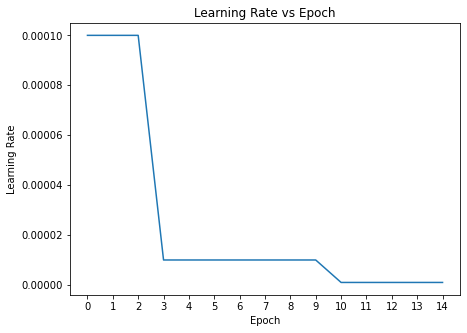

In [18]:
plot_learning_rate(history_dict)

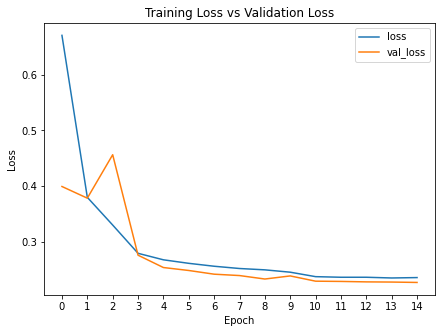

In [19]:
plot_metric(history_dict, 'loss')

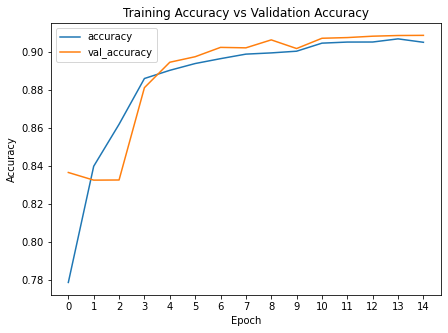

In [20]:
plot_metric(history_dict, 'accuracy')

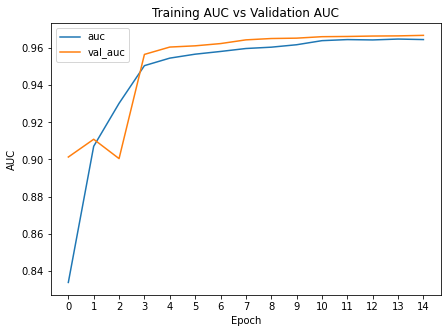

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 20s - loss: 0.2410 - accuracy: 0.9375 - auc: 0.9688

 14/258 [>.............................] - ETA: 0s - loss: 0.2016 - accuracy: 0.9263 - auc: 0.9726 

 28/258 [==>...........................] - ETA: 0s - loss: 0.2318 - accuracy: 0.9096 - auc: 0.9635

 42/258 [===>..........................] - ETA: 0s - loss: 0.2333 - accuracy: 0.9107 - auc: 0.9648

 56/258 [=====>........................] - ETA: 0s - loss: 0.2250 - accuracy: 0.9113 - auc: 0.9679

 70/258 [=======>......................] - ETA: 0s - loss: 0.2273 - accuracy: 0.9098 - auc: 0.9670

 84/258 [========>.....................] - ETA: 0s - loss: 0.2279 - accuracy: 0.9111 - auc: 0.9667

 98/258 [==========>...................] - ETA: 0s - loss: 0.2302 - accuracy: 0.9101 - auc: 0.9660

112/258 [============>.................] - ETA: 0s - loss: 0.2295 - accuracy: 0.9113 - auc: 0.9657

126/258 [=============>................] - ETA: 0s - loss: 0.2323 - accuracy: 0.9092 - auc: 0.9651

140/258 [===============>..............] - ETA: 0s - loss: 0.2302 - accuracy: 0.9096 - auc: 0.9658

154/258 [================>.............] - ETA: 0s - loss: 0.2285 - accuracy: 0.9091 - auc: 0.9663

168/258 [==================>...........] - ETA: 0s - loss: 0.2302 - accuracy: 0.9074 - auc: 0.9655

182/258 [====================>.........] - ETA: 0s - loss: 0.2284 - accuracy: 0.9088 - auc: 0.9660

196/258 [=====================>........] - ETA: 0s - loss: 0.2307 - accuracy: 0.9074 - auc: 0.9655

210/258 [=======================>......] - ETA: 0s - loss: 0.2340 - accuracy: 0.9061 - auc: 0.9645

224/258 [=========================>....] - ETA: 0s - loss: 0.2343 - accuracy: 0.9054 - auc: 0.9646

238/258 [==========================>...] - ETA: 0s - loss: 0.2338 - accuracy: 0.9059 - auc: 0.9650

252/258 [============================>.] - ETA: 0s - loss: 0.2331 - accuracy: 0.9070 - auc: 0.9652

258/258 [==============================] - 1s 4ms/step - loss: 0.2334 - accuracy: 0.9069 - auc: 0.9650


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---